# Appendix
## How to read this appendix

This appendix includes all the code, and calculations, used to create the simulation. To help make the code easier to understand, I have combined the code with the comments and equations found in a traditional appendix. This was a large project and this is reflected in the size of this appendix. The simulation required more than 1200 lines of code, and combines data from four different sources. 

To make it easier to read, I have included a separate table of contents for the appendix. Each section includes the equations, comments, and code, required to model this section of the thesis. The appendix is presented in the order required to run the code. 


# Table of Contents

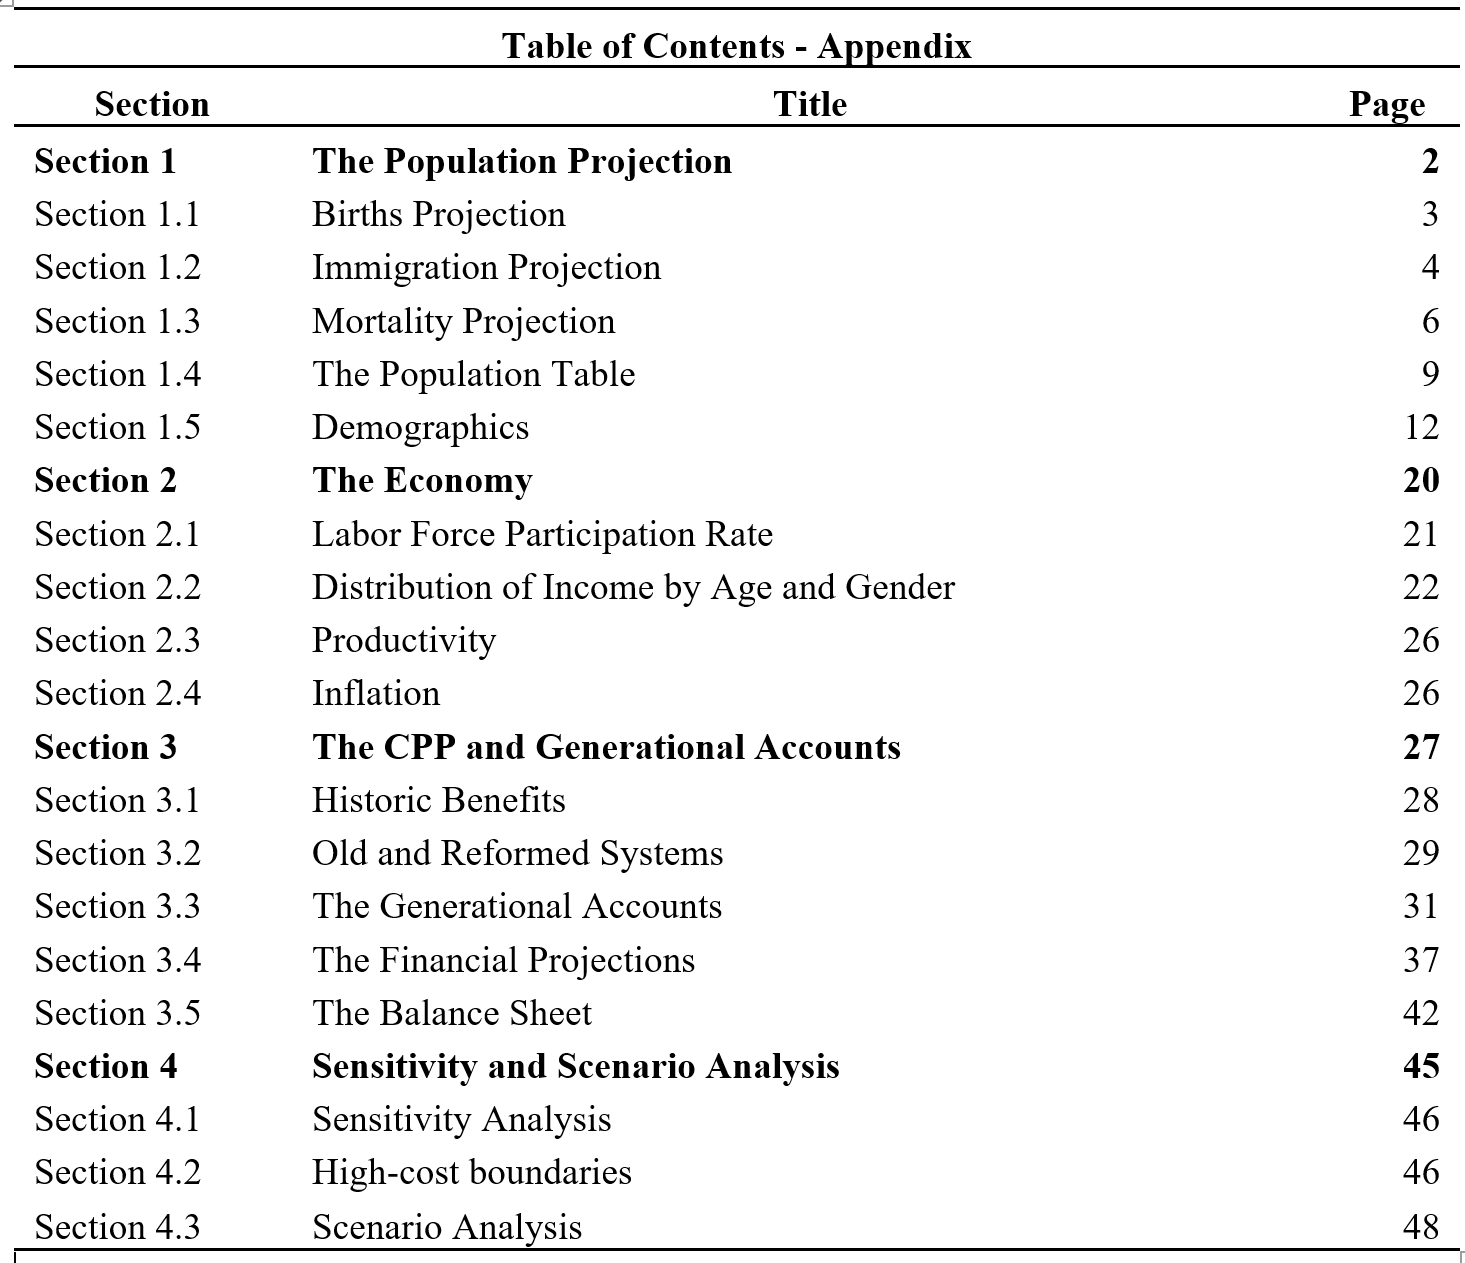

   
# Section 0: Assumptions Used to Build the Simulation

There are many ways one could model the population and economic parameters needed to analyze the Canadian Pension Plan, but instead of making my own assumptions, I am going to use assumptions provided by Canadian Pension Plan Investment Board (CPPIB). The assumptions they provide are found in their [2016 Actuary's report](http://www.osfi-bsif.gc.ca/Eng/Docs/cpp27.pdf).

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib import style
from scipy.interpolate import interp1d

#Ignore python warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Define our plot style
plt.style.use('seaborn-whitegrid')

#Set defaults for matplotlib
plt.rcParams['figure.figsize'] = [18.0, 10.0]
plt.rcParams['figure.dpi'] = 200
plt.rcParams['font.size'] = 20
plt.rcParams['legend.fontsize'] = 'medium'
plt.rcParams['figure.titlesize'] = 'large'
plt.rcParams['lines.linewidth'] = 3

In [3]:
#Defining the parameters of the simulation 

#First year of the population projection
def first_year_pop():
    return 2018

#First year of the CPP reform
def first_year_cpp():
    return 2019

#Last year of the simulation
def last_year():
    return 2118

def simulated_years_pop():
    return last_year() - first_year_pop() + 1

def simulated_years_cpp():
    return last_year() - first_year_cpp() + 1

#Ratio of male babies to female babies
def male_female_ratio():
    return 1.054/2.054

#Number of years someone can live to. From 0 to 110
def max_years_lived():
    return 111

#Age someone starts working
def working_age():
    return 18

#Age someone retires
def retirement_age():
    return 65

#Yearly Maximum Pensionable Income in 2016. 
#2016 is the year the CPPIB report was written
def inflate_income():
    return 54900

#Income that is exempt from pensions
def pension_exemption():
    return 3500

#Risk free interest rate as of July 2019
def risk_free_rate():
    return 0.0361

In [4]:
#Define a function that creates list of 'years'
def create_years(first_year, last_year):
    return np.linspace(first_year, last_year, last_year-first_year+1).astype(int)

# Section 1: Population Projection

The most important part of understanding the economics of a pension system is population demographics. Demographics determine who contributes and receives benefits in any year.

Population change is driven by three main factors: 
1. Births
2. Immigration
3. Deaths

The CPPIB provides a projection for births and immigration in their report. The first thing I need to do is import this data. 

### Section 1.1 - Births

In [5]:
#Projection the Canadian Population (minus Quebec) found in Table 2 found on page 17
def cppib_population_forecast():
    cppib_pop = pd.Series(data  = [29152000, 30732000, 32216000, 33545000, 34739000, 36935000, 42741000],\
                      index = [2020, 2025, 2030, 2035, 2040, 2050, 2075])
    return cppib_pop

In [6]:
#Birth projection provided by the CPPIB found in Table 42 on page 90
def cppib_birth_forecast():
    cppib_births = pd.Series(data = [320000, 325000, 328000, 330000, 332000 ,333000,327000, 324000, 331000, 362000, 404000], \
                        index = [2018, 2019, 2020, 2021, 2022, 2025, 2030, 2035, 2040, 2050, 2075])
    return cppib_births

In [7]:
#Immigration projection provided by the CPPIB found in Table 42 on page 90
def cppib_immigration_forecast():
    cppib_immigration = pd.Series(data = [193000, 195000, 197000, 199000, 201000 ,207000,217000, 226000, 234000, 248000, 286000], \
                        index = [2018, 2019, 2020, 2021, 2022, 2025, 2030, 2035, 2040, 2050, 2075])
    
    return cppib_immigration

The CPPIB report does not provide the full underlying dataset they use to create their projections. Often, they just include a printed table, with data points every 5 years. I created the function below to fill in (interpolate) the data between these data points. For example, if the CPPIB provides data for 2020, and 2025, this function will fill in the points for 2021, 2022, etc. 

In [8]:
#This function fills in the missing data
def interpolate_cppib(series, text):
    cppib_years = create_years(2018, 2075)
    cppib_series = interp1d(series.index, series.values, kind='linear')
    cppib_series = pd.DataFrame(data = cppib_series(cppib_years), index = cppib_years, columns = [text])
    
    return cppib_series

In [9]:
#Update the projections with the interpolated numbers
cppib_births = interpolate_cppib(cppib_birth_forecast(), 'Births')
cppib_immigration = interpolate_cppib(cppib_immigration_forecast(), 'Immigration')

The CPPIB only provides projections to 2075, but I need projections to 2118 (the last year of my simulation). The function below extends these projections to 2118. It does this by taking the average yearly increase in the last 10 years, and linearly projects it forward.

Note: This is the first area of the  simulation that could be improved in the next iteration of this project. For example, we know births each year should be endogenous to the adult population, but in this model its exogenous, with the yearly number of births after 2075 simply being linearly extended based on past data. 

In [10]:
#This function extends the birth/immigration projections to 2118
def extend_forecast_cppib(dataframe, forecast_year):
    
    scenarios = dataframe.columns.tolist()
    years_forecast = forecast_year - dataframe.index[-1]
    first_year = dataframe.index[-1] + 1
    
    avg_change = [np.mean(dataframe[scenario][-10:].diff()) for scenario in scenarios]
        
    for j in range(years_forecast): 
        year = first_year + j
        dataframe.loc[year] = dataframe.loc[year-1].values +  avg_change

    return dataframe

In [11]:
#Updated the projections to the last year of the simulation (2118)
cppib_births = extend_forecast_cppib(cppib_births, last_year())
cppib_immigration = extend_forecast_cppib(cppib_immigration, last_year()) 

I also want to be able to increase, or decrease, the number of births or immigrants each year. This function allows to me change the projection by any multiple I want. For example, a multiplier of 1 is equal to the projection provided by the CPPIB, and a multiplier of 1.2 provides a projection 20% larger than that of the CPPIB. 

In [12]:
#This function allows me to take the birth projection, and increase it or decrease it
def births_forecast(multiplier):
    births = pd.DataFrame(columns = ['Male', 'Female'], index = create_years(first_year_pop(), last_year()))
    births['Male'] = (cppib_births*male_female_ratio()*multiplier).astype(int)
    births['Female'] = (cppib_births*(1-male_female_ratio())*multiplier).astype(int)
    births.columns.name = 'Births Forecast'
    return births

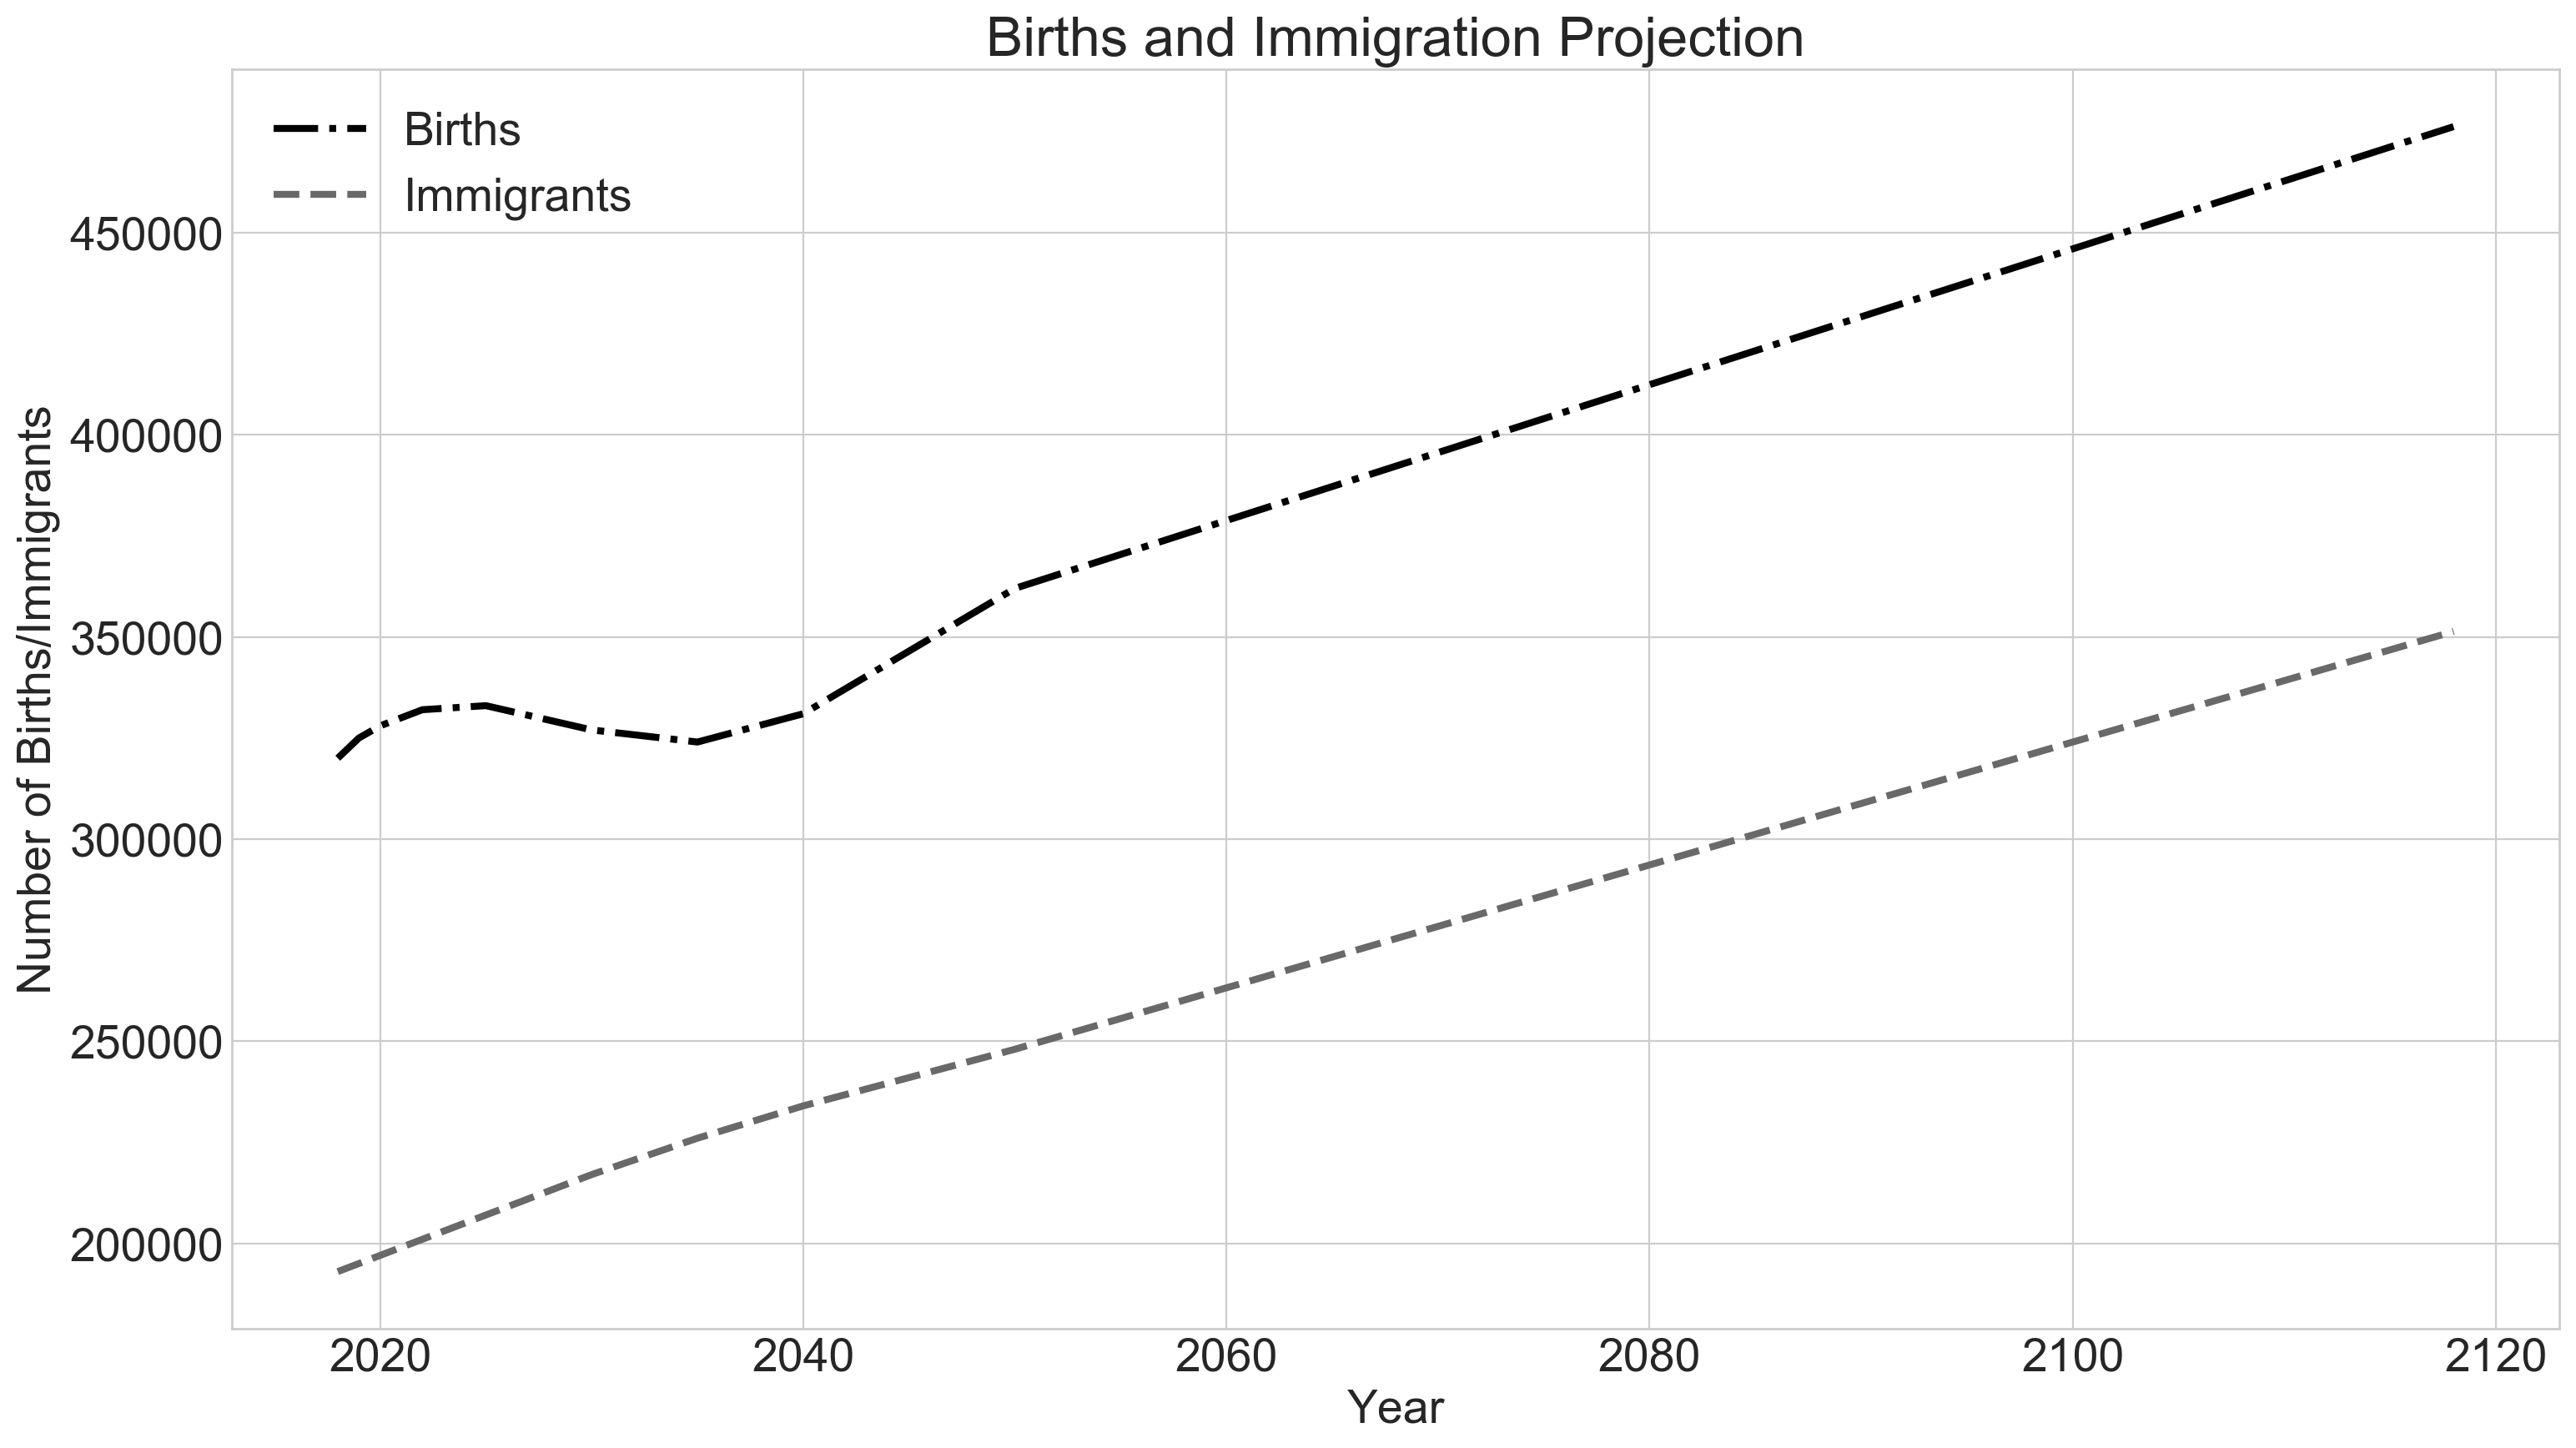

In [13]:
plt.plot(cppib_births,'-.' ,color = 'black',label = 'Births')
plt.plot(cppib_immigration,'--',color = 'dimgray' ,label = 'Immigrants')
plt.xlabel('Year')
plt.ylabel('Number of Births/Immigrants')
plt.title('Births and Immigration Projection')
plt.legend()
plt.show()

### Section 1.2 Immigration
Before I can integrate immigration into the population table I need to understand the general characteristics of the immigrants arriving to Canada. Specifically I need to know their age and gender when arriving. To do this I will analyze some characteristics of immigrants who arrived in Canada since the year 2000 using data provided by [Statistics Canada](https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=1710001401&selectedNodeIds=3D1,3D4,4D1,4D2&checkedLevels=0D1,1D1,1D2,3D3&refPeriods=19710101,20170101&dimensionLayouts=layout2,layout2,layout2,layout3,layout2&vectorDisplay=false). 

In [14]:
#Turns the Stats Can years column into something I can work with
def fix_years_statscan(dataframe):
    year = dataframe['REF_DATE'].tolist()
    year = [np.int(year[:4]) for year in list(year)]
    dataframe['REF_DATE'] = year
    return dataframe

In [15]:
#Immigration data from StatsCan 
immigration = pd.read_csv('C:/Users/seanm/OneDrive/Documents/Thesis/migration_1971/17100014.csv')

#Fix years
immigration =  fix_years_statscan(immigration)

In [16]:
#The current immigration dataframe contains all possible age groups (5 years, 0 - 4 years, 18-64 years, etc)
#I want to isolate 1-year age groups. To do this I will build a list. 

print(immigration['Age group'].unique()[:10].tolist())

['All ages', '-1 year', '0 to 4 years', '0 years', '1 year', '2 years', '3 years', '4 years', '5 to 9 years', '5 years']


In [17]:
age_groups = ["{} year".format(i-1) if (i == 0) | (i == 2) else "{} years".format(i-1) for i in range(102)]

In [18]:
#Filter dataframe by age group
immigration_ages_male = immigration[(immigration.GEO=='Canada') 
                               & (immigration['Age group'].isin(age_groups)) 
                               & (immigration.Sex == 'Males') 
                               & (immigration['Type of migrant'] == 'Immigrants')]

immigration_ages_female = immigration[(immigration.GEO=='Canada') 
                               & (immigration['Age group'].isin(age_groups)) 
                               & (immigration.Sex == 'Females') 
                               & (immigration['Type of migrant'] == 'Immigrants')]

In [19]:
#I want to create a table with ages as rows so I can understand the age distribution of immigrations

def immigration_table(dataframe):
    
    #The age group is writen as '1 year', '2 years' etc. I want to isolate just the number
    dataframe['Age'] = [int(dataframe['Age group'].values[i][:2]) for i in range(len(dataframe.values))]
    
    #Create a table
    dataframe = dataframe.pivot(index = 'Age', columns = 'REF_DATE', values = 'VALUE')
    
    #Combine the -1 and 0 rows
    dataframe.loc[0] = dataframe.loc[-1] + dataframe.loc[0] 
    
    #Eliminate first row
    dataframe = dataframe.iloc[1:]
    
    #Fill in NaNs
    dataframe.fillna(0, inplace=True)
    
    #Isolate the last 20 years of data
    dataframe = dataframe.iloc[:,-20:]
    
    return dataframe

In [20]:
#Turns the data series into tables
immigration_ages_male =  immigration_table(immigration_ages_male)
immigration_ages_female =  immigration_table(immigration_ages_female)

In [21]:
#Divides the table by total immigrants to get the probability distribution
imm_ratio_male = immigration_ages_male.sum(axis=1)/(immigration_ages_male.sum().sum() + immigration_ages_female.sum().sum())
imm_ratio_female = immigration_ages_female.sum(axis=1)/(immigration_ages_male.sum().sum() + immigration_ages_female.sum().sum())

[]

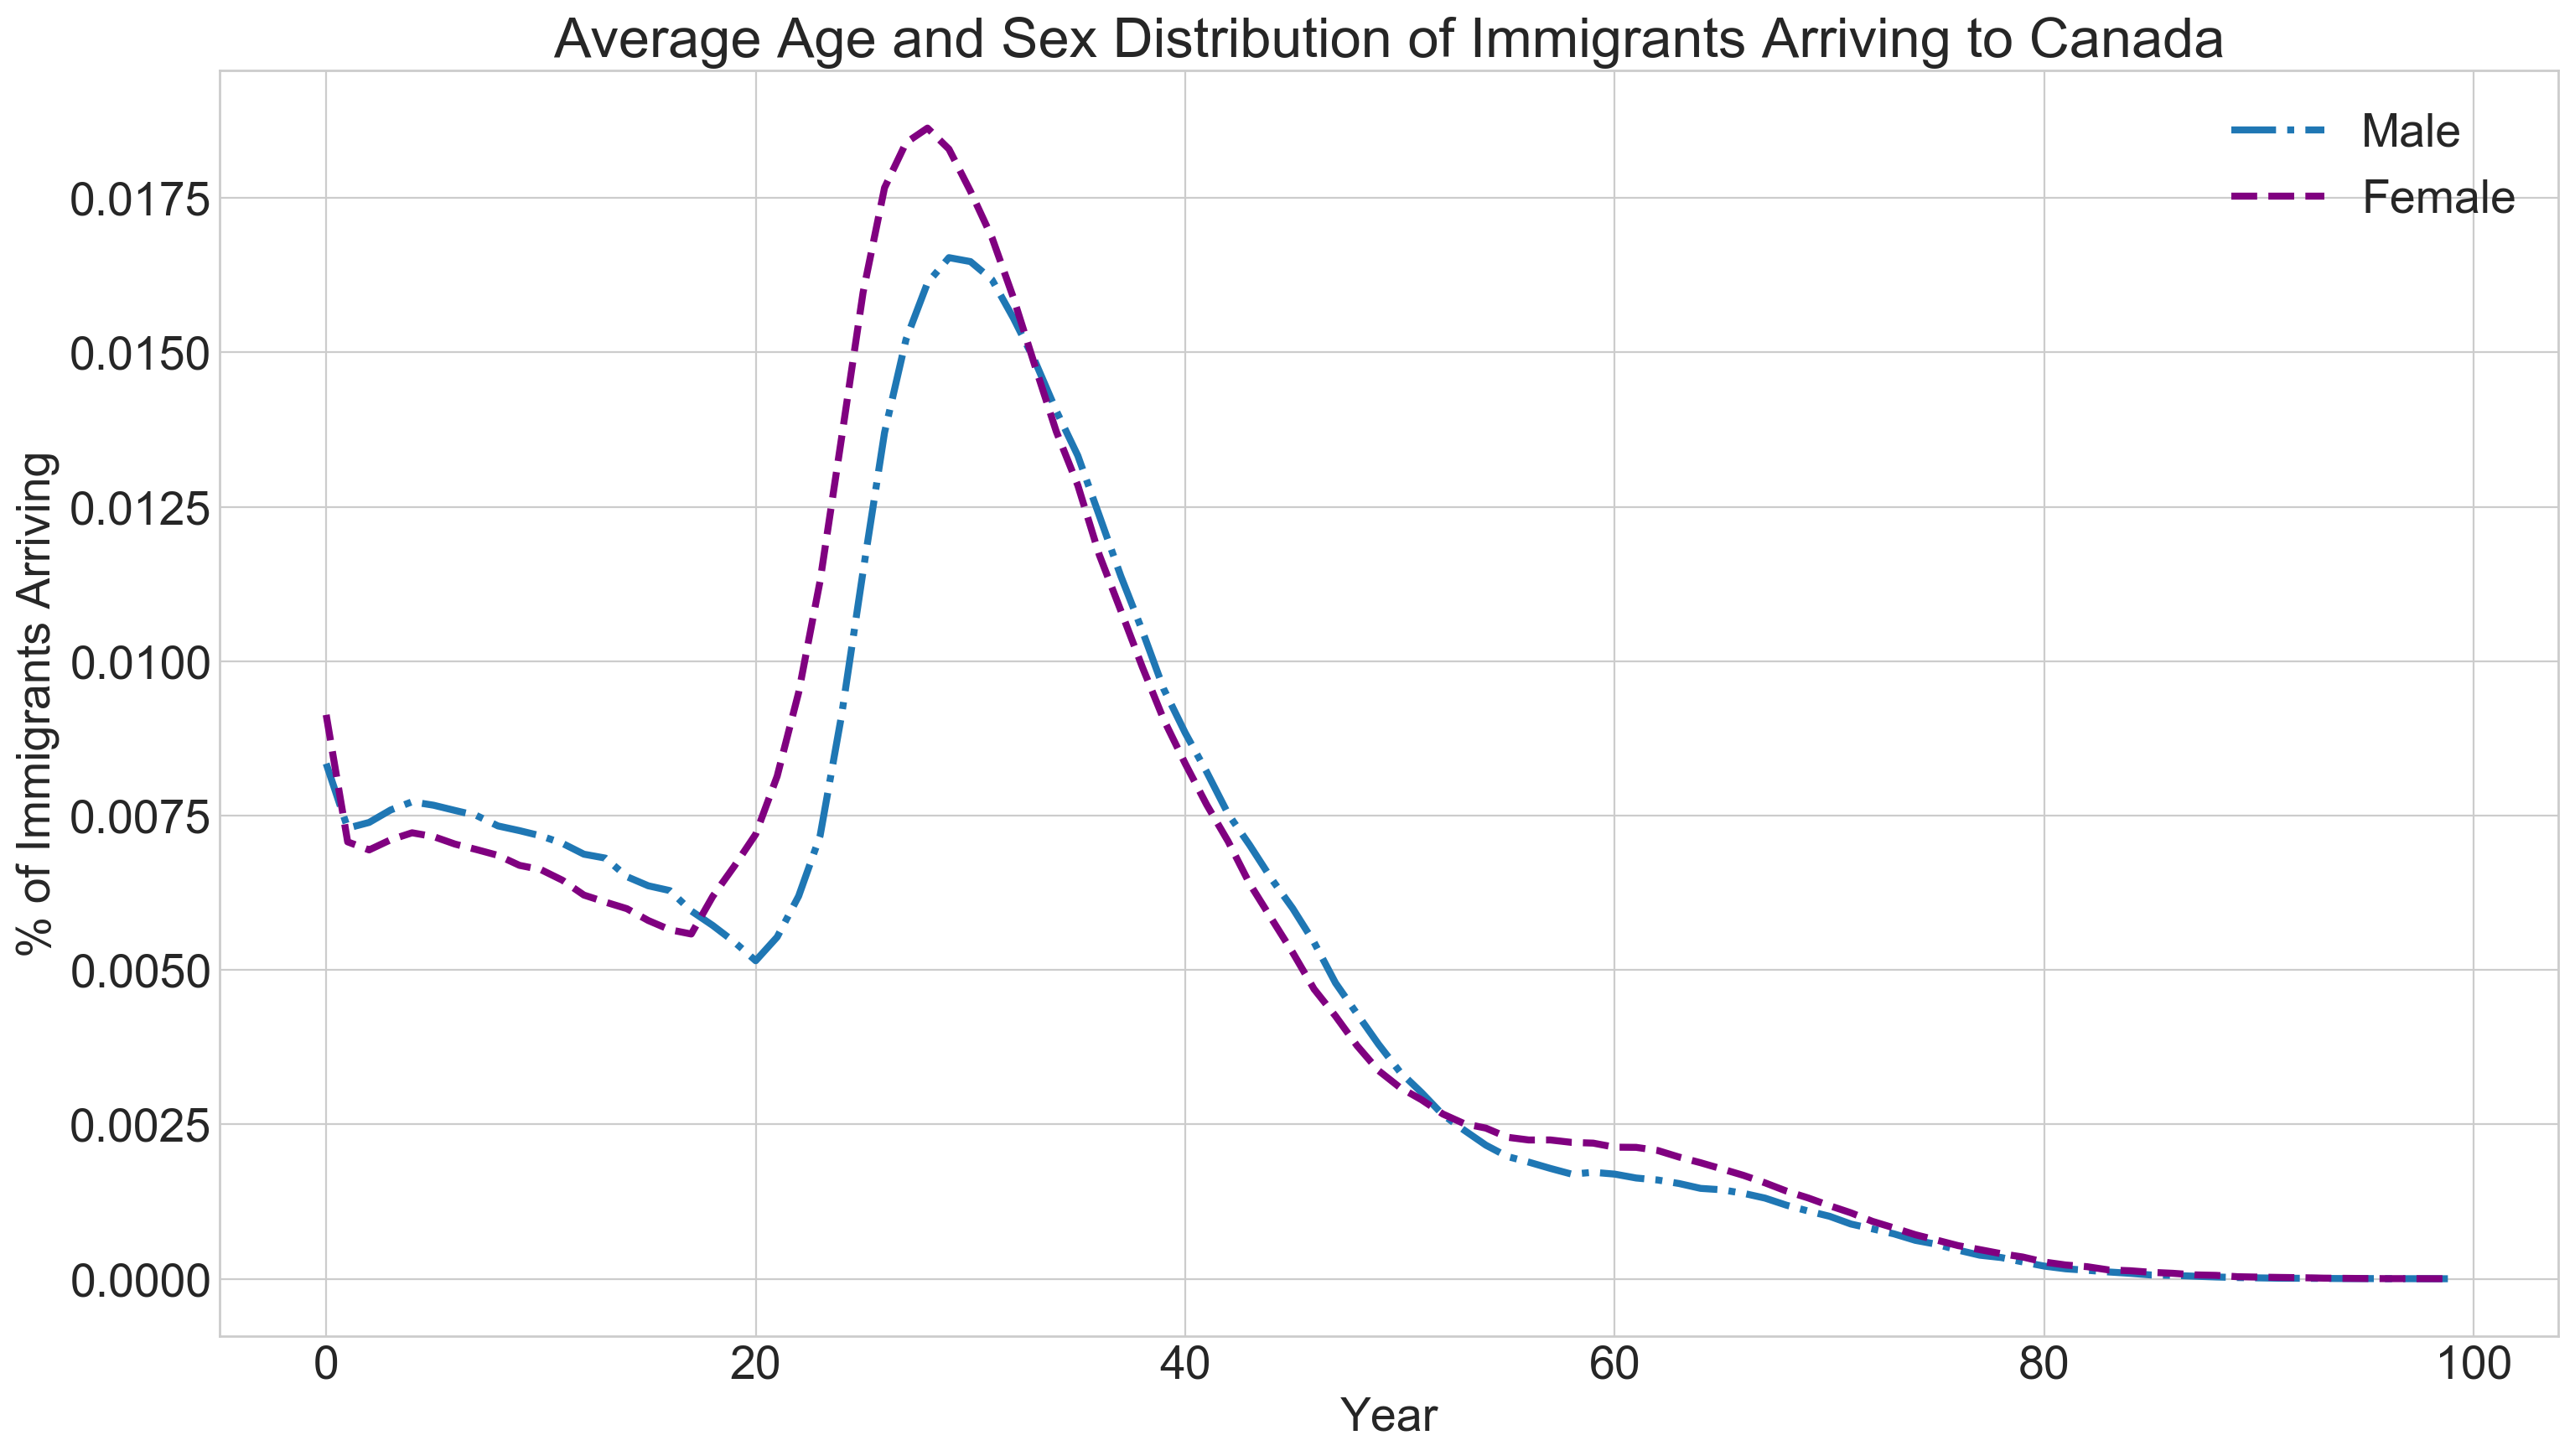

In [22]:
#Plot the distributions
plt.plot(imm_ratio_male, '-.',label = 'Male')
plt.plot(imm_ratio_female,'--', label = 'Female', color = 'purple')
plt.title('Average Age and Sex Distribution of Immigrants Arriving to Canada')
plt.ylabel('% of Immigrants Arriving')
plt.xlabel('Year')
plt.legend()
plt.plot()

In [23]:
#Calculates the average age of an immigrant
def average_age_immigrant(df):
    average_age = [df.values[i] * i for i in range(100)]
    return sum(average_age)/sum(df)

In [24]:
print('The average age of male immigrants coming to Canada is {0:#2.2f}'\
      .format(average_age_immigrant(imm_ratio_male)))
print('The average age of female immigrants coming to Canada is {0:#2.2f}'\
      .format(average_age_immigrant(imm_ratio_female)))

The average age of male immigrants coming to Canada is 28.63
The average age of female immigrants coming to Canada is 28.91


I now need to build two tables, one for males, and other for females, of the year the immigrant arrives and the age they are when they arrive. The hard part with immigration is knowing which cohort to add them to when they arrive. For example, an immigrant who is 20 years old, and arrives in the year 2020, should be added to the cohort that was born in the year 2000. 

I will create a tables that organizes immigrant by which cohort they are in, and they age they arrive. Also integrated into this function is a multiplier, which works exactly the same way the births multiplier works. 

In [25]:
def immigration_forecast(mutiplier):
    immigrants_male = pd.DataFrame()
    immigrants_female = pd.DataFrame()
    
    for year in create_years(first_year_pop(), last_year()):
        immigrants_male[year] = cppib_immigration.loc[year][0]\
            *mutiplier\
            *imm_ratio_male
    
        immigrants_female[year] = cppib_immigration.loc[year][0]\
            *mutiplier\
            *imm_ratio_female
        
    #Convert the tables into integers
    immigrants_male = immigrants_male.astype(int).T
    immigrants_female = immigrants_female.astype(int).T
        
    total_years = create_years(first_year_pop()-100, last_year())
    imm_cohort_table_male = pd.DataFrame(index = total_years)
    imm_cohort_table_female = pd.DataFrame(index = total_years)

    for i in range(len(immigrants_female.columns)):
        cohort = pd.Series(data =immigrants_male.iloc[:,i].values, index=immigrants_male.iloc[:,0].index-i, name = i)
        imm_cohort_table_male = imm_cohort_table_male.join(cohort)
    
        cohort = pd.Series(data =immigrants_female.iloc[:,i].values, index=immigrants_male.iloc[:,0].index-i, name = i)
        imm_cohort_table_female = imm_cohort_table_female.join(cohort)
    
    #Fill in NaN
    imm_cohort_table_male = imm_cohort_table_male.fillna(0)
    imm_cohort_table_female = imm_cohort_table_female.fillna(0)

    #Our life expectancy table expects ages until 110. We will add 10 more years to our tables, and fill them with 0
    for i in range(11):
        imm_cohort_table_male[i+100] = 0
        imm_cohort_table_female[i+100] = 0
        
    return imm_cohort_table_male, imm_cohort_table_female

In [26]:
imm_cohort_table_male, imm_cohort_table_female = immigration_forecast(1)

### Section 1.3 Mortality Projections using the Lee-Carter Approach

In 1981 Lee-Carter developed a statistical method of forecasting mortality. I will follow the procedures using Canadian mortality tables. To assist me, I follow the code outlined by using STATA. [German Rodriguez from Princeton University](https://data.princeton.edu/eco572/leecarter) 

[Data Source - University of Montreal ](http://www.bdlc.umontreal.ca/CHMD/prov/can/can.htm)


The Lee-Carter method summarizes log-mortality rates log $m_{xt}$ along the age dimension using the vectors $a$ and $b$ and a long the time dimension with the vector $k$, with the restrictions that the k's sum to zero, and the a's are calculated using average log rates. 

\begin{equation}
log \space m_{xt} = a_x + b_xk_t + e_{xt}
\end{equation}

These parameters can be summarized as such: 
* $a$ represents the average age profile of mortality. It is calculated by averaging log-rates over time. 
* $k$ represents how mortality changes over time calculated using singular value decomposition (SVD) in conjunction with $b$. 
* $b$ determines how each age group changes with $k_t$

Lee-Carter then forecasted $k_t$ using an ARIMA process. Instead, I find a value for $k_t$ to fit the data to the projected life expectancy provided by the CPPIB.

In [27]:
#Population data from StatsCan 
life_table_male = pd.read_csv('C:/Users/seanm/OneDrive/Documents/Thesis/life_tables_1922/life_tables_males.csv')
life_table_female = pd.read_csv('C:/Users/seanm/OneDrive/Documents/Thesis/life_tables_1922/life_tables_females.csv')

In [28]:
def life_table_projection(life_table):
    
    #From the columns, we only need the Year, Age, and qx variables
    drop_columns = ['mx', 'ax', 'lx', 'dx', 'Lx', 'Tx', 'ex']

    #I will create a new dataframe with just the columns I need
    life_table = life_table.drop(drop_columns, axis=1)

    #In the 'Age' column, I need to replace '110+' with '110'
    life_table.Age.replace('110+', 110, inplace=True)

    #In the 'Age', and 'Year' column, I need to make sure that they are numeric

    #'Year'
    life_table.Year = pd.to_numeric(life_table.Year)

    #'Age'
    life_table.Age = pd.to_numeric(life_table.Age)

    #Take the log of the 'mx' column
    life_table['log_qx'] = np.log(life_table['qx'])

    #Delete 'mx' column
    del life_table['qx']
    
    #Create a table with 'Age' as rows, and 'Years' as columns
    life_table = life_table.pivot(index='Age', columns='Year', values='log_qx')
    
    #Change the sample years to the most recent 15 years
    life_table = life_table.iloc[:,75:]

    #Calculate the average 'log_mx' across each 'age'
    life_table['a'] = life_table.mean(axis=1)

    age_groups = len(life_table.index)

    #Subtract the average 'a' in each year from each 'log_mx' value
    for i in range(age_groups):
        life_table.iloc[i,:-1] = life_table.iloc[i,:-1] - life_table.iloc[i].values[-1]
    
    #Save the average into a separate dataframe since we will need it later, then delete it from the main dataframes
    life_table_a = life_table['a']

    #We no longer need the average 'a' columns
    del life_table['a']
    
    u, s, vt = np.linalg.svd(life_table.T, full_matrices=True, compute_uv=True)

    #'b' and 'k' for males
    b = vt[0] / sum(vt[0])
    k = u[:,0]  * sum(vt[0])*s[0]


    #Turn the array into a dataframe
    sample_years = life_table.columns
    k = pd.DataFrame(data = k, index=sample_years, columns = ['K'])
    
    return life_table_a, b

In [29]:
#This calculates the life expectancy from a life table
def expected_life(life_table):
    a_x = [0.06 if i == 0 else 0.5 for i in range(max_years_lived())]
    a_x[-1] = 1.4
    
    lx = []
    remaining_cohort = [100000]
    
    for i in range(max_years_lived()):
        lx.append(remaining_cohort[-1] - (1-a_x[i])* life_table[i] * remaining_cohort[-1])
        remaining_cohort.append(remaining_cohort[-1] - life_table[i] * remaining_cohort[-1])
        
    return np.round(sum(lx)/100000,2), np.round(sum(lx[65:111])/remaining_cohort[65],2)

In [30]:
#This function allows me to create a life table to fit any life expectancy value that I want. 
def fit_mortality_data_birth(targets, years,  lt_a, lt_b):

    k_values = []
    k = -1
    
    for i in range(len(targets)):
        k  = 100
        
        while expected_life(np.exp(lt_a.values + lt_b*k))[0] < targets[i]:
            k += -0.1
            
        if k < -1000:
            break

        k_values.append(k)
    
    return pd.Series(data = k_values,  index = years)

In [31]:
#Projects mortality based on a series of life expectancy values. 
def forecast_mortality_data(k_values):
    year = k_values.index.tolist()
    k_values = interp1d(k_values.index, k_values.values, kind='linear')
    years = create_years(year[0], year[-1]) 
    k_values = k_values(years).tolist()
   
    number_of_years = 2300 - years[-1]
    diff = np.mean(np.diff(k_values[-10:]))
    
    #Extend forecast
    for i in range(number_of_years):
        year = years[-1] + i
        k_values.append(k_values[-1]+diff)
        
    return pd.DataFrame(data = k_values, index = create_years(2016, 2300))

In [32]:
#This transforms the Lee-Carter model, into a proper life table
def life_tables(a, b, k):
    lt_forecast = []
    total_number_years = 285

    for i in range(total_number_years):
        lt_forecast.append(np.exp(a.values + b*k.values[i]))
   
    lt_forecast = pd.DataFrame(lt_forecast,index=create_years(2016, 2300))    

    return lt_forecast

In [33]:
#Fits the life table 
def life_table_fit(life_table, life_expectancy, year):
    a, b = life_table_projection(life_table)
    k = fit_mortality_data_birth(life_expectancy, year, a, b)
    k = forecast_mortality_data(k)
    life_tables(a, b, k)
    return life_tables(a, b, k)

There are many different ways one can model mortality. The Lee-Carter method was chosen for this thesis because it was the simplest to translate into code. This does not mean that its inadequate though. To test its adequacy, I can plug in life expectancy values from the CPPIB for 2016, 2025, and 2050, and then have the model project life expectancy values for 2075. This way I can directly compare how my model of life predicts life expectancy in 2075, to that of the CPPIB.

According to the CPPIB, in 2075, at birth men are expected to live until aged **86**, and once they turn 65, they are expected to live an additional **23.8** years.

In [34]:
#Found in Table 37 found on page 84
#Using data until 2050 to forecast to 2075 for males
expected_life(life_table_fit(life_table_male, [80.7,82.2,84.2],  [2016, 2025, 2050]).loc[2075])

(86.01, 23.96)

The model over estimates life expectancy at births by 0.01 years, and 0.16 years at aged 65. 

Now lets compare the data for women. According to the CPPIB, in 2075, at birth women are expected to live until aged **89**, and once they turn 65, they are expected to live an additional **26** years.

In [35]:
#Found in Table 37 found on page 84
#Using data until 2050 to forecast to 2075 for females
expected_life(life_table_fit(life_table_female,[84.5,85.6,87.4],  [2016, 2025, 2050]).loc[2075])

(89.03, 26.19)

The model over estimates life expectancy at births by 0.03 years, and 0.19 years at aged 65. 

For the purpose of this thesis, this method for projecting life expectancy is adequate. 

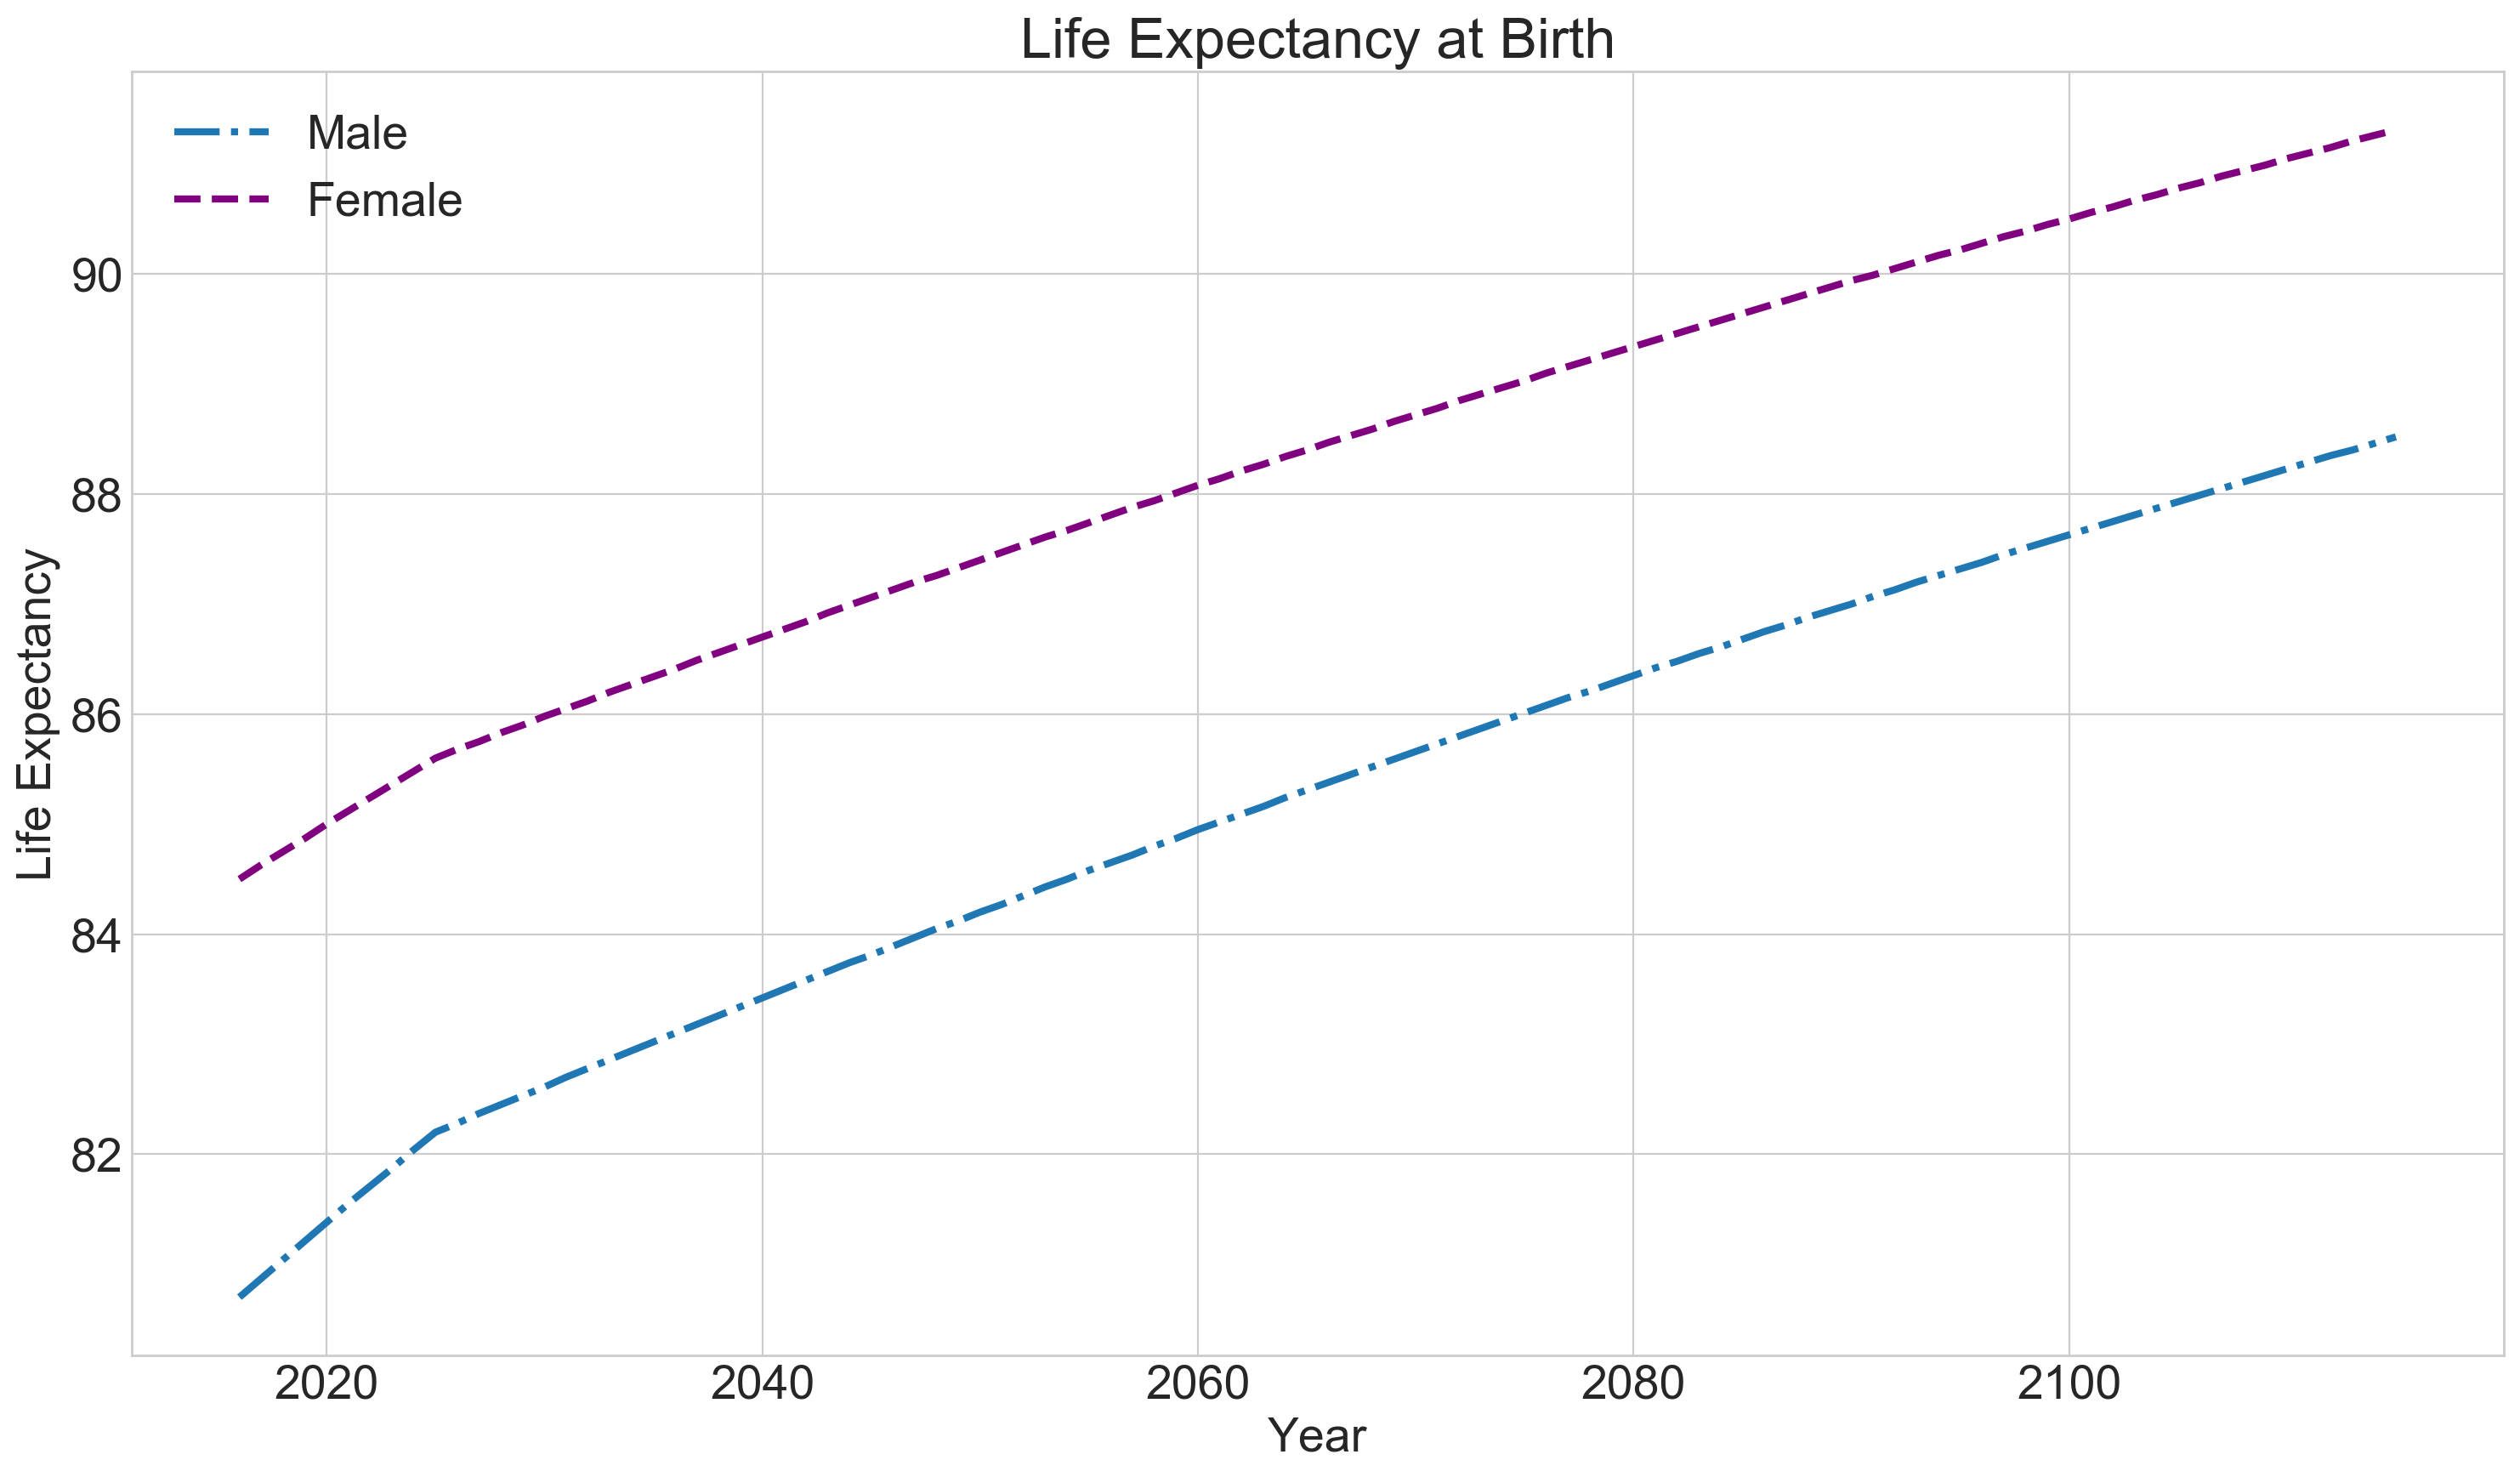

In [36]:
plt.plot(expected_life(life_table_fit(life_table_male, [80.7,82.2,84.2],  [2016, 2025, 2050]))[0][:100], 
         '-.',label = 'Male')
plt.plot(expected_life(life_table_fit(life_table_female, [84.5,85.6,87.4],  [2016, 2025, 2050]))[0][:100], 
         '--',label = 'Female', color = 'purple')
plt.legend()
plt.title('Life Expectancy at Birth')
plt.ylabel('Life Expectancy')
plt.xlabel('Year')
plt.show()

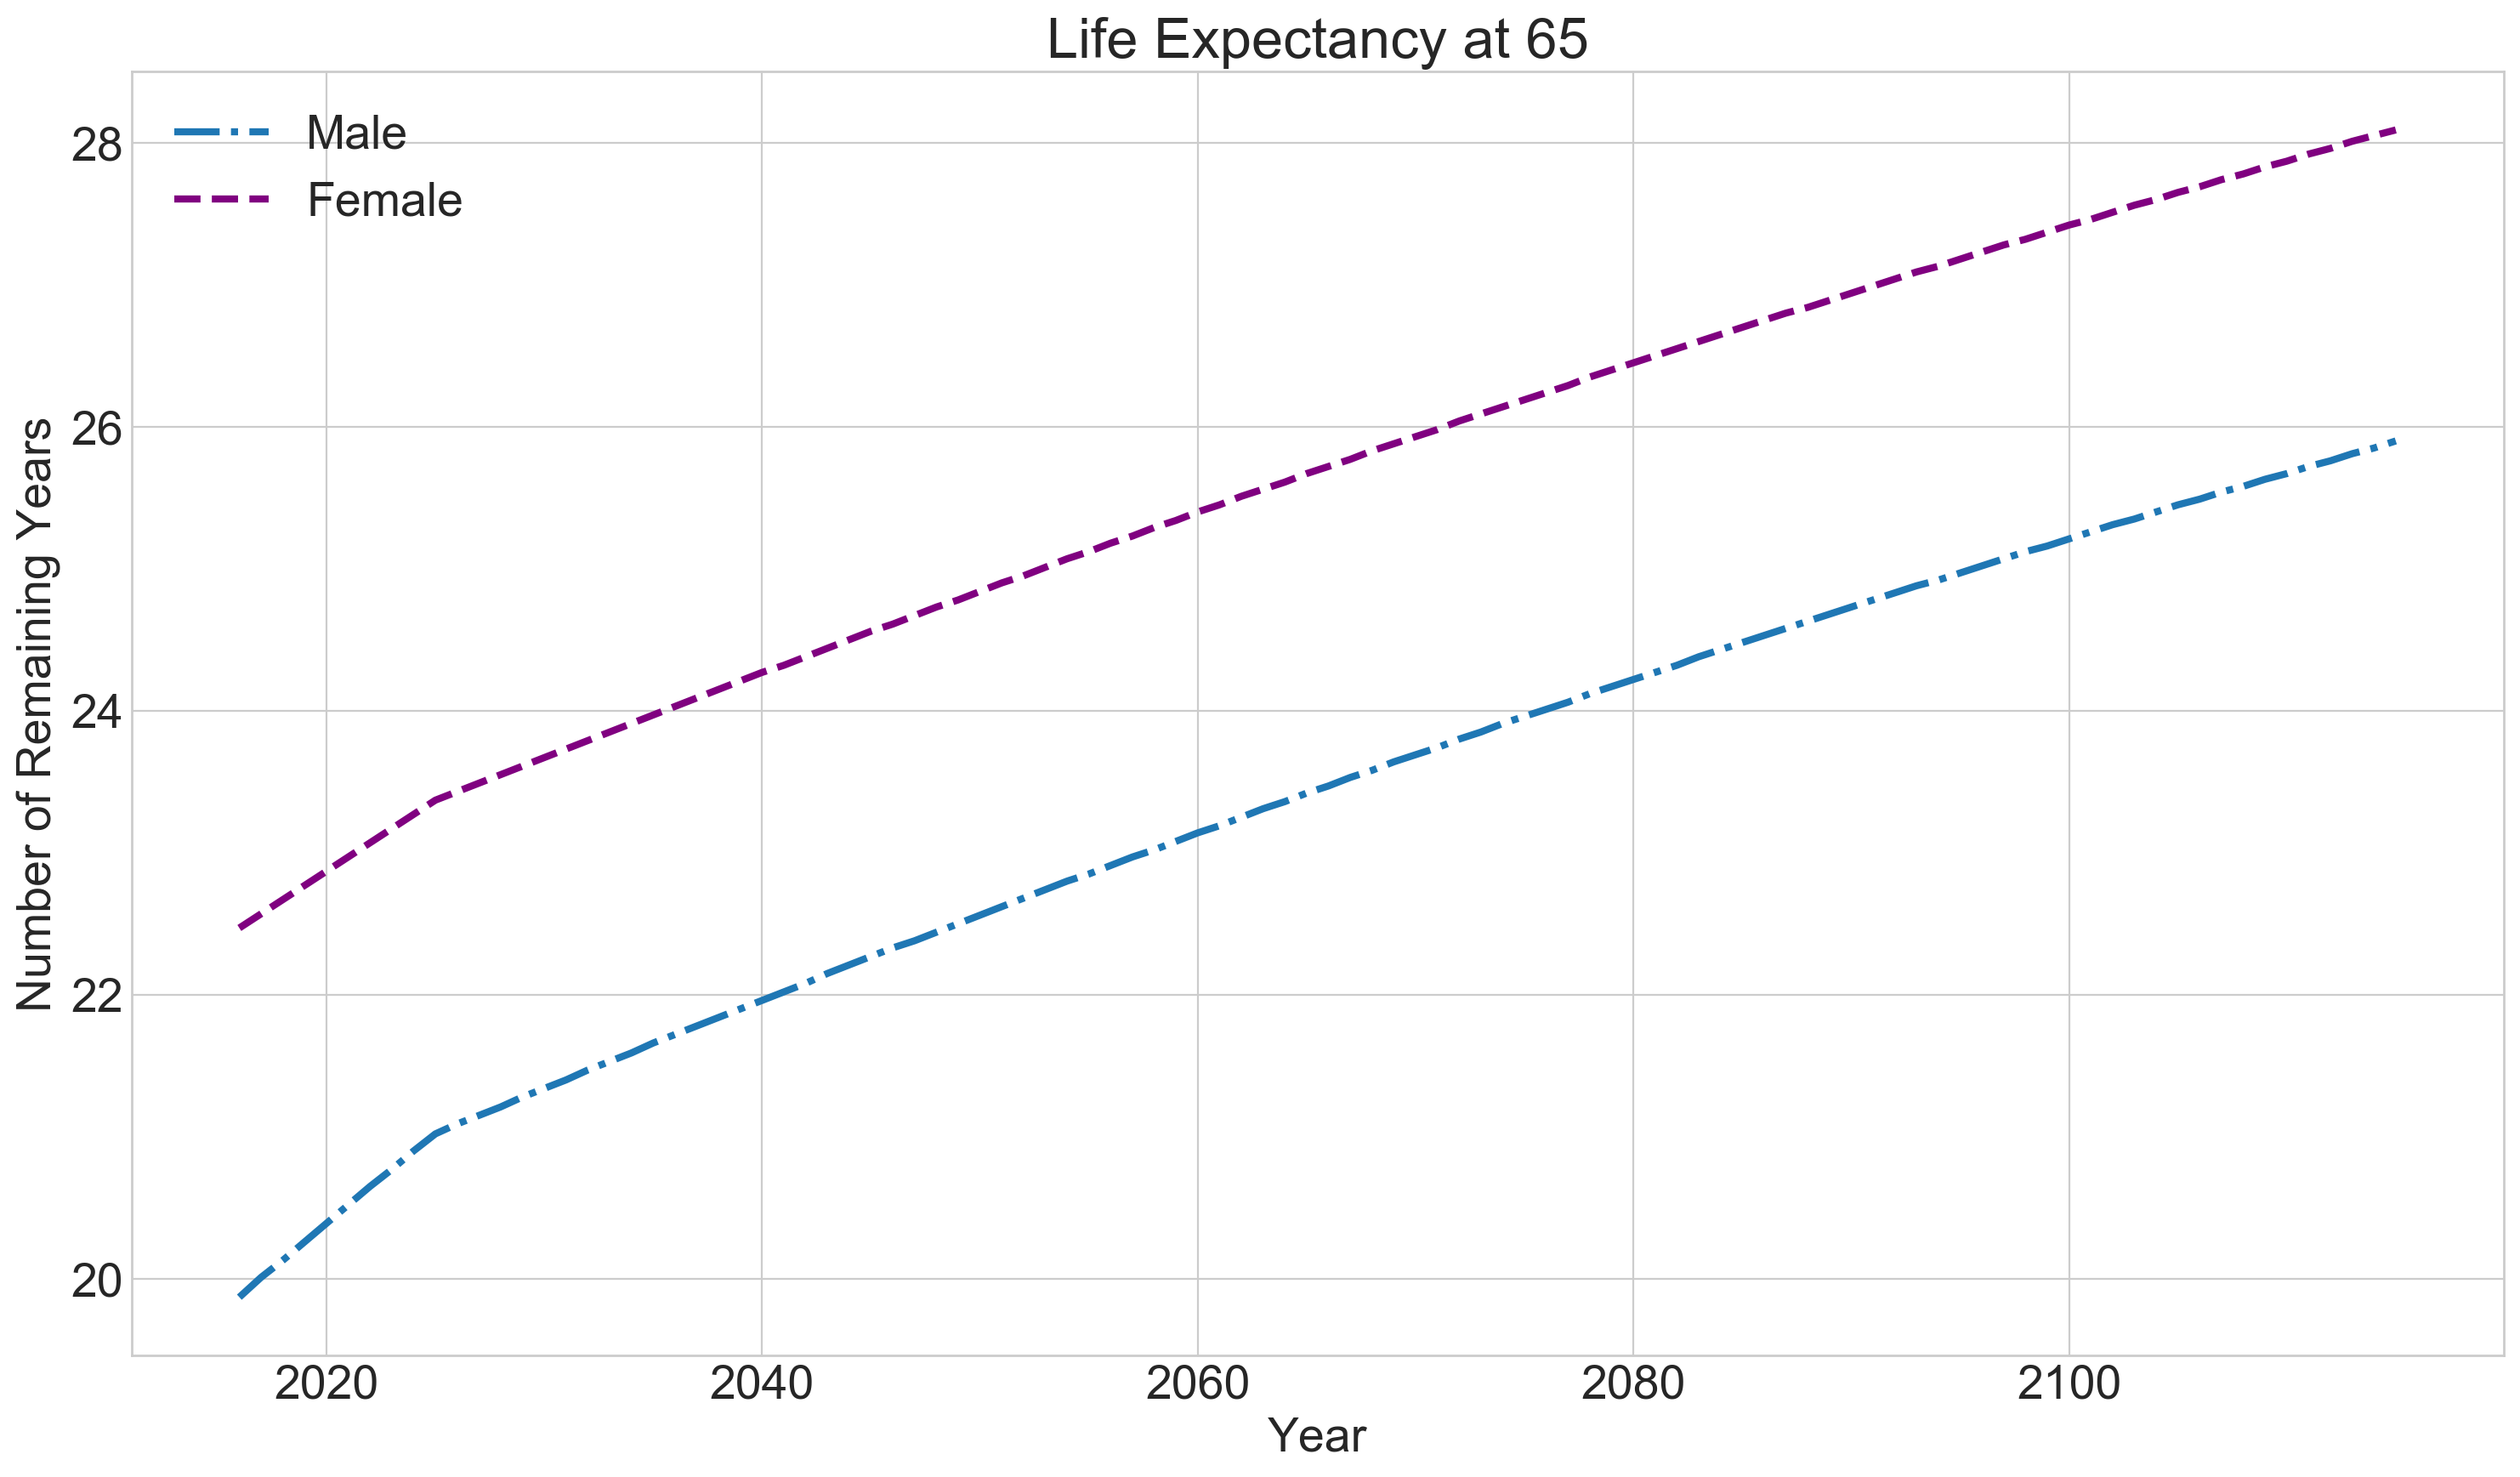

In [37]:
plt.plot(expected_life(life_table_fit(life_table_male, [80.7,82.2,84.2],  [2016, 2025, 2050]))[1][:100], 
          '-.', label = 'Male')
plt.plot(expected_life(life_table_fit(life_table_female, [84.5,85.6,87.4],  [2016, 2025, 2050]))[1][:100], 
         '--',label = 'Female', color = 'purple')
plt.legend()
plt.ylabel('Number of Remaining Years')
plt.xlabel('Year')
plt.title('Life Expectancy at 65')
plt.show()

### Section 1.4 The Population Table

Now that we have births, immigration, and mortality, we can create our population table. The population table must take into account how many people are in each generation in any given year. This means that I need to properly account for the number of births, immigrants, and deaths, to each cohort, in each year.

To calculate the size of cohort $i$ in year $t$ I need to account for the number of people born to that cohort, and the sum of immigrants added to the cohort since year $t$ and sum of deaths that occurred in that cohort since year $t$. The function looks like this. 

\begin{equation}
Cohort_{it} = Births_i + \sum^t_i Immigrants_i - \sum^t_i Deaths_i
\end{equation}


The function below takes four arguments: births multiplier, immigration multiplier, male life expectancy in 2050, and female life expectancy in 2050. This way I can easily create a new population table based with a different set of characteristics. 

I have data from Statistics Canada that includes the number of people and their age. I am going to use this to create my initial population. 

To do this I use data from [Stats Canada](https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=1710000501&selectedNodeIds=1D6,3D1,3D2,3D3,3D4,3D5,3D6,3D8,3D9,3D10,3D11,3D12,3D14,3D15,3D16,3D17,3D18,3D20,3D21,3D22,3D23,3D24,3D26,3D27,3D28,3D29,3D30,3D32,3D33,3D34,3D35,3D36,3D38,3D39,3D40,3D41,3D42,3D44,3D45,3D46,3D47,3D48,3D50,3D51,3D52,3D53,3D54,3D56,3D57,3D58,3D59,3D60,3D62,3D63,3D64,3D65,3D66,3D68,3D69,3D70,3D71,3D72,3D74,3D75,3D76,3D77,3D78,3D80,3D81,3D82,3D83,3D84,3D106,3D107,3D108,3D109,3D110,3D111,3D112,3D113,3D114,3D115,3D116,3D117,3D118,3D119,3D120,3D121,3D122,3D123,3D124,3D125,3D127,3D128,3D129,3D130,3D131,3D133,3D134,3D135,3D136,3D137,3D138&checkedLevels=0D1,1D1,1D2&refPeriods=20180101,20180101&dimensionLayouts=layout2,layout2,layout3,layout2&vectorDisplay=false)

In [38]:
#Function that turns float number into integers, and turns NaN's into zeros. 
def int_and_zeros(df):
    df.fillna(0, inplace=True)
    df = df.astype(int)
    return df

In [39]:
def population_model(birth_multiplier, immigration_multiplier, female_2050, male_2050):
    
    #Population data from StatsCan 
    cad_pop = pd.read_csv('C:/Users/seanm/OneDrive/Documents/Thesis/population_1971/1710000501_databaseLoadingData.csv')
    
    #Subtract the Quebec Population from the Canadian Population
    quebec_pop = cad_pop[cad_pop.GEO == 'Quebec']
    cad_pop = cad_pop[cad_pop.GEO == 'Canada']
    cad_pop.VALUE = cad_pop.VALUE.values - quebec_pop.VALUE.values
    
    #Isolate the age groups in the year 2018 for Male and Female
    age_males_2018 = cad_pop[(cad_pop.REF_DATE == 2018) & (cad_pop.Sex == 'Males') & (cad_pop.VECTOR != 'v466669')]
    age_females_2018 = cad_pop[(cad_pop.REF_DATE == 2018) & (cad_pop.Sex == 'Females') & (cad_pop.VECTOR != 'v466670')]
    
    #Number of age categories in the initial population
    age_groups = len(age_males_2018['Age group'])
    years = create_years(first_year_pop(), last_year())

    #Create the initial dataframes
    male_pop = pd.DataFrame(index=years)
    female_pop = pd.DataFrame(index=years)
    deaths_df = pd.DataFrame(index=years)
    
    #Create immigration tables
    imm_cohort_table_male, imm_cohort_table_female = immigration_forecast(immigration_multiplier)
    
    #Create life tables
    lt_forecast_female = life_table_fit(life_table_female, [84.5,85.6,female_2050],  [2016, 2025, 2050])
    lt_forecast_male = life_table_fit(life_table_male, [80.7,82.2,male_2050],  [2016, 2025, 2050])
   

    #Assign each age cohort a survival function, and project population figures into the future
    for i in range(age_groups):
    
        #Lists
        survival_male = []
        survival_female = []
        deaths = []
        year = []
        max_age = max_years_lived()
    
        #Age and year figures
        remaining_life = max_age-i
        year_born = first_year_pop()-i
        age = first_year_pop()-year_born

        for j in range(remaining_life):
            cohort_table = first_year_pop() + j
        
            #When J == 0, it takes the values from the 2018 population table. 
            if j == 0:
                survival_male.append(age_males_2018.VALUE.iloc[i])
                survival_female.append(age_females_2018.VALUE.iloc[i])
                deaths.append(0)
                year.append(first_year_pop()+j)
        
        #Take the figure from the first year
        #-Deaths
        #+Immigrants
            else:
            
                survival_male.append(survival_male[-1]
                                     -survival_male[-1]*lt_forecast_male.loc[cohort_table,age+j-1]
                                     +imm_cohort_table_male.loc[year_born][age+j])
            
                survival_female.append(survival_female[-1]
                                     -survival_female[-1]*lt_forecast_female.loc[cohort_table,age+j-1]
                                     +imm_cohort_table_female.loc[year_born][age+j])
            
                deaths.append(survival_male[-1]*lt_forecast_male.loc[cohort_table,age+j]
                              +survival_female[-1]*lt_forecast_female.loc[cohort_table,age+j])
            
                year.append(first_year_pop()+j)
            
        #Turn the lists into series, attach the year list as the index, and label the cohort with the year born
        male_cohort = pd.Series(data = survival_male, index=year, name = year_born)
        female_cohort = pd.Series(data = survival_female, index=year, name = year_born)
        death_cohort = pd.Series(data = deaths, index=year, name = year_born)
    
        #Append to master dataframe
        male_pop = male_pop.join(male_cohort)
        female_pop = female_pop.join(female_cohort)
        deaths_df = deaths_df.join(death_cohort)
    
    
    #Now project forward using births, immigration, and mortality. 
    for i in range(simulated_years_pop()-1):
        survival_male = []
        survival_female = []
        deaths = []
        year = []
        year_born = first_year_pop() + 1 + i
    
        for j in range(max_years_lived()):
        
            # +Births 
            #+Immigrants
            if j == 0: 
                survival_male.append(births_forecast(birth_multiplier)['Male'].loc[year_born]
                                     +imm_cohort_table_male.loc[year_born][j])
            
                survival_female.append(births_forecast(birth_multiplier)['Female'].loc[year_born]
                                     +imm_cohort_table_female.loc[year_born][j])
          
                deaths.append(0)
        
                year.append(year_born + j)
            
            
            #-Deaths
            #+Immigrants
            else:
                survival_male.append(survival_male[-1]
                                     -survival_male[-1]*lt_forecast_male.loc[year_born+j,j-1]
                                     +imm_cohort_table_male.loc[year_born][j])
            
                survival_female.append(survival_female[-1]
                                      -survival_female[-1]*lt_forecast_female.loc[year_born+j,j-1]
                                      +imm_cohort_table_female.loc[year_born][j])
            
                deaths.append(survival_male[-1]*lt_forecast_male.loc[year_born+j,j-1]
                              +survival_female[-1]*lt_forecast_female.loc[year_born+j,j-1])
            
                year.append(year_born + j)
                        
        
        male_cohort = pd.Series(data = survival_male, index=year, name = year_born)
        female_cohort = pd.Series(data = survival_female, index=year, name = year_born)
        death_cohort = pd.Series(data = deaths, index=year, name = year_born)

        male_pop = male_pop.join(male_cohort)
        female_pop = female_pop.join(female_cohort)
        deaths_df = deaths_df.join(death_cohort)
    
    #Eliminate NaN and convert to integers
    male_pop = int_and_zeros(male_pop)
    female_pop = int_and_zeros(female_pop)
    deaths_df = int_and_zeros(deaths_df)

                       
    #Convert the index into ints
    male_pop.index = male_pop.index.astype(int)
    female_pop.index = female_pop.index.astype(int)
    deaths_df.index = deaths_df.index.astype(int)

    #Sort Index
    male_pop.sort_index(inplace=True)
    female_pop.sort_index(inplace=True)
    deaths_df.sort_index(inplace=True)

    #Sort columns
    male_pop = male_pop.reindex(sorted(male_pop.columns), axis=1)
    female_pop = female_pop.reindex(sorted(female_pop.columns), axis=1)
    deaths_df = deaths_df.reindex(sorted(deaths_df.columns), axis=1)
                           
    #Combine the male and female populations to get a total population
    total_pop_table = male_pop + female_pop

    #Aggregate population
    total_pop_series = total_pop_table.sum(axis=1)
    death_series = deaths_df.sum(axis=1)
    
    return total_pop_series, male_pop, female_pop, death_series

In [40]:
#This initial population table uses the best estimate assumptions provided by the CPPIB. 
total_pop_series, male_pop, female_pop, death_series = population_model(1, 1, 87.4, 84.2)

In [41]:
#Inspection of the Male cohort dataframe

#Each row is a year of the simulation. Each column represents each cohort. 
#A cohort born in 2000, is labeled 2000. 
male_pop.head()

1918  1919  1920  1921  1922  1923  1924  1925   1926   1927  ...  2109  \
2018  1430   914  1645  2599  3562  4841  6723  8962  11390  14310  ...     0   
2019   918   608  1135  1854  2624  3675  5268  7131   9354  11950  ...     0   
2020   568   391   757  1281  1875  2712  4006  5598   7453   9832  ...     0   
2021   338   242   487   855  1297  1941  2961  4264   5862   7845  ...     0   
2022   194   144   301   550   867  1344  2122  3156   4472   6182  ...     0   

      2110  2111  2112  2113  2114  2115  2116  2117  2118  
2018     0     0     0     0     0     0     0     0     0  
2019     0     0     0     0     0     0     0     0     0  
2020     0     0     0     0     0     0     0     0     0  
2021     0     0     0     0     0     0     0     0     0  
2022     0     0     0     0     0     0     0     0     0  

[5 rows x 201 columns]

### Section 1.5 - Demographics

Now that the initial population table is created, we can inspect some demographic information of the population. This also allows me to directly compare my population projection, with that provided by the CPPIB. 

Even though I am using their births, and immigration projections, there are still areas where our projections may differ. For example, I start my projection in 2018, using the Canadian population in 2018 as my starting values. They CPPIB report was published in 2016, and therefore used data as of 2015 as their initial values. Between 2015, and 2018, the CPPIB underestimated the size of immigration into the country. Therefore, from the start, my population projections differs slightly. 

Another possible area of divergence is immigration. I used the average age and gender distribution of immigrants from the last 20 years in Canada to built my immigration table. The CPPIB does not mention how they do this. 

One final area of divergence is mortality, while my mortality projection is adequate, and is designed to fit the CPPIB projections as closely as possible, it does not it perfectly. I use the Lee-Carter approach for projecting mortality, the CPPIB does not mention the approach they take to project mortality. Therefore, their mortality projections may follow a different pattern than mine. 

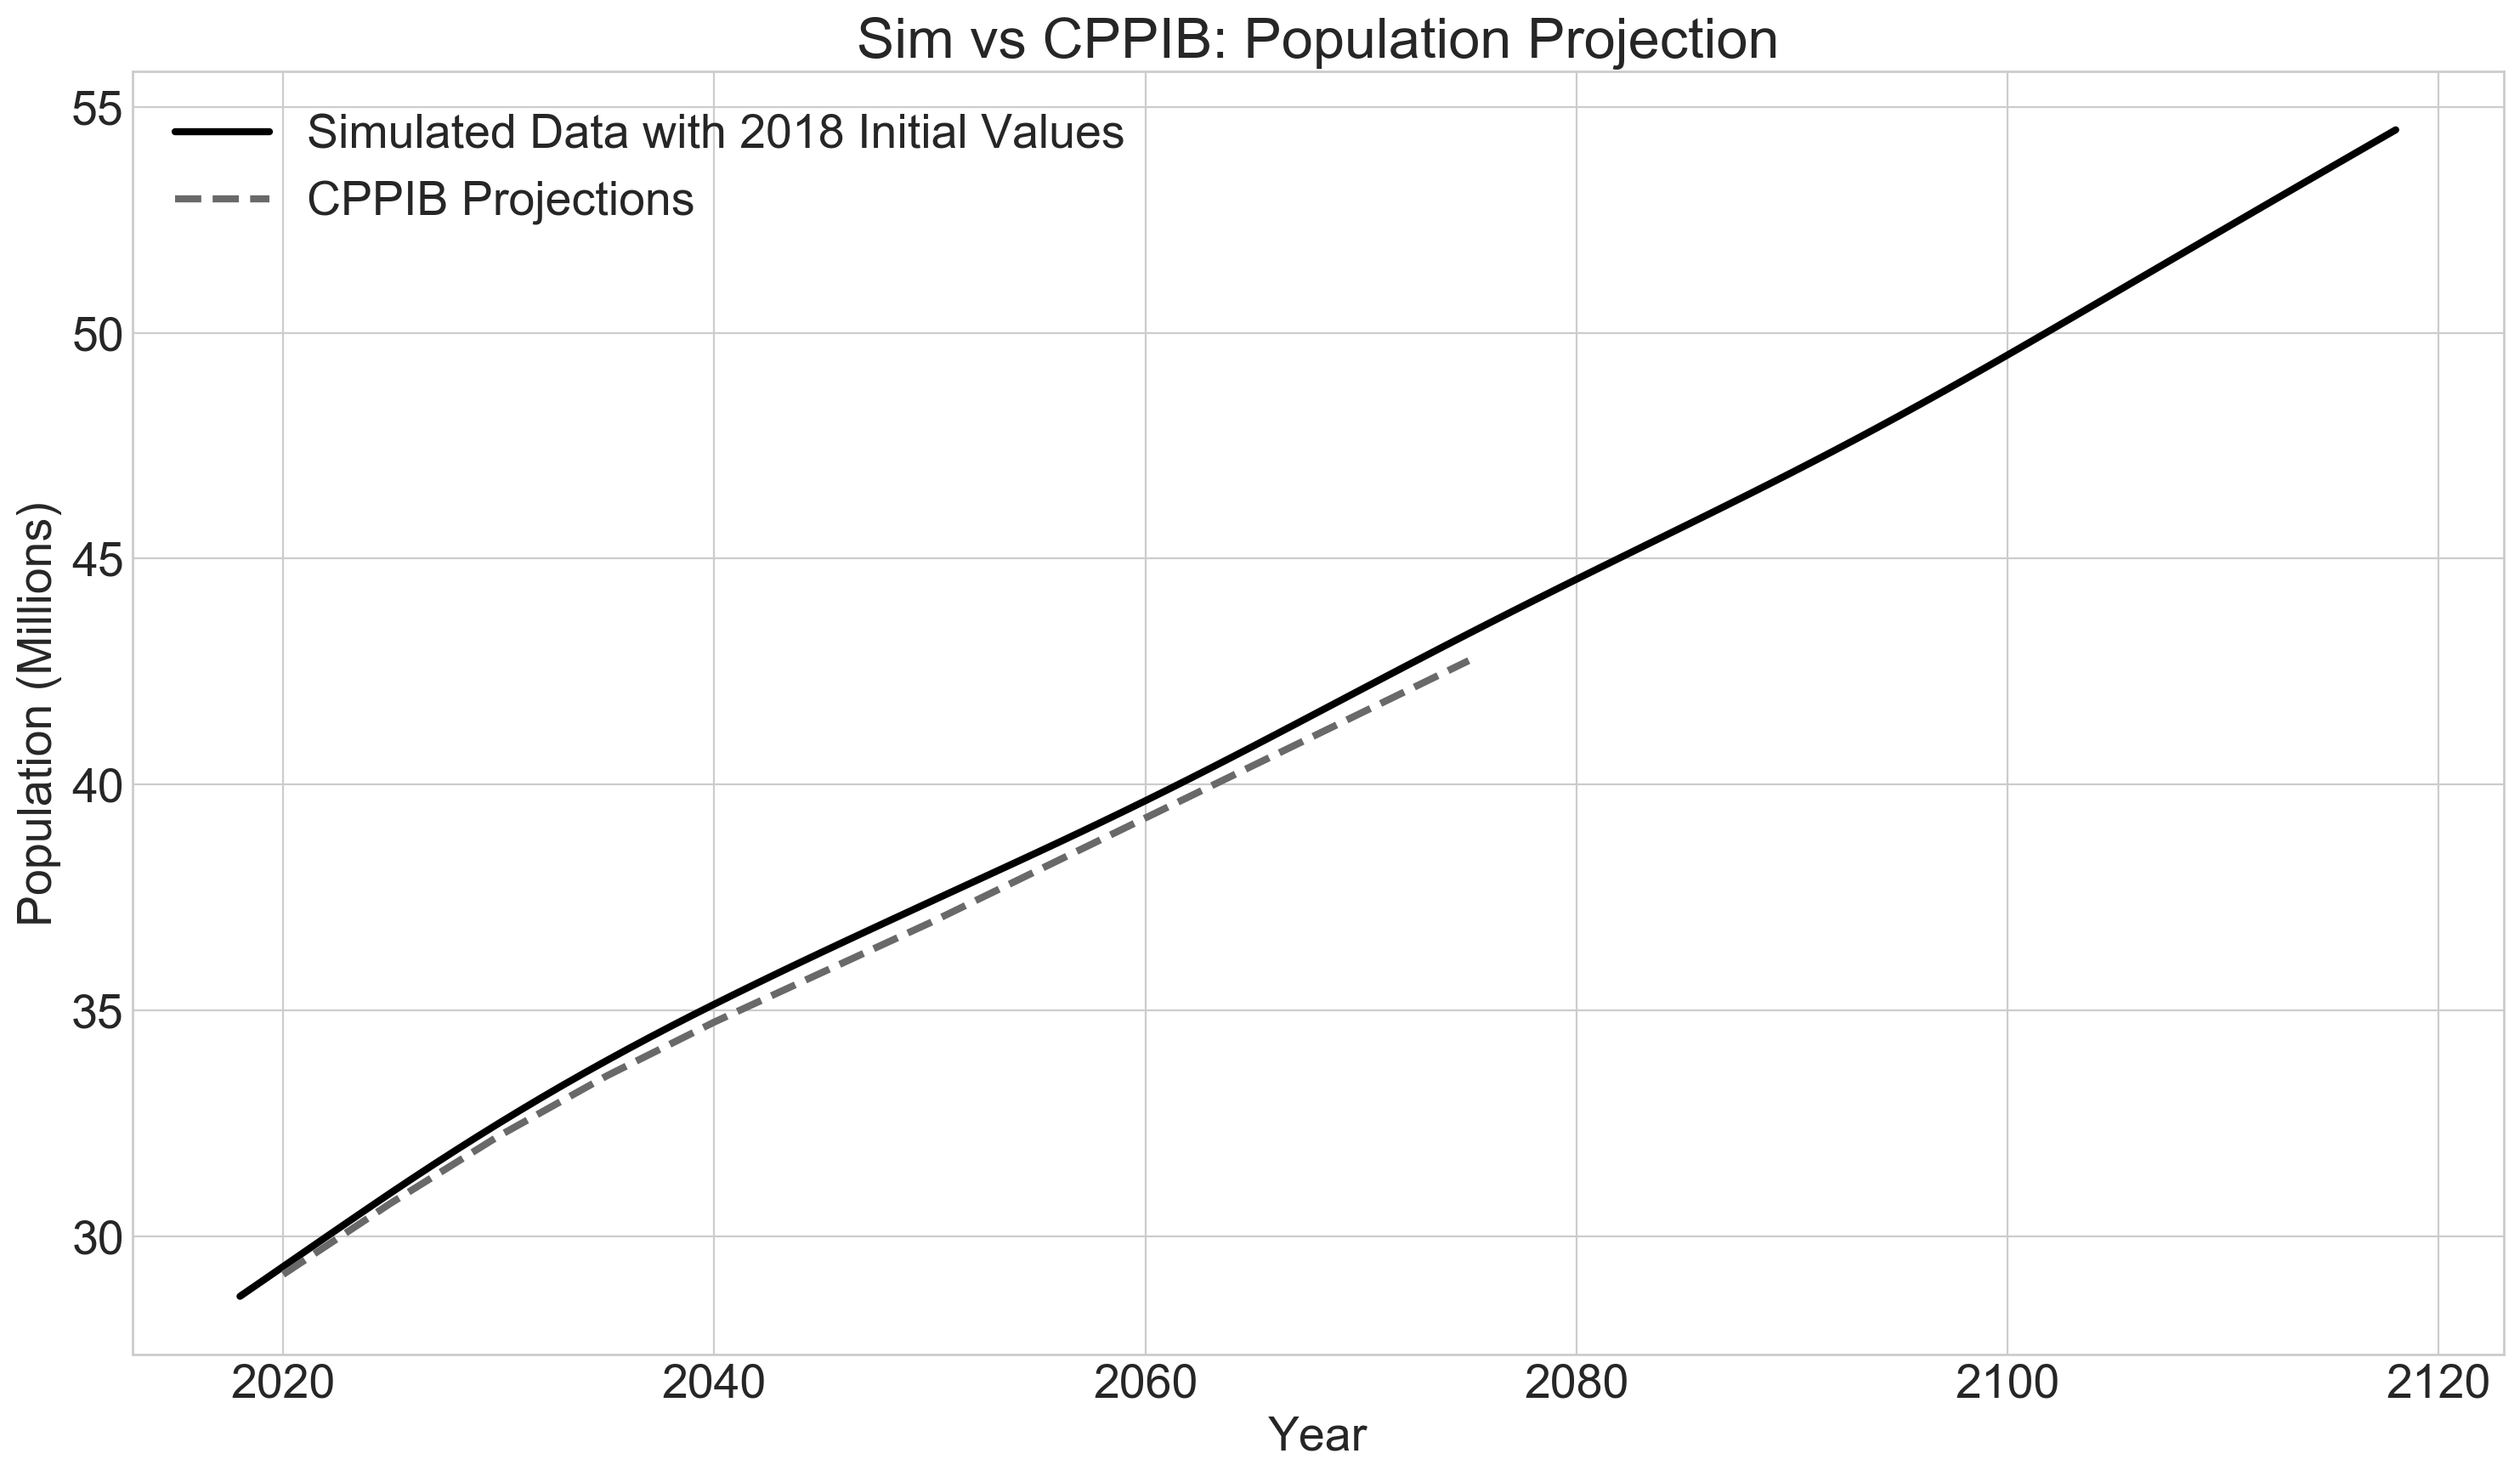

In [42]:
plt.plot(total_pop_series/1000000,color = 'Black',label = 'Simulated Data with 2018 Initial Values')
plt.plot(cppib_population_forecast()/1000000,'--', color = 'dimgray', label = 'CPPIB Projections')
plt.ylabel('Population (Millions)')
plt.xlabel('Year')
plt.title('Sim vs CPPIB: Population Projection')
plt.legend()
plt.show()

This looks like a fairly accurate projection, but with a small expanding divergence. in 2075, the last year the CPPIB provides data, the divergence is 2%.

Next lets go through some demographic information of my population, starting with average and median age, and the dependency ratio. 

In [43]:
def average_age(df_total):
    avg_age = pd.DataFrame()
    
    for i in range(len(df_total.index)):
        year = first_year_pop() + i
        avg_age[year] = df_total.loc[year]*(year - df_total.loc[year].index)
    
    avg_age = avg_age.sum(axis=0)/df_total.sum(axis=1)
    
    return avg_age

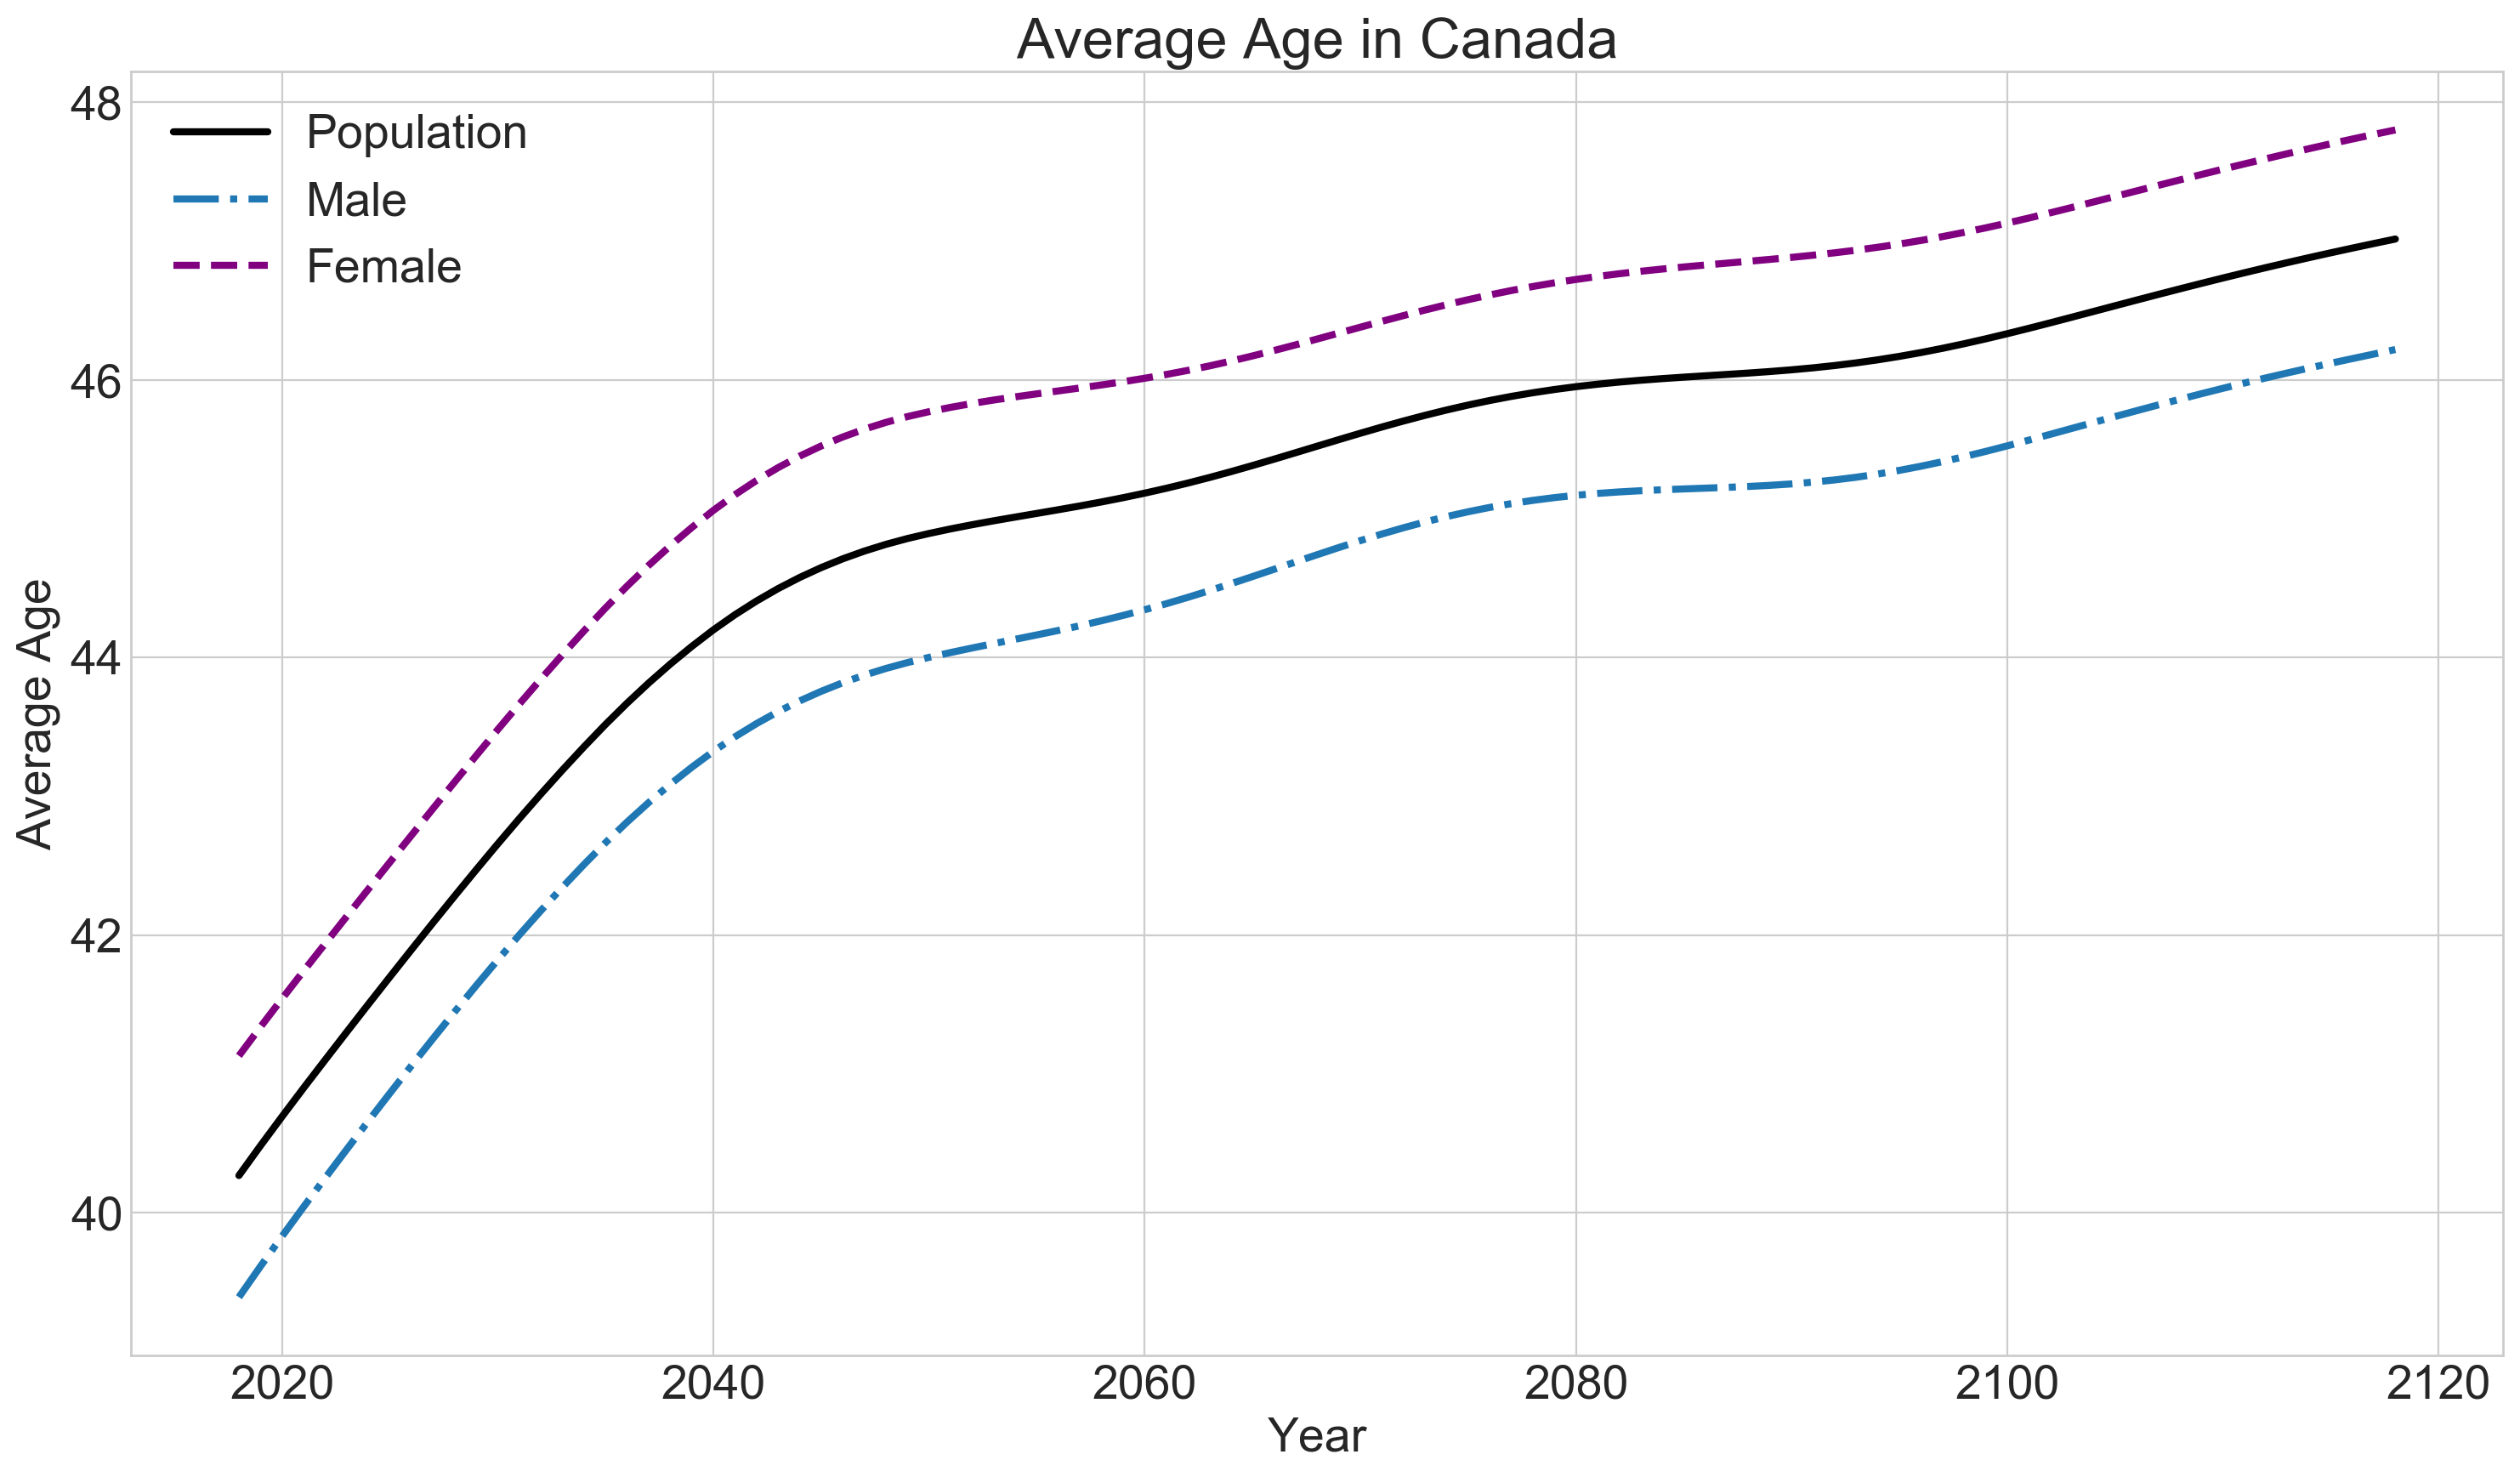

In [44]:
plt.plot(average_age(male_pop + female_pop), 'black', label= 'Population')
plt.plot(average_age(male_pop),'-.',label = 'Male')
plt.plot(average_age(female_pop),'--',color = 'purple', label = 'Female')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Average Age')
plt.title('Average Age in Canada')
plt.show()

Note: Since the population table is updated each year, the de facto birth date, and death date, for everyone in the simulation is January 1st. This doesn't matter too much for the average age, but it could skew the median age figure. To better estimate median age, I assume that it is equally likely to be born in any month of the year. 

In [45]:
def median_age(df):
    
    median = []
    
    for i in range(simulated_years_pop()):
        search = 0
        year = first_year_pop() + i 
        
        #Create a list of ages for each year
        frequency = [df.loc[year].values[::-1][x] for x in range(len(df.loc[year].values))\
                 if df.loc[year].values[::-1][x] > 0]
        
        for j in range(len(frequency)):
            
            middle = sum(frequency)/2
            
            if search < middle:
                search += frequency[j]
            
            else:
                #Assume its about equally likely to be born in any month
                month = (search - middle)/frequency[j-1]
                median.append(j - month)
                
                break
                
    median = pd.Series(data = median, index = df.index)
    
    return median

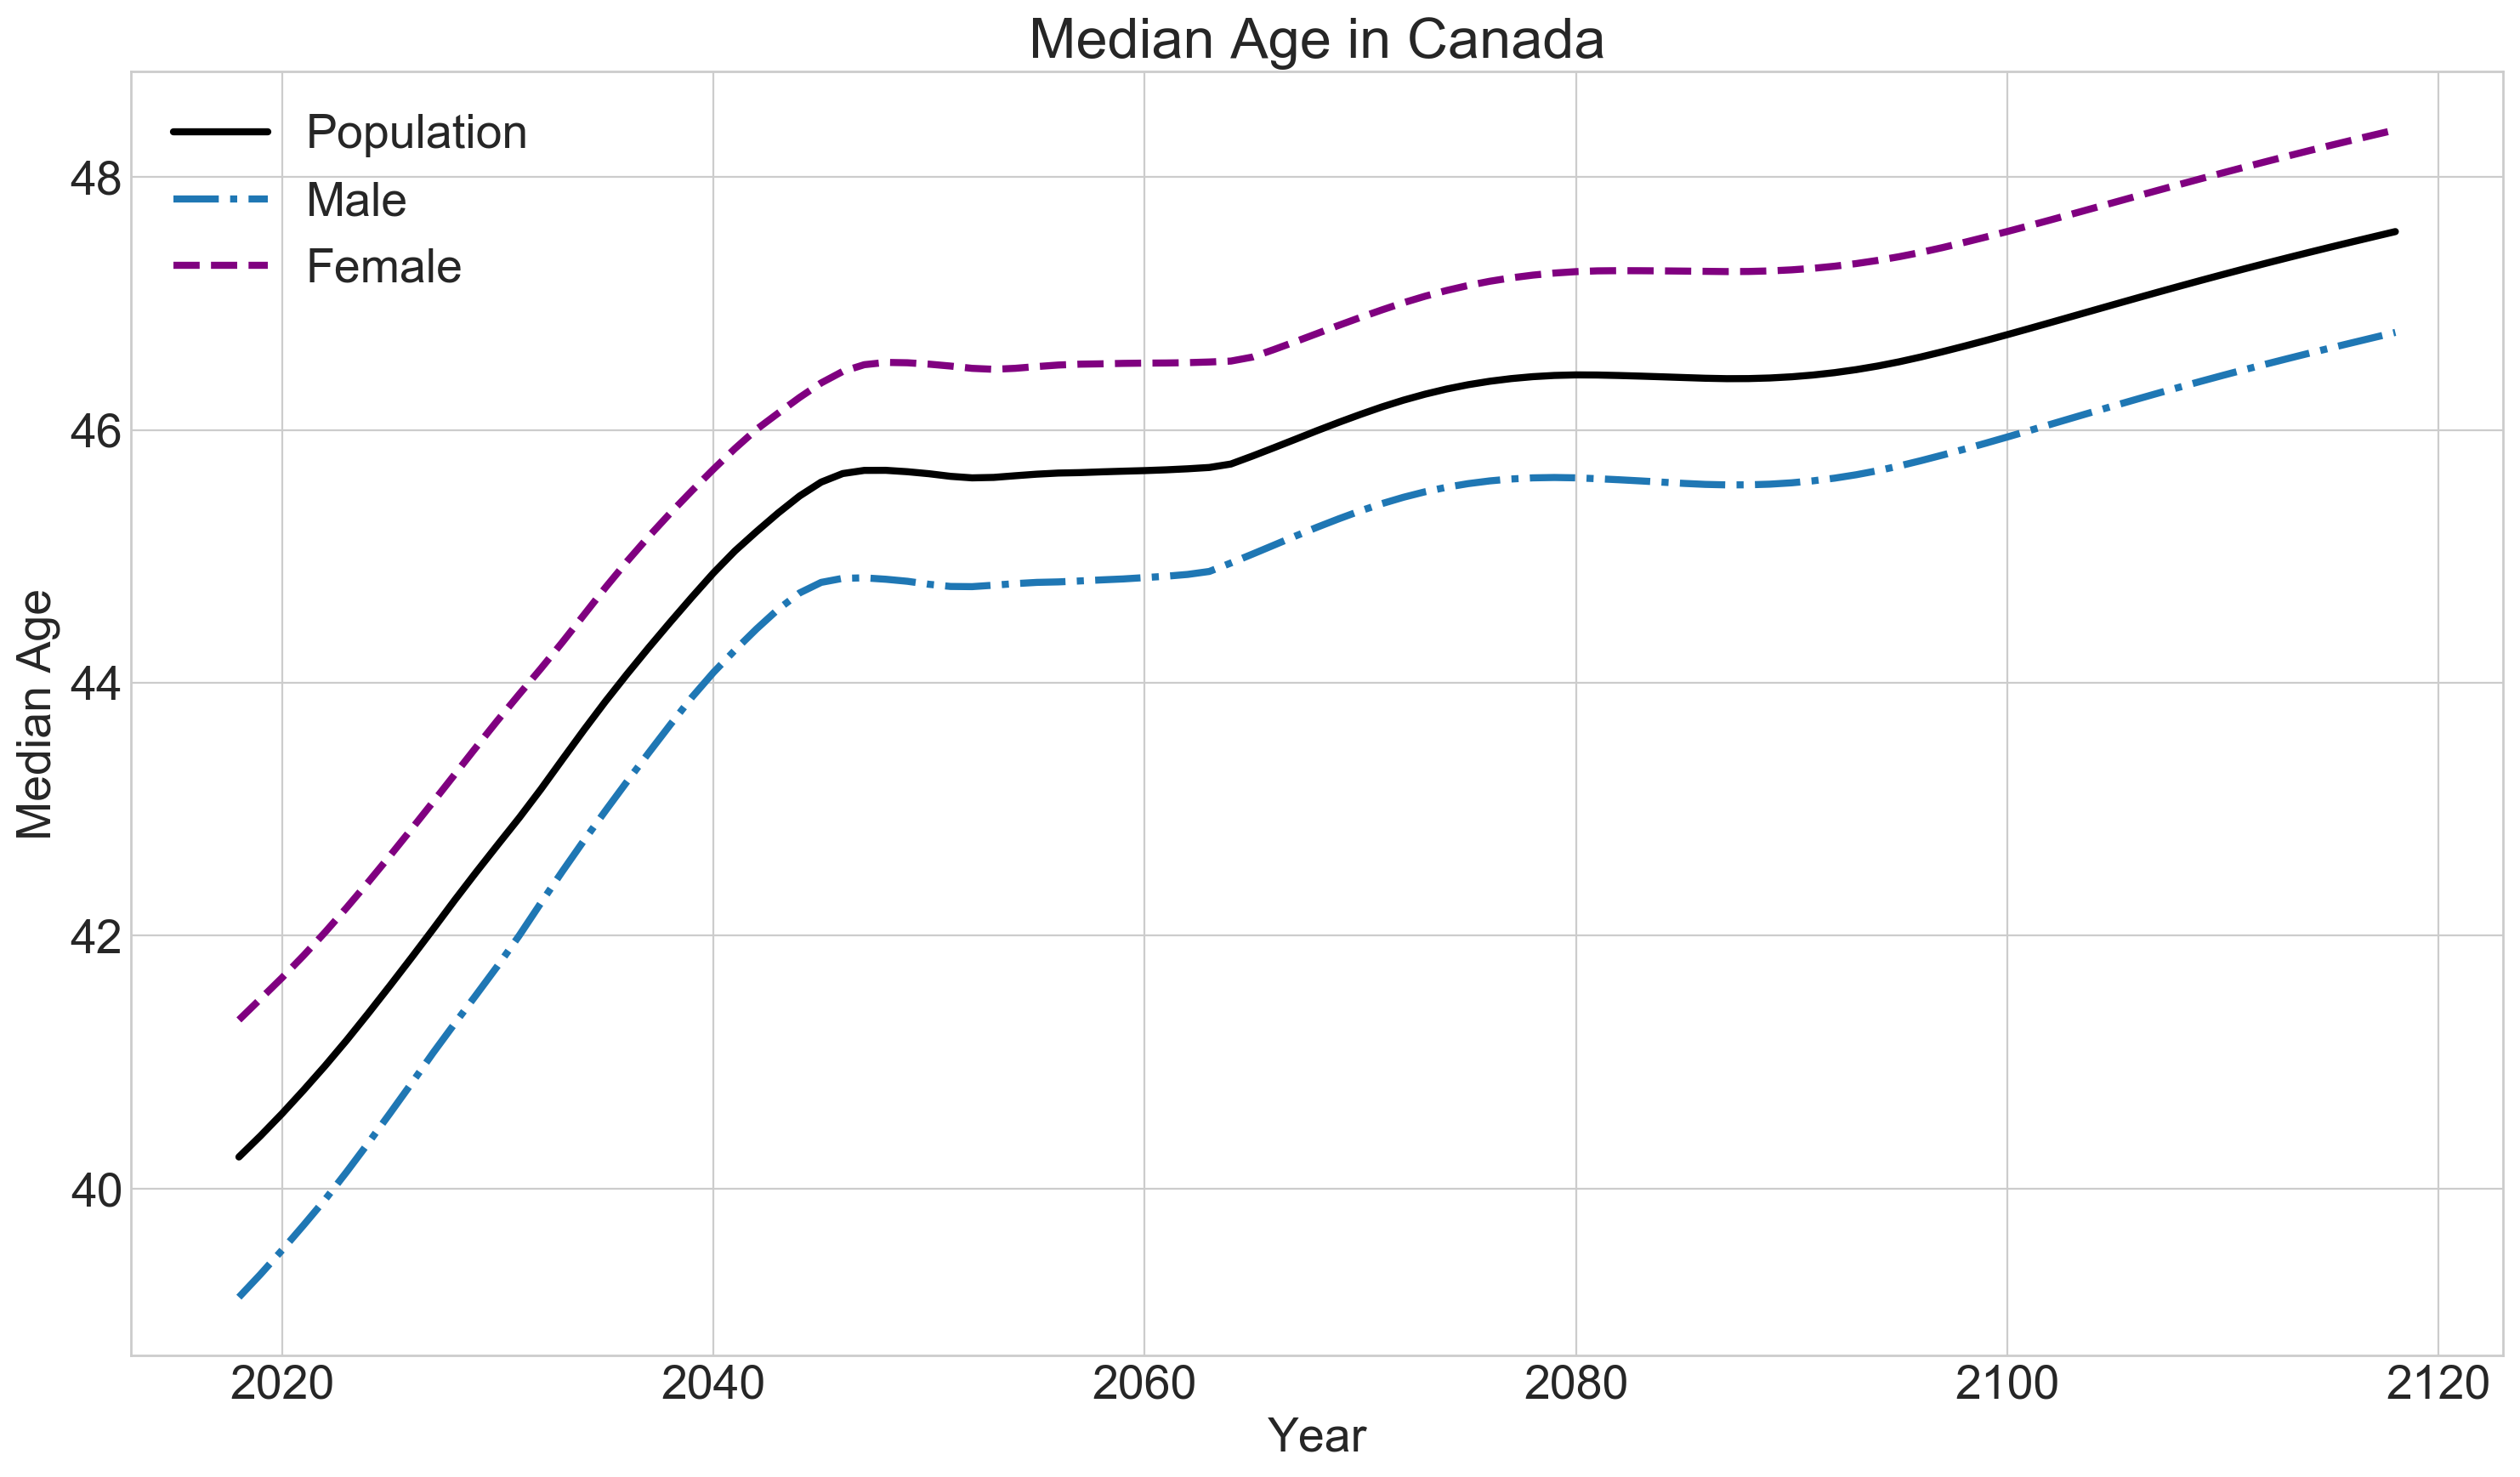

In [46]:
plt.plot(median_age(male_pop + female_pop), 'black', label= 'Population')
plt.plot(median_age(male_pop),'-.', label = 'Male')
plt.plot(median_age(female_pop),'--', color = 'purple', label = 'Female')
plt.xlabel('Year')
plt.ylabel('Median Age')
plt.title('Median Age in Canada')
plt.legend()
plt.show()

In [47]:
def youth_working_elderly(df):
    
    youth = pd.DataFrame(index=df.index, columns=df.columns)
    working = pd.DataFrame(index=df.index, columns=df.columns)
    elderly = pd.DataFrame(index=df.index, columns=df.columns)
    pop_groups = pd.DataFrame()
    
    number_of_cohorts = len(df.columns)
    
    cohorts = df.columns.tolist()
    
    for i in range(simulated_years_pop()):
        year = first_year_pop()+i
        
        #Note: working_age is 18, but when calculating the working population we start at age 20
        for j in range(number_of_cohorts):
            age = year-cohorts[j]
            if age < working_age()+2:
                youth.loc[year,cohorts[j]] = df.loc[year,cohorts[j]]
            
            elif (age >= working_age()+2) & (age < retirement_age()): 
                working.loc[year,cohorts[j]] = df.loc[year,cohorts[j]]
            
            else: 
                elderly.loc[year,cohorts[j]] = df.loc[year,cohorts[j]]
    
    youth = youth.fillna(0).sum(axis=1)/df.sum(axis=1)
    working = working.fillna(0).sum(axis=1)/df.sum(axis=1)
    elderly = elderly.fillna(0).sum(axis=1)/df.sum(axis=1)
    
    dep_ratio = working/elderly
    pop_groups = pop_groups.assign(Youth_ratio = youth, Working_ratio = working, Elderly_ratio = elderly)
    
    return pop_groups, dep_ratio

In [48]:
pop_groups, dep_ratio = youth_working_elderly(male_pop + female_pop)

In [49]:
#Found in Table 2 on page 17
def cppib_dep_ratio():
    return pd.Series(data = [3.6, 3.5, 3.4, 3.3, 3.1, 2.8, 2.5, 2.3, 2.3, 2.2, 2.0], \
                                 index =[2018, 2019, 2020, 2021, 2022, 2025, 2030, 2035, 2040, 2050, 2075])
    

[]

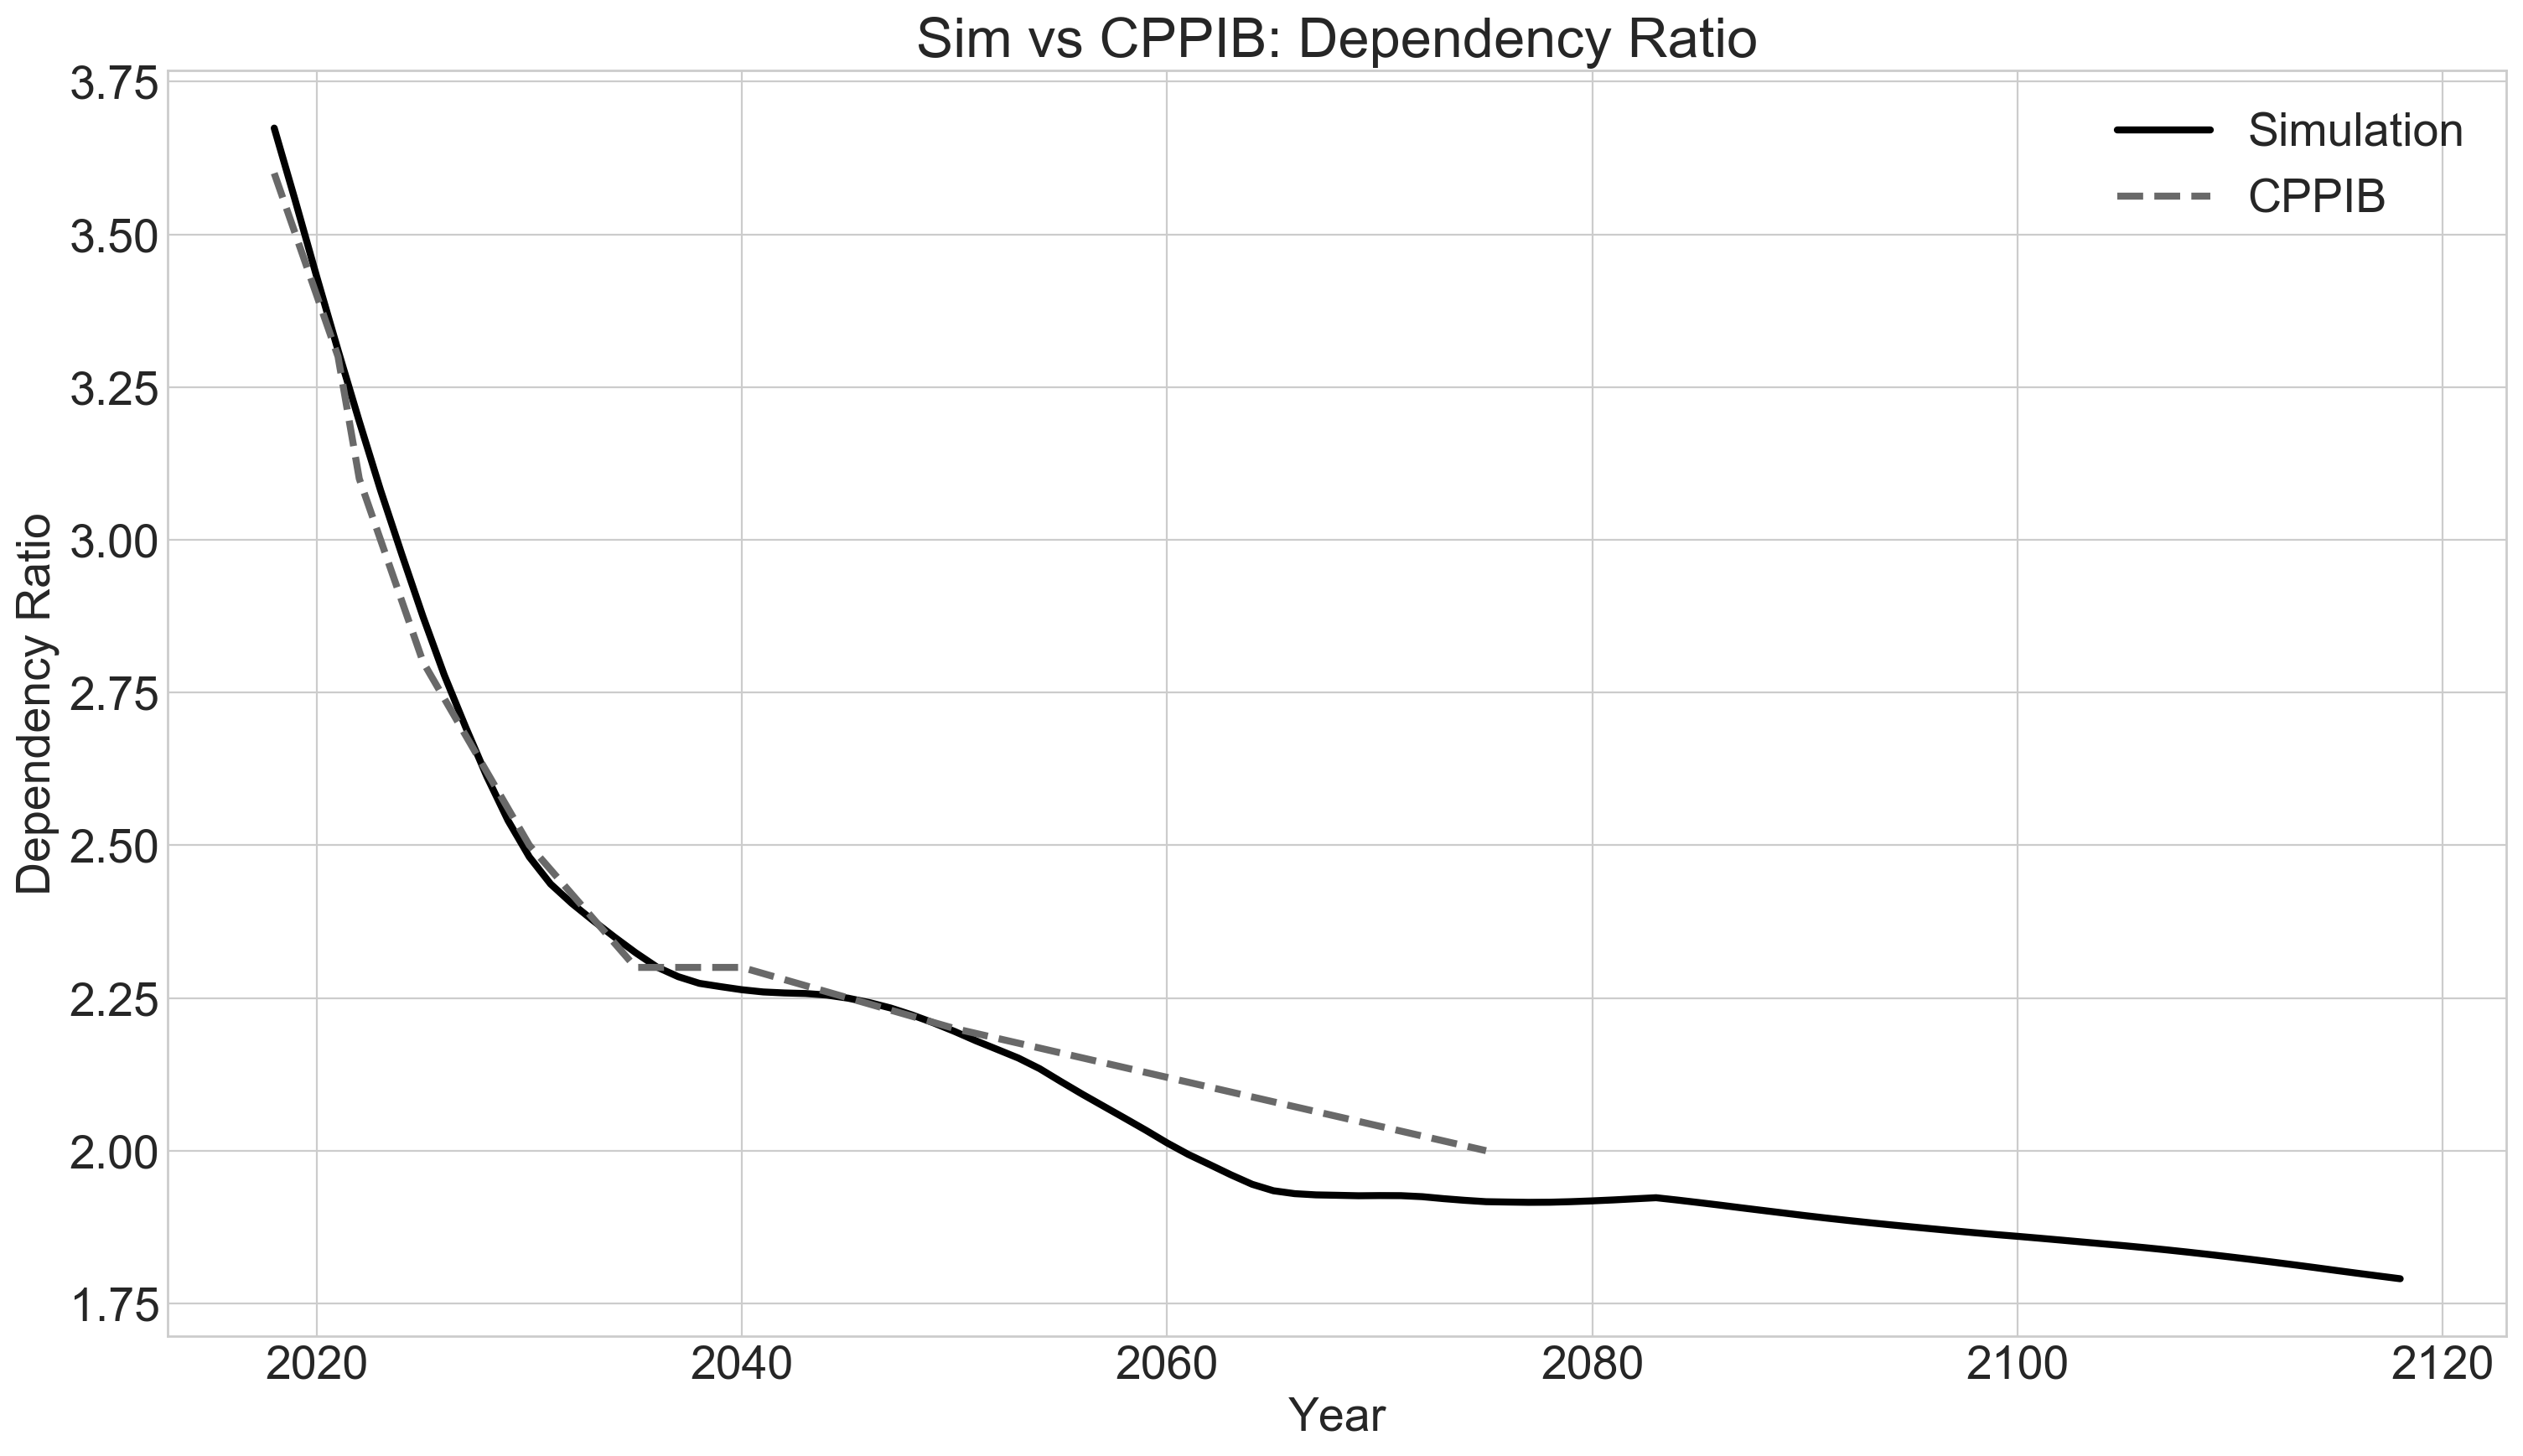

In [50]:
plt.plot(dep_ratio, color = 'black', label = 'Simulation')
plt.plot(cppib_dep_ratio(), '--',color = 'dimgray' ,label = 'CPPIB')
plt.title('Sim vs CPPIB: Dependency Ratio')
plt.legend()
plt.xlabel('Year')
plt.ylabel('Dependency Ratio')
plt.plot()

In [51]:
youth_working_elderly(male_pop + female_pop)[1][2075]

1.916501469958627

More important than total population, is the underlying demographic characteristics of the population. The shape, and magnitude, of the curve matches the CPPIB projection, with the simulation, projecting a dependency ratio of 1.9 in 2075, and the CPPIB projecting 2.0. 

Finally, lets compare the age distribution of the population, including the number of people who are youths (aged 0-19), working-age (20-64), and elderly (65 and over). 

[]

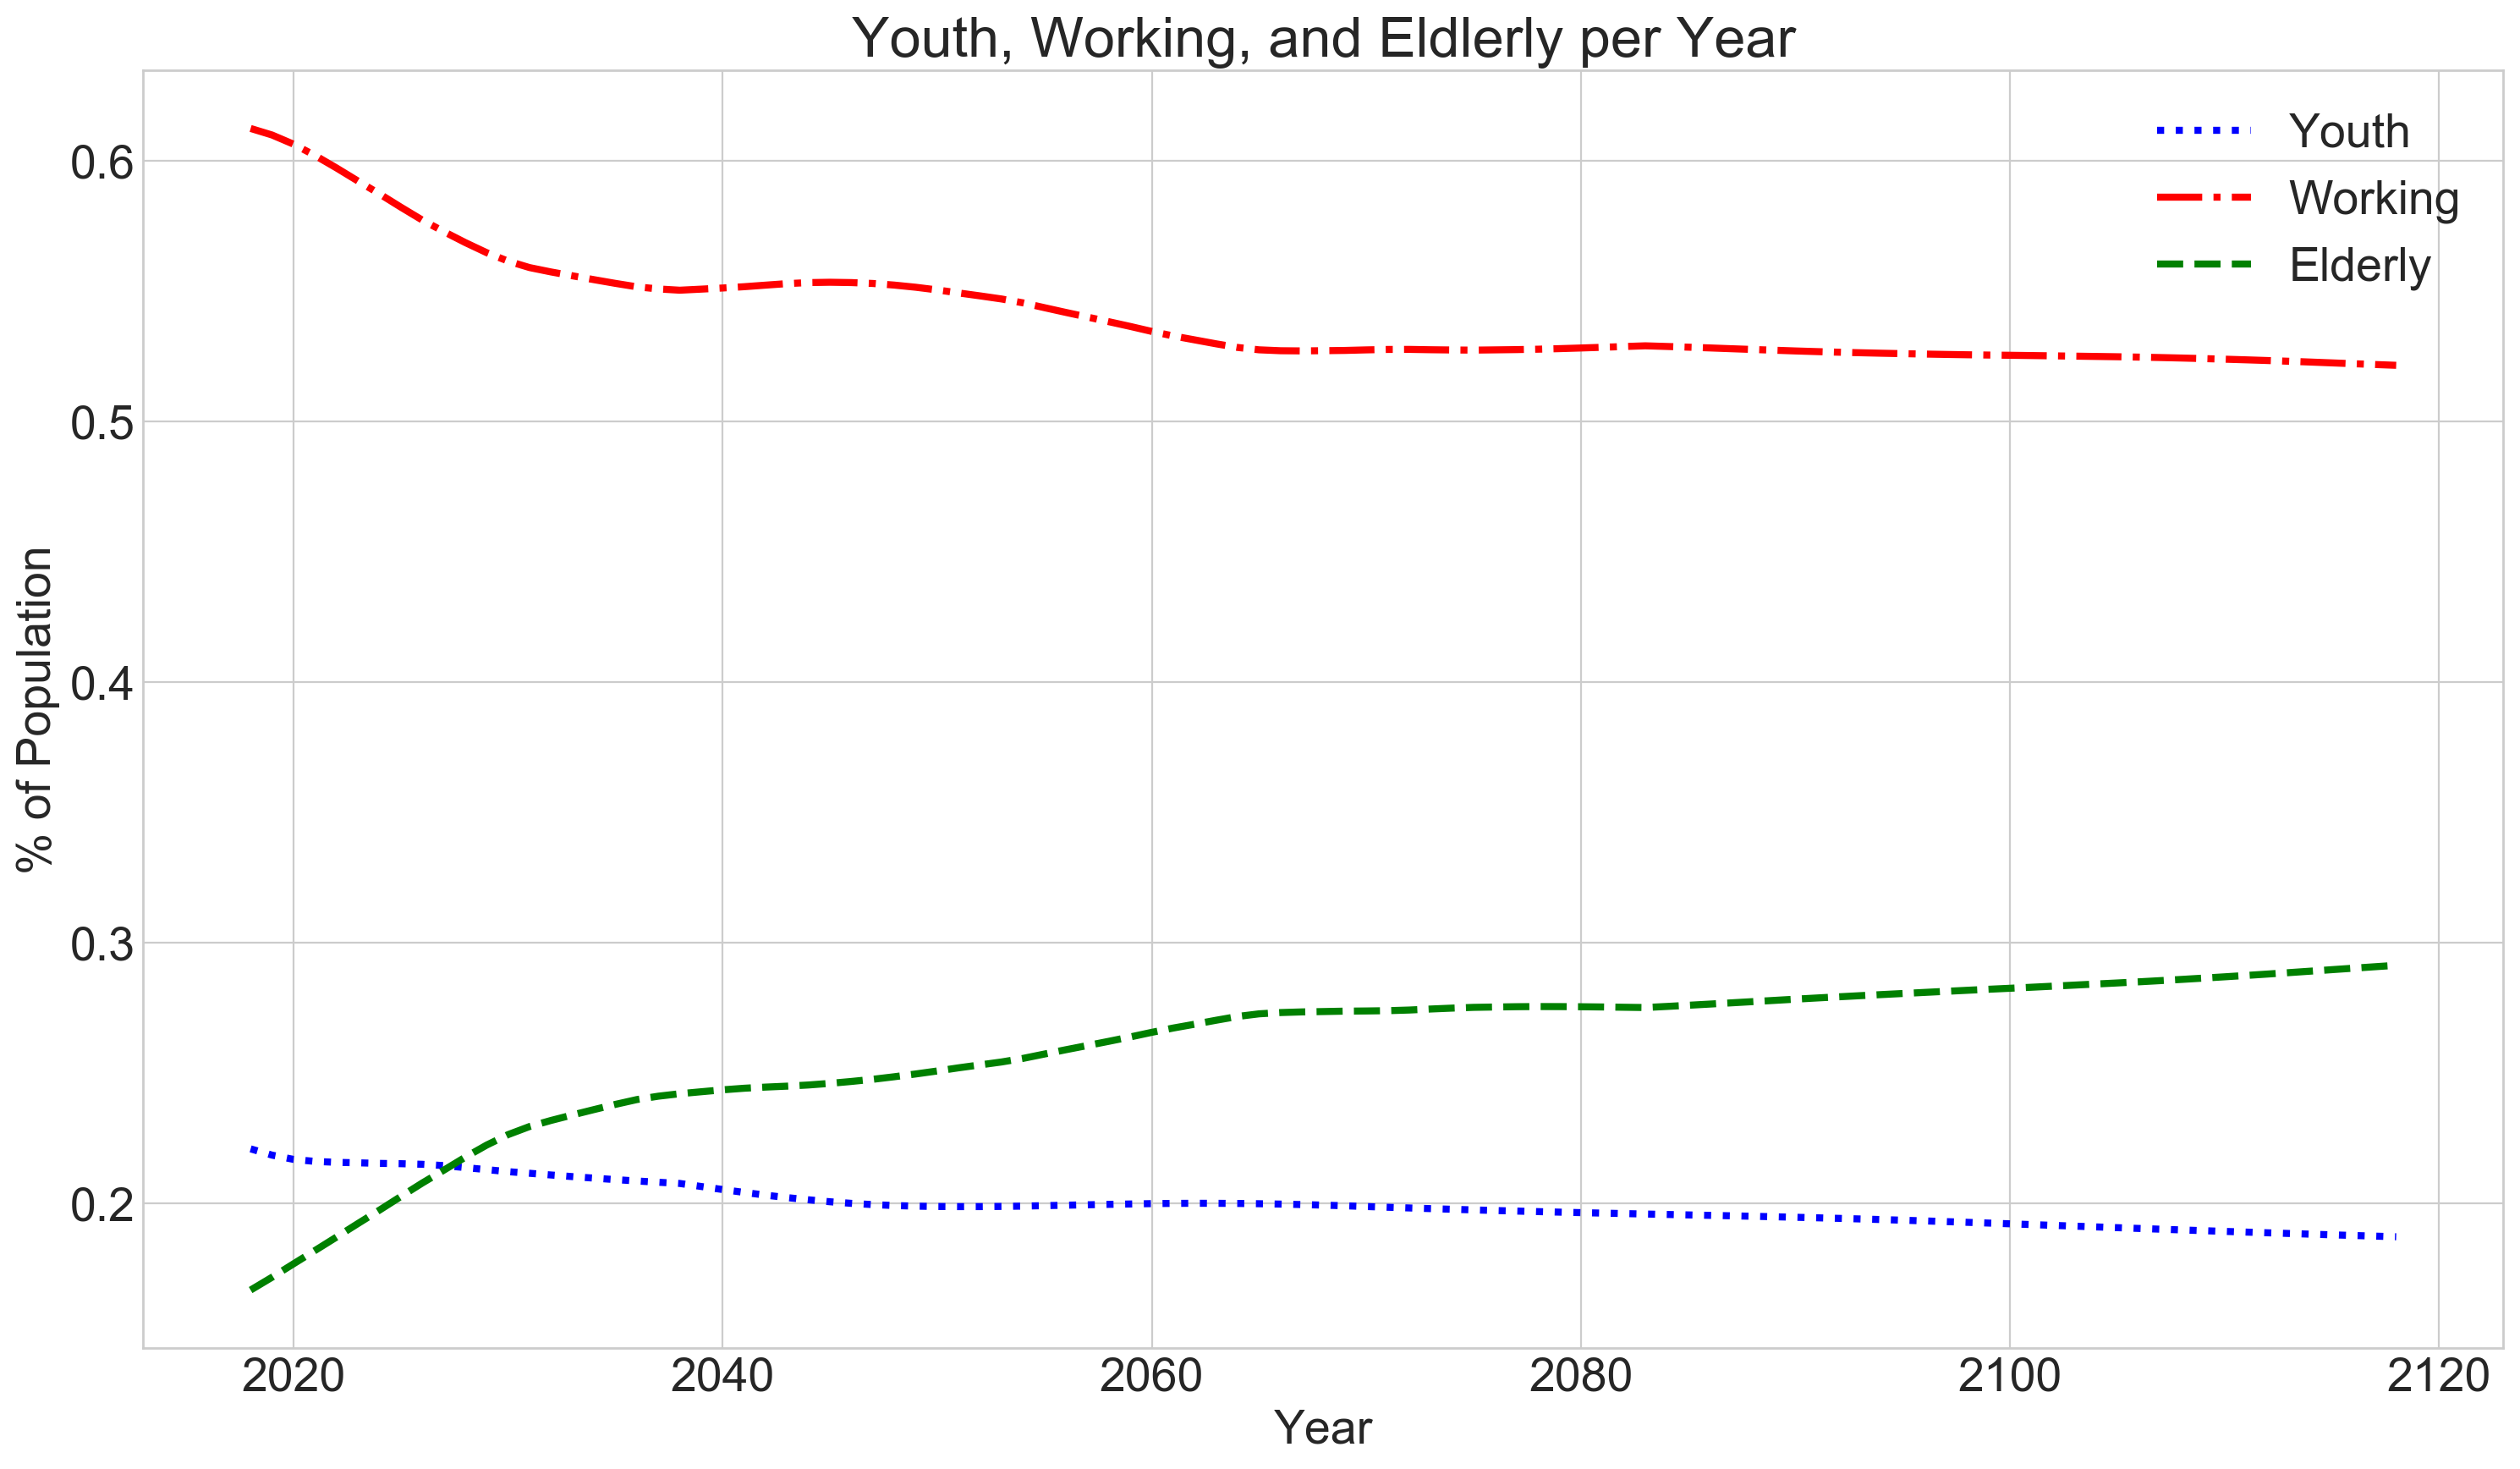

In [52]:
plt.plot(pop_groups.Youth_ratio,':', color = 'b', label='Youth')
plt.plot(pop_groups.Working_ratio,'-.', color = 'r', label='Working')
plt.plot(pop_groups.Elderly_ratio, '--',color = 'g', label='Elderly')
plt.xlabel('Year')
plt.ylabel('% of Population')
plt.title('Youth, Working, and Eldlerly per Year')
plt.legend()
plt.plot()

In [53]:
#Found in Table 2 Page 17
def cppib_working_pop():
    return pd.Series(data = [17631000, 17803000, 17996000, 18481000, 19143000, 20300000, 22824000], 
                          index = [2020, 2025, 2030, 2035, 2040, 2050, 2075])
#Found in Table 2 Page 17
def cppib_elderly_pop():
    return pd.Series(data = [5226000, 6272000, 7313000, 7973000, 8439000, 9264000, 11428000], 
                          index = [2020, 2025, 2030, 2035, 2040, 2050, 2075])

#Found in Table 2 Page 17
def cppib_youth_pop():
    return pd.Series(data = [6295000, 6657000, 6908000, 7090000, 7157000, 7371000, 8488000],
                       index = [2020, 2025, 2030, 2035, 2040, 2050, 2075])

#Found in Table 42 on page 90
def cppib_deaths():
    return pd.Series(data = [206000, 229000, 259000, 296000, 334000, 393000, 448000],
                         index = [2020, 2025, 2030, 2035, 2040, 2050, 2075])

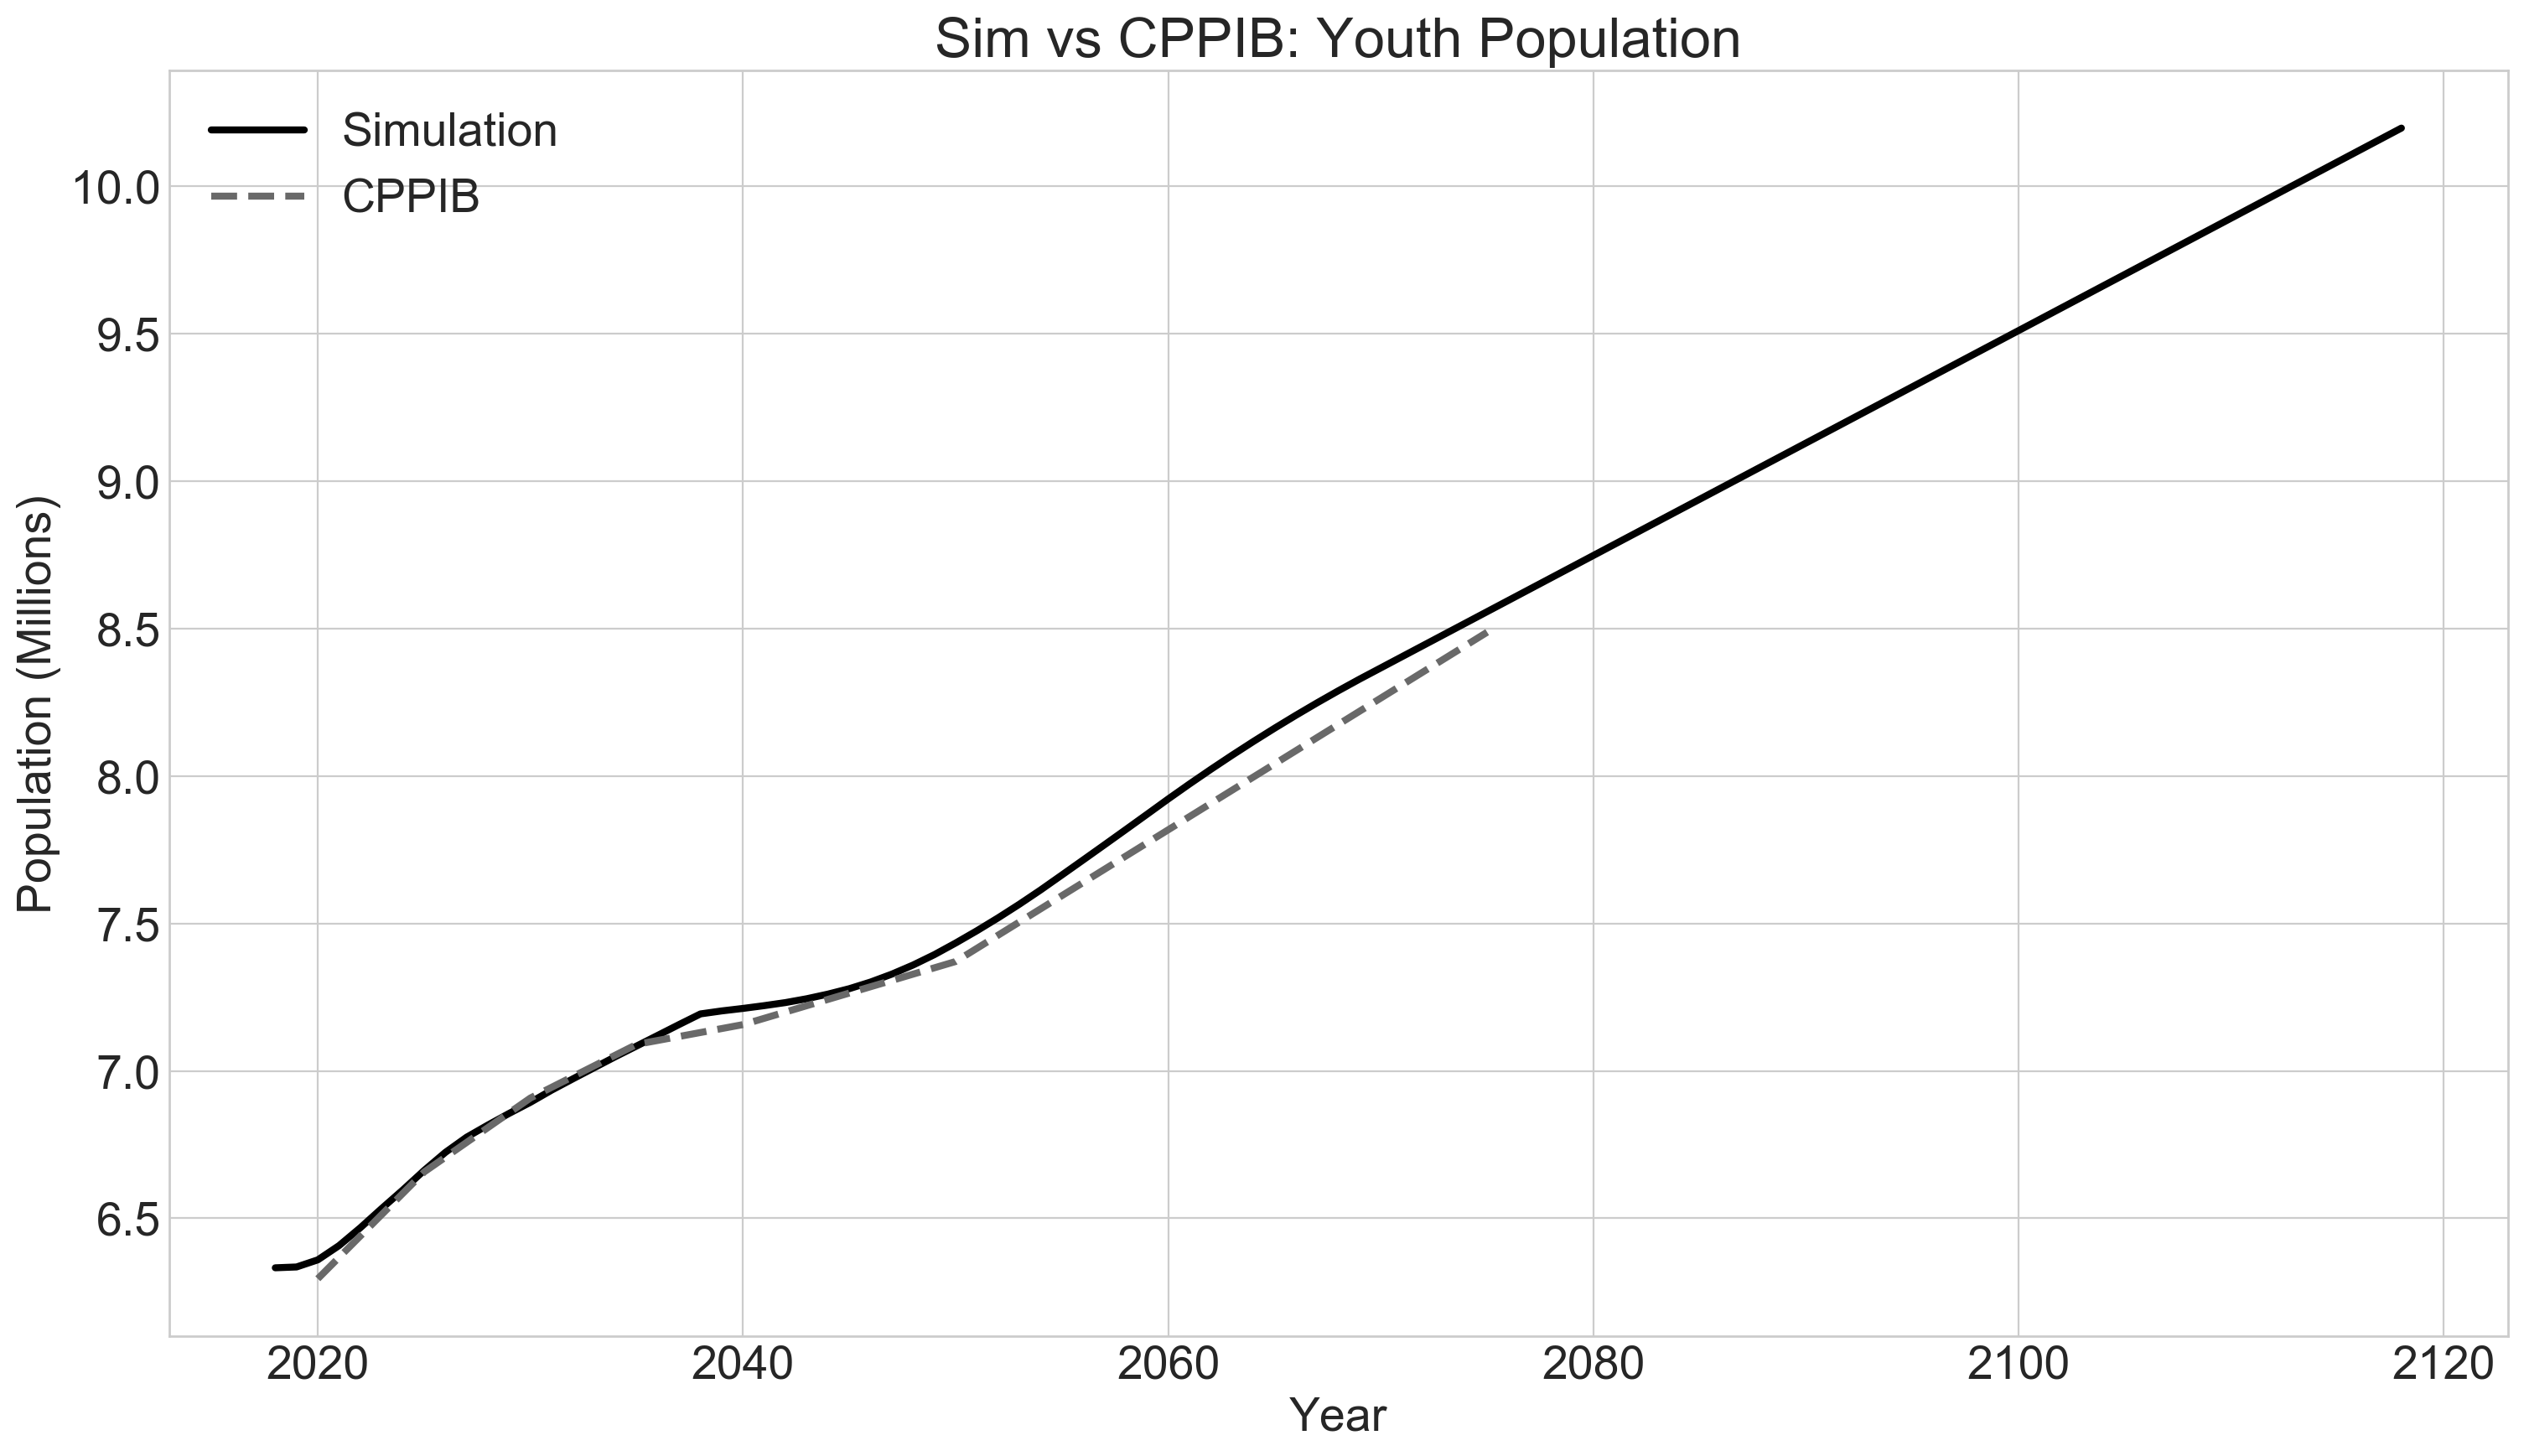

In [54]:
plt.plot(pop_groups.Youth_ratio*total_pop_series/1000000, color = 'black', label = 'Simulation')
plt.plot(cppib_youth_pop()/1000000, '--', color = 'dimgray', label = 'CPPIB')
plt.title('Sim vs CPPIB: Youth Population')
plt.xlabel('Year')
plt.ylabel('Population (Millions)')
plt.legend()
plt.show()

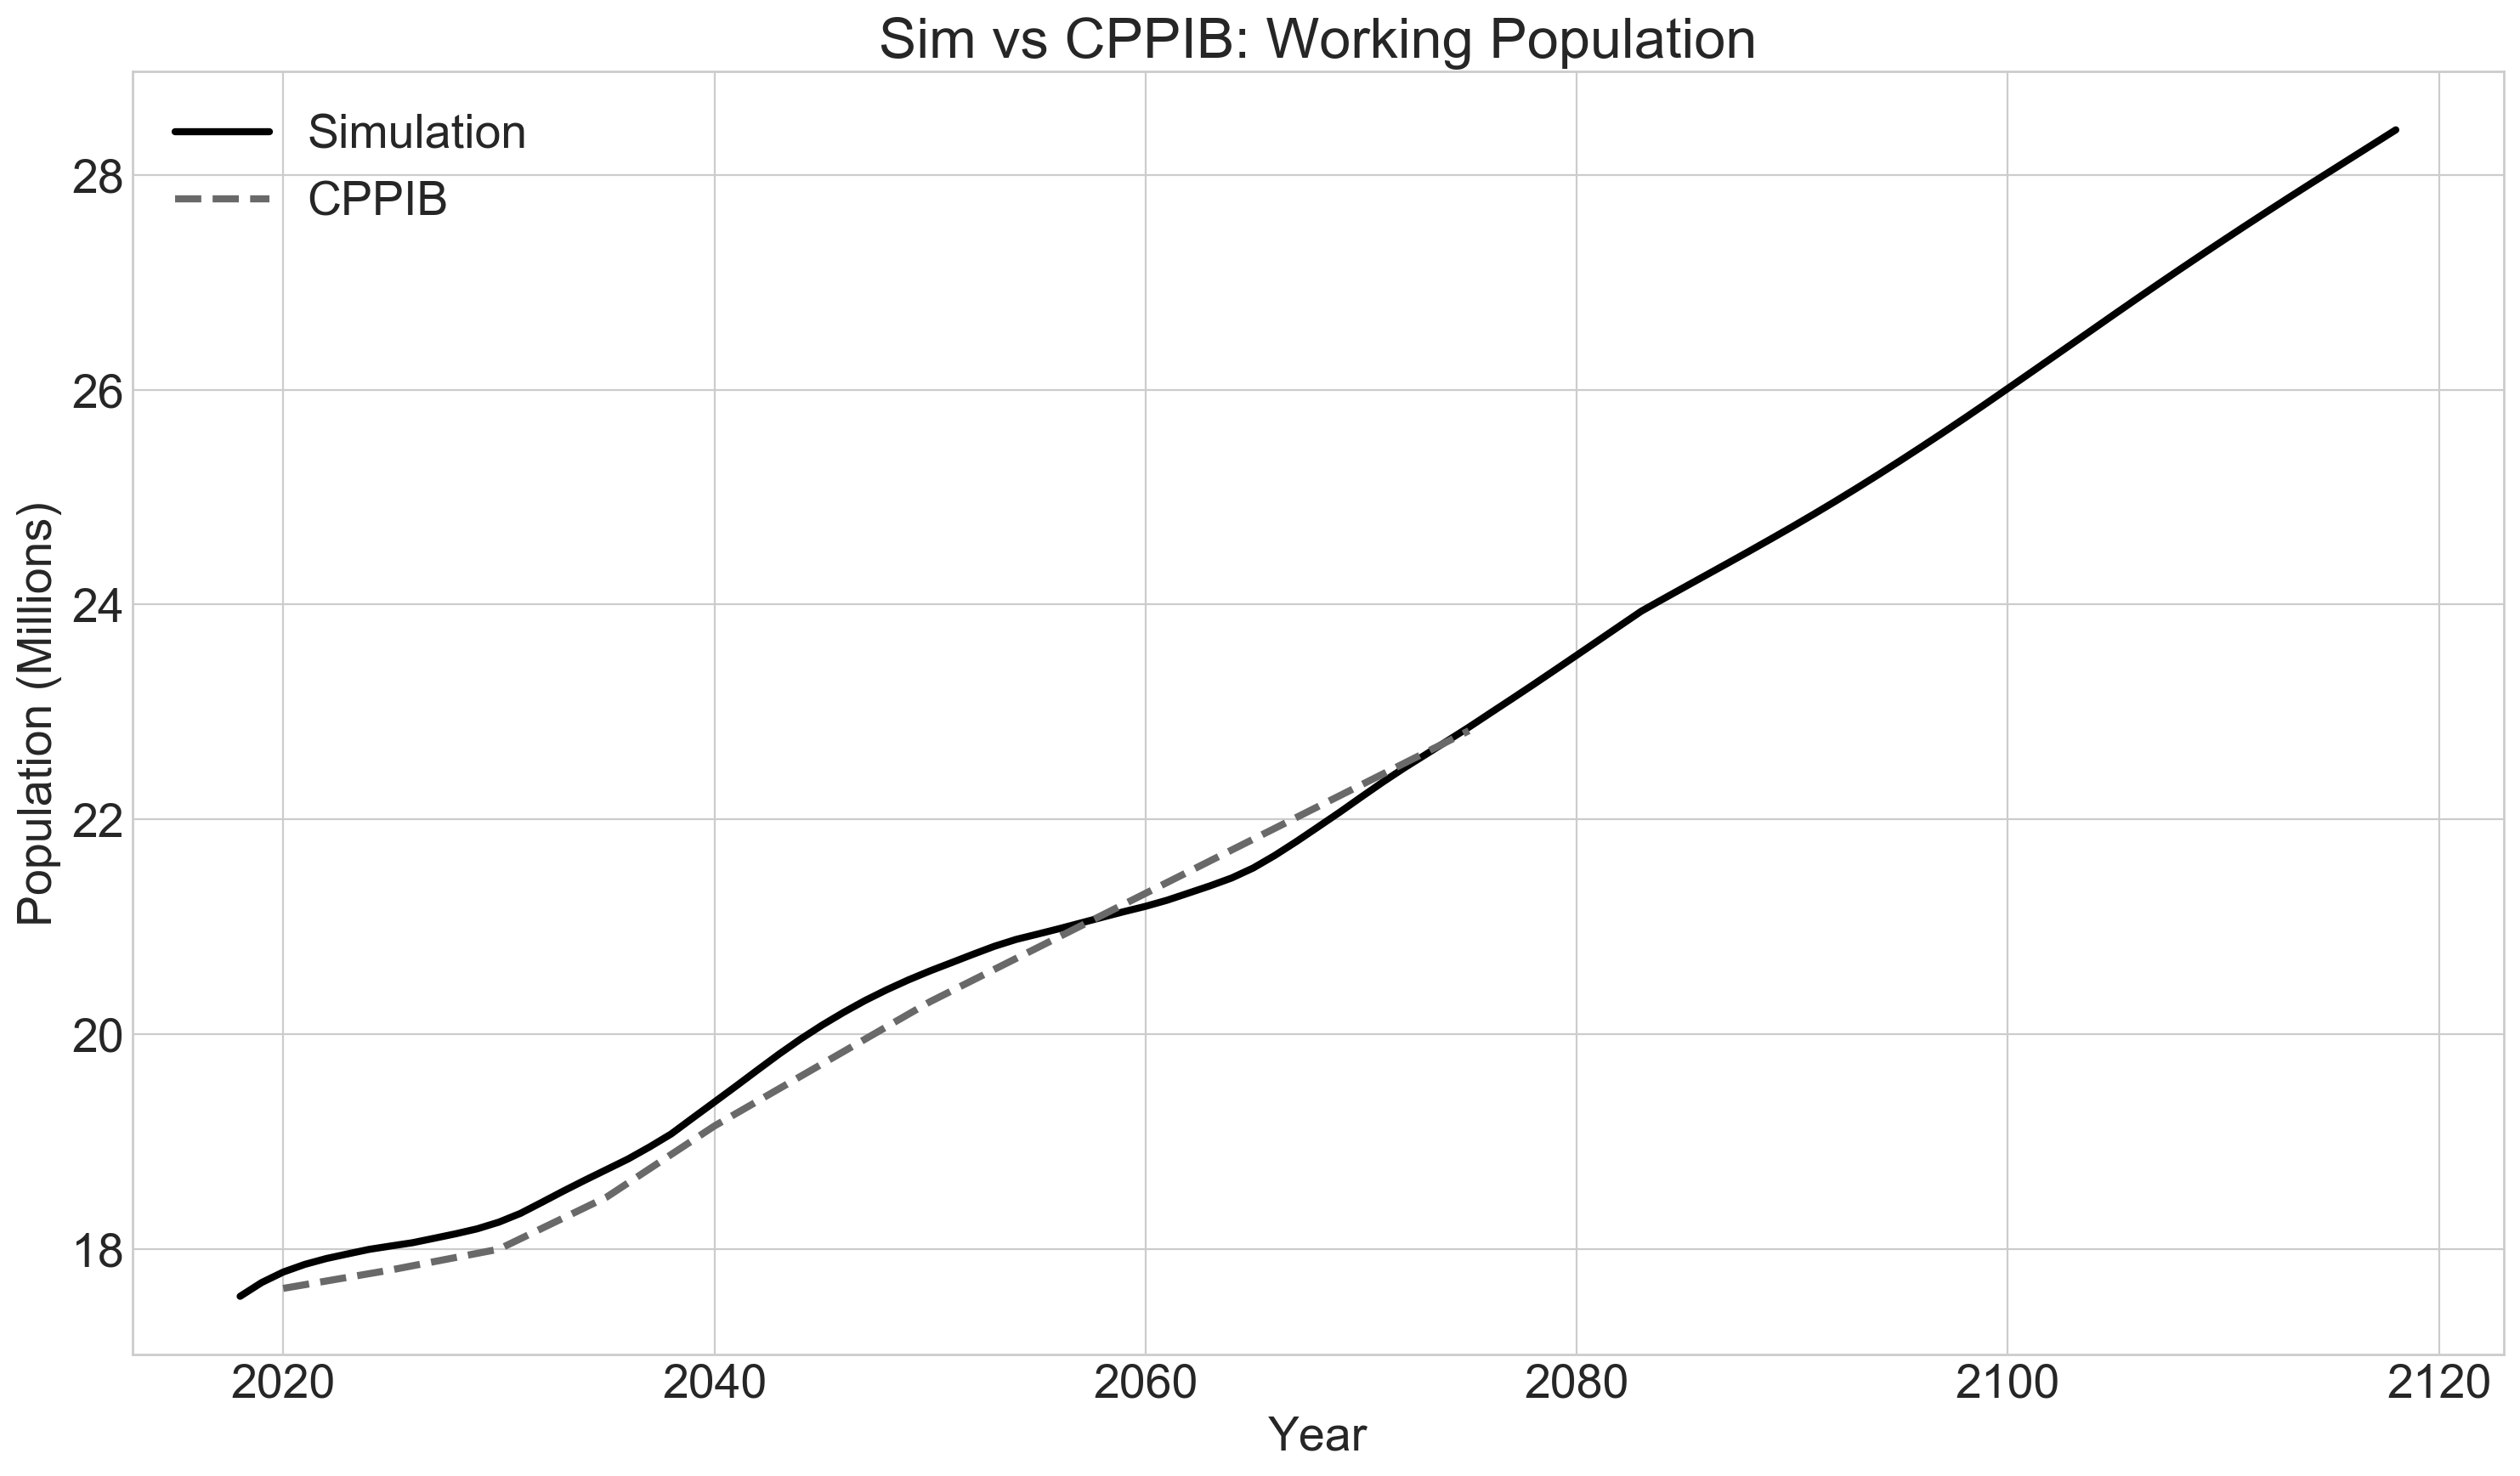

In [55]:
plt.plot(pop_groups.Working_ratio*total_pop_series/1000000, color = 'black', label = 'Simulation')
plt.plot(cppib_working_pop()/1000000, '--', color = 'dimgray', label = 'CPPIB')
plt.title('Sim vs CPPIB: Working Population')
plt.xlabel('Year')
plt.ylabel('Population (Millions)')
plt.legend()
plt.show()

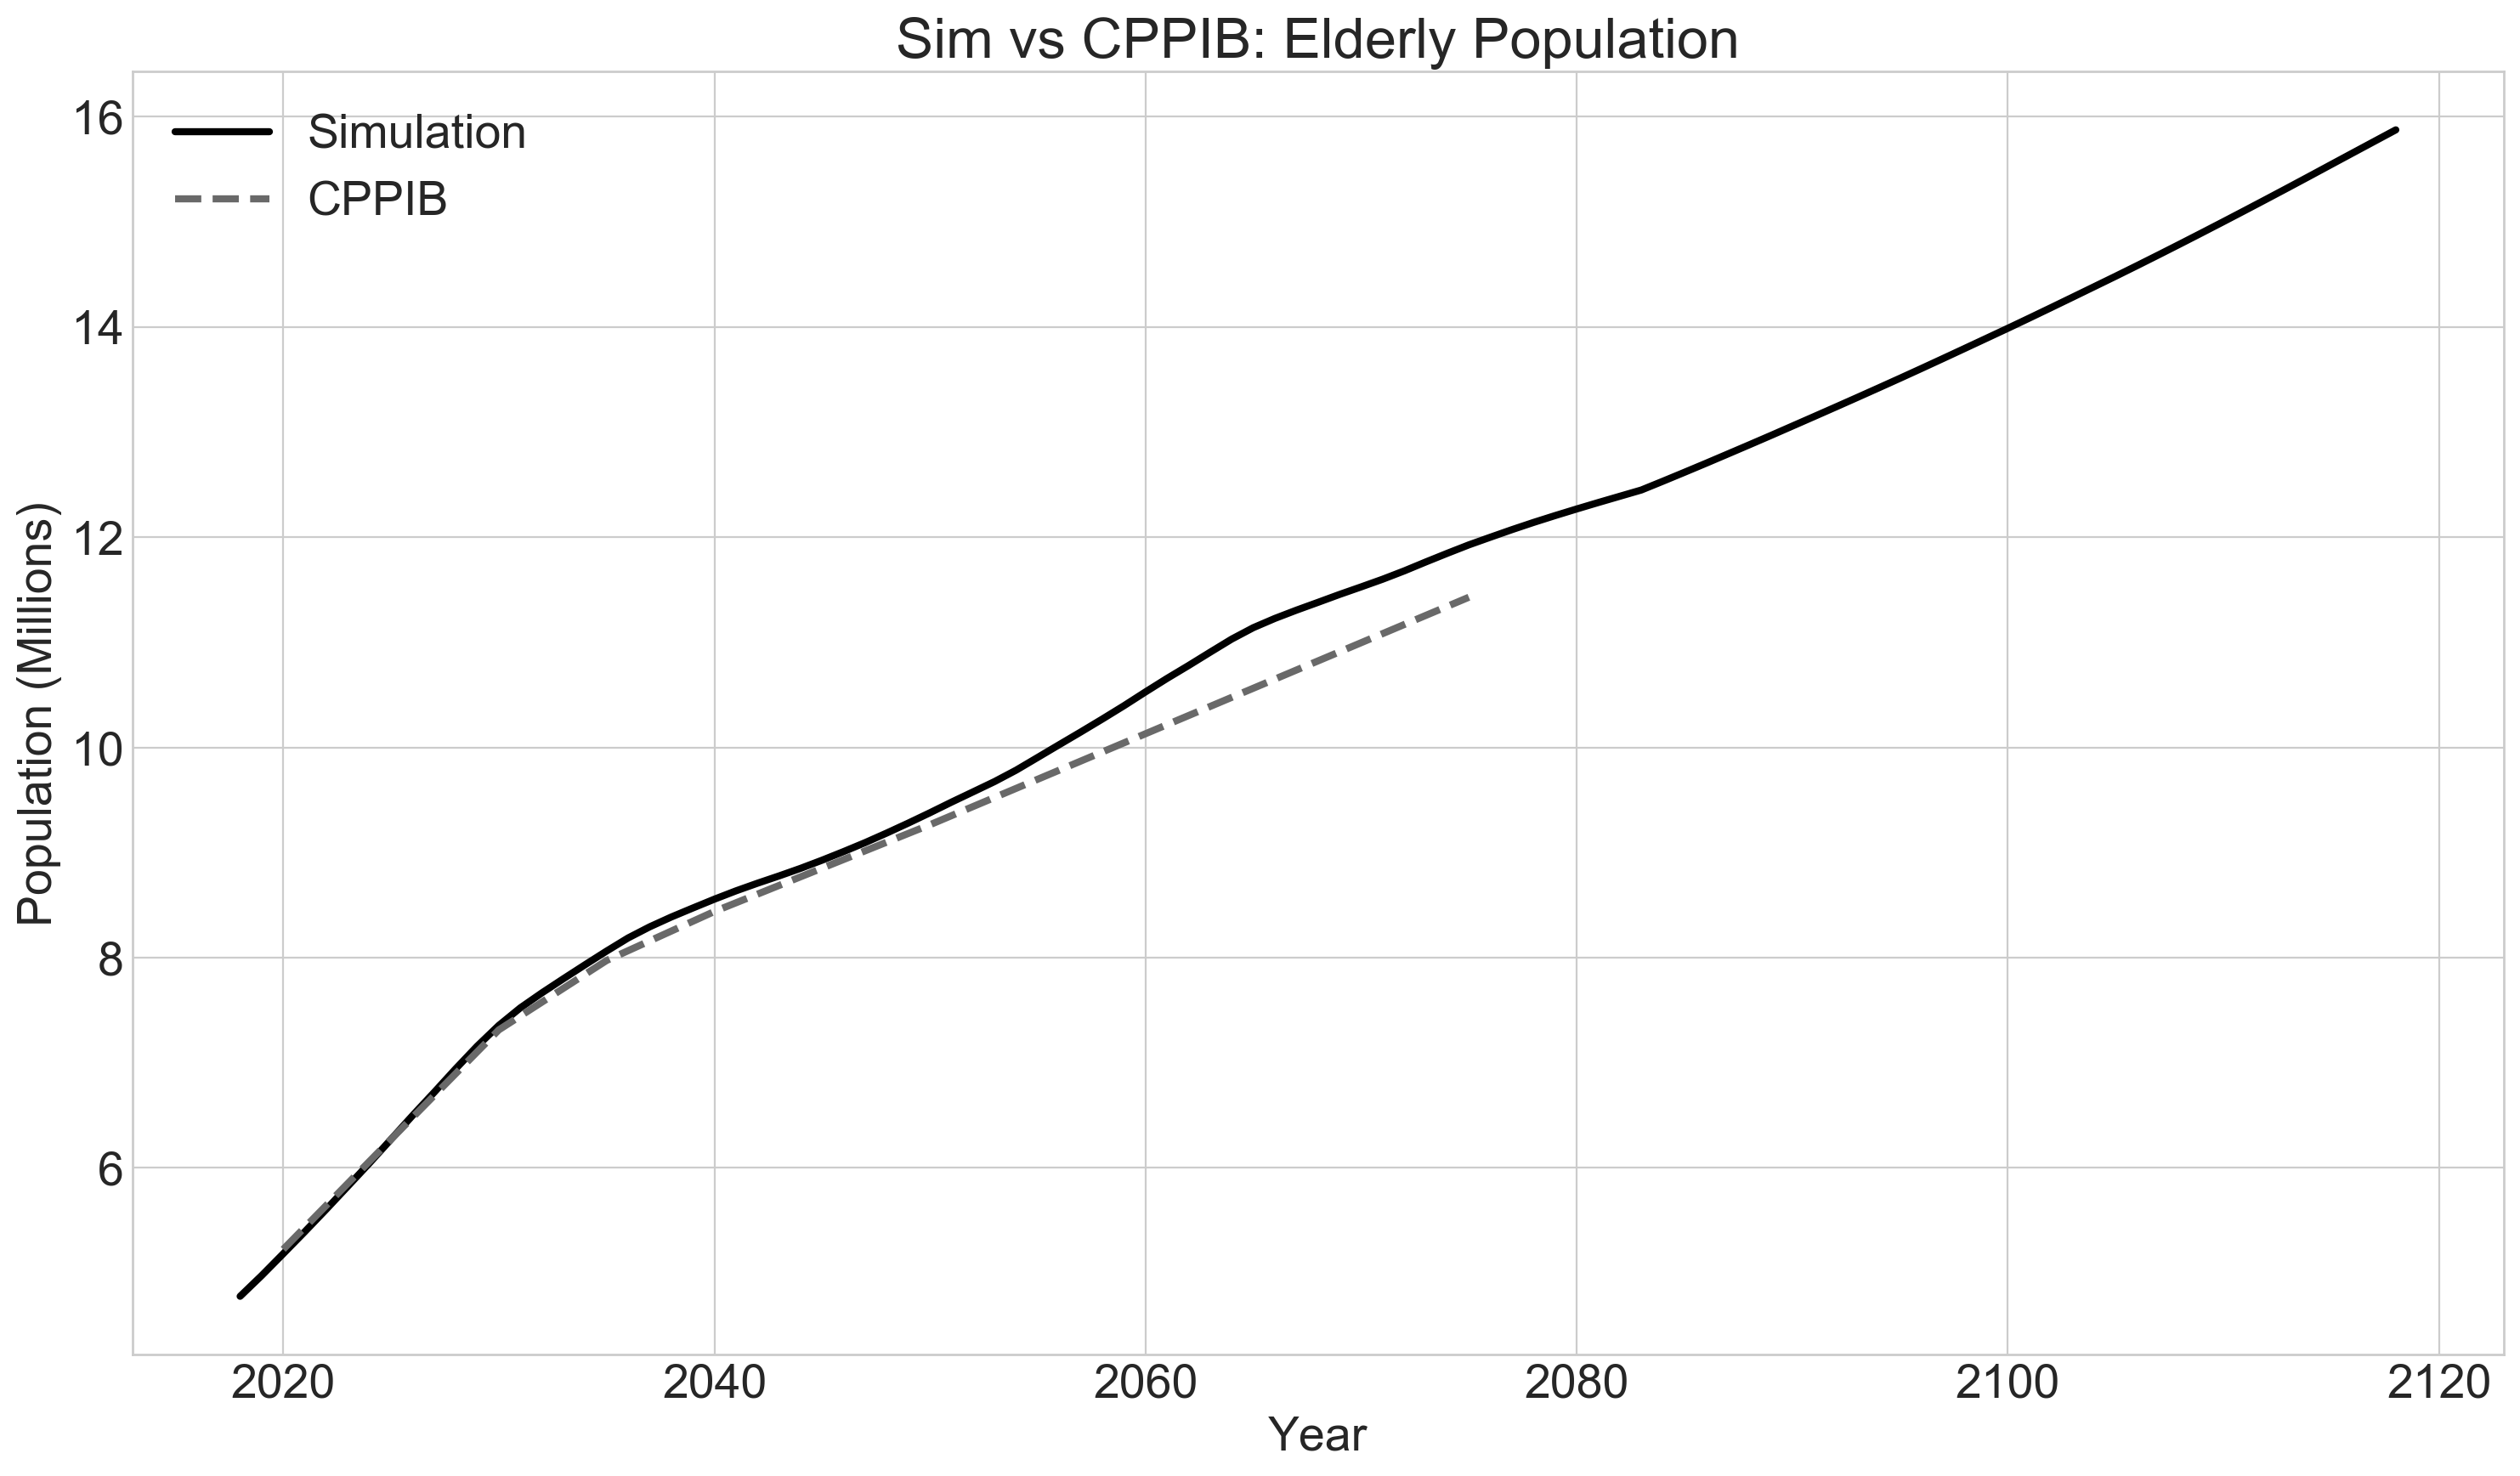

In [56]:
plt.plot(pop_groups.Elderly_ratio*total_pop_series/1000000, color = 'black', label = 'Simulation')
plt.plot(cppib_elderly_pop()/1000000, '--', color = 'dimgray', label = 'CPPIB')
plt.title('Sim vs CPPIB: Elderly Population')
plt.xlabel('Year')
plt.ylabel('Population (Millions)')
plt.legend()
plt.show()

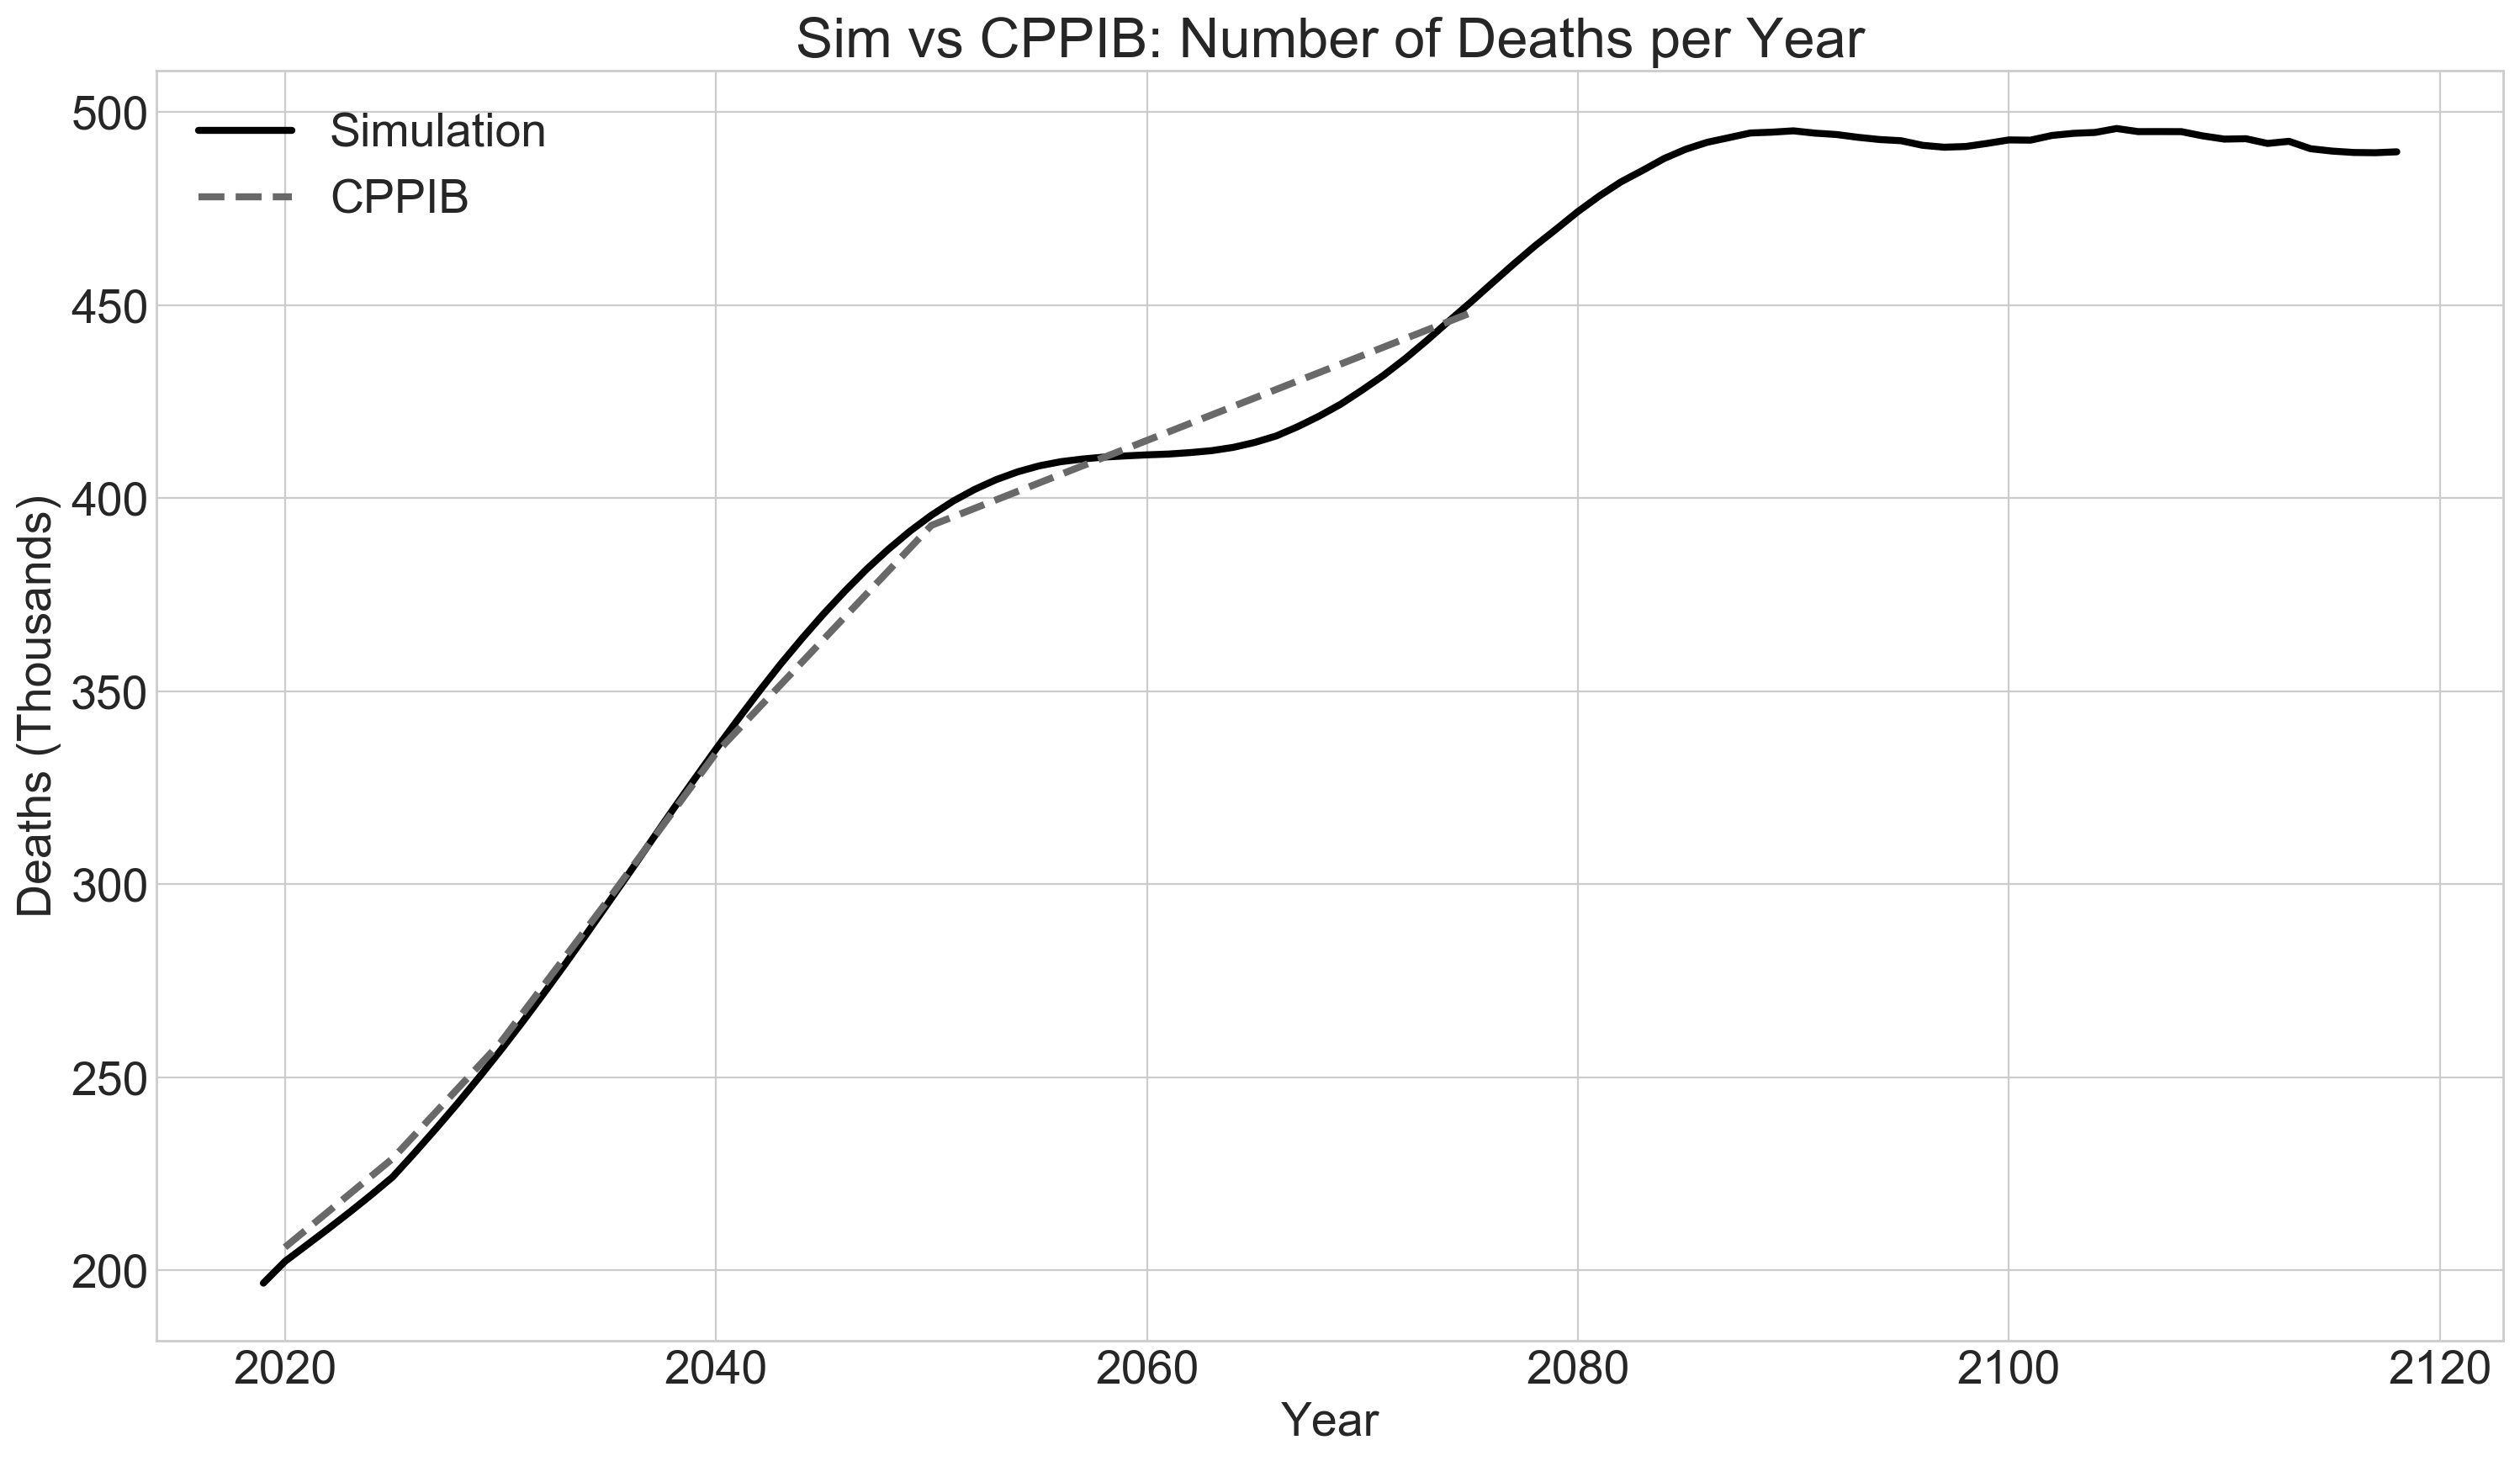

In [57]:
plt.plot(death_series[1:]/1000, color = 'black', label = 'Simulation')
plt.plot(cppib_deaths()/1000, '--', color = 'dimgray', label = 'CPPIB')
plt.xlabel('Year')
plt.ylabel('Deaths (Thousands)')
plt.title('Sim vs CPPIB: Number of Deaths per Year')
plt.legend()
plt.show()

Overall, based on the charts above, we can conclude that the population model generally follows the same trends of that provided by the CPPIB. 

Finally, lets take a look at the population pyramid in 2018, 2050, and 2100. 

In [58]:
def population_pyramid(year):
    pyramid_year = year
    male_pyramid = []
    female_pyramid = []
    labels = []
    
    for j in range(max_years_lived()):
        starting_period = pyramid_year - j
        ending_period = pyramid_year - j - 1
        male_pyramid.append(male_pop.loc[pyramid_year, starting_period])
        female_pyramid.append(female_pop.loc[pyramid_year, starting_period])
        labels.append(j)

    fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(6,6))

    axes[0].barh(labels, male_pyramid, height=1, align='center', label = 'Male')
    axes[0].set(title='Male Population')
    axes[1].barh(labels, female_pyramid, height=1,align='center', color='purple', label = 'Female')
    axes[1].set(title='Female Population')
    axes[0].set(ylabel='Age')
    axes[0].invert_xaxis()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

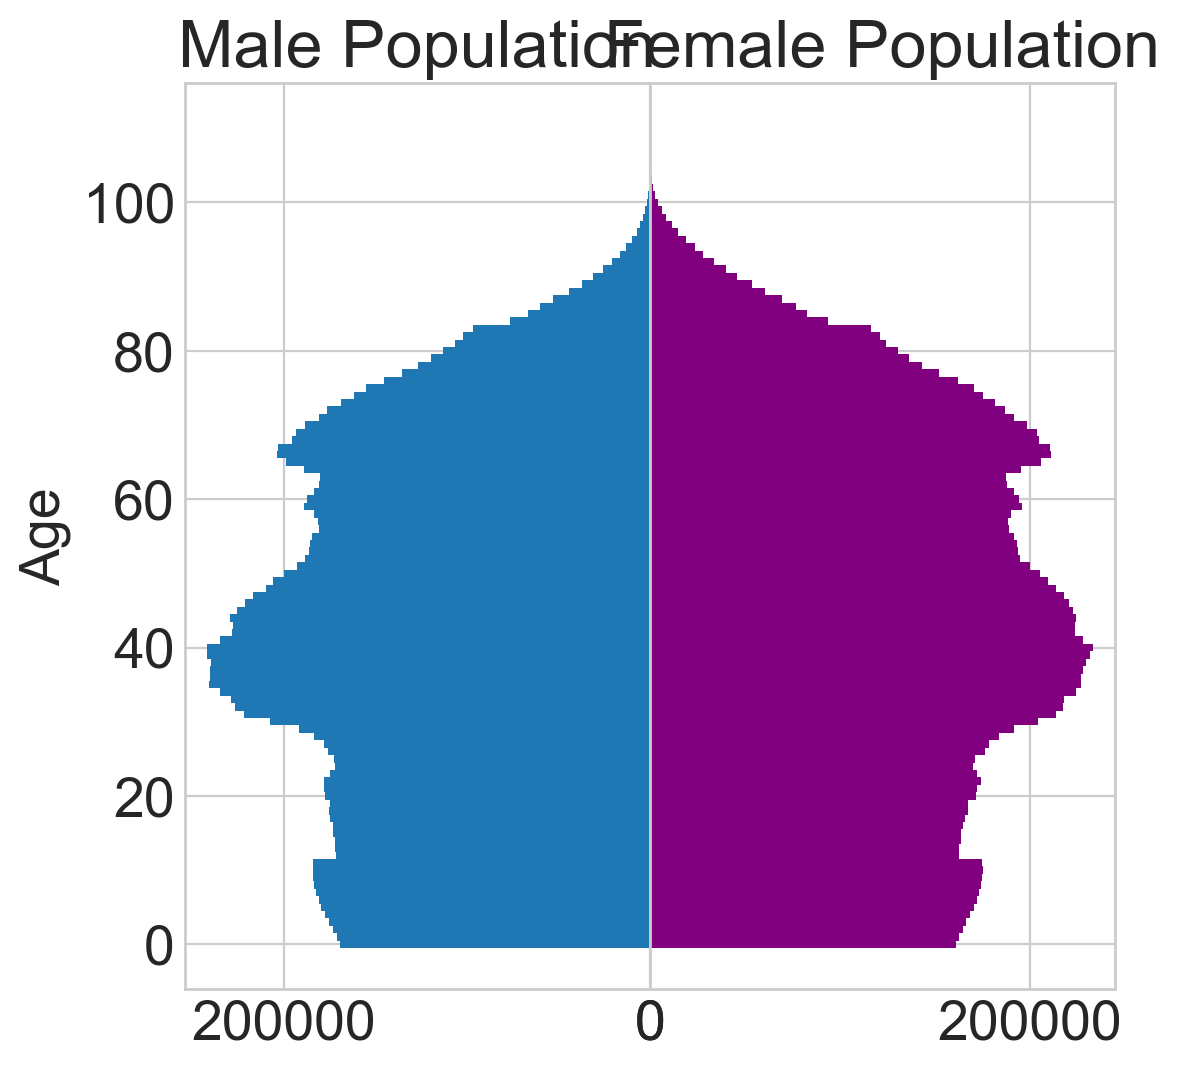

In [59]:
#Population Pyramid in 2030
population_pyramid(2030)

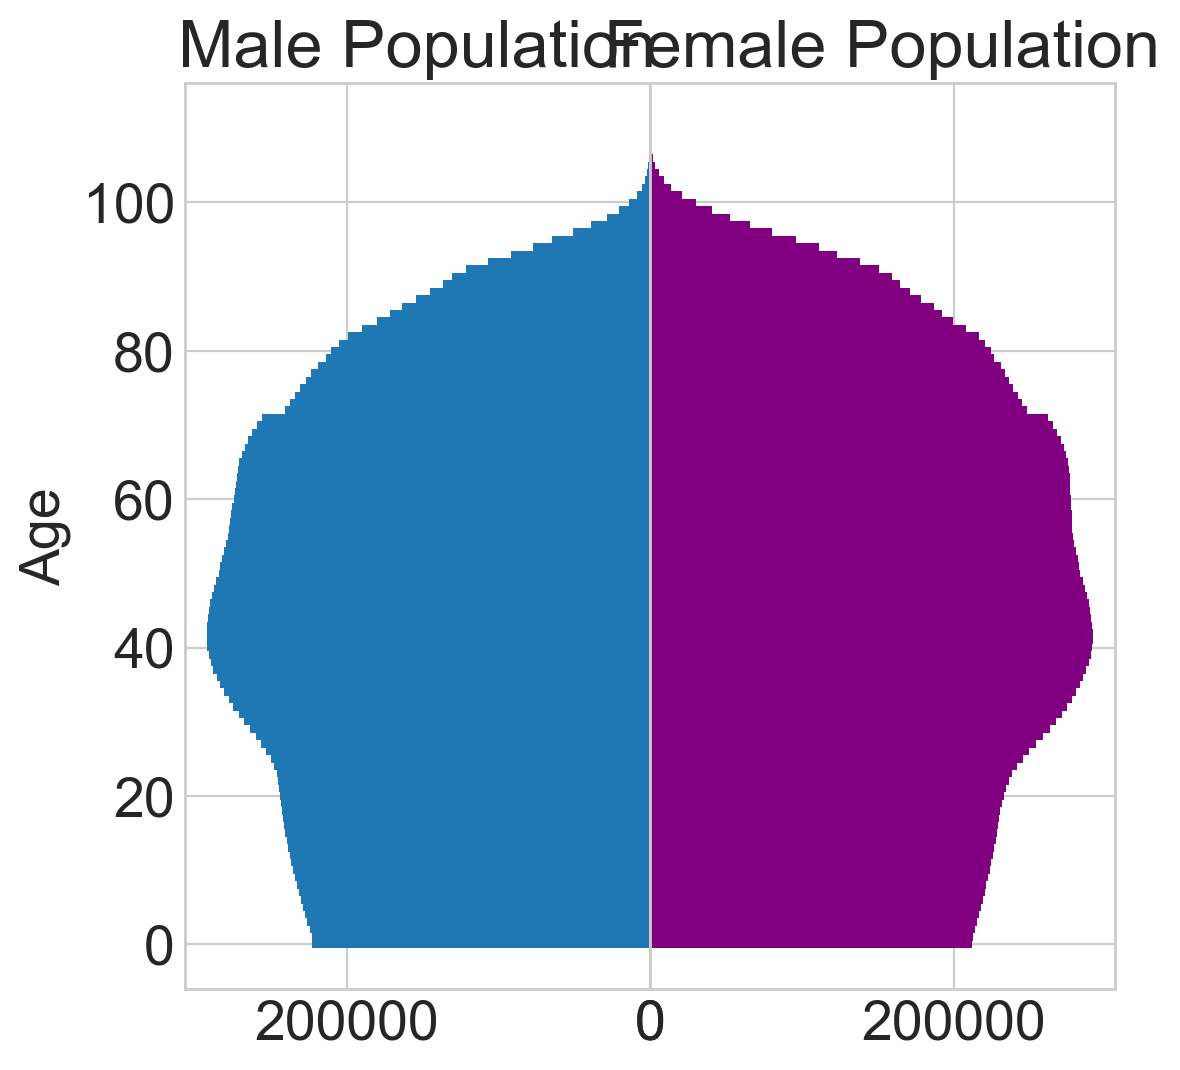

In [60]:
#Population Pyramid in 2090
population_pyramid(2090)

## Section 2:  Economic Parameters

The four main economic parameters that are: 
1. Labour force participation
2. Average pensionable income
3. Inflation
4. Productivity

### Section 2.1 Labour Force Participation

The CPPIB assumes that labor force participation increases each year for men and women. They provide charts showing the participation rates in 2016, and 2050, for ages 15 - 65. This next section turns these charts, interpolates the data to get a smooth curve, and creates a projection of labour force participation for men and women until the year 2118. 

In [61]:
#List of ages used in the charts of the CPPIB report
def cppib_ages():
    return [15 + i*5 for i in range(11)]

In [62]:
#All figures found in Table 48 on page 98
def cppib_male_lfpr_2016():
    return pd.Series(data = [0.47, 0.77,0.898, 0.926, 0.927, 0.928, 0.914, 0.882, 0.801, 0.617, 0.5], index = cppib_ages())

def cppib_male_lfpr_2050():
    return pd.Series(data = [0.545, 0.817, 0.92, 0.94, 0.94, 0.94, 0.93, 0.91, 0.845, 0.651, 0.51], index = cppib_ages())

def cppib_female_lfpr_2016():
    return pd.Series(data = [0.507, 0.742, 0.807, 0.796, 0.811, 0.825, 0.832, 0.81, 0.694, 0.503, 0.45], index = cppib_ages())

def cppib_female_lfpr_2050():
    return pd.Series(data = [0.577, 0.795, 0.86, 0.845, 0.855, 0.862, 0.863, 0.845, 0.763, 0.56, 0.46], index = cppib_ages())

In [63]:
#This function fills in the missing data
def interpolate_cppib_labour_force(series, text):
    cppib_ages = [15 + i for i in range(51)]
    cppib_series = interp1d(series.index, series.values, kind='cubic')
    cppib_series = pd.DataFrame(data = cppib_series(cppib_ages), index = cppib_ages, columns = [text])
    
    return cppib_series

In [64]:
#Takes the labour force participation rate curves in 2016, and 2050 fills curves for the years in between
#And projects labour force participation until 2118
def labour_force_time(series_2016, series_2050):
    labour_force_2016 = interpolate_cppib_labour_force(series_2016, '2016')
    labour_force_2050 = interpolate_cppib_labour_force(series_2050, '2050')
    diff_labour_force = [(labour_force_2050['2050'].values[i] - labour_force_2016['2016'].values[i])/(2050-2016) for i in range(len(labour_force_2050))]
    
    years = create_years(2016,last_year())
    labour_force_table = pd.DataFrame(index = years, columns = labour_force_2016.index)
    
    for i in range(len(years)):
        increase = [diff_labour_force[j]*i for j in range(len(diff_labour_force))]
        labour_force_table.loc[2016+i] = labour_force_2016['2016'] + increase
        
    return labour_force_table

In [65]:
labour_force_male = labour_force_time(cppib_male_lfpr_2016(), cppib_male_lfpr_2050())
labour_force_female = labour_force_time(cppib_female_lfpr_2016(), cppib_female_lfpr_2050())

The CPPIB projects that labour force participation, for both men and women, increases each year. The next three graphs visualize this. 

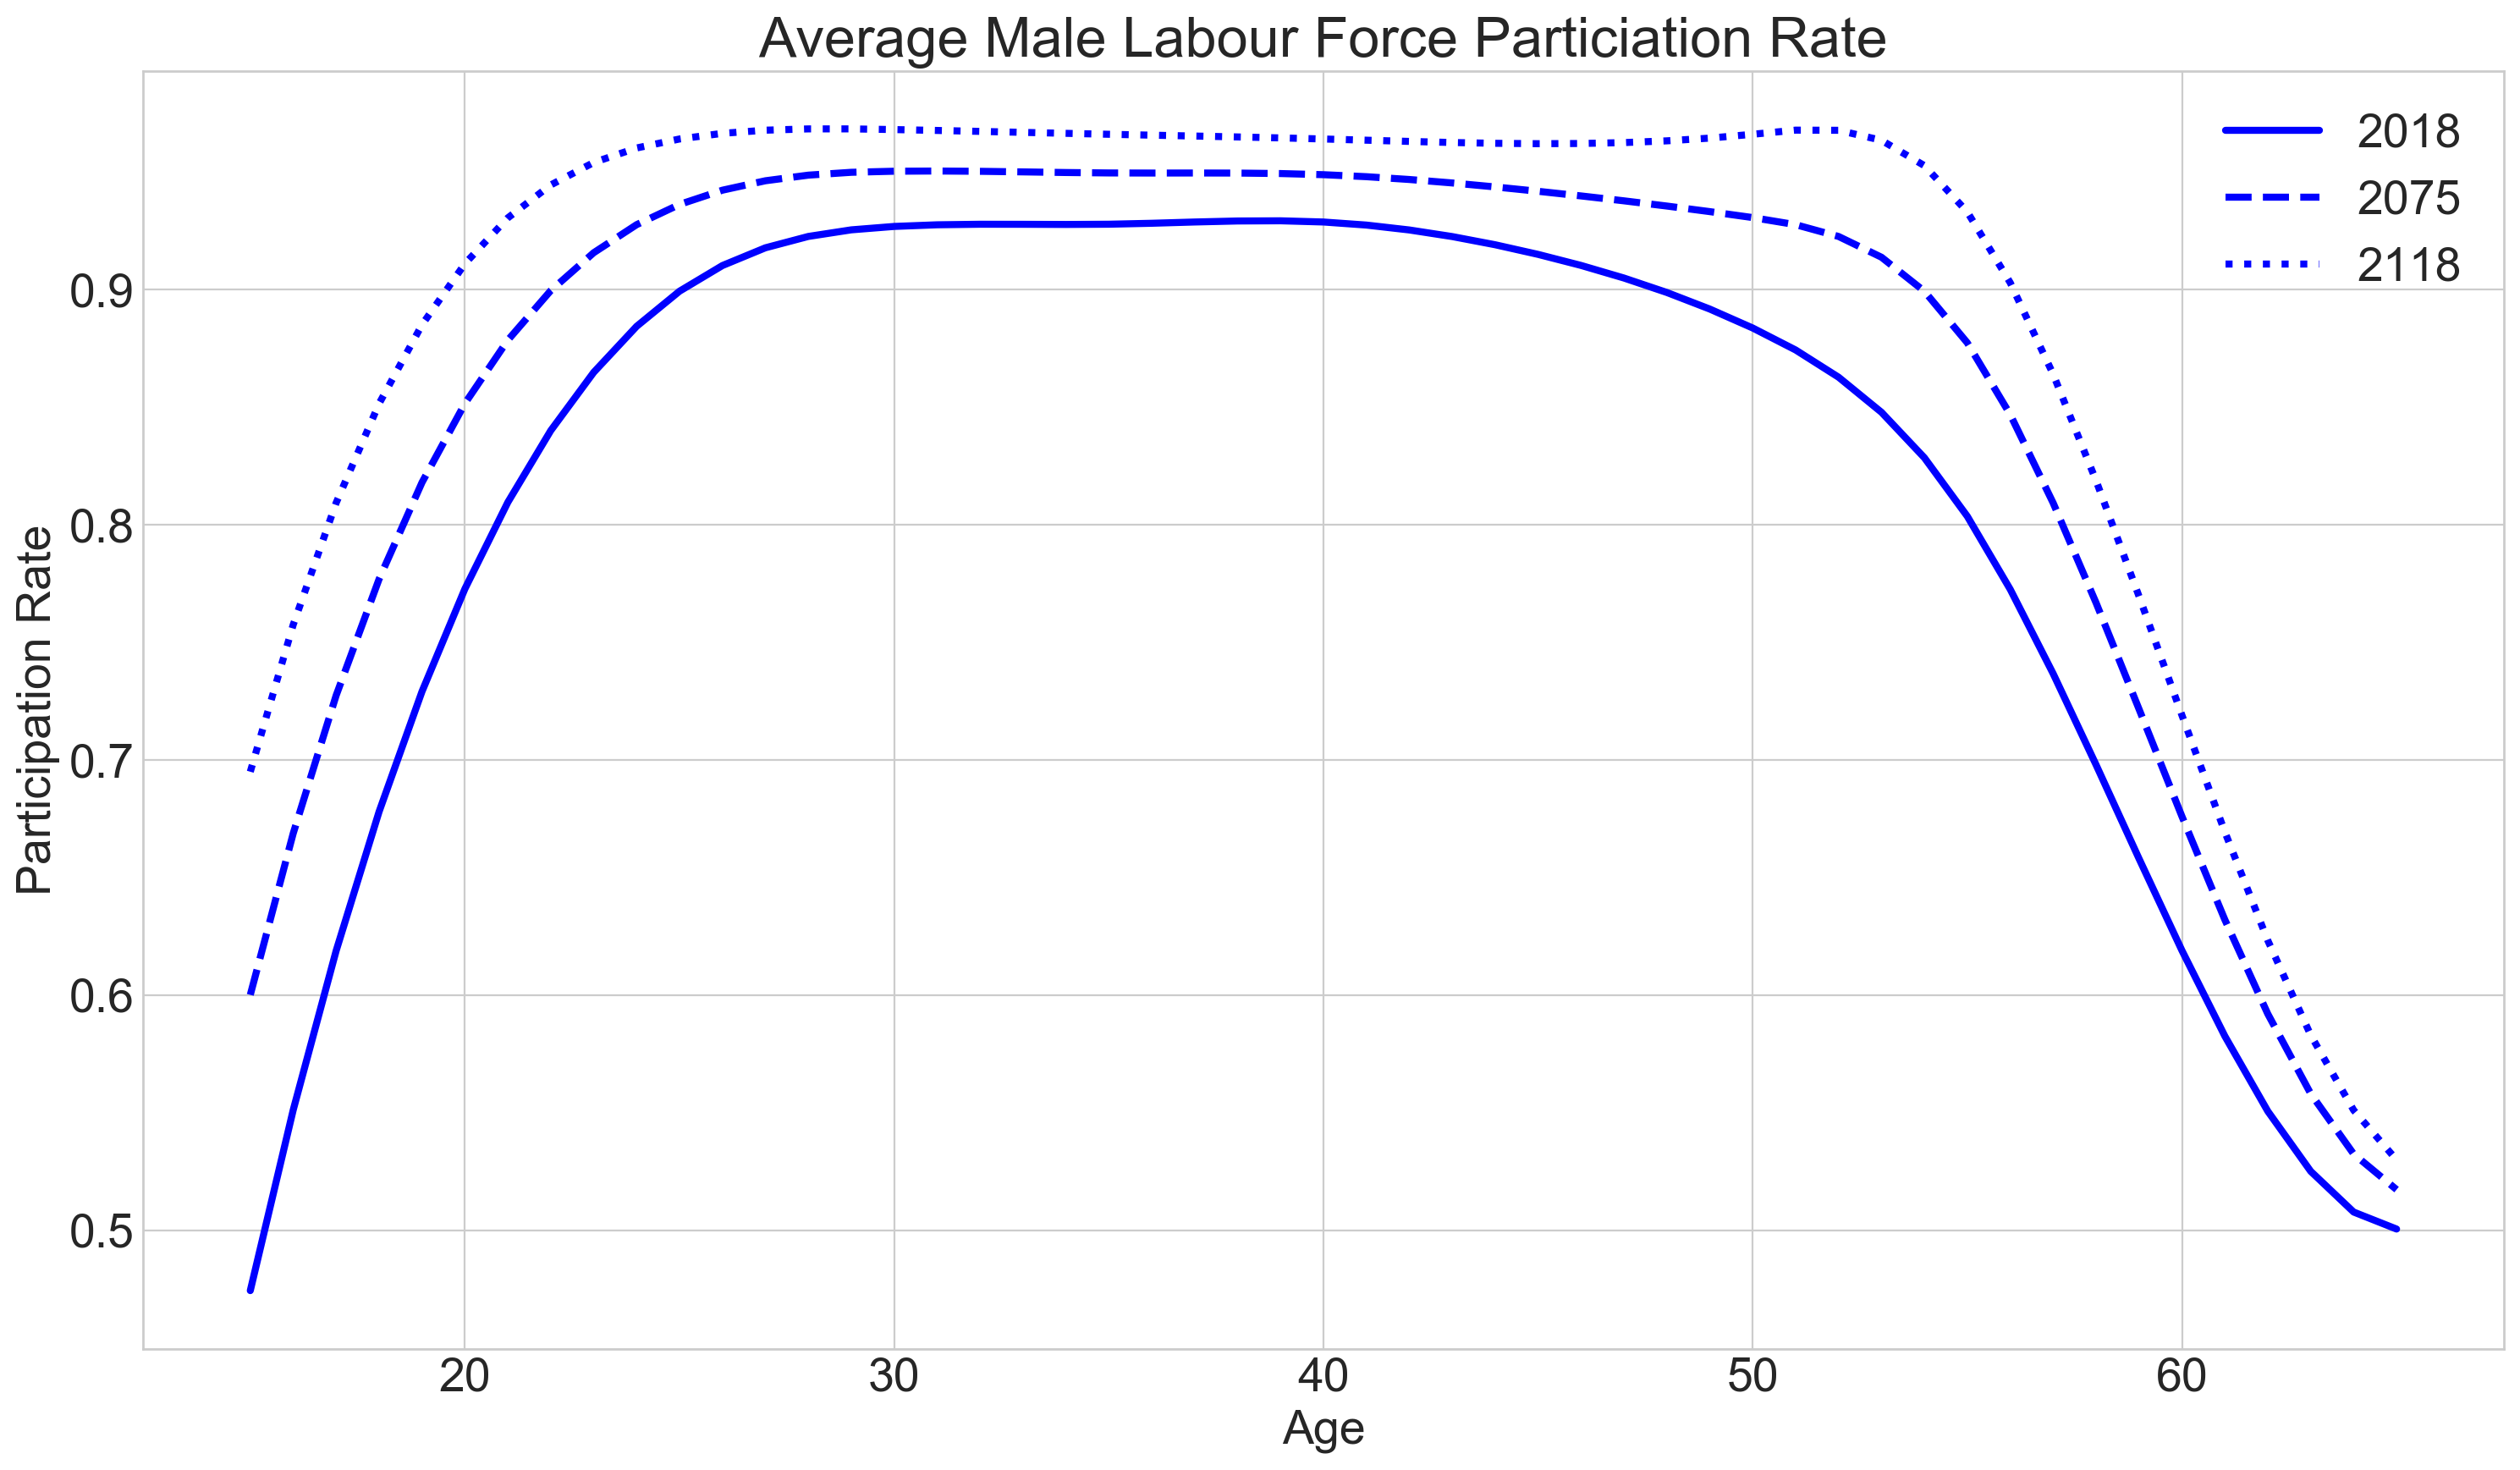

In [66]:
plt.plot(labour_force_male.loc[2018], color = 'blue', label = '2018')
plt.plot(labour_force_male.loc[2075], '--', color = 'blue', label = '2075')
plt.plot(labour_force_male.loc[2118], ':', color = 'blue', label = '2118')
plt.title('Average Male Labour Force Particiation Rate')
plt.xlabel('Age')
plt.ylabel('Participation Rate')
plt.legend()
plt.show()

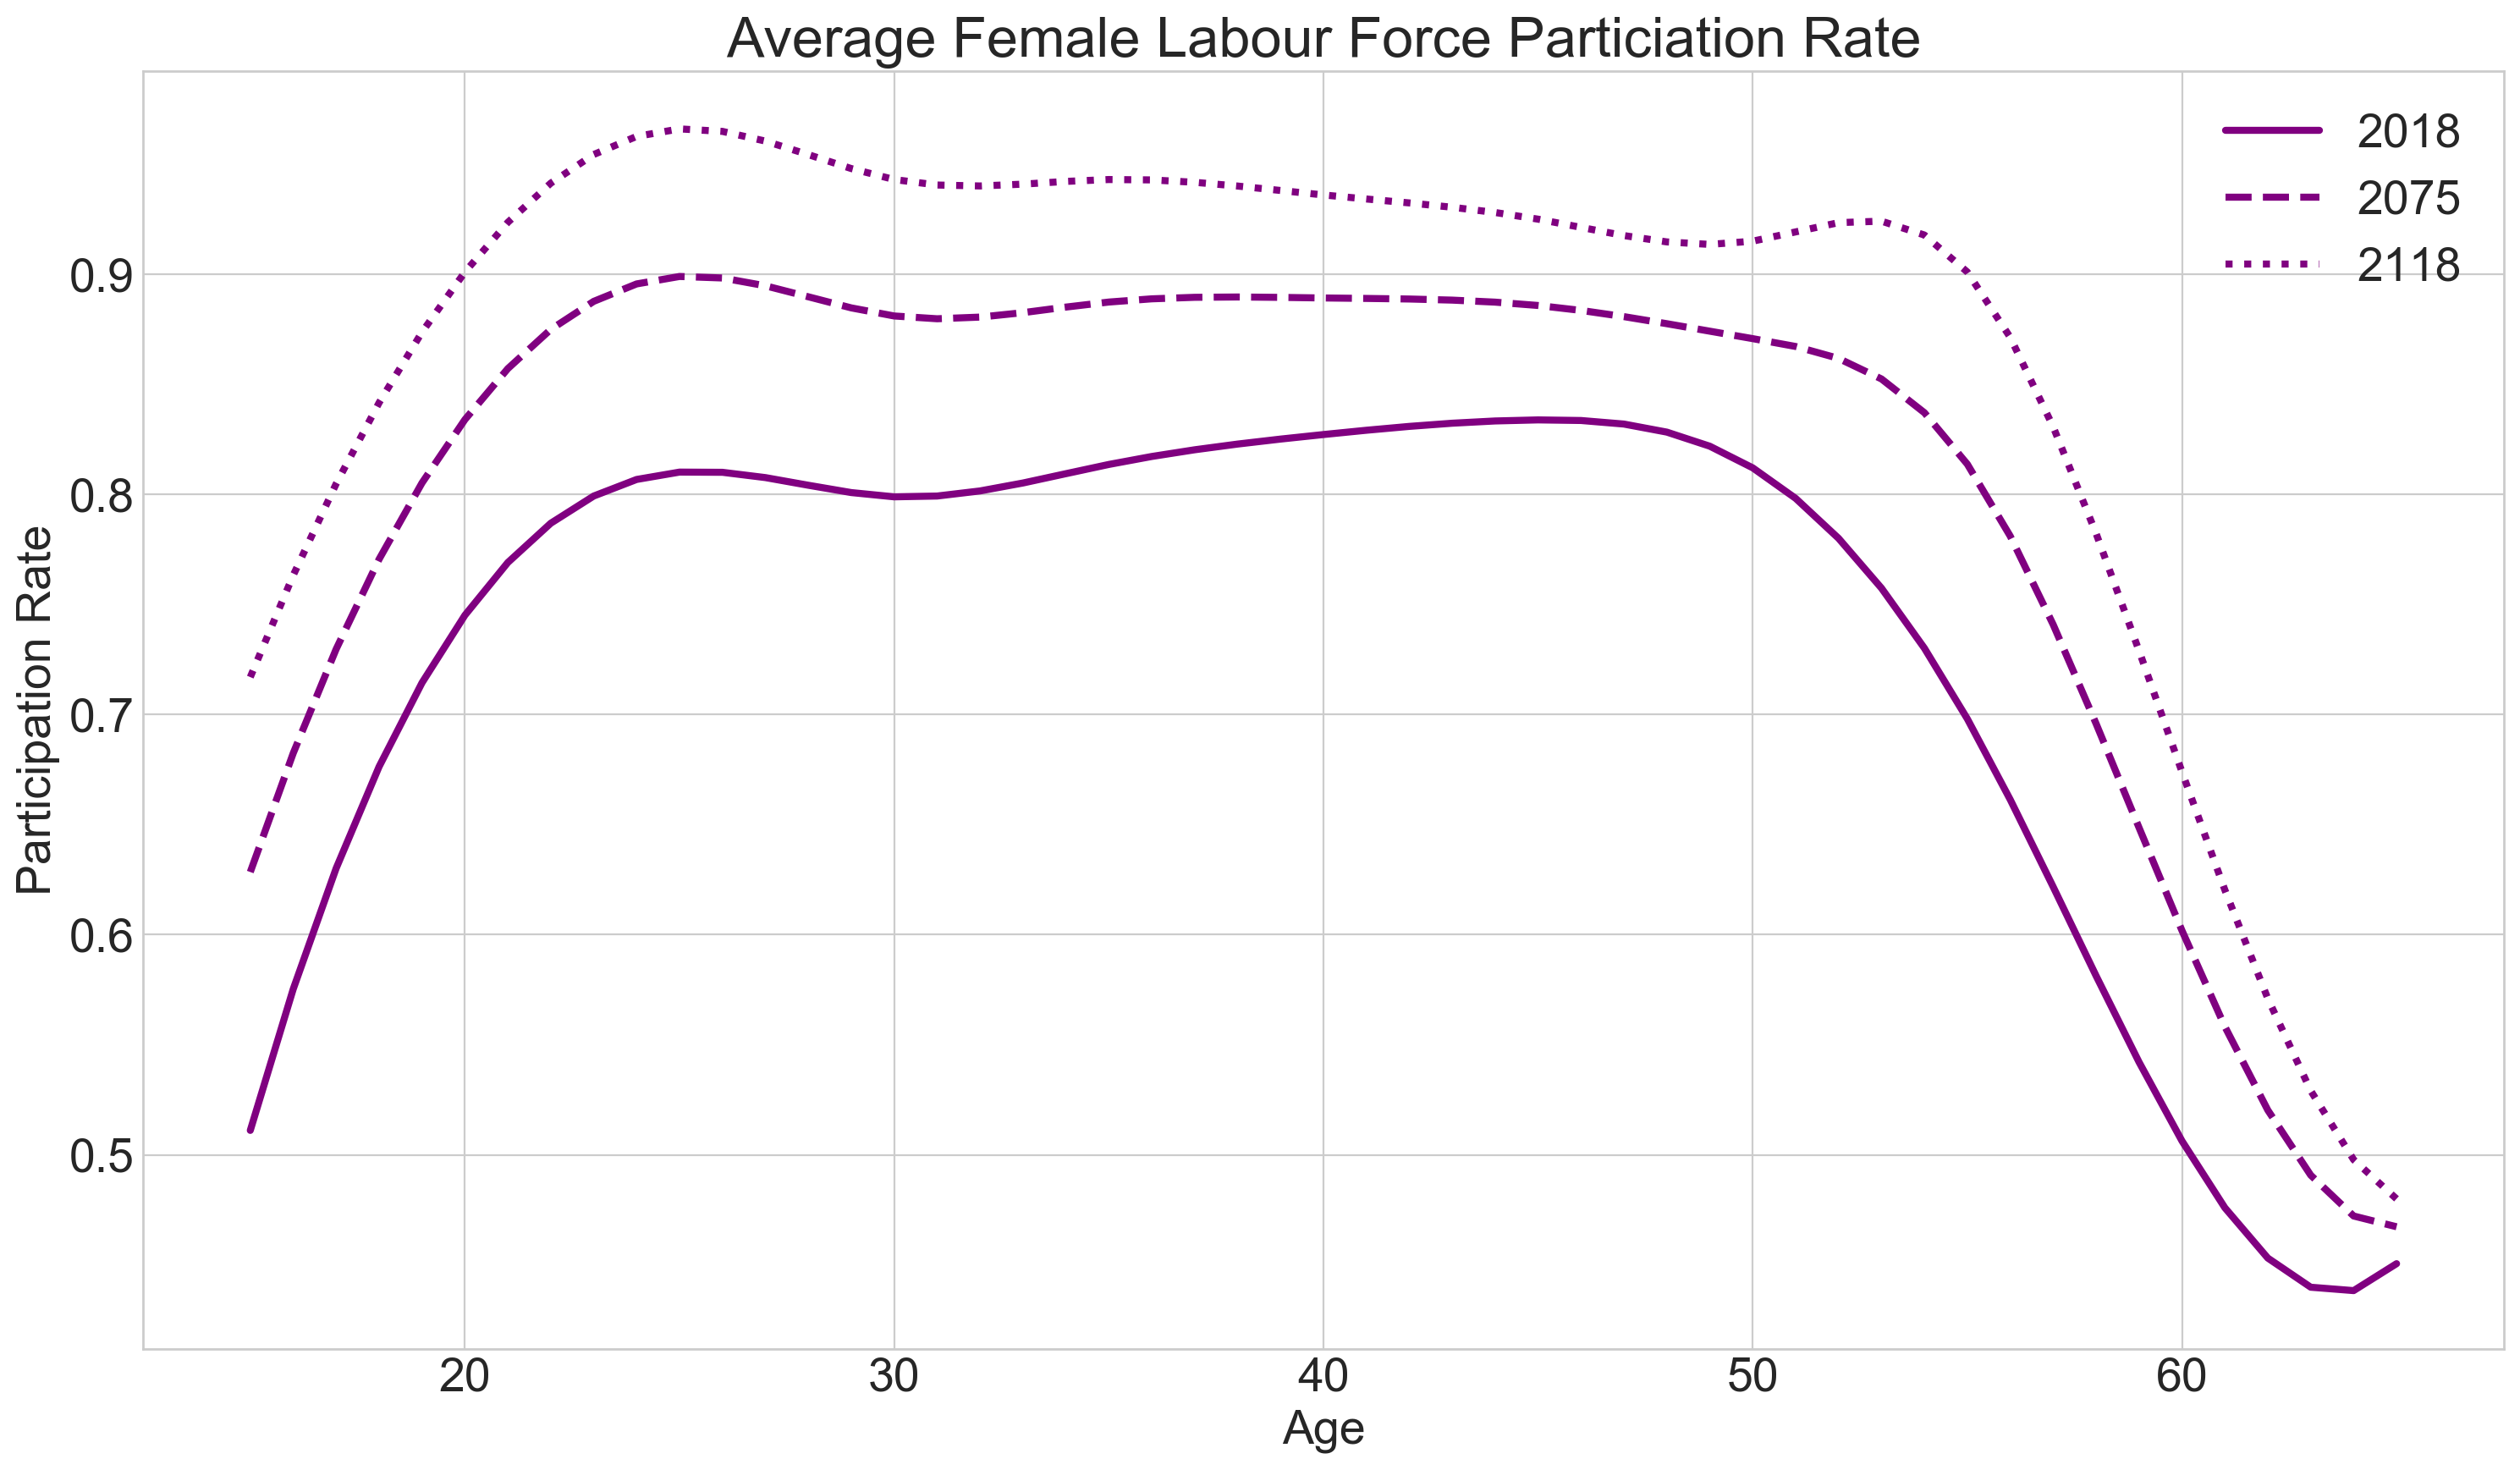

In [67]:
plt.plot(labour_force_female.loc[2018], color= 'purple', label = '2018')
plt.plot(labour_force_female.loc[2075],'--' ,color = 'purple', label = '2075')
plt.plot(labour_force_female.loc[2118],':' ,color = 'purple', label = '2118')
plt.title('Average Female Labour Force Particiation Rate')
plt.xlabel('Age')
plt.ylabel('Participation Rate')
plt.legend()
plt.show()

In [68]:
#Calculates the number of contributors each year based on the labour force participation rates
def number_contributers(df, labour_force_table):
    cohorts = df.columns.tolist()
    contributers = []
    
    for i in range(simulated_years_pop()):
        year = first_year_pop() + i
        
        df_ages = df.loc[year]
        df_ages.index = year - df_ages.index
        df_ages = df_ages[(df_ages.index >= working_age()) & (df_ages.index <retirement_age())]
        
        contributers.append(sum(df_ages\
                                *labour_force_table.loc[year][3:50]))
        
    contributers = pd.Series(data = contributers, index = create_years(first_year_pop(), last_year()))
    
    return contributers

In [69]:
#Found in Table 4 on page 24
def cppib_contributers():
    return pd.Series(data = [14117000, 14391000, 14980000, 15469000, 16129000, 16757000, 17814000, 20296000],
                     index = [2018, 2020, 2025, 2030, 2035, 2040, 2050, 2075])

In [70]:
male_contributers = number_contributers(male_pop,labour_force_male)
female_contributers = number_contributers(female_pop,labour_force_female)

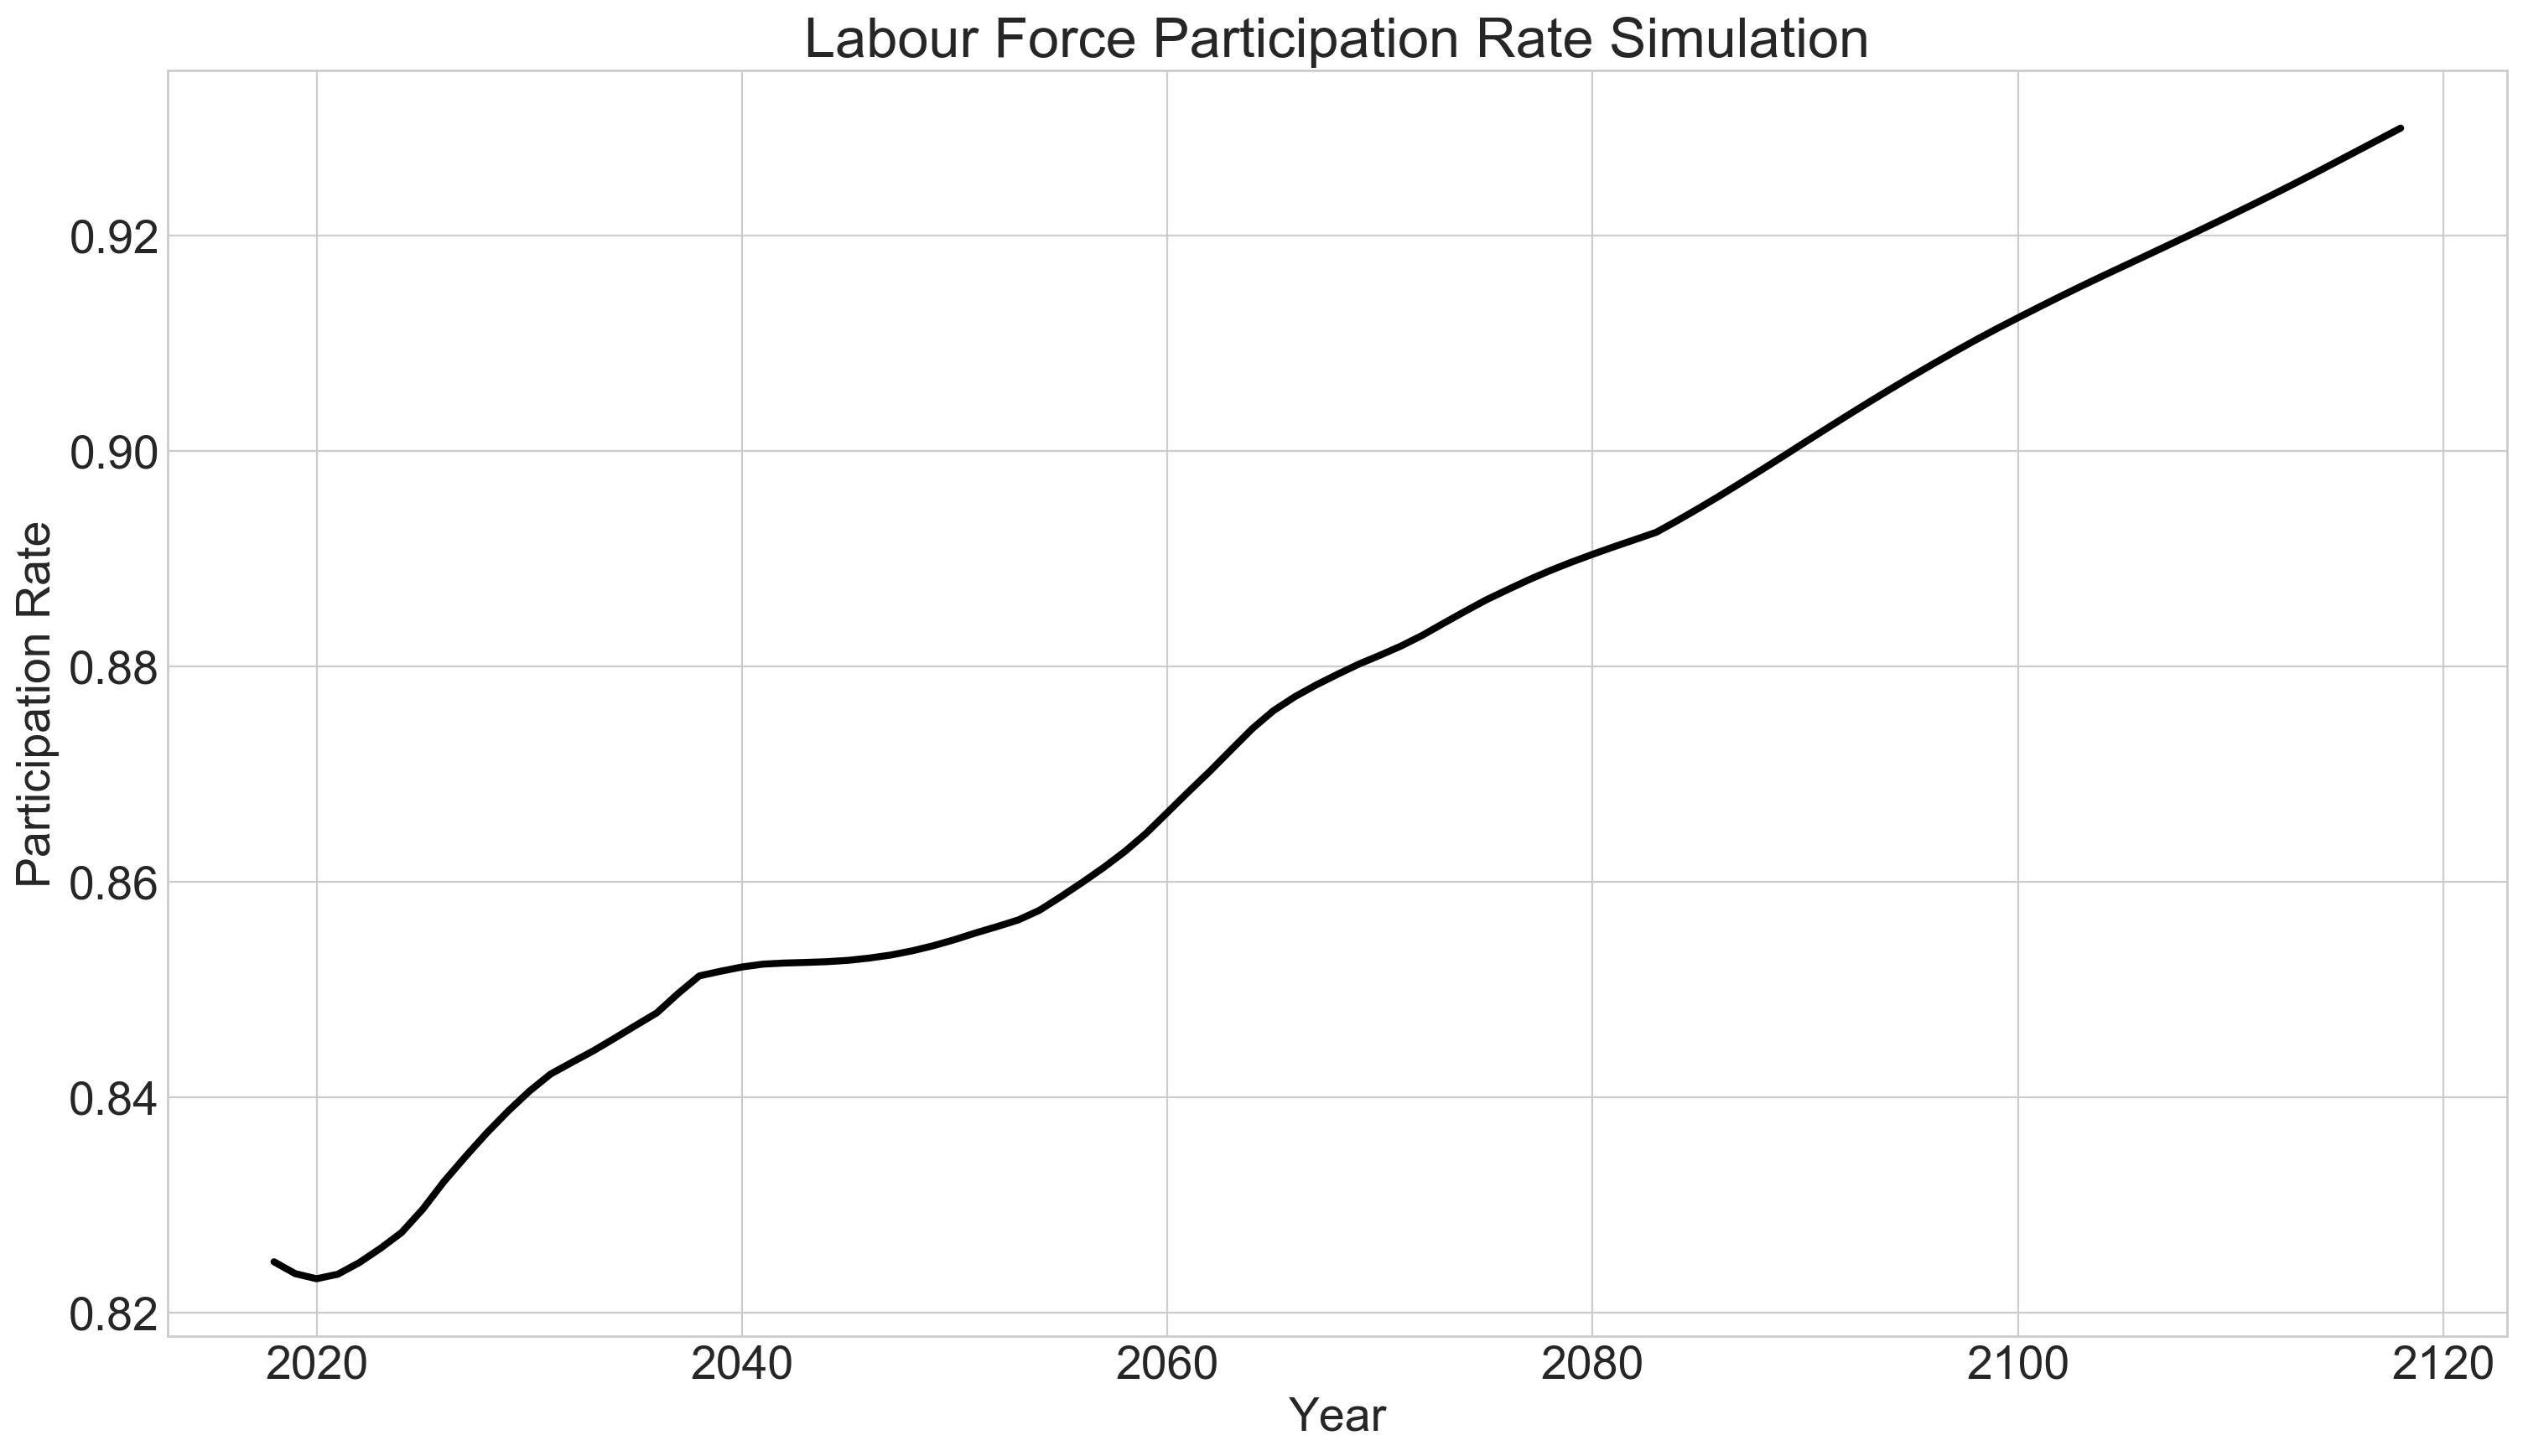

In [71]:
plt.plot((male_contributers + female_contributers)/(pop_groups.Working_ratio*total_pop_series), color ='black',label = 'Labour Force Participation Rate')
plt.title('Labour Force Participation Rate Simulation')
plt.ylabel('Participation Rate')
plt.xlabel('Year')
plt.show()

Now I can directly compare the number of contributers each year with data provided by the CPPIB. It seems like my population table begins by overestimating the number of contributers in 2018, but then underestimates it. On average, it underestimates contributers by 1%. 

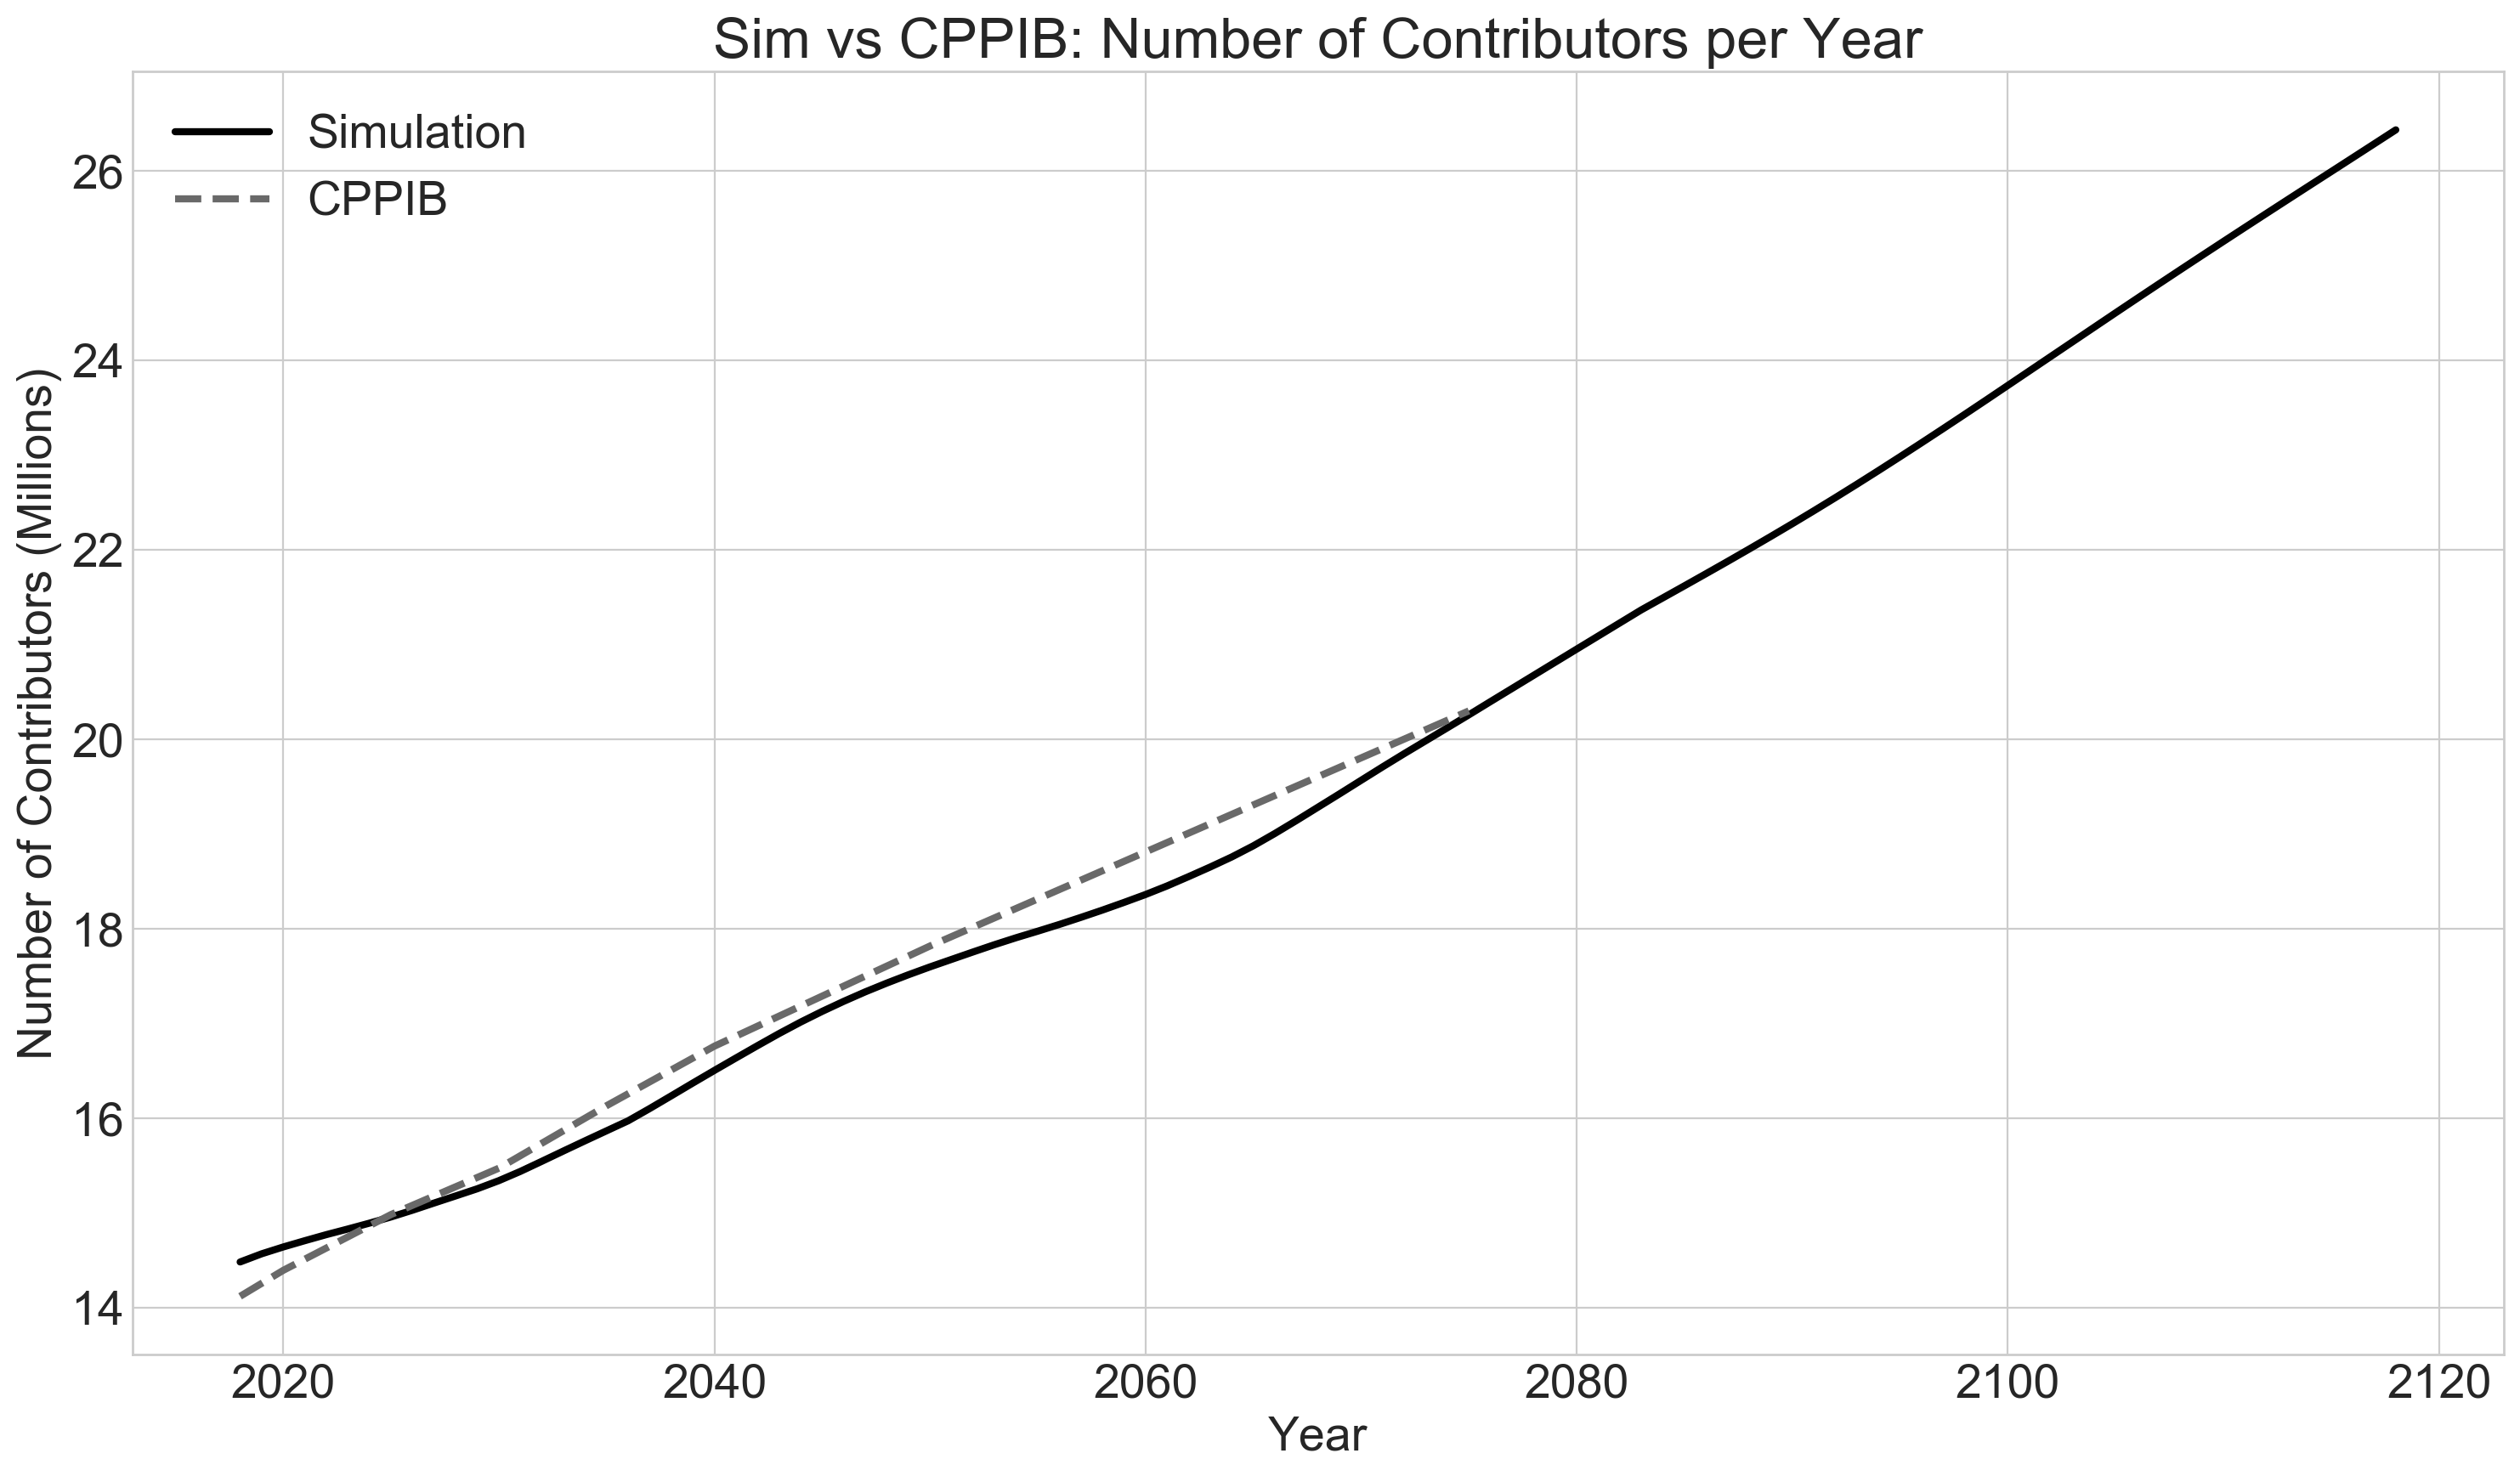

In [72]:
plt.plot((male_contributers + female_contributers)/1000000, color = 'black', label = 'Simulation')
plt.plot(cppib_contributers()/1000000, '--', color = 'dimgray', label = 'CPPIB')
plt.xlabel('Year')
plt.ylabel('Number of Contributors (Millions)')
plt.title('Sim vs CPPIB: Number of Contributors per Year')
plt.legend()
plt.show()

### Section 2.2 Income

There are several aspects of income that I need to be concerned with when modeling the CPP. The first is the distribution of income, between ages, and gender. The second is the difference between average income, and average pensionable income. And the third is how income increases over time. 

To get the age, and gender, distribution of income, I use a table provided by the CPPIB. Using the same methods used in labour force participation, I turn the table into a smooth function. 

More importantly though is the difference between average income, and pensionable income. Participants only contribute to the CPP on income up to the **yearly maximum pensionable earnings** (YMPE) cutoff, which is about equal to the average Canadian income. Participants to do not pay income above this cutoff, as well as below the minimum income exemption (which has been at \$3500 since 1997). This means that there will be a difference between average income, and average **pensionable** income. The average income will include income that is above, and below the cutoff values, whereas the average pensionable income will not include income below the yearly exemption, and will record any income above the YMPE as equal to the YMPE. For example, if someone earned $\$$2000 in 2016, this is not counted in the average pensionable income figures, but it will be in the average income figure. Whereas if someone earns $\$$100,000, which is  above the YMPE, then this income is only counted as equal to the YMPE. What this means is that average pensionable income is lower then average income. 

Where I run into problem is the changes to how much income the CPP reform covers. The YMPE, which was about equal to the average income, has been increased to 1.14x the average income. This won't influence the average income figures, but it will increase the average PENSIONABLE income distribution. Unfortunately, I do not have data on the underlying distribution of income in Canada, so I assume that the new average pensionable income falls somewhere in between the old average income, and the old average pensionable income. 

Note: This is the second area of the simulation I would like to improve. For example, I could use data provided by Stats Canada to find the income distribution for each age group. 

In [73]:
#Found in Table 52 on page 102
def cppib_avg_income_male():
    return pd.Series(data = [20000, 25709, 43127, 53030, 58457, 60669, 60912, 60453, 56630, 47080, 37292], 
                                index = cppib_ages())
#Found in Table 52 on page 102
def cppib_avg_income_female():
    return pd.Series(data = [17500, 18845, 33264, 38948, 43527, 46365, 47046, 46900, 43351, 34783, 25457], 
                                index = cppib_ages())
#Found in Table 54 on page 103
def cppib_pension_income_male():
    return pd.Series(data = [17500, 26082, 37364, 41706, 43419, 43944, 44066, 43883, 42051, 39456, 34810],
                                        index = cppib_ages())
#Found in Table 54 on page 103
def cppib_pension_income_female():
    return pd.Series(data = [15000, 20658, 32156, 35095, 37084, 38416, 38898, 39237, 37059, 33863, 28692],
                                          index = cppib_ages())

In [74]:
def new_cpp_average_income(income_old, income_new):
    diff_income = [1+((income_new.values[i]-income_old.values[i])/income_old.values[i])*0.35 for i in range(len(income_new))]
    
    income_old = income_old * diff_income
    
    return income_old

In [75]:
#Increase the average pensionable earnings with the cutoff of $54900 
new_cpp_income_male = new_cpp_average_income(cppib_pension_income_male(), cppib_avg_income_male())
new_cpp_income_female = new_cpp_average_income(cppib_pension_income_female(), cppib_avg_income_male())

In [76]:
#Interpolate the average pensionable earnings
old_cpp_income_male = interpolate_cppib_labour_force(cppib_pension_income_male(), 'Male_Income')
old_cpp_income_female = interpolate_cppib_labour_force(cppib_pension_income_female(), 'Female_Income')

In [77]:
#Interpolate the new cpp average
new_cpp_income_male = interpolate_cppib_labour_force(new_cpp_income_male, 'Male_Income')
new_cpp_income_female = interpolate_cppib_labour_force(new_cpp_income_female, 'Female_Income')

In [78]:
#I normalize income using the YMPE in 2016
def normalize_income(df):
    return (df - pension_exemption())/inflate_income()

In [79]:
new_cpp_income_male = normalize_income(new_cpp_income_male)
new_cpp_income_female = normalize_income(new_cpp_income_female)

old_cpp_income_male = normalize_income(old_cpp_income_male)
old_cpp_income_female = normalize_income(old_cpp_income_female)

These next two charts show how much average PENSIONABLE income has increased due to the cutoff for the yearly maximum pensionable earnings. 

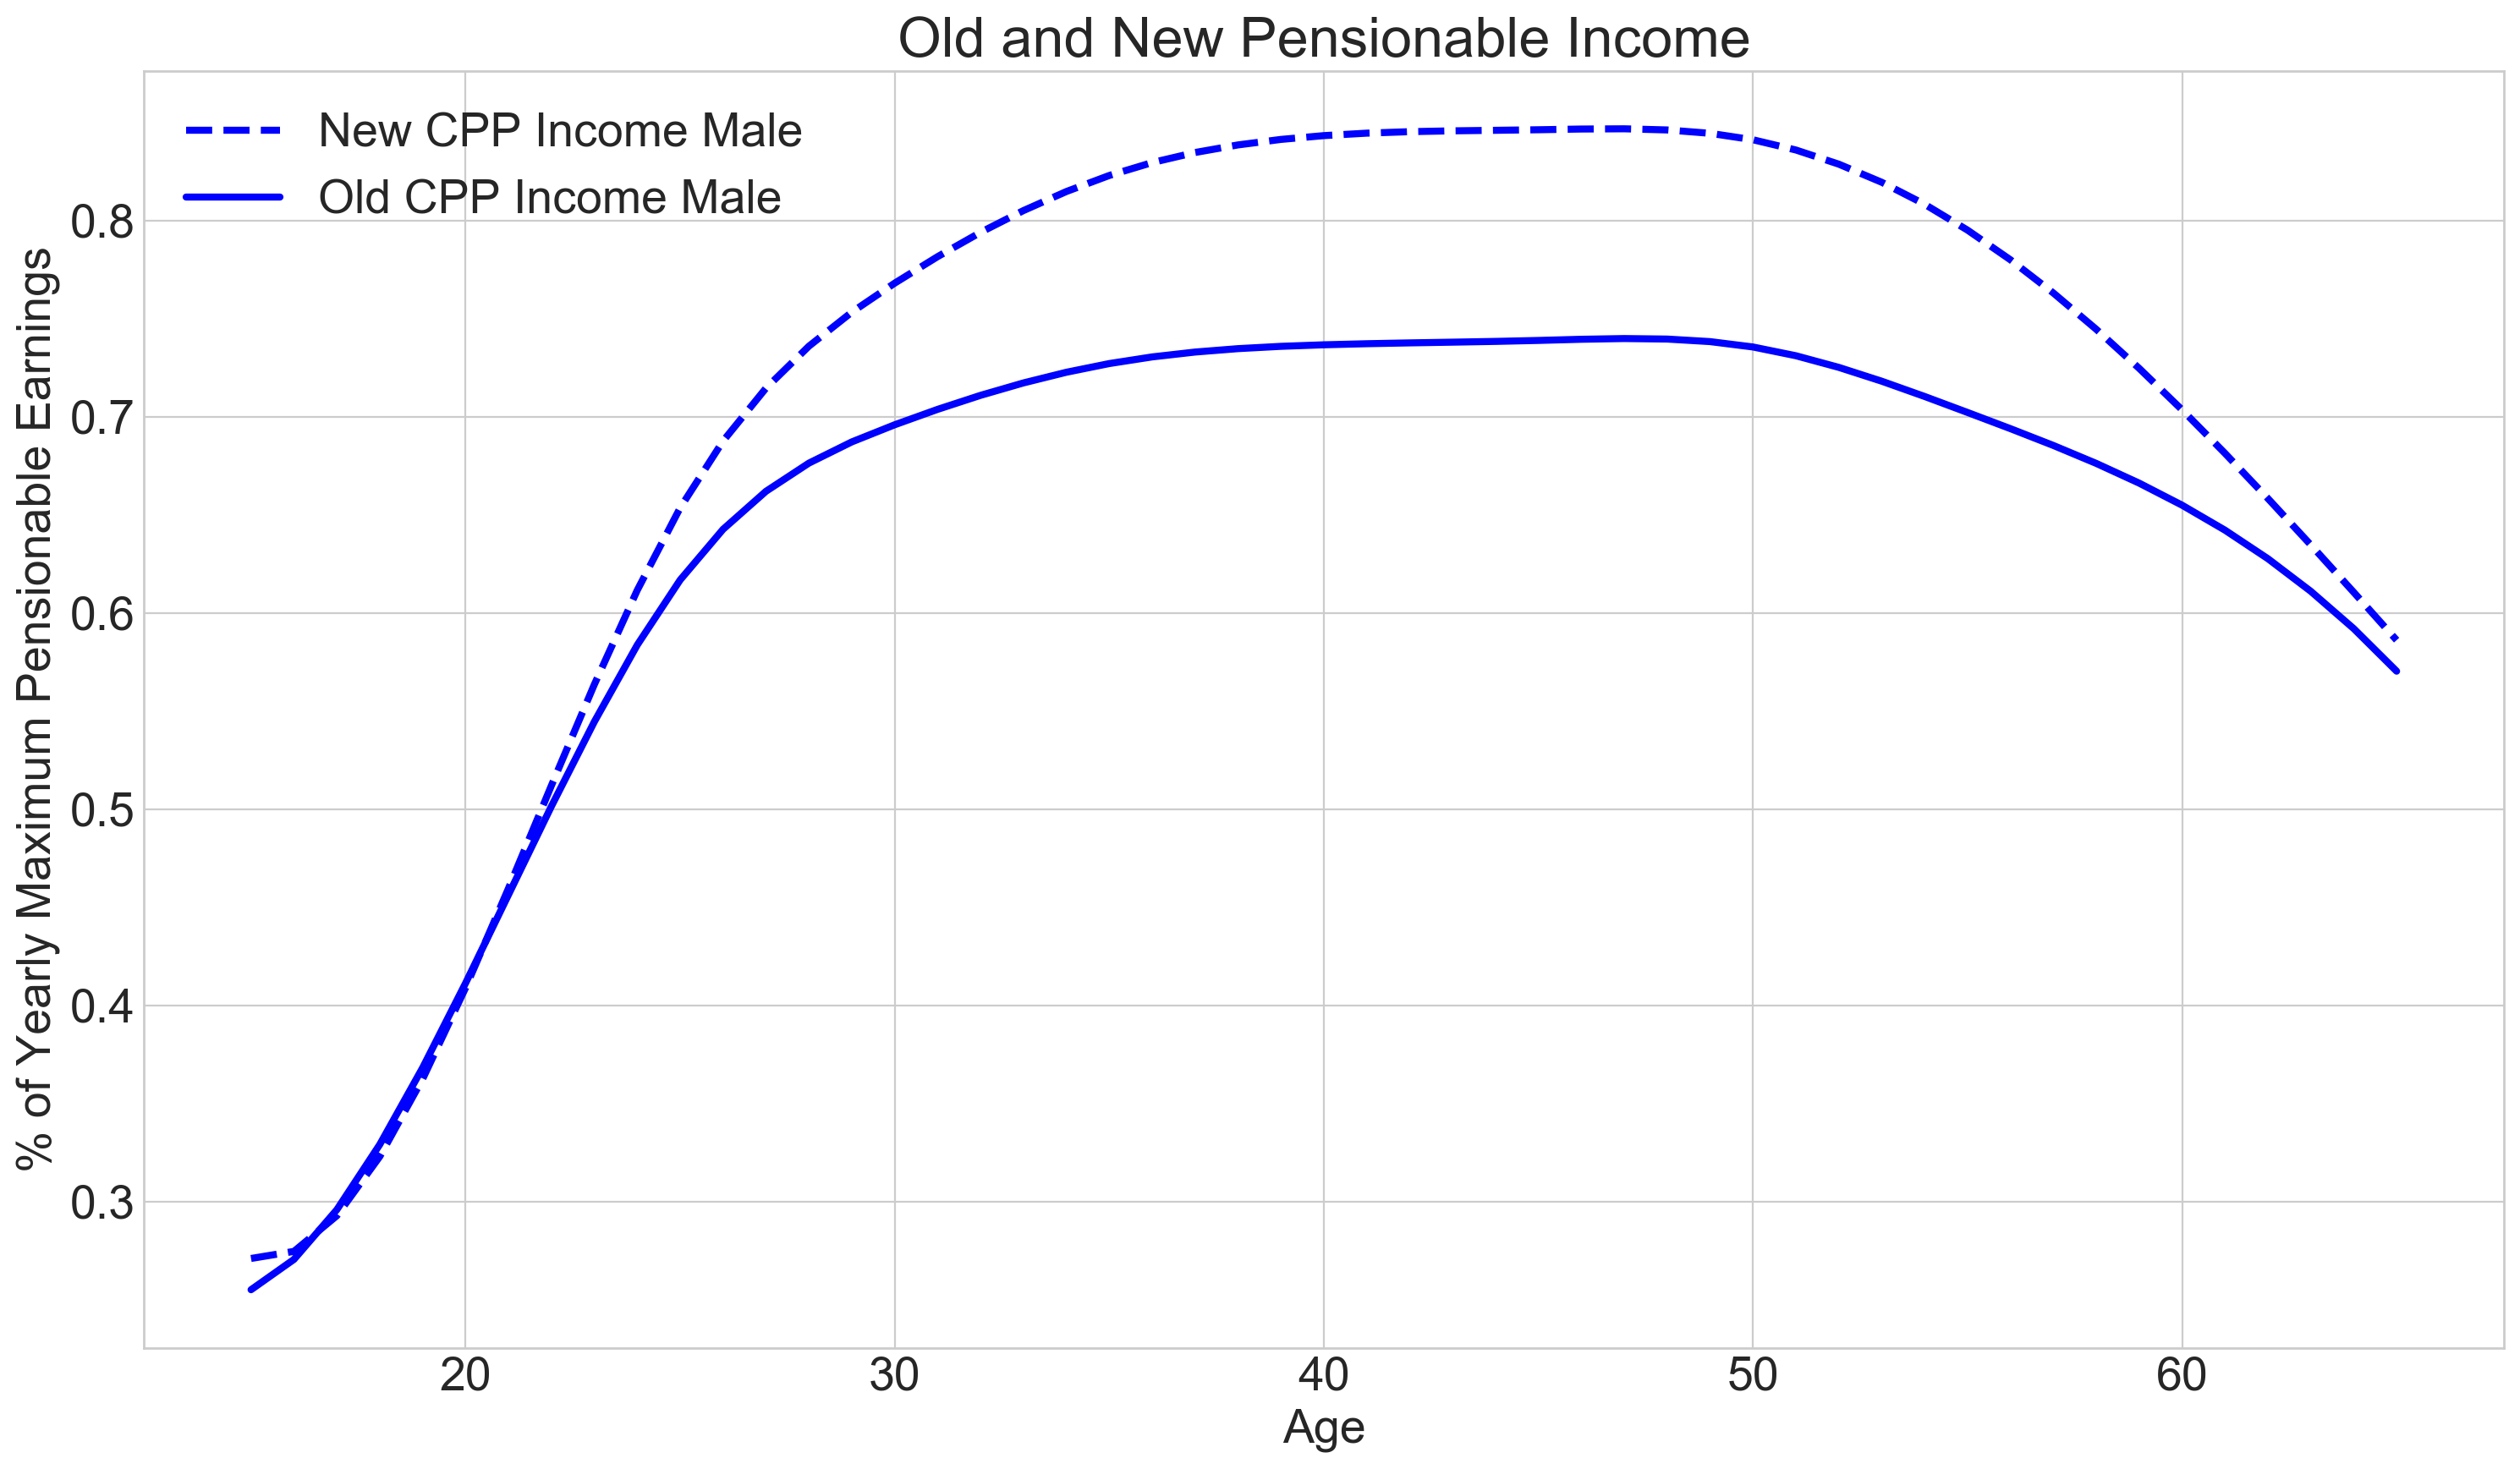

In [80]:
plt.plot(new_cpp_income_male,'--' ,color = 'b', label = 'New CPP Income Male')
plt.plot(old_cpp_income_male,color = 'b', label = 'Old CPP Income Male')
plt.xlabel('Age')
plt.ylabel('% of Yearly Maximum Pensionable Earnings')
plt.title('Old and New Pensionable Income')
plt.legend()
plt.show()

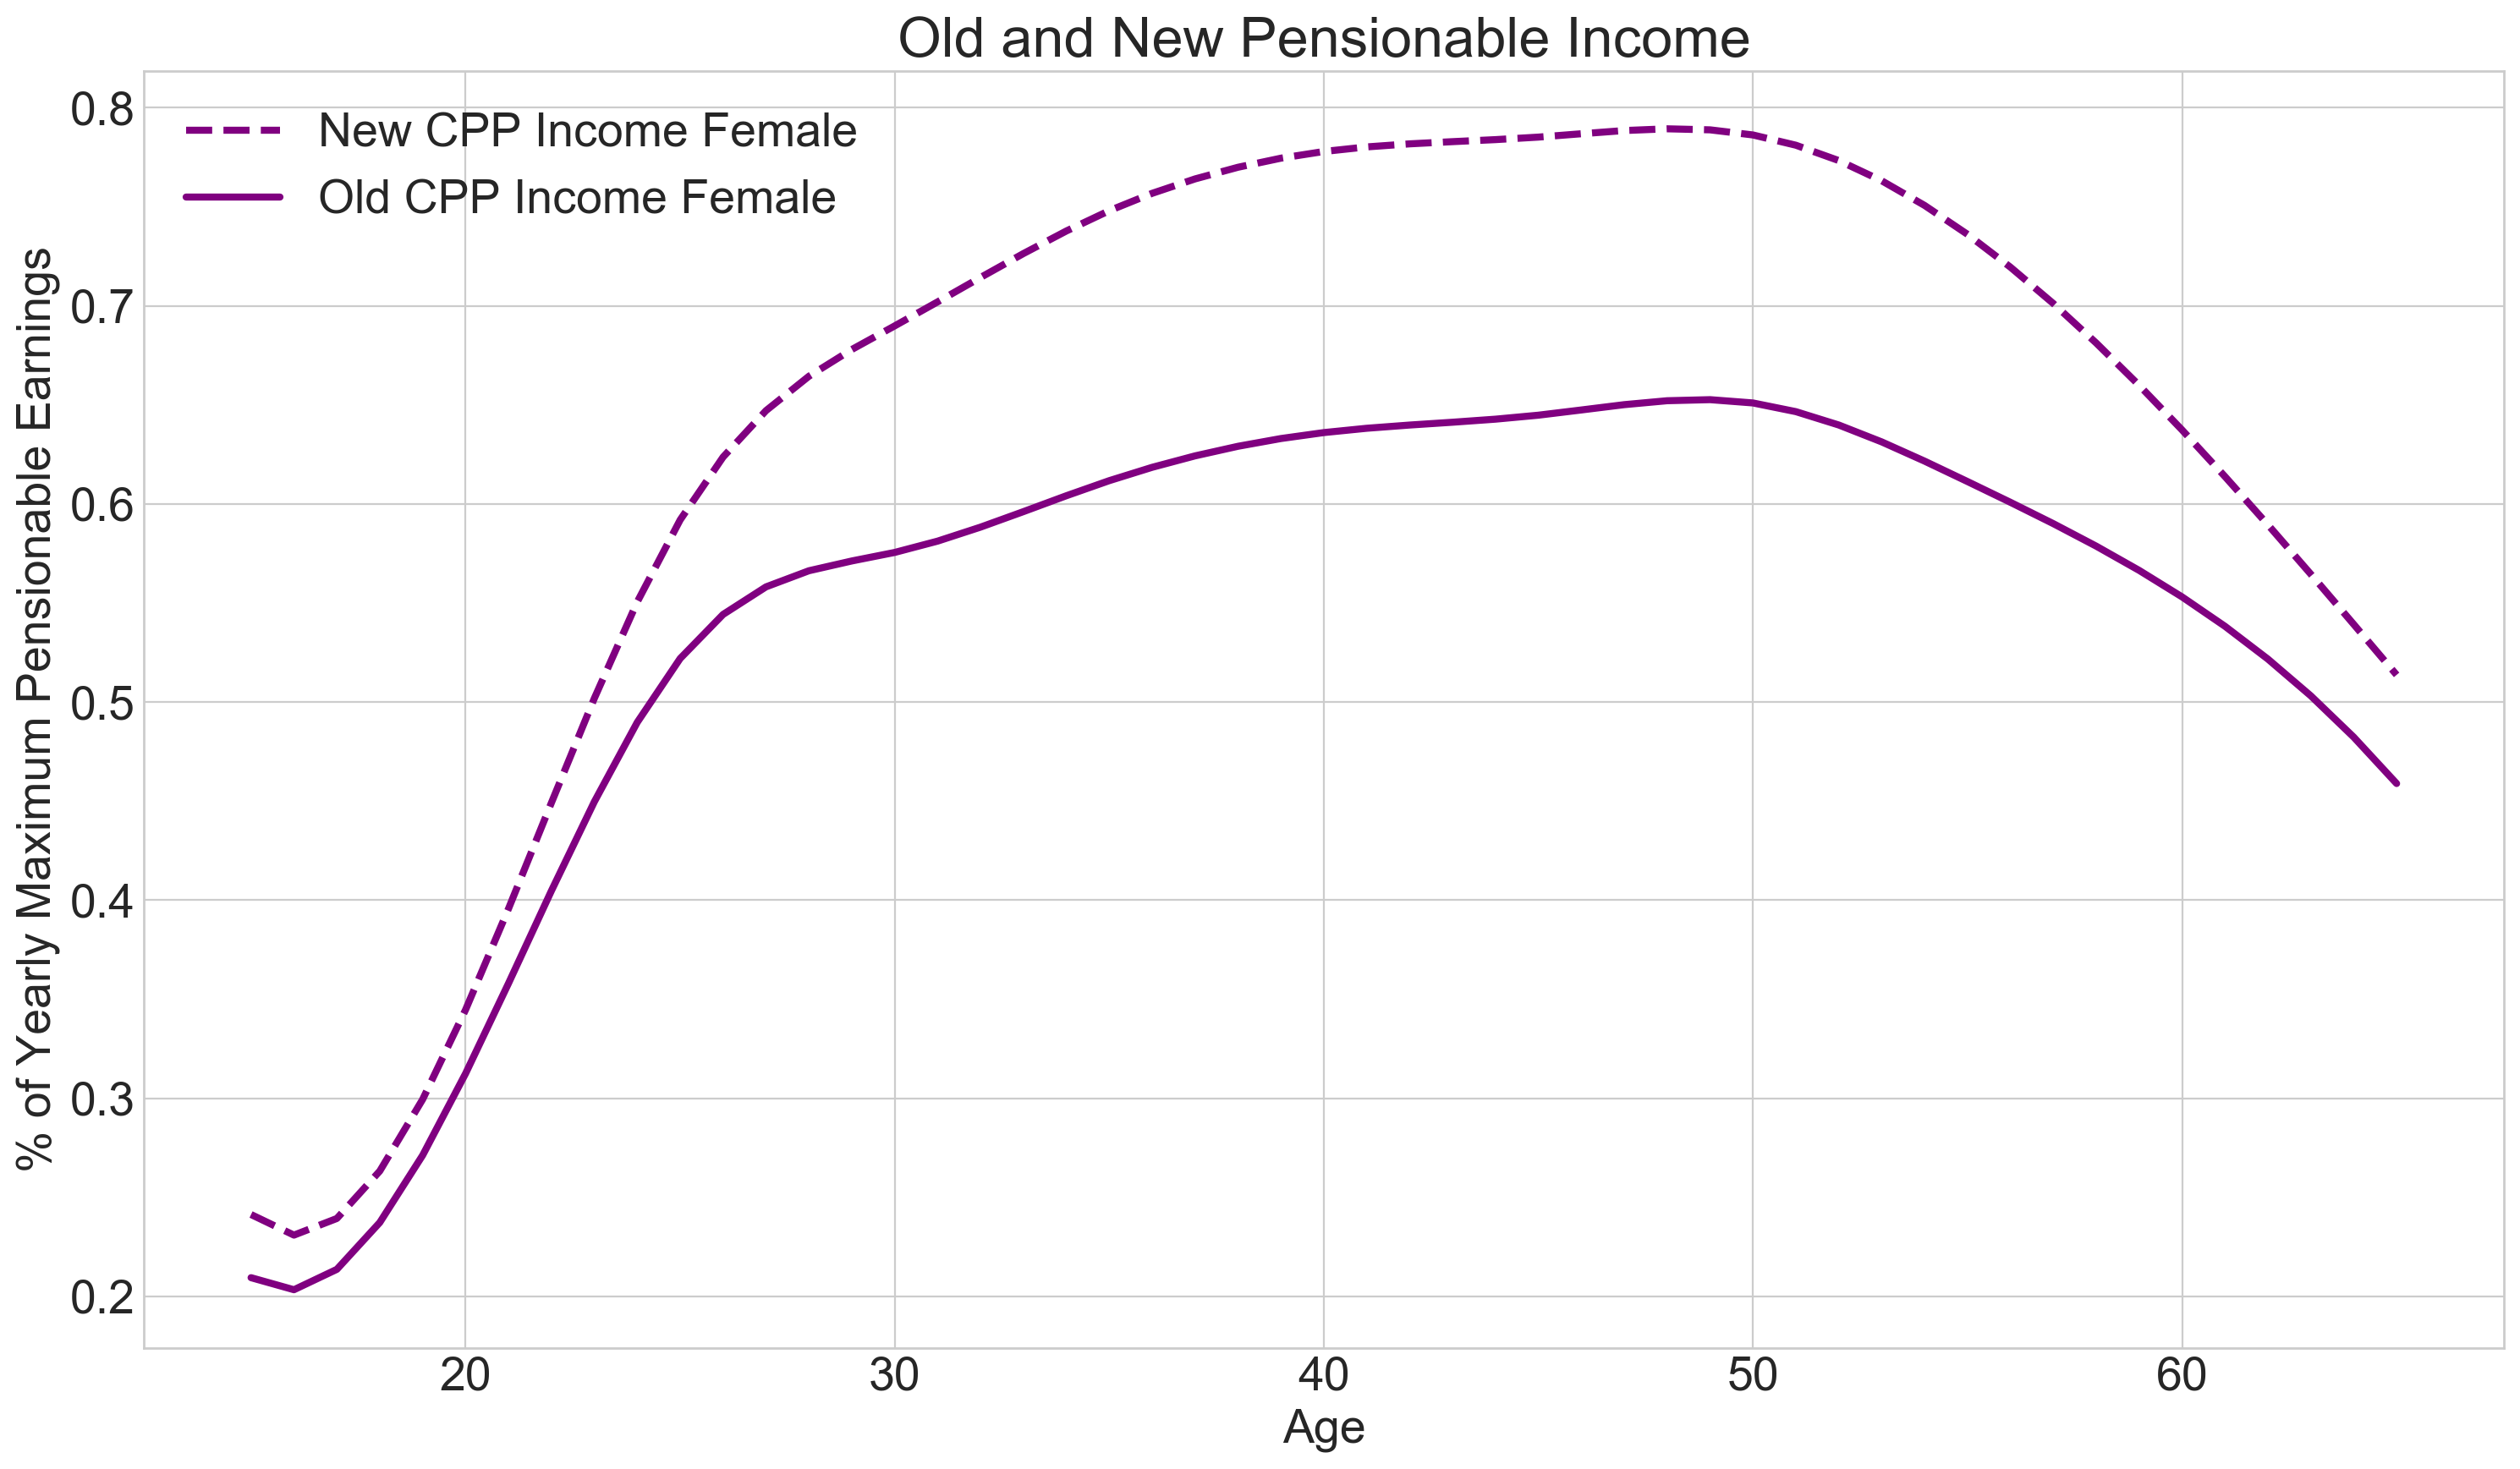

In [81]:
plt.plot(new_cpp_income_female,'--' ,color = 'purple', label = 'New CPP Income Female')
plt.plot(old_cpp_income_female, color = 'purple', label = 'Old CPP Income Female')
plt.xlabel('Age')
plt.ylabel('% of Yearly Maximum Pensionable Earnings')
plt.title('Old and New Pensionable Income')
plt.legend()
plt.show()

### Section 2.3 Inflation and Productivity

Inflation, and productivity are modeled using a simple deterministic function. Income simply increases by nominal productivity each year. 

Inflation is assumed to increase 2% each year. Productivity is assumed to be 3.1% nominally, or 1.1% in real terms. It is assumed that female productivity is 0.1% higher than male, which means that female income start to converge with males. 

In [82]:
def inflation_rate(x):
    return [(1+x)**i for i in range(simulated_years_cpp())]

def productivity_fn(x):
    return pd.Series(data= [(1+x)**i for i in range(simulated_years_cpp())]
                     , index = create_years(first_year_cpp(),last_year()))

In [83]:
#Inflation increases by 2% per year
#inflation = inflation_rate(0.02)

#Productivty increases by 3.1% per year in nominal terms
#productvity = productivity_fn(0.031)

# Section 3: The Pension System

1. Historical Benefits
2. CPP
    * Old CPP
    * New CPP
    * Transition generations
4. Generational accounts
    * Generational accounts for specific cohorts
    * Generational accounts for all cohorts born after 1954
    * Generational account over time
    * Internal rate of return
    * Contribution and benefits of a generation
5. Financial Projections
    * Balance sheet
    * Financial projections


### Section 3.1 Historical benefits

Regardless of the changes in to the CPP, there are millions of retirees who are current receiving benefits. To be able to model the financials of the CPP I need to calculate their benefits. Here's what I know: 
1. The maximum benefits in each year of the CPP in historical dollars. For example, the maximum benefit that a new retiree receives if they retire in 1985 was $\$$435, which is equivalent to $\$$935 in 2019 dollars.  
2. The CPI over the last 45 years. 
3. The expenditures (benefits paid) of the CPP in 2019

During the first year of the simulation, the expenditure figure only includes historical pensions.  So I begin by inflating the maximum pension benefits to 2019 dollars, and then fitting the expenditure from historical pensions, to that of the CPPIB financial projection for 2019. 

In [84]:
#Max benefits based on year of retirement
max_benefit = pd.read_csv('C:/Users/seanm/OneDrive/Documents/Thesis/max_cpp_benefits_2018/ntauxm-nmonthrate.csv')
max_benefit.set_index('Year', inplace = True)
max_benefit = max_benefit.fillna(0)
max_benefit = max_benefit.apply(pd.to_numeric, errors='ignore')

#Turn monthly figures into yearly
max_benefit = max_benefit*12

#CPI index
cpi = pd.read_csv('C:/Users/seanm/OneDrive/Documents/Thesis/cpi_oecd/DP_LIVE_26062019103625824.csv')
cpi = cpi[cpi.LOCATION=='CAN']
cpi.set_index('TIME', inplace = True)
cpi.Value =1 + cpi.Value/100

In [85]:
def cpi_inflator():
    cpi_inflator = []
    for i in range(53):
        year = 1967 + i 
        cpi_index = 1
        for j in range(2019-year):
            cpi_index = cpi_index*cpi.Value[year+j]
            
        cpi_inflator.append(cpi_index)
    
    return cpi_inflator

In [86]:
cpi_inflator = pd.Series(index = create_years(1967, 2019), data = cpi_inflator())

max_benefit['Inflation'] = cpi_inflator
max_benefit['Inflated_benefit'] = max_benefit.Retirement * max_benefit.Inflation

In [87]:
#Historical benefits from everyone who has retired before, or in, 2019. Cohorts: 1918 - 1955
def historical_benefits(inflation):
    
    inflation = inflation_rate(inflation)
    years = create_years(first_year_cpp(), last_year())
    cohort_payments_male = pd.DataFrame(index = years)
    cohort_payments_female = pd.DataFrame(index = years)
    
    
    cohorts = create_years(1918, 1954)

    
    male_benefit_ratio = 0.70
    female_benefit_ratio = 0.645
    
    for cohort in cohorts:
        
        benefits_male = []
        benefits_female = []
        cohort_years = []
        retirement_year = cohort + retirement_age()
        age = first_year_cpp() - cohort
        
        
        for j in range(max_years_lived()-age):
            
            k = age-retirement_age()+j
            benefits_male.append(male_pop[cohort].values[j]\
                                 *max_benefit['Inflated_benefit'][retirement_year]\
                                 *male_benefit_ratio\
                                 *inflation[j]\
                                 *(1.00259)**k)
                                 
            
            benefits_female.append(female_pop[cohort].values[j]\
                                   *max_benefit['Inflated_benefit'][retirement_year]\
                                   *female_benefit_ratio\
                                   *inflation[j]\
                                   *(1.00777)**k)

            cohort_years.append(first_year_cpp()+j)

        cohort_male = pd.Series(data = benefits_male, index = cohort_years, name = cohort)
        cohort_female = pd.Series(data = benefits_female, index = cohort_years, name = cohort)
        
        cohort_payments_male = cohort_payments_male.join(cohort_male)
        cohort_payments_female = cohort_payments_female.join(cohort_female)
        
    return cohort_payments_male, cohort_payments_female

male_pensions, female_penesions = historical_benefits(0.02)
historic_pensions = male_pensions.sum(axis=1) + female_penesions.sum(axis=1)

### Section 3.2 Canadian Pension Plan: Old, Reform, and Transition

There are three functions that determine the contributions, and benefits, provided by the CPP (with the exception of the historical pensions above). These include the function for the old CPP, the reformed CPP, and a transition function that calculates benefits for those who worked under both systems. The functions for the old and the reformed CPP work in similar ways, just with different contribution rates, and pensionable income.

Contributions in year $t$ for cohort $i$ are determined by: 
1. Number of people in the cohort in year $t$ (assuming that the cohort is over the age of 18).  
2. Labour force participation rate in year $t$
3. Normalized income
4. Productivity level in year $t$ (which determines the wage level)
5. Contribution rate

Benefits in year $t$ for cohort $i$ are determined by: 
1. Number of people in cohort $i$ in year $t$ (assuming they are over the age of 65) subtracted by the number of immigrants who are added to that cohort in year $t$. (Note: Immigrants who arrive over the age of 65 do not receive benefits.)
      
2. Inflation level in year $t$. 
3. Average productivity level between the year of retirement, and the previous 5 years. 
4. Average income between the ages of 20, and 65
5. The max labour force participation rate for this cohort
6. Benefit rate 
7. The benefit multiplier
                                    
                                      
**CPP Benefits**
As mentioned in the thesis, the CPP provides several different types of benefits, such as the standard retirement pension, the survivor pension, and death benefits. These, as well as the operating costs of the CPP, have all been lumped into one benefit for the purposes of this simulation. 

In an attempt to naively model these additional benefits, I have added a benefit accelerator to the model. This accelerator slowly increases the size of the benefit, in addition to inflation. Since women receive these additional benefits at a ratio of 3:1 to men, their benefit accelerator is 3x larger then males. The figures were settled were determined by fitting the financial data of the simulation, to that of the data provided by the CPPIB. For a male who live until the maximum age of 110, their benefit increases 10% above inflation, and for women its 35%.

In [88]:
def old_cpp(male_pop, female_pop, productivity_rate, inflation):
    years = create_years(first_year_cpp(), last_year())
    cohort_payments_male = pd.DataFrame(index = years)
    cohort_payments_female = pd.DataFrame(index = years)
    
    contribution_rate = 0.099
    benefit_rate = 0.25
    cohorts = create_years(1955, last_year())
    
    #Define nominal productivity, and inflation
    productivity_male = productivity_fn(productivity_rate + inflation - 0.001)
    productivity_female = productivity_fn(productivity_rate + inflation + 0.001)
    inflation = inflation_rate(inflation)

    
    for cohort in cohorts:
        contributions_paid_male = []
        contributions_paid_female = []

        cohort_years = []
        retirement_year = cohort + retirement_age()
        k=0
    
        for i in range(simulated_years_cpp()):
            
            age = first_year_cpp() - cohort + i
            year = first_year_cpp() + i
            
            if (age<working_age()):
                pass
            
            #Start work at 18, and stop working before turning 65
            elif (age>=working_age()) & (age<retirement_age()):
                
                contributions_paid_male.append(male_pop[cohort].values[i]\
                                    *labour_force_male.loc[year][age]\
                                    *old_cpp_income_male.loc[age][0]\
                                    *contribution_rate\
                                    *productivity_male.loc[year]*-1)
                    
                contributions_paid_female.append(female_pop[cohort].values[i]\
                                    *labour_force_female.loc[year][age]\
                                    *old_cpp_income_female.loc[age][0]\
                                    *contribution_rate\
                                    *productivity_female.loc[year]*-1)
                
                        
                cohort_years.append(cohort+age)
    
            #Retire at 65
            elif age>=retirement_age():
                contributions_paid_male.append((male_pop[cohort].values[i]- imm_cohort_table_male.loc[cohort][age])\
                                      *benefit_rate\
                                      *inflation[k]\
                                      *np.mean(productivity_male.loc[retirement_year-5:retirement_year])\
                                      *np.mean(old_cpp_income_male['Male_Income'].loc[20:65])\
                                      *max(labour_force_male.loc[retirement_year])\
                                      *(1.00259)**k)
                                     
                                                                  
                contributions_paid_female.append((female_pop[cohort].values[i]- imm_cohort_table_male.loc[cohort][age])\
                                        *benefit_rate\
                                        *inflation[k]\
                                        *np.mean(productivity_female.loc[retirement_year-5:retirement_year])\
                                        *np.mean(old_cpp_income_female['Female_Income'].loc[20:65])\
                                        *max(labour_force_female.loc[retirement_year])\
                                        *(1.00777)**k)
                                        
        
                cohort_years.append(cohort+age)
                k+=1                
    
            if (age == max_years_lived()-1) | (age + cohort >= last_year()): 
                break
                
            
        cohort_male = pd.Series(data = contributions_paid_male, index = cohort_years, name = cohort)
        cohort_female = pd.Series(data = contributions_paid_female, index = cohort_years, name = cohort)
        
        cohort_payments_male = cohort_payments_male.join(cohort_male)
        cohort_payments_female = cohort_payments_female.join(cohort_female)
            
        
    return  cohort_payments_male.fillna(0), cohort_payments_female.fillna(0)

In [89]:
def new_cpp(male_pop, female_pop, productivity_rate, inflation):
    
    years = create_years(first_year_cpp(), last_year())
    cohort_payments_male = pd.DataFrame(index = years)
    cohort_payments_female = pd.DataFrame(index = years)
    
    cohorts = create_years(1955, last_year())
    
    productivity_male = productivity_fn(productivity_rate + inflation - 0.001)
    productivity_female = productivity_fn(productivity_rate + inflation + 0.001)
    inflation = inflation_rate(inflation)
    
    contribution_rate = 0.119
    benefit_rate = 0.33
    
    for cohort in cohorts:
        contributions_paid_male = []
        contributions_paid_female = []

        cohort_years = []
        retirement_year = cohort + retirement_age()
        k=0
        
        for i in range(simulated_years_cpp()):
            
            age = first_year_cpp() - cohort + i
            year = first_year_cpp()+i
            
            if (age<working_age()):
                pass

            elif (age>=working_age()) & (age < retirement_age()):
                contributions_paid_male.append(male_pop[cohort].values[i]\
                                    *labour_force_male.loc[year][age]\
                                    *new_cpp_income_male.loc[age][0]\
                                    *contribution_rate\
                                    *productivity_male.loc[year]*-1)
                    
                contributions_paid_female.append(female_pop[cohort].values[i]\
                                    *labour_force_female.loc[year][age]\
                                    *new_cpp_income_female.loc[age][0]\
                                    *contribution_rate\
                                    *productivity_female.loc[year]*-1)
                        
                cohort_years.append(cohort+age)
                    
            elif age>=retirement_age():
                contributions_paid_male.append((male_pop[cohort].values[i] - imm_cohort_table_male.loc[cohort][age])\
                                      *benefit_rate\
                                      *inflation[k]\
                                      *np.mean(productivity_male.loc[retirement_year-5:retirement_year])\
                                      *np.mean(new_cpp_income_male['Male_Income'].loc[20:65])\
                                      *max(labour_force_male.loc[retirement_year])\
                                      *(1.00259)**k)
                                                                  
                contributions_paid_female.append((female_pop[cohort].values[i]- imm_cohort_table_female.loc[cohort][age])\
                                        *benefit_rate\
                                        *inflation[k]\
                                        *np.mean(productivity_female.loc[retirement_year-5:retirement_year])\
                                        *np.mean(new_cpp_income_female['Female_Income'].loc[20:65])\
                                        *max(labour_force_female.loc[retirement_year])\
                                        *(1.00777)**k)
        
            
                cohort_years.append(cohort+age)
                k+=1
                    
            if (age == max_years_lived()-1) | (age + cohort >= last_year()): 
                break
                
            
        cohort_male = pd.Series(data = contributions_paid_male, index = cohort_years, name = cohort)
        cohort_female = pd.Series(data = contributions_paid_female, index = cohort_years, name = cohort)
        
        cohort_payments_male = cohort_payments_male.join(cohort_male)
        cohort_payments_female = cohort_payments_female.join(cohort_female)
            
        
    return  cohort_payments_male.fillna(0), cohort_payments_female.fillna(0)

The generations born between 1955, and 2000 worked under both systems, and their benefits are determined by how many years they worked in each system. I calculate the benefits under the old system, the reformed system, and then create a new set of benefits for these generations that determines the benefits based on the proportional to the number of years they were in the old system to those in the new system. 

In [90]:
#The transition generations are those born between 1955 and 2000 this is 45 generations
def transition_generations(df_old, df_new):
    cohorts = create_years(1955, 2000)
    #The first thing I need to do is 0 out the contributions, since this only affects the benefits
    contributions = df_new[df_new<0].fillna(0)
    benefits_old = df_old[df_old>0].fillna(0)
    benefits_new = df_new[df_new>0].fillna(0)
    ##benefits_transitioned = benefits_new.loc[:,1998:]
    ##transition_benefits = pd.DataFrame(index=df_old.index, columns)
    i = 0
    
    for cohort in cohorts:
        benefits_new.loc[:,cohort] = (benefits_old.loc[:,cohort]*((44-i)/45) + benefits_new.loc[:,cohort]*((1+i)/45))
        i += 1
    
    return benefits_new + contributions

### Section 3.3 Generational Accounts

Before getting into the generational account calculations, let's take a look at the progression of a cohort. As you can see males outnumber females for several years, due to more male babies born than female babies. When the cohort is in its mid-40s the number of women begin to outnumber the number of men, this is because the mortality rate for women is lower. 

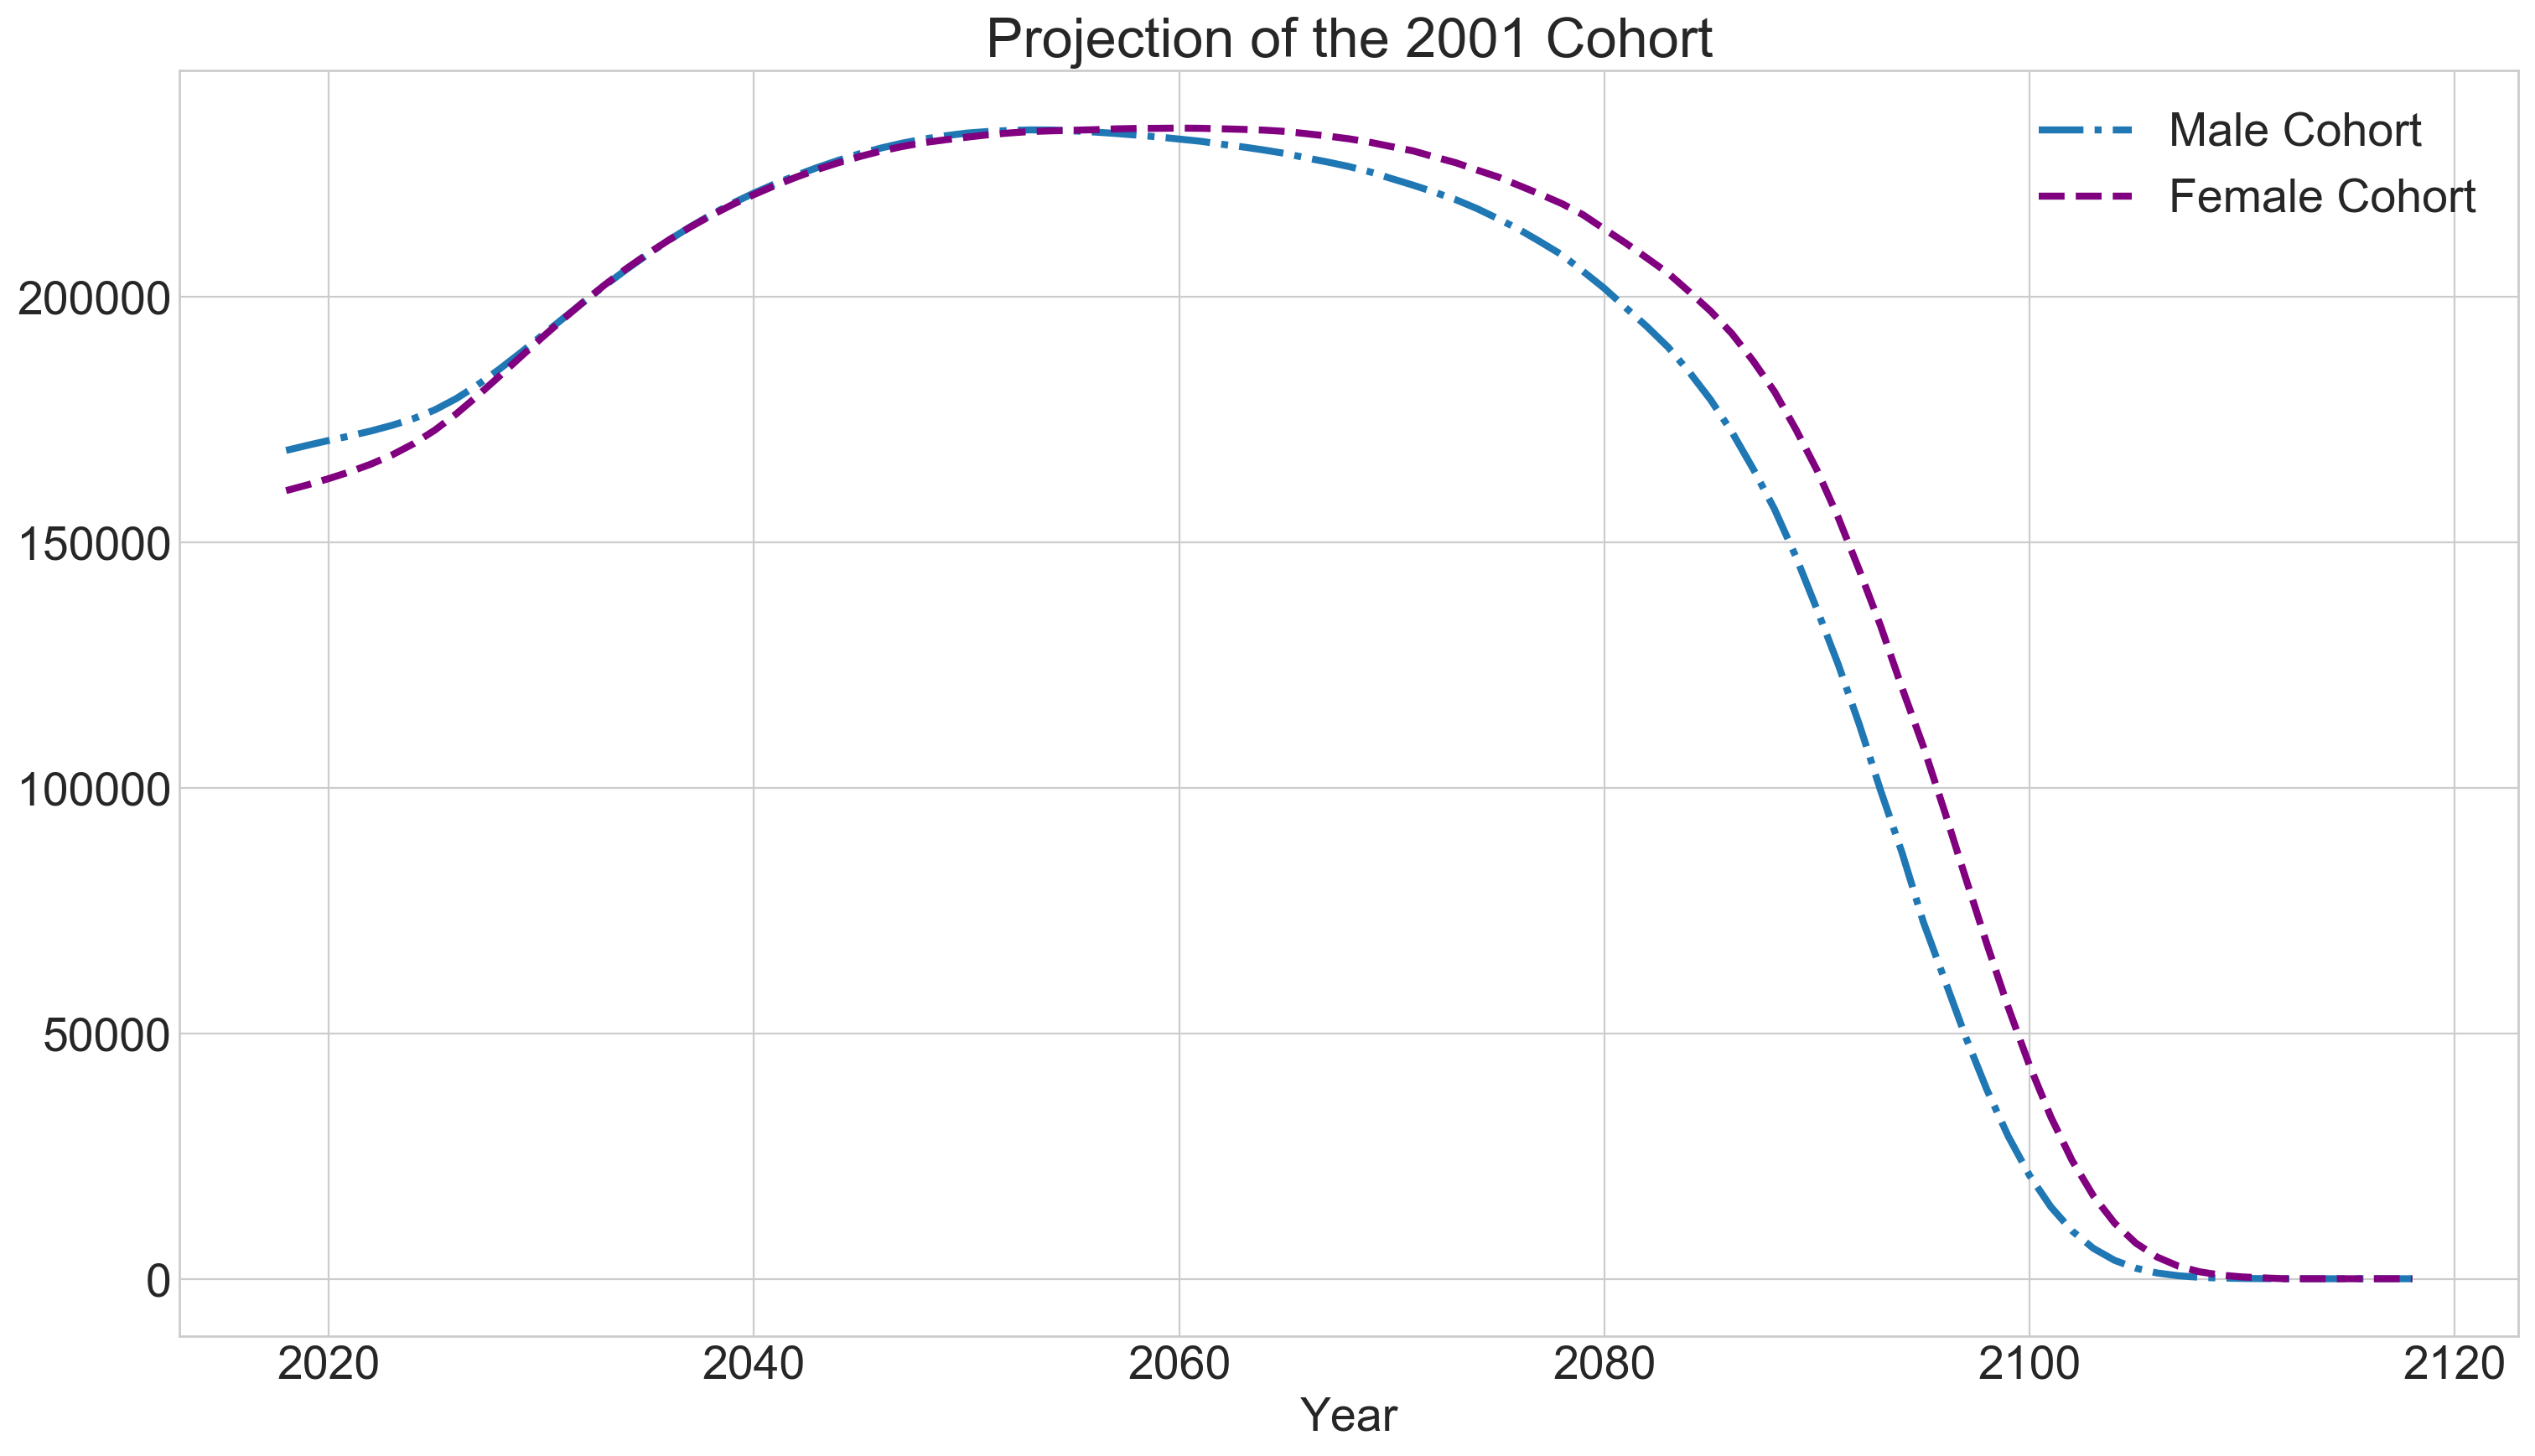

In [91]:
#Start with the generation born in 2001
#Starts work at 2019
#Retires in 2047
#Cohort dies in 2111

plt.plot(male_pop[2001],'-.', label = 'Male Cohort')
plt.plot(female_pop[2001],'--' ,color = 'purple', label = 'Female Cohort')
plt.title('Projection of the 2001 Cohort')
plt.xlabel('Year')
plt.legend()
plt.show()

A generational account is defined as the net present value of contributions paid, benefits received, for an entire generation. They are forward looking, meaning they do not take into account previous payments by the generation. Values are discounted using a real risk free rate of 1.61%, which is the interest rate on Canadian treasury bonds as of July 2019. 

There are two functions that need to be formally introduced:
1. Generational account for generation $i$ divided by the NPV of received benefits for generation $i$
2. Internal Rate of Return for generation $i$

**Generational Account**
\begin{equation}
GA_{it} = \sum^{n-(t-i)}_{s=1} \frac{(B_{it} - C_{it})}{(1+r)^{s}}
\end{equation}

**Net Present Value of Benefits**
\begin{equation}
NPV B_{it} =\sum^{n-(t-i)}_{s=b} \frac{(B_{it} - C_{it})}{(1+r)^{s}}
\end{equation}

**Internal Rate of Return**
\begin{equation}
IRR_{it} = NPV_{it} = \sum^{n-(t-i)}_{s=1} \frac{(B_{it} - C_{it})}{(1+r)^{s}} = 0 
\end{equation}

* n = Maximum number of years lived = 110
* t = year
* i = year the cohort was born
* b = retirement year
* r = interest rate

The functions below calculate the following statistics:
1. A generational account for a single generation divided by the net present value of benefits
2. The generational accounts born between 1954 and 2018 divided by the net present value of benefits for all generations
3. A Generational account for a single generation calculated in each year of the simulation
4. The internal rate of return for a single generation

In [92]:
def gen_accounts(df, interest_rate):
    cohorts = df.columns
    benefits = df[df>0].fillna(0)
    ga_accounts = []
    
    for cohort in cohorts:
        ga = np.npv(interest_rate, df[cohort])
        ga_benefits = np.npv(interest_rate, benefits[cohort])
        ga_accounts.append(ga/ga_benefits)
        
    ga_accounts = pd.Series(data = ga_accounts, index = cohorts)
    
    return ga_accounts

In [93]:
def gen_accounts_same_denominator(df, interest_rate):
    cohorts = df.columns
    #Benefits
    male_benefits = cohort_old_male[cohort_old_male > 0].fillna(0)
    female_benefits = cohort_old_female[cohort_old_female > 0].fillna(0)
    benefits  = male_benefits+female_benefits
    benefits = benefits.sum(axis=1)
    npv_benefits = np.npv(interest_rate, benefits)
    ga_accounts = []
    
    for cohort in cohorts:
        ga = np.npv(interest_rate, df[cohort])
        ga_accounts.append(ga/npv_benefits)
        
    ga_accounts = pd.Series(data = ga_accounts, index = cohorts)
    
    return ga_accounts

In [94]:
def ga_time(df, df_old, cohort, interest_rate):
    ga_time = []
    total_years = len(df[cohort])
    age = []
    benefits = df_old[df_old>0].fillna(0)
    npv_benefits = np.npv(interest_rate, benefits[cohort])
    
    for i in range(total_years):
        age.append(first_year_cpp()-cohort + i)
        ga_time.append(np.npv(interest_rate, df[cohort].values[i:]))
    
    ga_time = pd.Series(data = ga_time/npv_benefits, index = age)
    
    return ga_time

In [95]:
def internal_ror(cohorts, df):
    i_ror = []
    
    for cohort in cohorts:
        i_ror.append(np.irr(df.loc[:,cohort]))
        
    return pd.Series(data = i_ror, index = cohorts)

In [96]:
#Runs the simulation
cohort_old_male, cohort_old_female = old_cpp(male_pop, female_pop, 0.011, 0.02)
cohort_new_male, cohort_new_female = new_cpp(male_pop, female_pop, 0.011, 0.02)

In [97]:
#Updates the benefits for generations who work in the old and the reformed system
cohort_new_male = transition_generations(cohort_old_male, cohort_new_male)
cohort_new_female = transition_generations(cohort_old_female, cohort_new_female)

[]

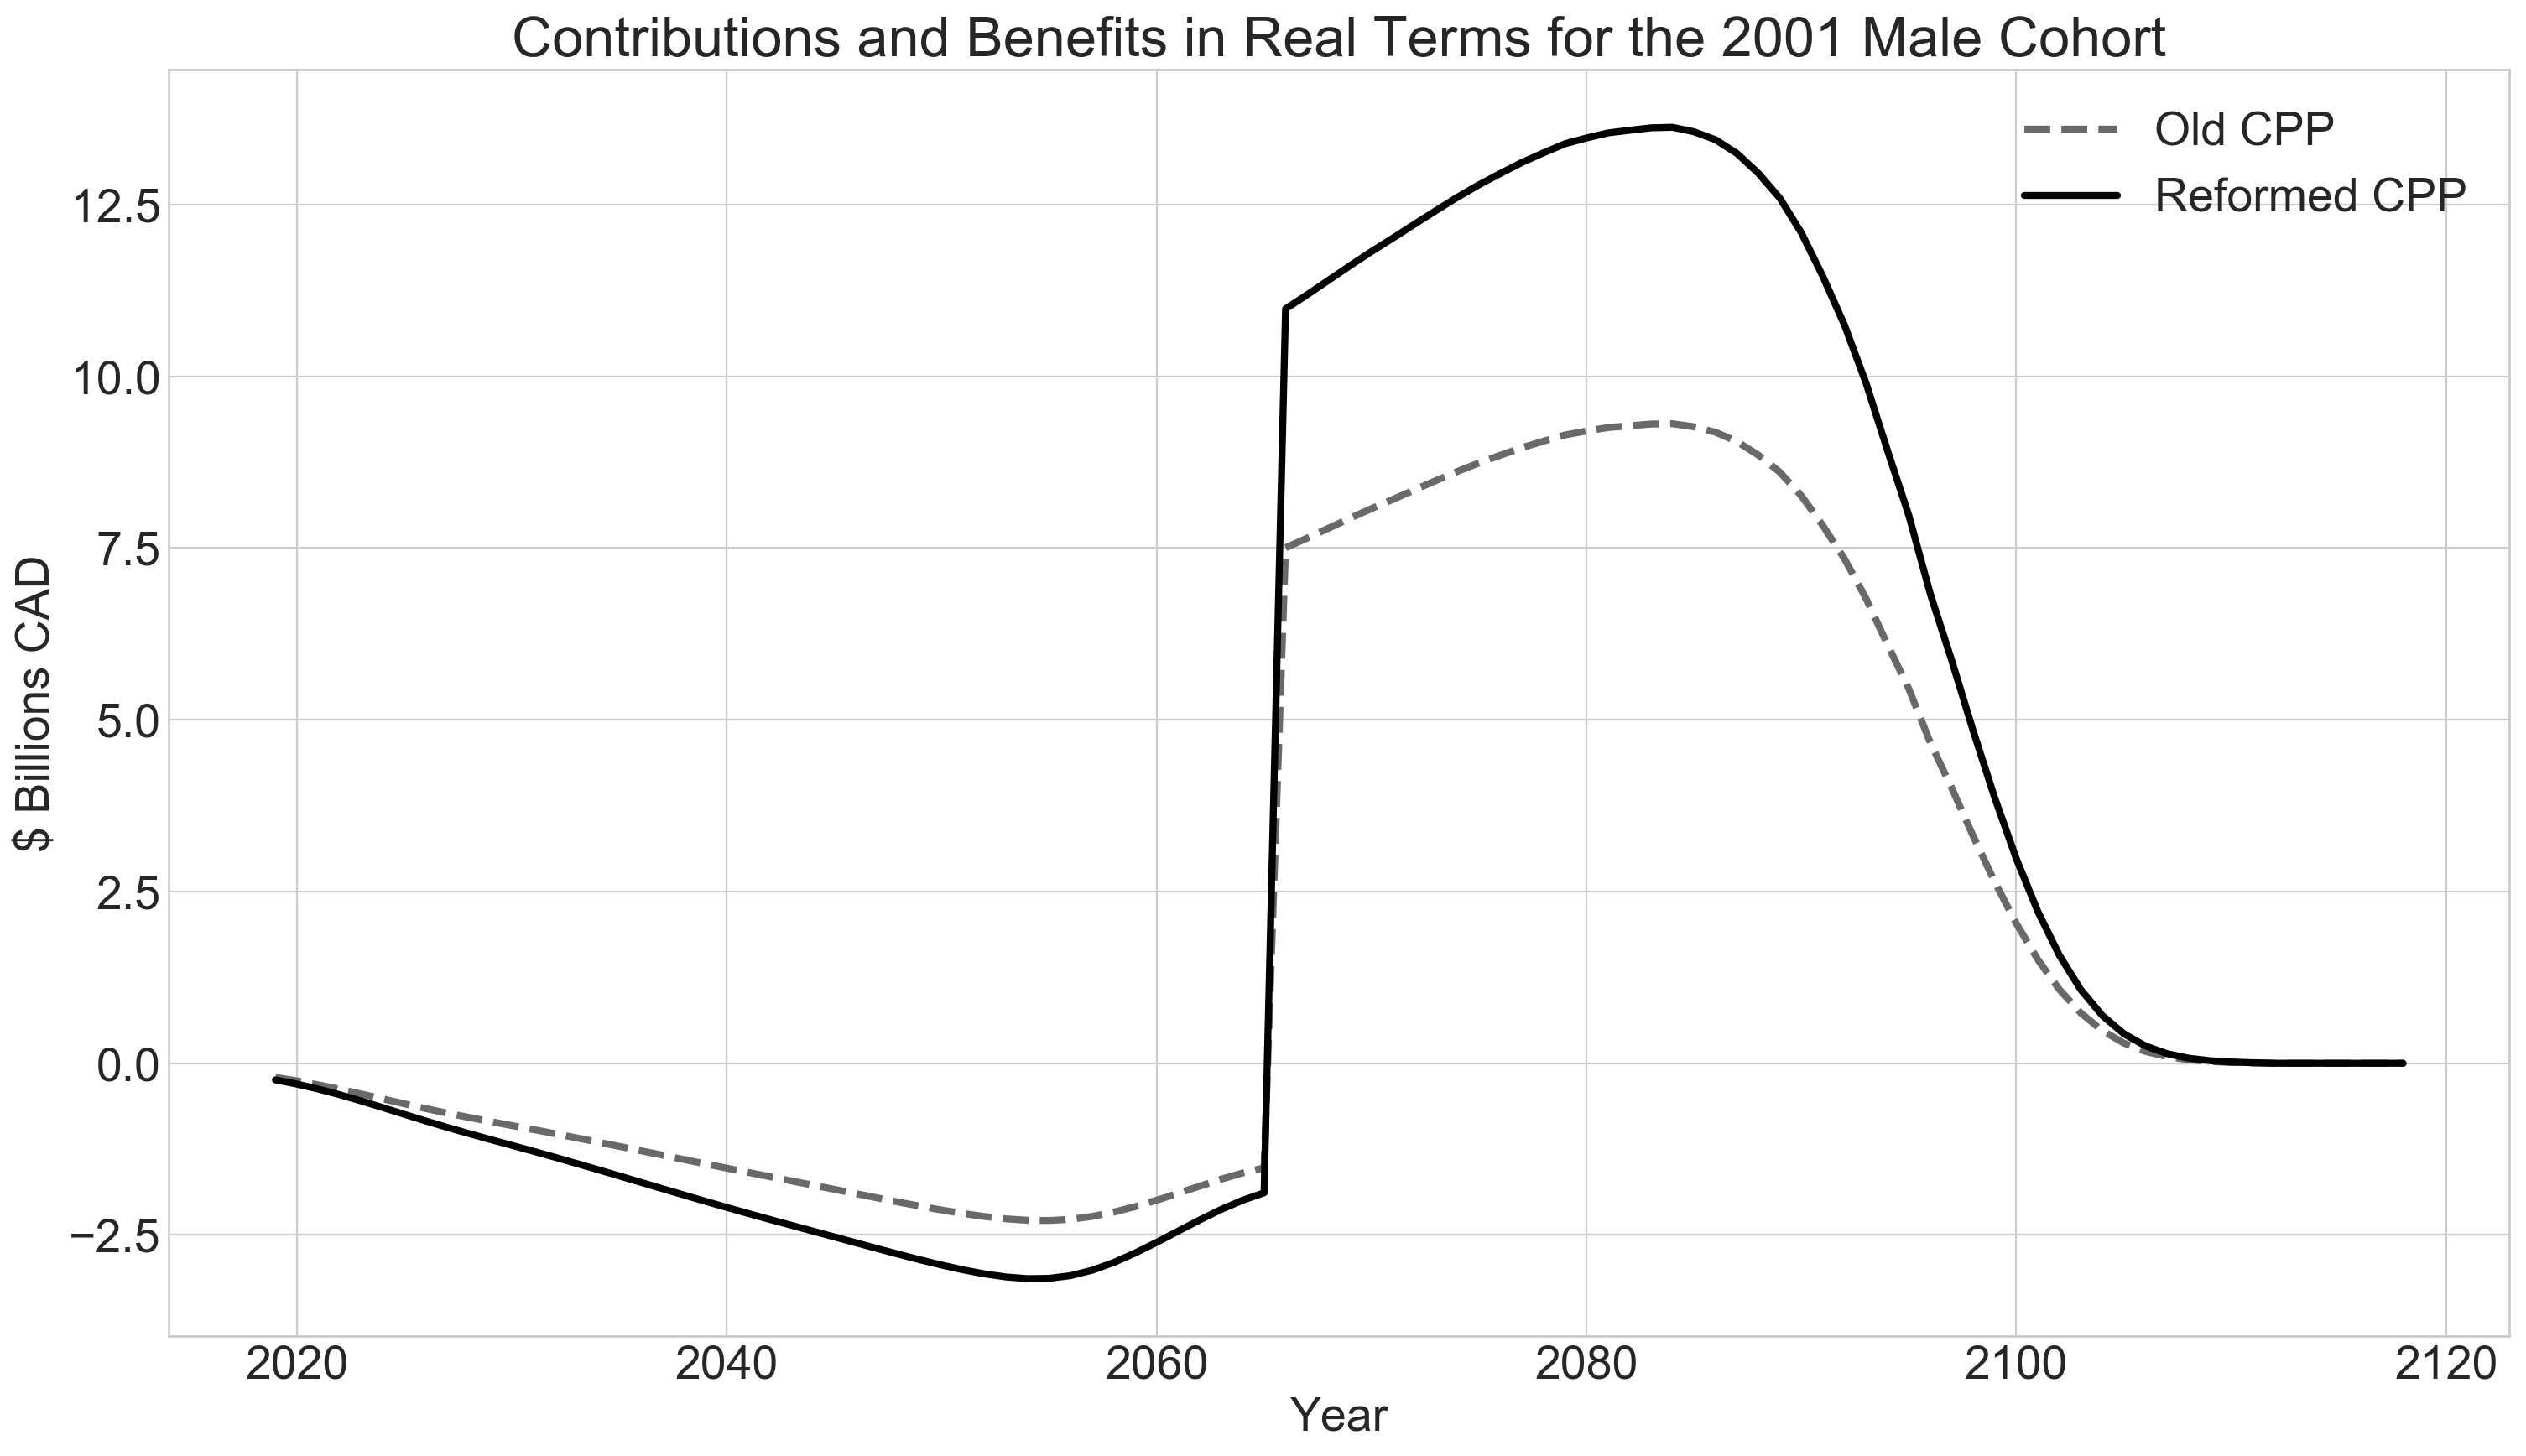

In [98]:
#Contributions and benefits generated by the simulation for the 2001 cohort
plt.plot(cohort_old_male[2001]*inflate_income()/(1000000000), '--', color = 'dimgray',label = 'Old CPP')
plt.plot(cohort_new_male[2001]*inflate_income()/(1000000000), color='black',label = 'Reformed CPP')
plt.title('Contributions and Benefits in Real Terms for the 2001 Male Cohort')
plt.xlabel('Year')
plt.ylabel('$ Billions CAD')
plt.legend()
plt.plot()

[]

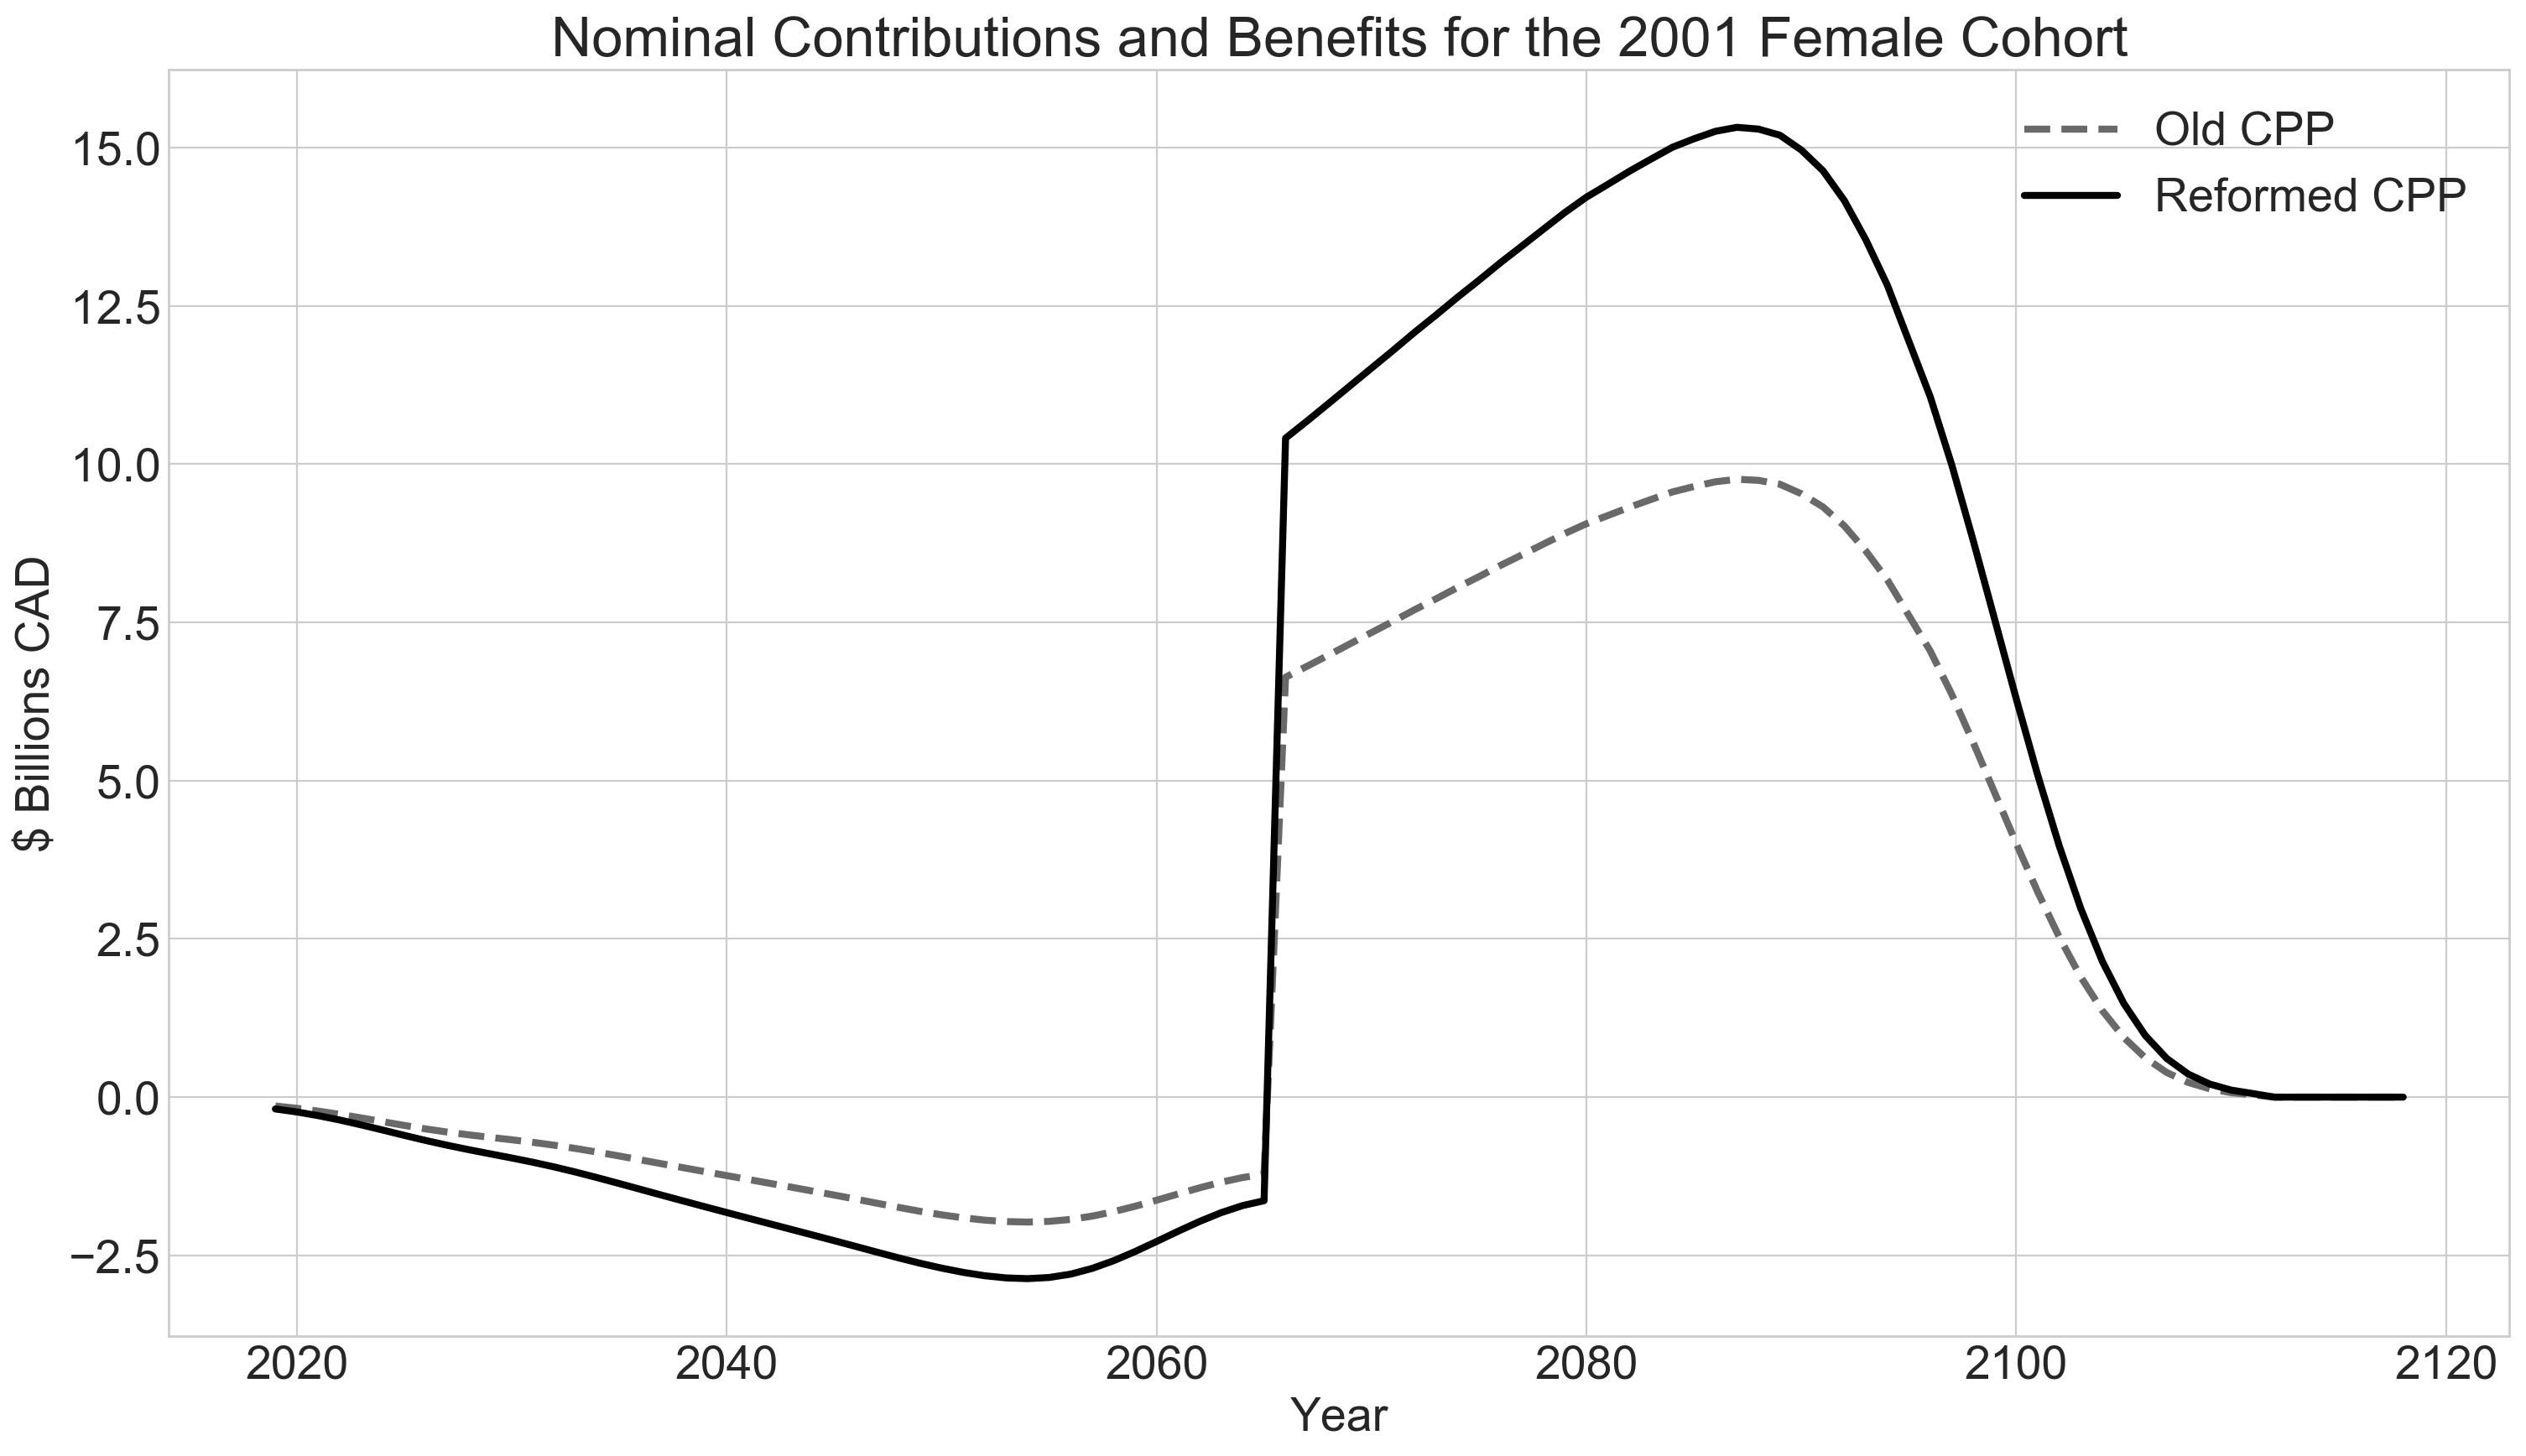

In [99]:
plt.plot(cohort_old_female[2001]*inflate_income()/(1000000000), '--', color = 'dimgray',label = 'Old CPP')
plt.plot(cohort_new_female[2001]*inflate_income()/(1000000000), color='black',label = 'Reformed CPP')
plt.title('Nominal Contributions and Benefits for the 2001 Female Cohort')
plt.xlabel('Year')
plt.ylabel('$ Billions CAD')
plt.legend()
plt.plot()

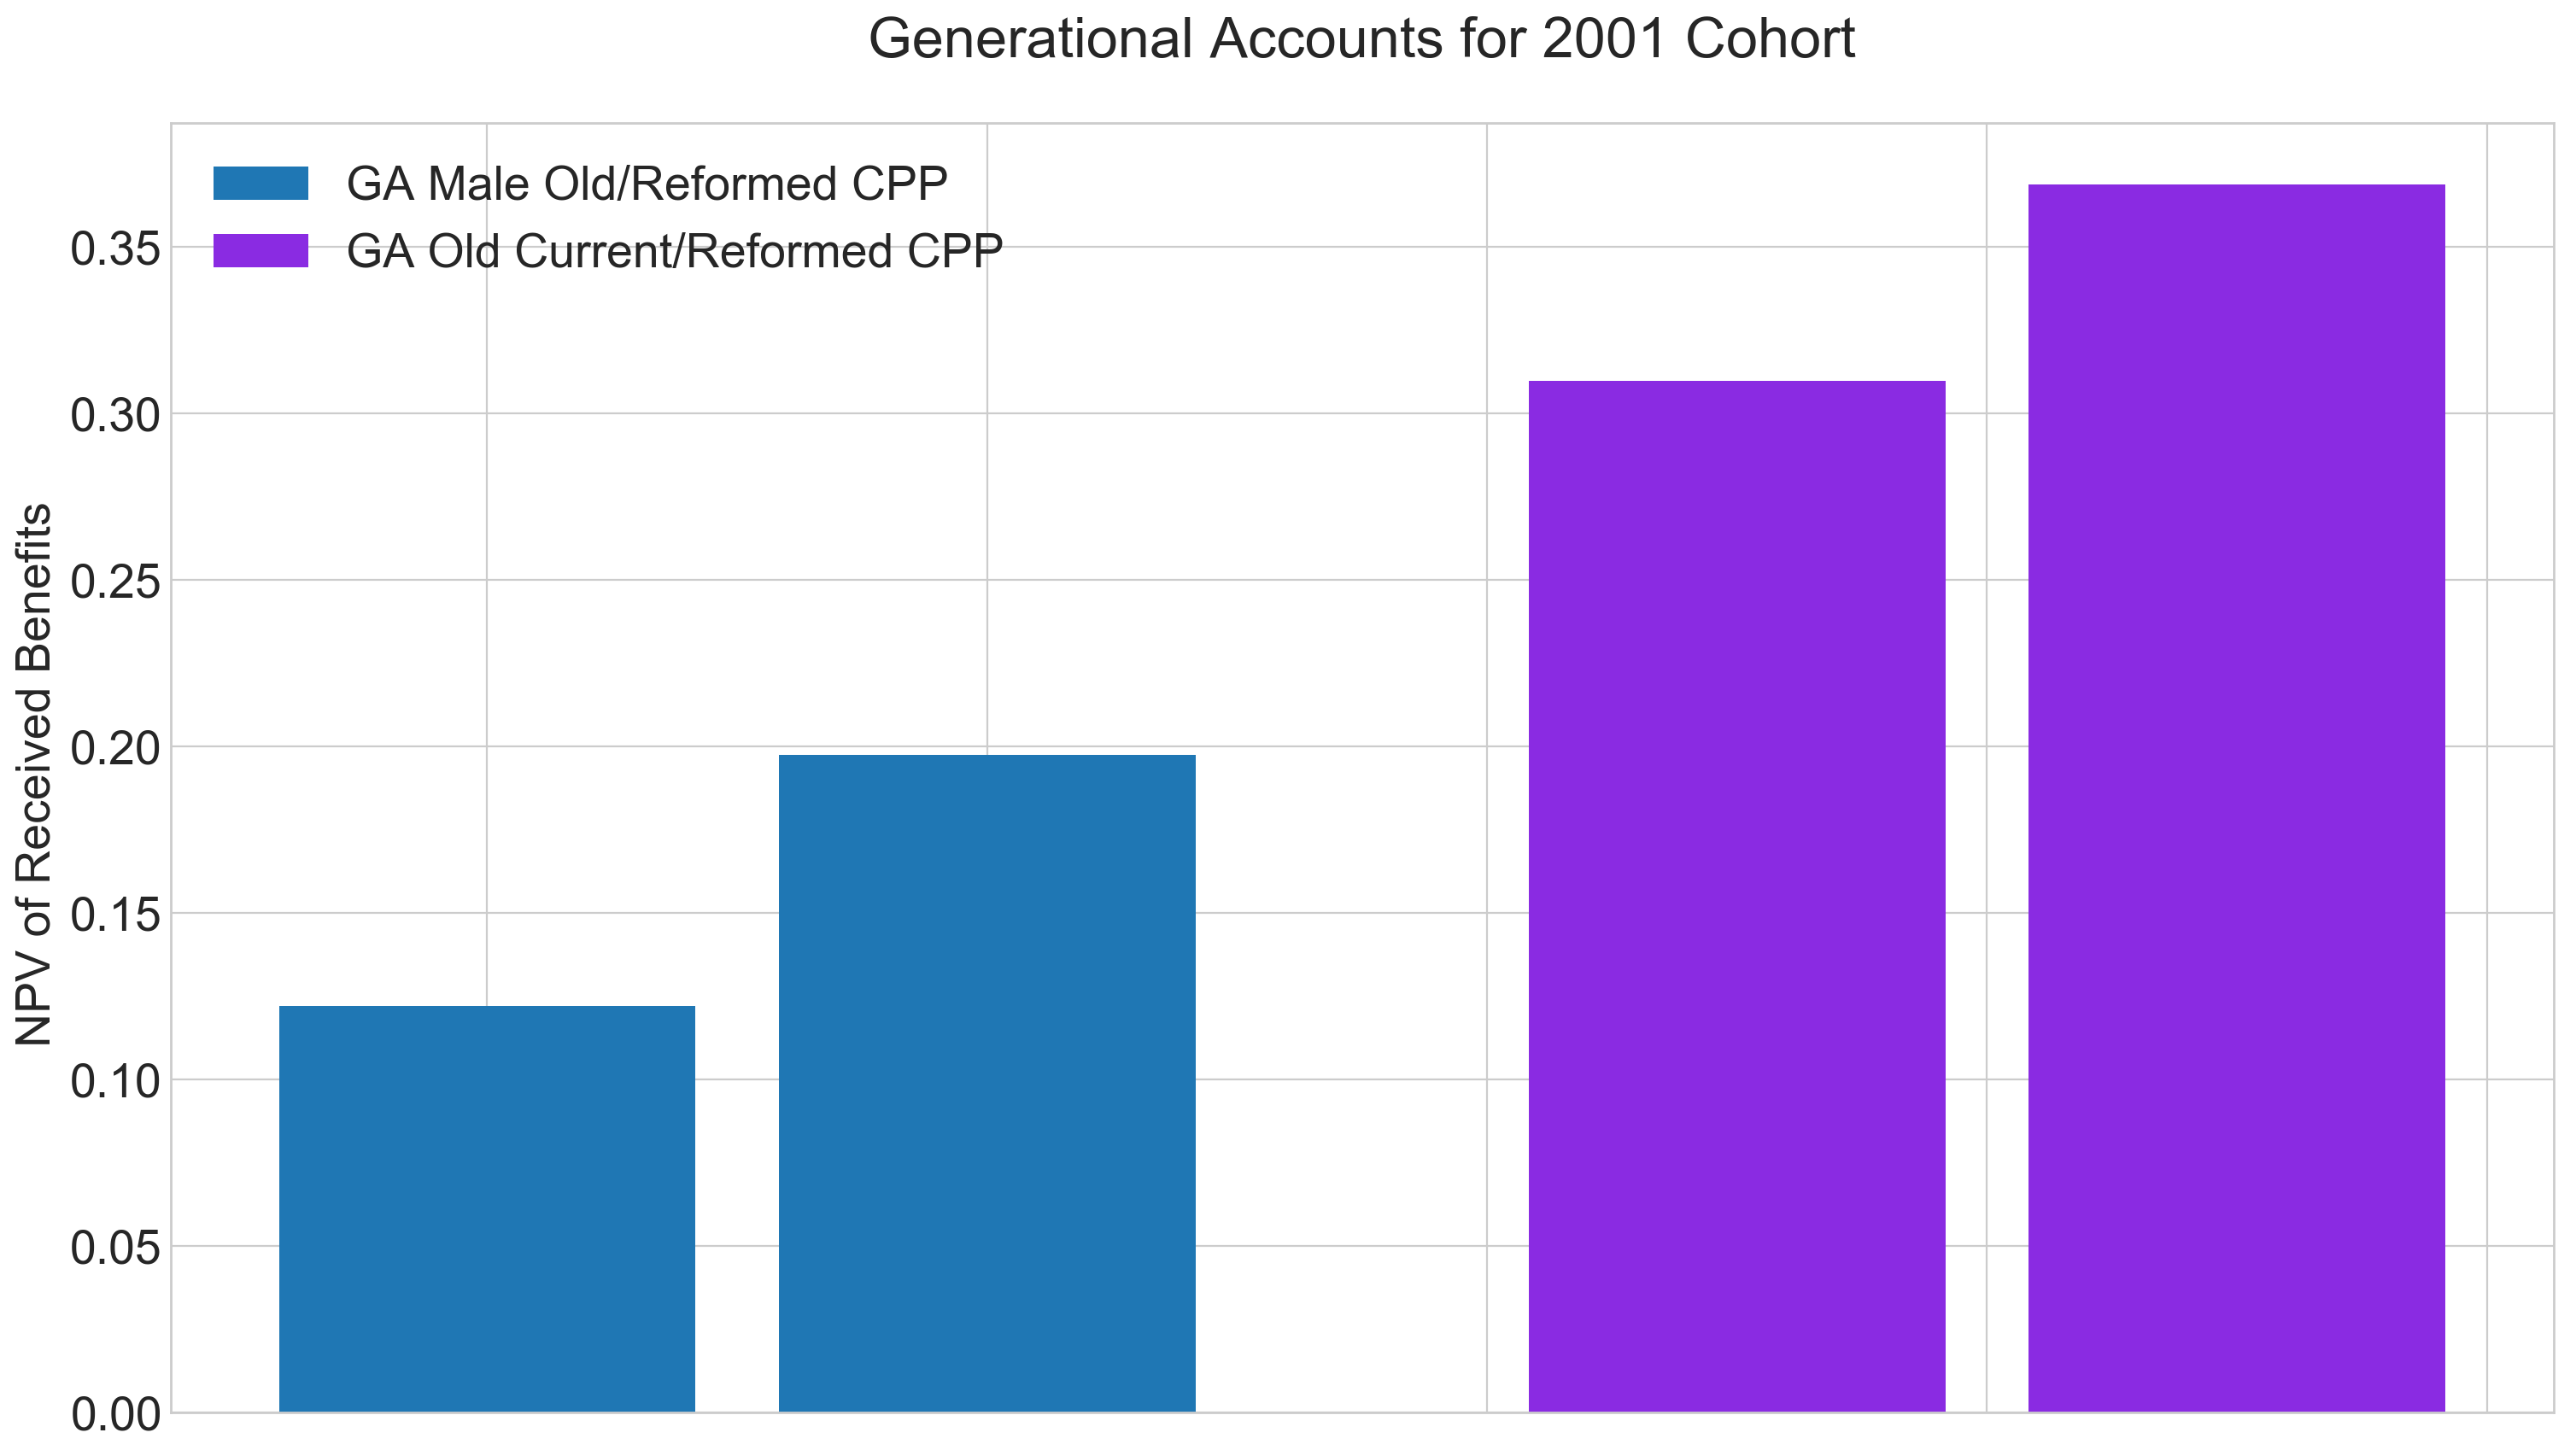

In [100]:
#Generational accounts for the 2001 cohort.
year = 2001
interest_rate = risk_free_rate()
ga_male = [gen_accounts(cohort_old_male.loc[:,year:year],interest_rate).values[0], 
           gen_accounts(cohort_new_male.loc[:,year:year],interest_rate).values[0]]
ga_female = [gen_accounts(cohort_old_female.loc[:,year:year],interest_rate).values[0], 
             gen_accounts(cohort_new_female.loc[:,year:year],interest_rate).values[0]]
labels = ['a', 'b']

bar_width= 1/6
index = np.arange(2)
plt.bar([1,1.2], ga_male, bar_width, label='GA Male Old/Reformed CPP')
plt.bar([1.5,1.7], ga_female, bar_width, label = 'GA Old Current/Reformed CPP', color = 'blueviolet')
plt.legend(loc = 'best')
plt.title('Generational Accounts for 2001 Cohort',  y=1.04)
plt.ylabel('NPV of Received Benefits ')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

[]

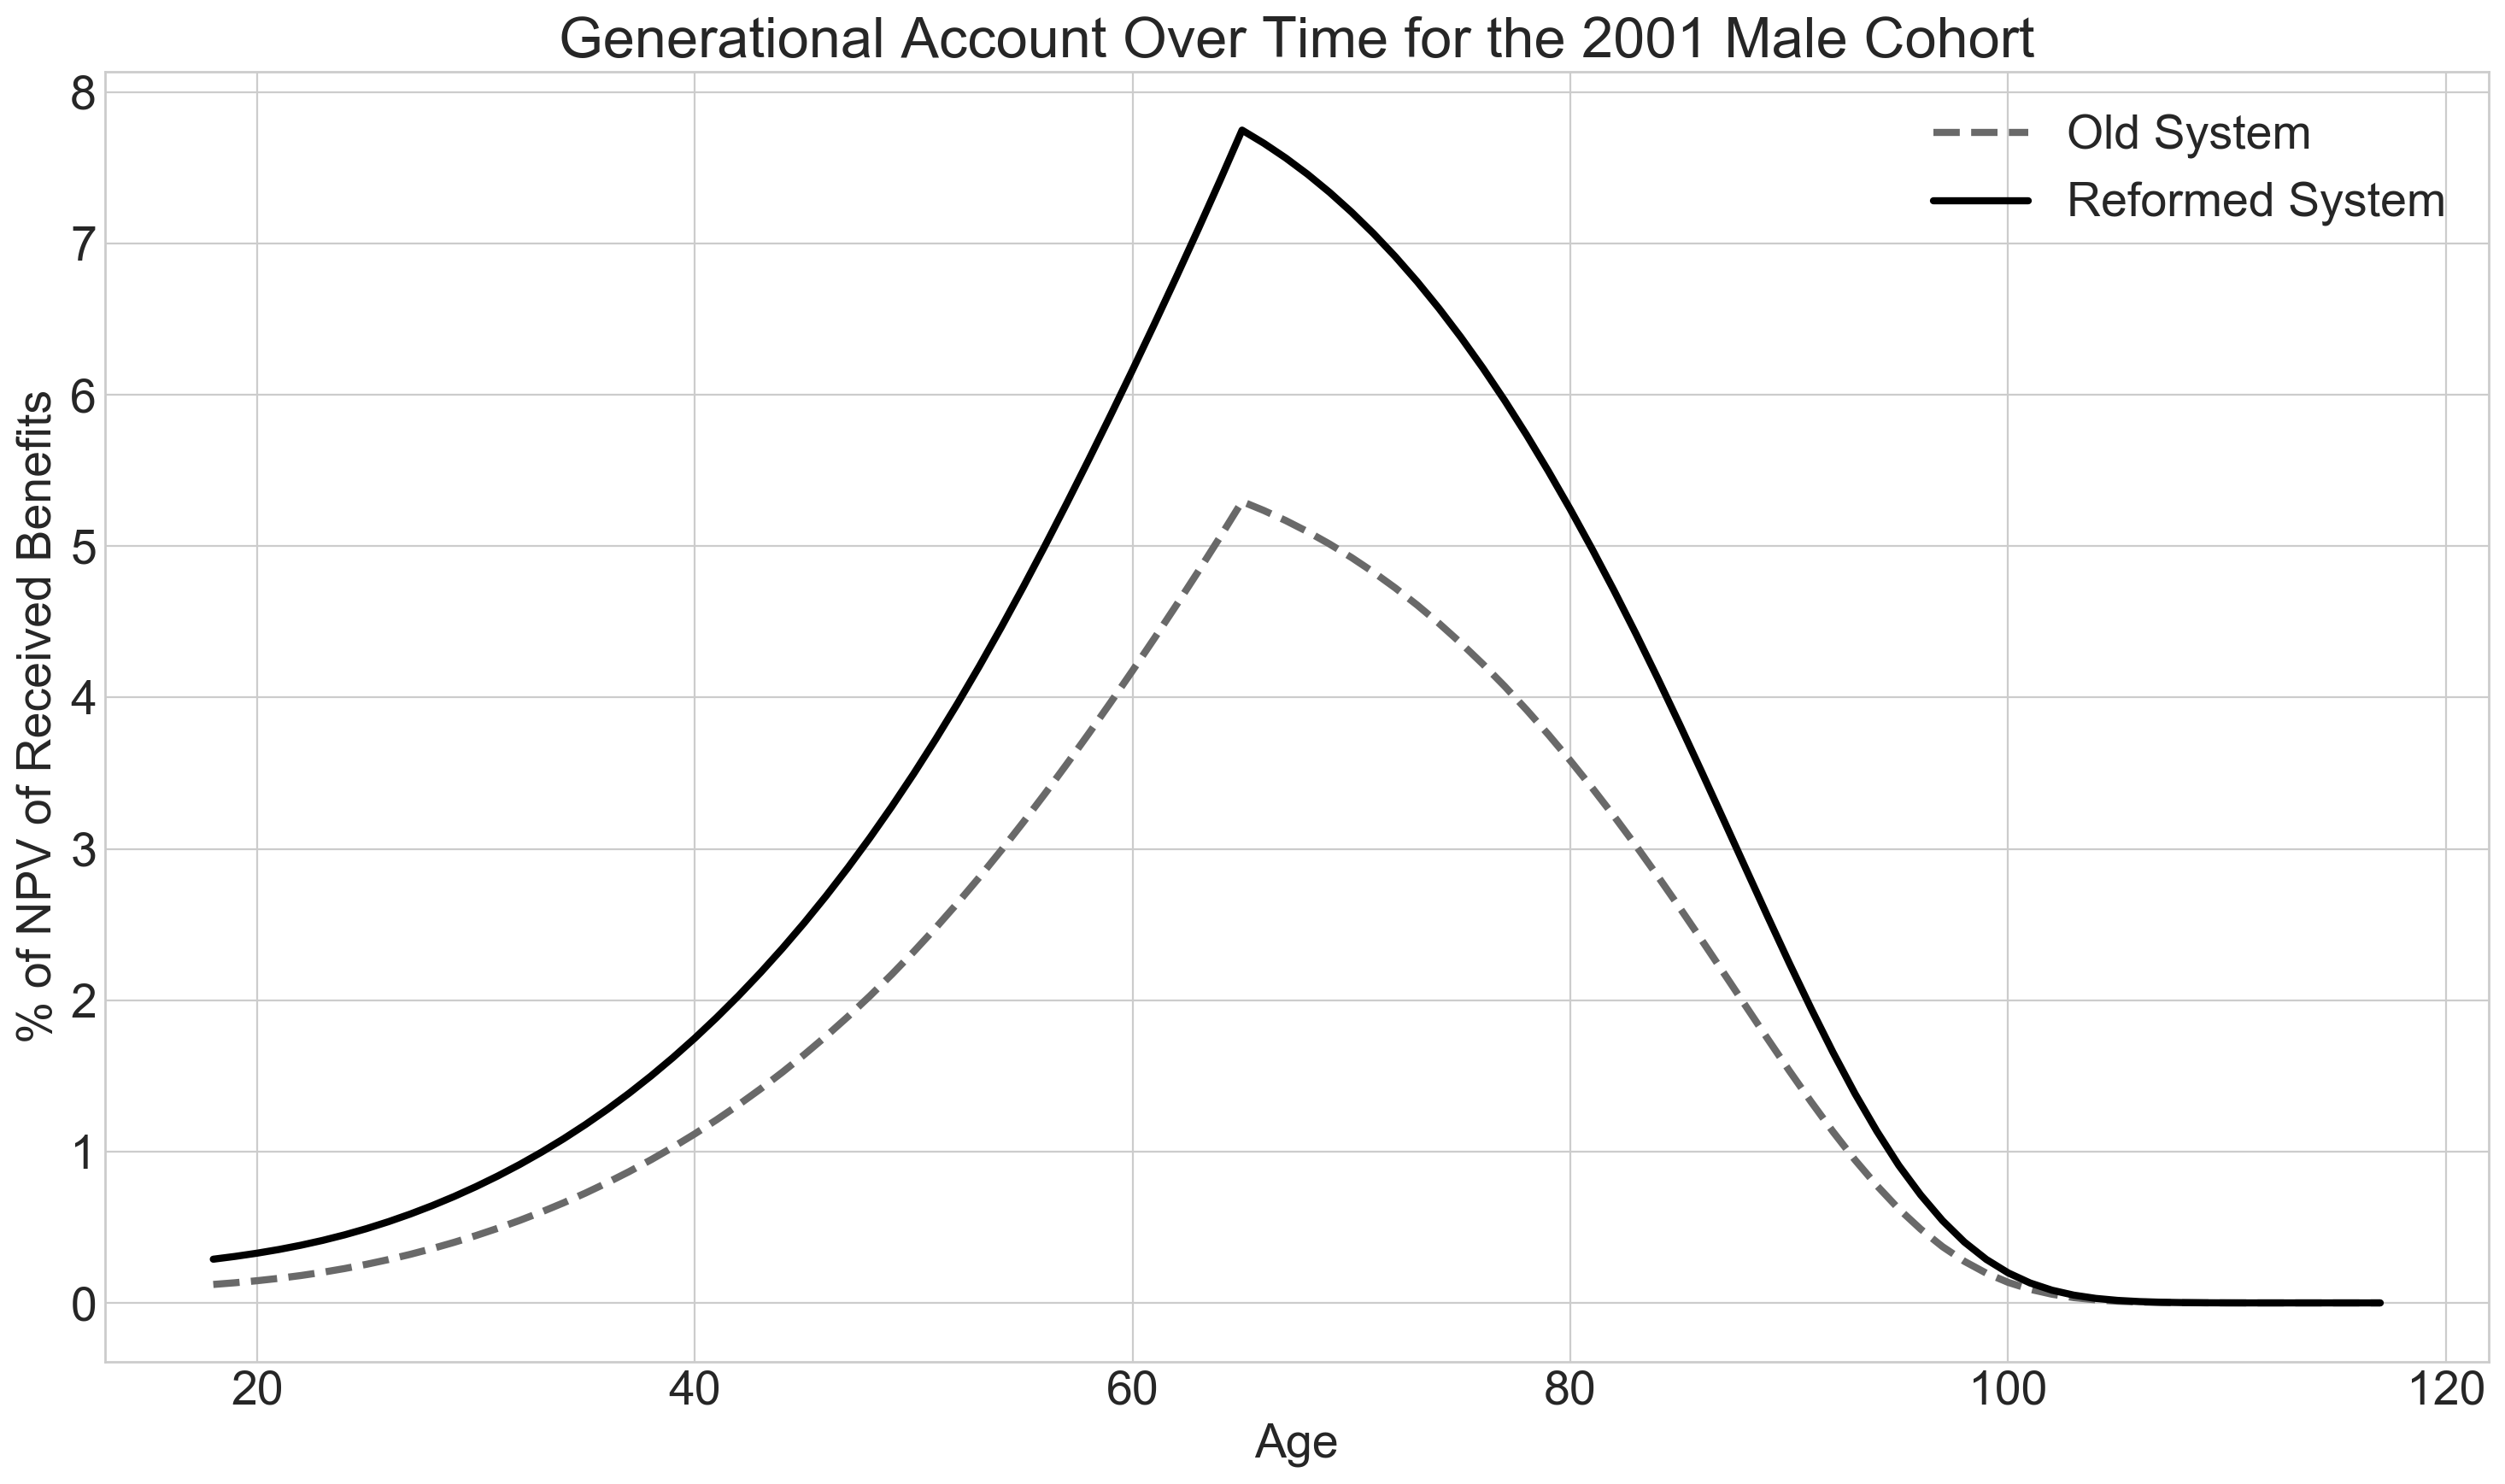

In [101]:
#The generational account over time for the 2001 cohort.
plt.plot(ga_time(cohort_old_male,cohort_old_male, 2001, risk_free_rate()), '--', color = 'dimgray', label = 'Old System')
plt.plot(ga_time(cohort_new_male,cohort_old_male, 2001, risk_free_rate()), color='black', label = 'Reformed System')
plt.ylabel('% of NPV of Received Benefits')
plt.xlabel('Age')
plt.title('Generational Account Over Time for the 2001 Male Cohort')
plt.legend()
plt.plot()

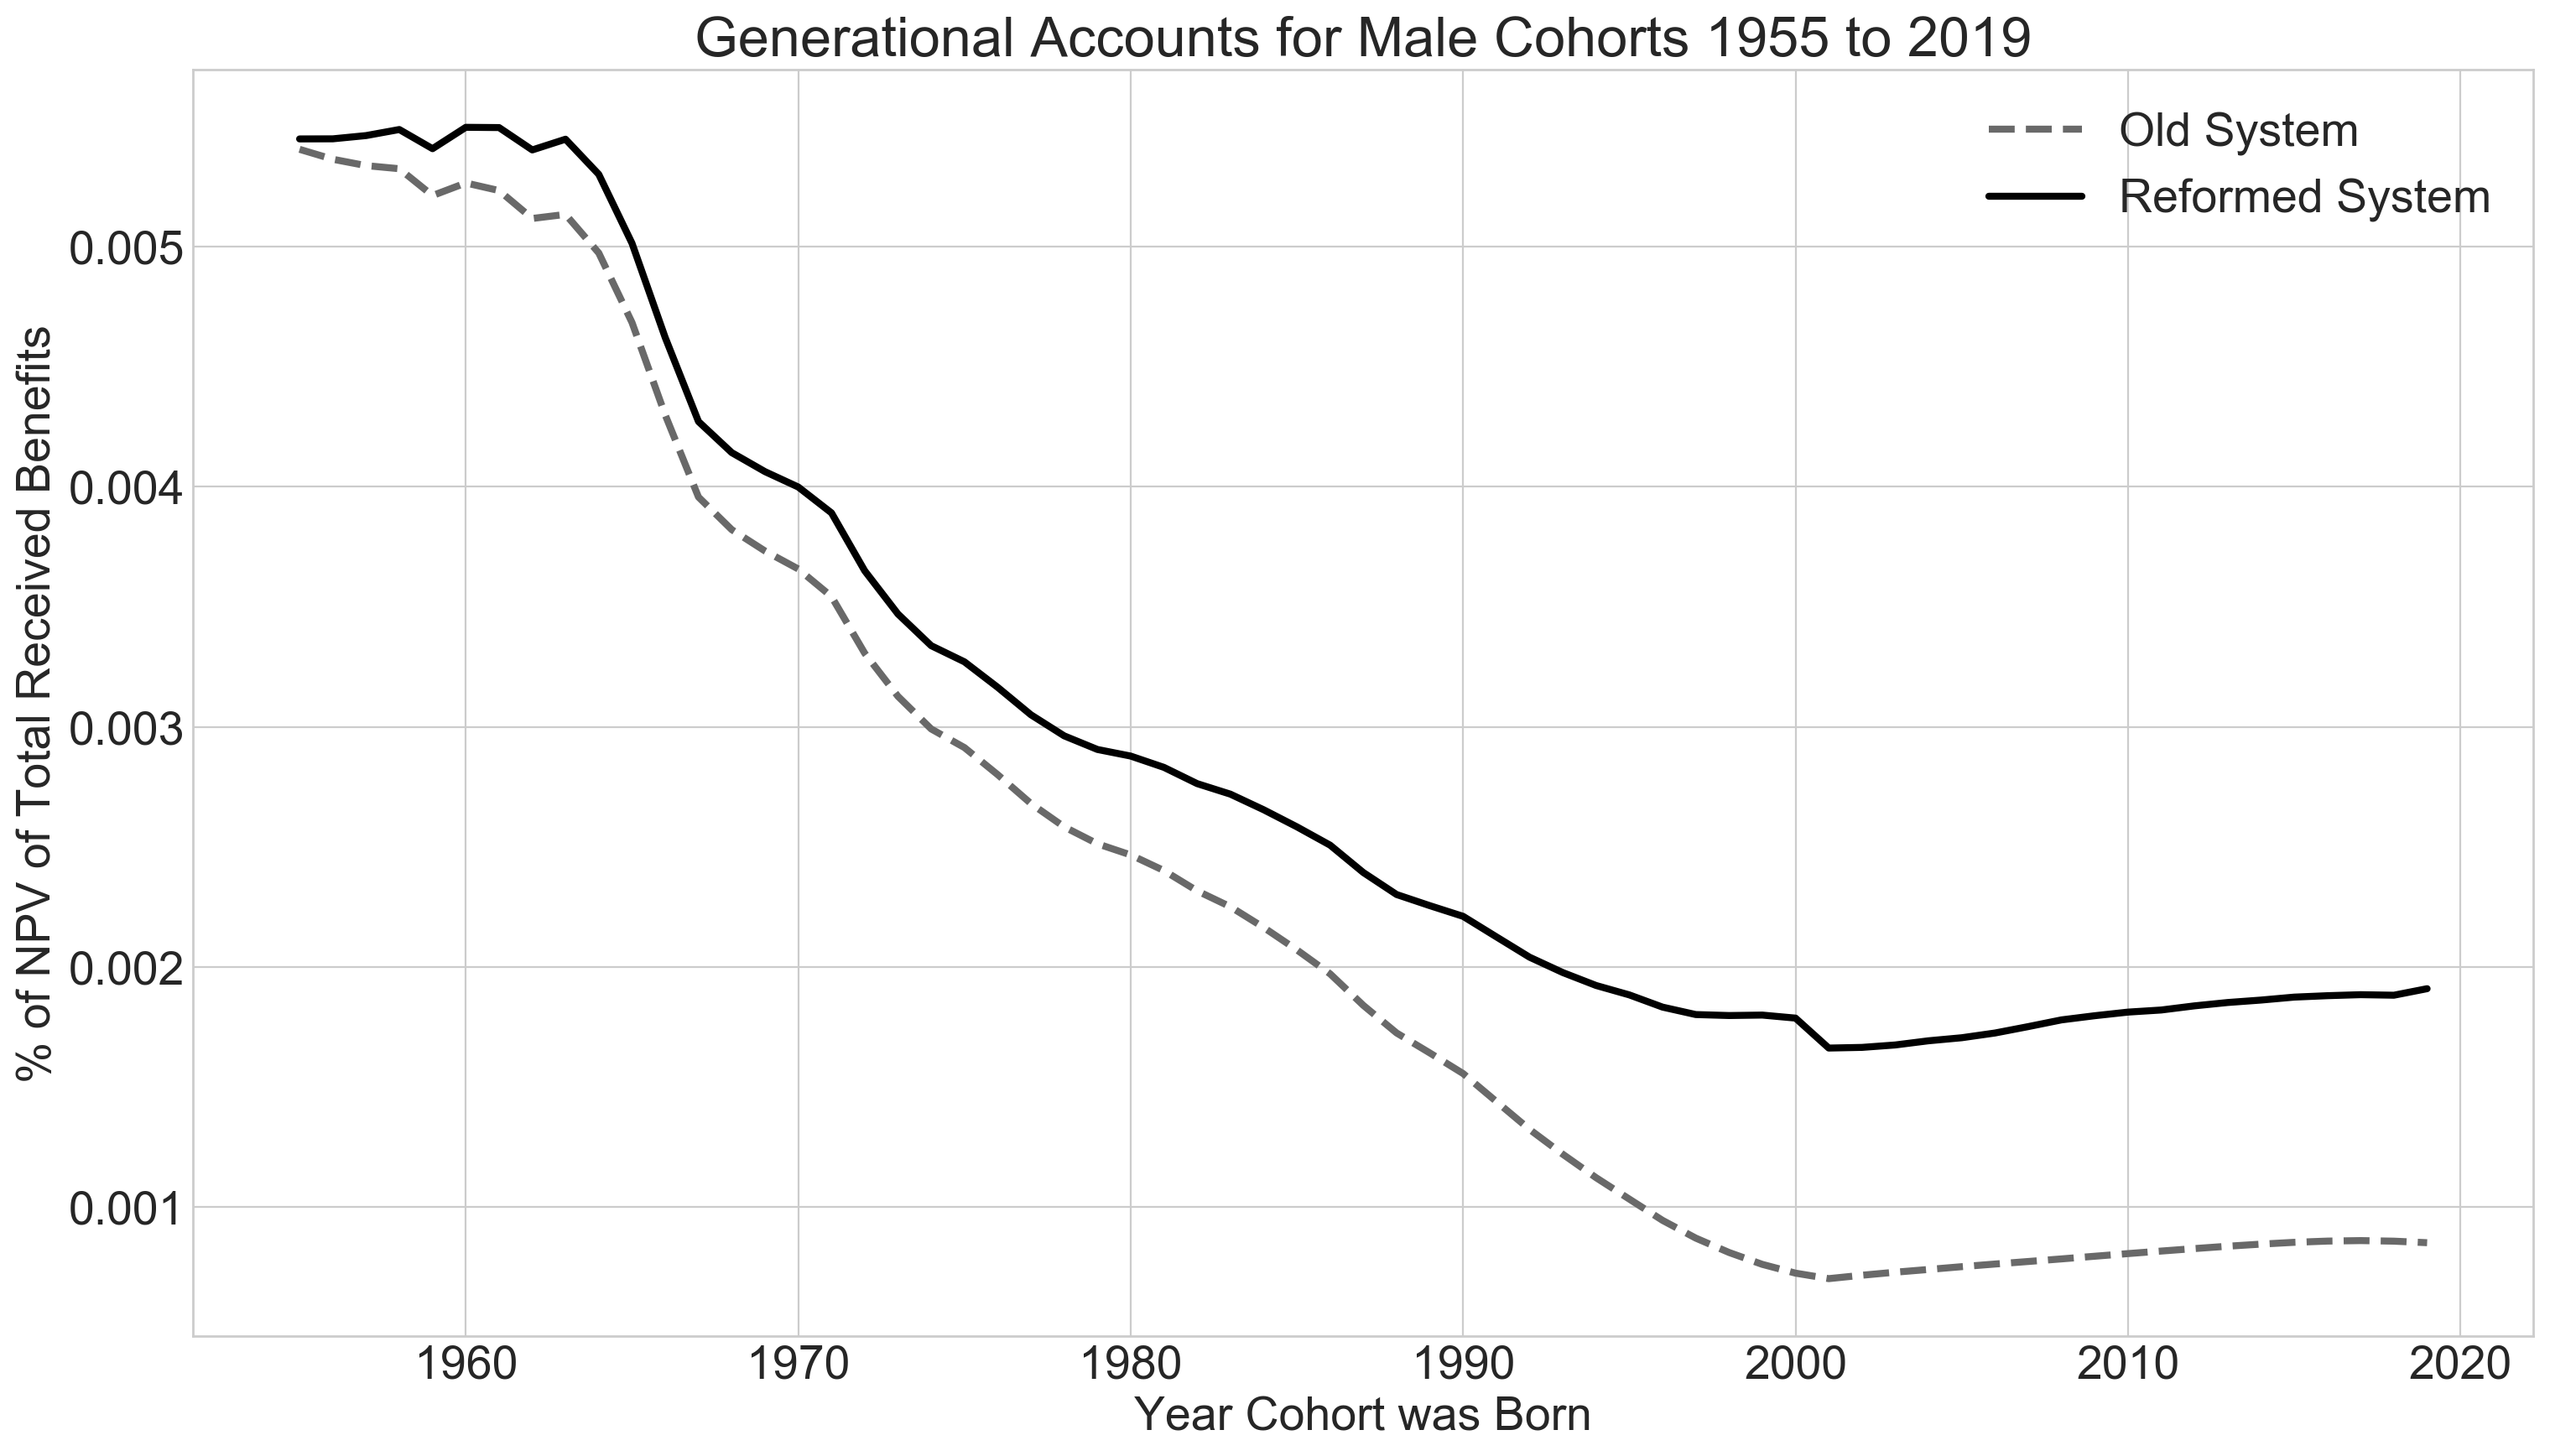

In [104]:
#The generational accounts for the cohorts born between 1955 and 2019 divided by the NPV of received benefits
plt.plot(gen_accounts_same_denominator(cohort_old_male.loc[:,:2019],
                                       risk_free_rate()), '--', color = 'dimgray', label = 'Old System')
plt.plot(gen_accounts_same_denominator(cohort_new_male.loc[:,:2019],
                                       risk_free_rate()), color='black', label = 'Reformed System')
plt.title('Generational Accounts for Male Cohorts 1955 to 2019')
plt.xlabel('Year Cohort was Born')
plt.ylabel('% of NPV of Total Received Benefits')
plt.legend()
plt.show()

In [103]:
#The internal rate of return for the 2001 cohort.
print(internal_ror([2001], cohort_old_male).values[0], internal_ror([2001], cohort_old_female).values[0])
print(internal_ror([2001], cohort_new_male).values[0], internal_ror([2001], cohort_new_female).values[0])

0.03981142368607293 0.046428524548764116
0.042399572722461976 0.04894752111471279


## Section 3.4 Financial Projections

The following calculations are computed in each year $t$:
1. Total contributions = Pensionable Earnings * Contribution Rate
2. Benefits = Total benefits paid out to all generations
3. Contribution Rate = Contribution rate (0.099 for the old system or 0.119 for the reformed system)
4. Contributory Earnings  = $\frac{Contributions}{Contribution \thinspace Rate}$
5. Net Cash Flow = Contributions - Benefits
6. PAYG Rate = $\frac{Contributory \thinspace Earnings}{Benefits}$
7. Investment Income = CPPIB Fund * Rate of Return of Fund
8. Asset/Expenditure Ratio = $\frac{CPPIB \thinspace Fund}{Benefits}$
9. Minimum Contribution Rate = The minimum contribution rate where the Asset/Expenditure ratio is the same in the year 2030, and 2080. 
10. Reforms Triggered = If the minimum contribution rate is greater contribution rate (0.099, or 0.119) then reforms are triggered. 

To build the financial statement three functions are needed: 
1. CPPIB Value - This takes the value of the CPPIB fund, generates the investment income figure, and then adds net cash flow to it. If net cash flow is positive, then it is added to investment income and used to grow the fund. If net cash flow is negative, then investment income is used to help finance benefits. 
2. Minimum Contribution Rate - This function finds a contribution rate that ensures the CPPIB fund is the same in the year 2030, and 2080 (10 years, and 60 years, into the future). 
3. Financial Statement - This function just aggregates all the calculations described above. 

In [106]:
#Function that determines value of the CPPIB fund
def cppib(starting_fund, ror, net_cash_flow):
    cppib = [starting_fund]
    investment_income = [starting_fund*ror]
    
    for i in range(simulated_years_cpp()-1):
        cppib.append(cppib[-1]*(1+ror)+(net_cash_flow.values[i]))
        investment_income.append(cppib[-1]*(1+ror)-cppib[-1])
    
    return cppib, investment_income

In [107]:
#Finds the minimum contribution rate that maintains the steady state funding level
def minimum_contribution_rate(contributory_earnings, benefits, ror_cppib):
    contribution_rate = 0.20
    
    min_balance = 10
    
    while min_balance > 0.75:
    
        net_cash_flow = contributory_earnings*contribution_rate - benefits
        cppib_value, investment_income = cppib(349306, ror_cppib, net_cash_flow)
        balance = cppib_value/benefits
        min_balance = abs(balance[2030] - balance[2080])
        contribution_rate += -0.001
           
    return np.round(contribution_rate+0.001,3)

In [108]:
#Creates the financial projection table
def financial_projections(df_male, df_female, contribution_rate, cppib_return):

    male_contributions = df_male[df_male < 0].fillna(0)
    female_contributions = df_female[df_female < 0].fillna(0)
    
    #Benefits
    male_benefits = df_male[df_male > 0].fillna(0)
    female_benefits = df_female[df_female > 0].fillna(0)
    
    #Aggregates
    contributions_total = (male_contributions.sum(axis=1) + female_contributions.sum(axis=1))*inflate_income()
    benefits_total = (male_benefits.sum(axis=1) + female_benefits.sum(axis=1))*inflate_income() + historic_pensions
    
    income_projections = pd.DataFrame(index = create_years(first_year_cpp(), last_year()))
    income_projections['Contribution_Rate'] = contribution_rate
    income_projections['Contributions'] = (contributions_total*-1)/1000000
    income_projections['Benefits'] = (benefits_total)/1000000
    income_projections['Contributory_Earnings'] =income_projections['Contributions']/contribution_rate
    income_projections['Net_cash_flow'] = income_projections['Contributions'] - income_projections['Benefits']
    income_projections['PAYG_Rate'] = income_projections['Benefits']/income_projections['Contributory_Earnings']

    
    cppib_value, investment_income = cppib(349306, cppib_return, income_projections['Net_cash_flow'])
    
    income_projections['Investment_income'] = investment_income
    income_projections['cppib_value'] = cppib_value
    income_projections['AE_Ratio']  = income_projections['cppib_value']/income_projections['Benefits'] 
    income_projections['Min_cont_rate'] = minimum_contribution_rate(income_projections['Contributory_Earnings'], income_projections['Benefits'], cppib_return)
  
    if income_projections['Min_cont_rate'].values[0] > contribution_rate:
        reforms = 'Yes'
    else:
        reforms = 'No'
    
    income_projections['Reforms_triggered'] = reforms
    
    #Reorder Columns
    columns = ['Min_cont_rate',
           'Contribution_Rate',
           'PAYG_Rate',
           'Contributory_Earnings',
           'Contributions',
           'Benefits',
           'Net_cash_flow',
           'Investment_income',
           'cppib_value',
           'AE_Ratio',
           'Reforms_triggered']
    
    income_projections = income_projections[columns]
    
    return np.round(income_projections,3) 

In [109]:
financial_projection_old = financial_projections(cohort_old_male, cohort_old_female, 0.099, 0.059)
financial_projection_new = financial_projections(cohort_new_male, cohort_new_female,0.119, 0.059)

### Financials of the old system (every 5 years)

In [110]:
financial_projection_old[::5]

Min_cont_rate  Contribution_Rate  PAYG_Rate  Contributory_Earnings  \
2019          0.097              0.099      0.097           4.966284e+05   
2024          0.097              0.099      0.104           5.944841e+05   
2029          0.097              0.099      0.111           7.102700e+05   
2034          0.097              0.099      0.112           8.555878e+05   
2039          0.097              0.099      0.110           1.032556e+06   
2044          0.097              0.099      0.108           1.245526e+06   
2049          0.097              0.099      0.108           1.490959e+06   
2054          0.097              0.099      0.111           1.774104e+06   
2059          0.097              0.099      0.115           2.109410e+06   
2064          0.097              0.099      0.120           2.521099e+06   
2069          0.097              0.099      0.120           3.037930e+06   
2074          0.097              0.099      0.120           3.662462e+06   
2079          0.097              0.099      0.120           4.409247e+06   
2084          0.097              0.099      0.121           5.299608e+06   
2089          0.097              0.099      0.122           6.358516e+06   
2094          0.097              0.099      0.123           7.640933e+06   
2099          0.097              0.099      0.124           9.192399e+06   
2104          0.097              0.099      0.124           1.105527e+07   
2109          0.097              0.099      0.126           1.327618e+07   
2114          0.097              0.099      0.127           1.591861e+07   

      Contributions     Benefits  Net_cash_flow  Investment_income  \
2019      49166.210    48040.789       1125.421          20609.054   
2024      58853.923    61664.084      -2810.161          27360.989   
2029      70316.731    78519.570      -8202.839          34861.331   
2034      84703.193    95755.108     -11051.915          43256.511   
2039     102223.034   114081.321     -11858.287          53749.911   
2044     123307.066   134322.116     -11015.050          67751.854   
2049     147604.928   160843.081     -13238.152          86438.486   
2054     175636.317   196220.149     -20583.832         109942.414   
2059     208831.586   243171.466     -34339.880         137988.517   
2064     249588.812   301283.594     -51694.782         170259.573   
2069     300755.085   364928.498     -64173.413         207915.604   
2074     362583.772   440779.188     -78195.417         254055.878   
2079     436515.445   531213.813     -94698.368         310368.072   
2084     524661.222   638718.382    -114057.159         379791.421   
2089     629493.065   774302.543    -144809.478         464308.893   
2094     756452.321   938033.043    -181580.722         565904.524   
2099     910047.519  1135808.873    -225761.354         688173.341   
2104    1094471.498  1375558.848    -281087.350         835101.978   
2109    1314341.606  1667358.186    -353016.580        1010513.670   
2114    1575942.833  2023063.831    -447120.998        1217598.699   

       cppib_value  AE_Ratio Reforms_triggered  
2019  3.493060e+05     7.271                No  
2024  4.637456e+05     7.521                No  
2029  5.908700e+05     7.525                No  
2034  7.331612e+05     7.657                No  
2039  9.110154e+05     7.986                No  
2044  1.148337e+06     8.549                No  
2049  1.465059e+06     9.109                No  
2054  1.863431e+06     9.497                No  
2059  2.338788e+06     9.618                No  
2064  2.885755e+06     9.578                No  
2069  3.523993e+06     9.657                No  
2074  4.306032e+06     9.769                No  
2079  5.260476e+06     9.903                No  
2084  6.437143e+06    10.078                No  
2089  7.869642e+06    10.164                No  
2094  9.591602e+06    10.225                No  
2099  1.166395e+07    10.269                No  
2104  1.415427e+07    10.290                No  
2109  1

### Financials of the new system (every 5 years)

In [111]:
financial_projection_new[::5]

Min_cont_rate  Contribution_Rate  PAYG_Rate  Contributory_Earnings  \
2019          0.106              0.119      0.084           5.689838e+05   
2024          0.106              0.119      0.091           6.820288e+05   
2029          0.106              0.119      0.099           8.162738e+05   
2034          0.106              0.119      0.103           9.840610e+05   
2039          0.106              0.119      0.105           1.187509e+06   
2044          0.106              0.119      0.107           1.431258e+06   
2049          0.106              0.119      0.112           1.712565e+06   
2054          0.106              0.119      0.121           2.038073e+06   
2059          0.106              0.119      0.132           2.424862e+06   
2064          0.106              0.119      0.143           2.900390e+06   
2069          0.106              0.119      0.148           3.495257e+06   
2074          0.106              0.119      0.152           4.213923e+06   
2079          0.106              0.119      0.155           5.073304e+06   
2084          0.106              0.119      0.157           6.098001e+06   
2089          0.106              0.119      0.160           7.318830e+06   
2094          0.106              0.119      0.162           8.798239e+06   
2099          0.106              0.119      0.163           1.058799e+07   
2104          0.106              0.119      0.164           1.273640e+07   
2109          0.106              0.119      0.166           1.529754e+07   
2114          0.106              0.119      0.168           1.834569e+07   

      Contributions     Benefits  Net_cash_flow  Investment_income  \
2019      67709.074    48040.789      19668.285          20609.054   
2024      81161.432    62201.062      18960.370          33929.213   
2029      97136.577    80873.590      16262.987          51191.025   
2034     117103.257   101373.708      15729.549          73426.999   
2039     141313.591   124992.655      16320.936         103021.039   
2044     170319.683   153344.629      16975.054         142762.487   
2049     203795.189   192585.200      11209.989         195303.079   
2054     242530.738   246729.479      -4198.741         262170.627   
2059     288558.540   320372.008     -31813.468         344589.610   
2064     345146.452   414160.812     -69014.361         443944.470   
2069     415935.553   518508.087    -102572.534         564021.368   
2074     501456.781   641669.700    -140212.919         712798.179   
2079     603723.129   787174.092    -183450.964         897496.933   
2084     725662.083   958121.417    -232459.334        1128788.342   
2089     870940.782  1170133.994    -299193.212        1418206.256   
2094    1046990.413  1422517.032    -375526.619        1780324.039   
2099    1259970.697  1724485.911    -464515.214        2235882.822   
2104    1515631.147  2089279.217    -573648.070        2810848.145   
2109    1820406.762  2533140.292    -712733.530        3536951.460   
2114    2183137.146  3074347.071    -891209.926        4453148.744   

       cppib_value  AE_Ratio Reforms_triggered  
2019  3.493060e+05     7.271                No  
2024  5.750714e+05     9.245                No  
2029  8.676445e+05    10.728                No  
2034  1.244525e+06    12.277                No  
2039  1.746119e+06    13.970                No  
2044  2.419703e+06    15.780                No  
2049  3.310222e+06    17.188                No  
2054  4.443570e+06    18.010                No  
2059  5.840502e+06    18.230                No  
2064  7.524483e+06    18.168                No  
2069  9.559684e+06    18.437                No  
2074  1.208133e+07    18.828                No  
2079  1.521181e+07    19.325                No  
2084  1.913201e+07    19.968                No  
2089  2.403739e+07    20.542                No  
2094  3.017498e+07    21.212                No  
2099  3.789632e+07    21.975                No  
2104  4.764149e+07    22.803                No  
2109  5

In [112]:
def cppib_contributions():
    return pd.Series(data = [54004, 65737, 79523, 96912, 117574, 142207, 170538, 203190, 241803, 289714, 348970, 419955,720398]
                                ,index = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2090])

def cppib_benefits():
    return pd.Series(data = [53416, 69851, 88331, 108249, 130885, 158220, 192433, 235278, 286634, 345401, 415068, 499699,878046], 
                              index = [2020, 2025, 2030, 2035, 2040, 2045, 2050, 2055, 2060, 2065, 2070, 2075, 2090])

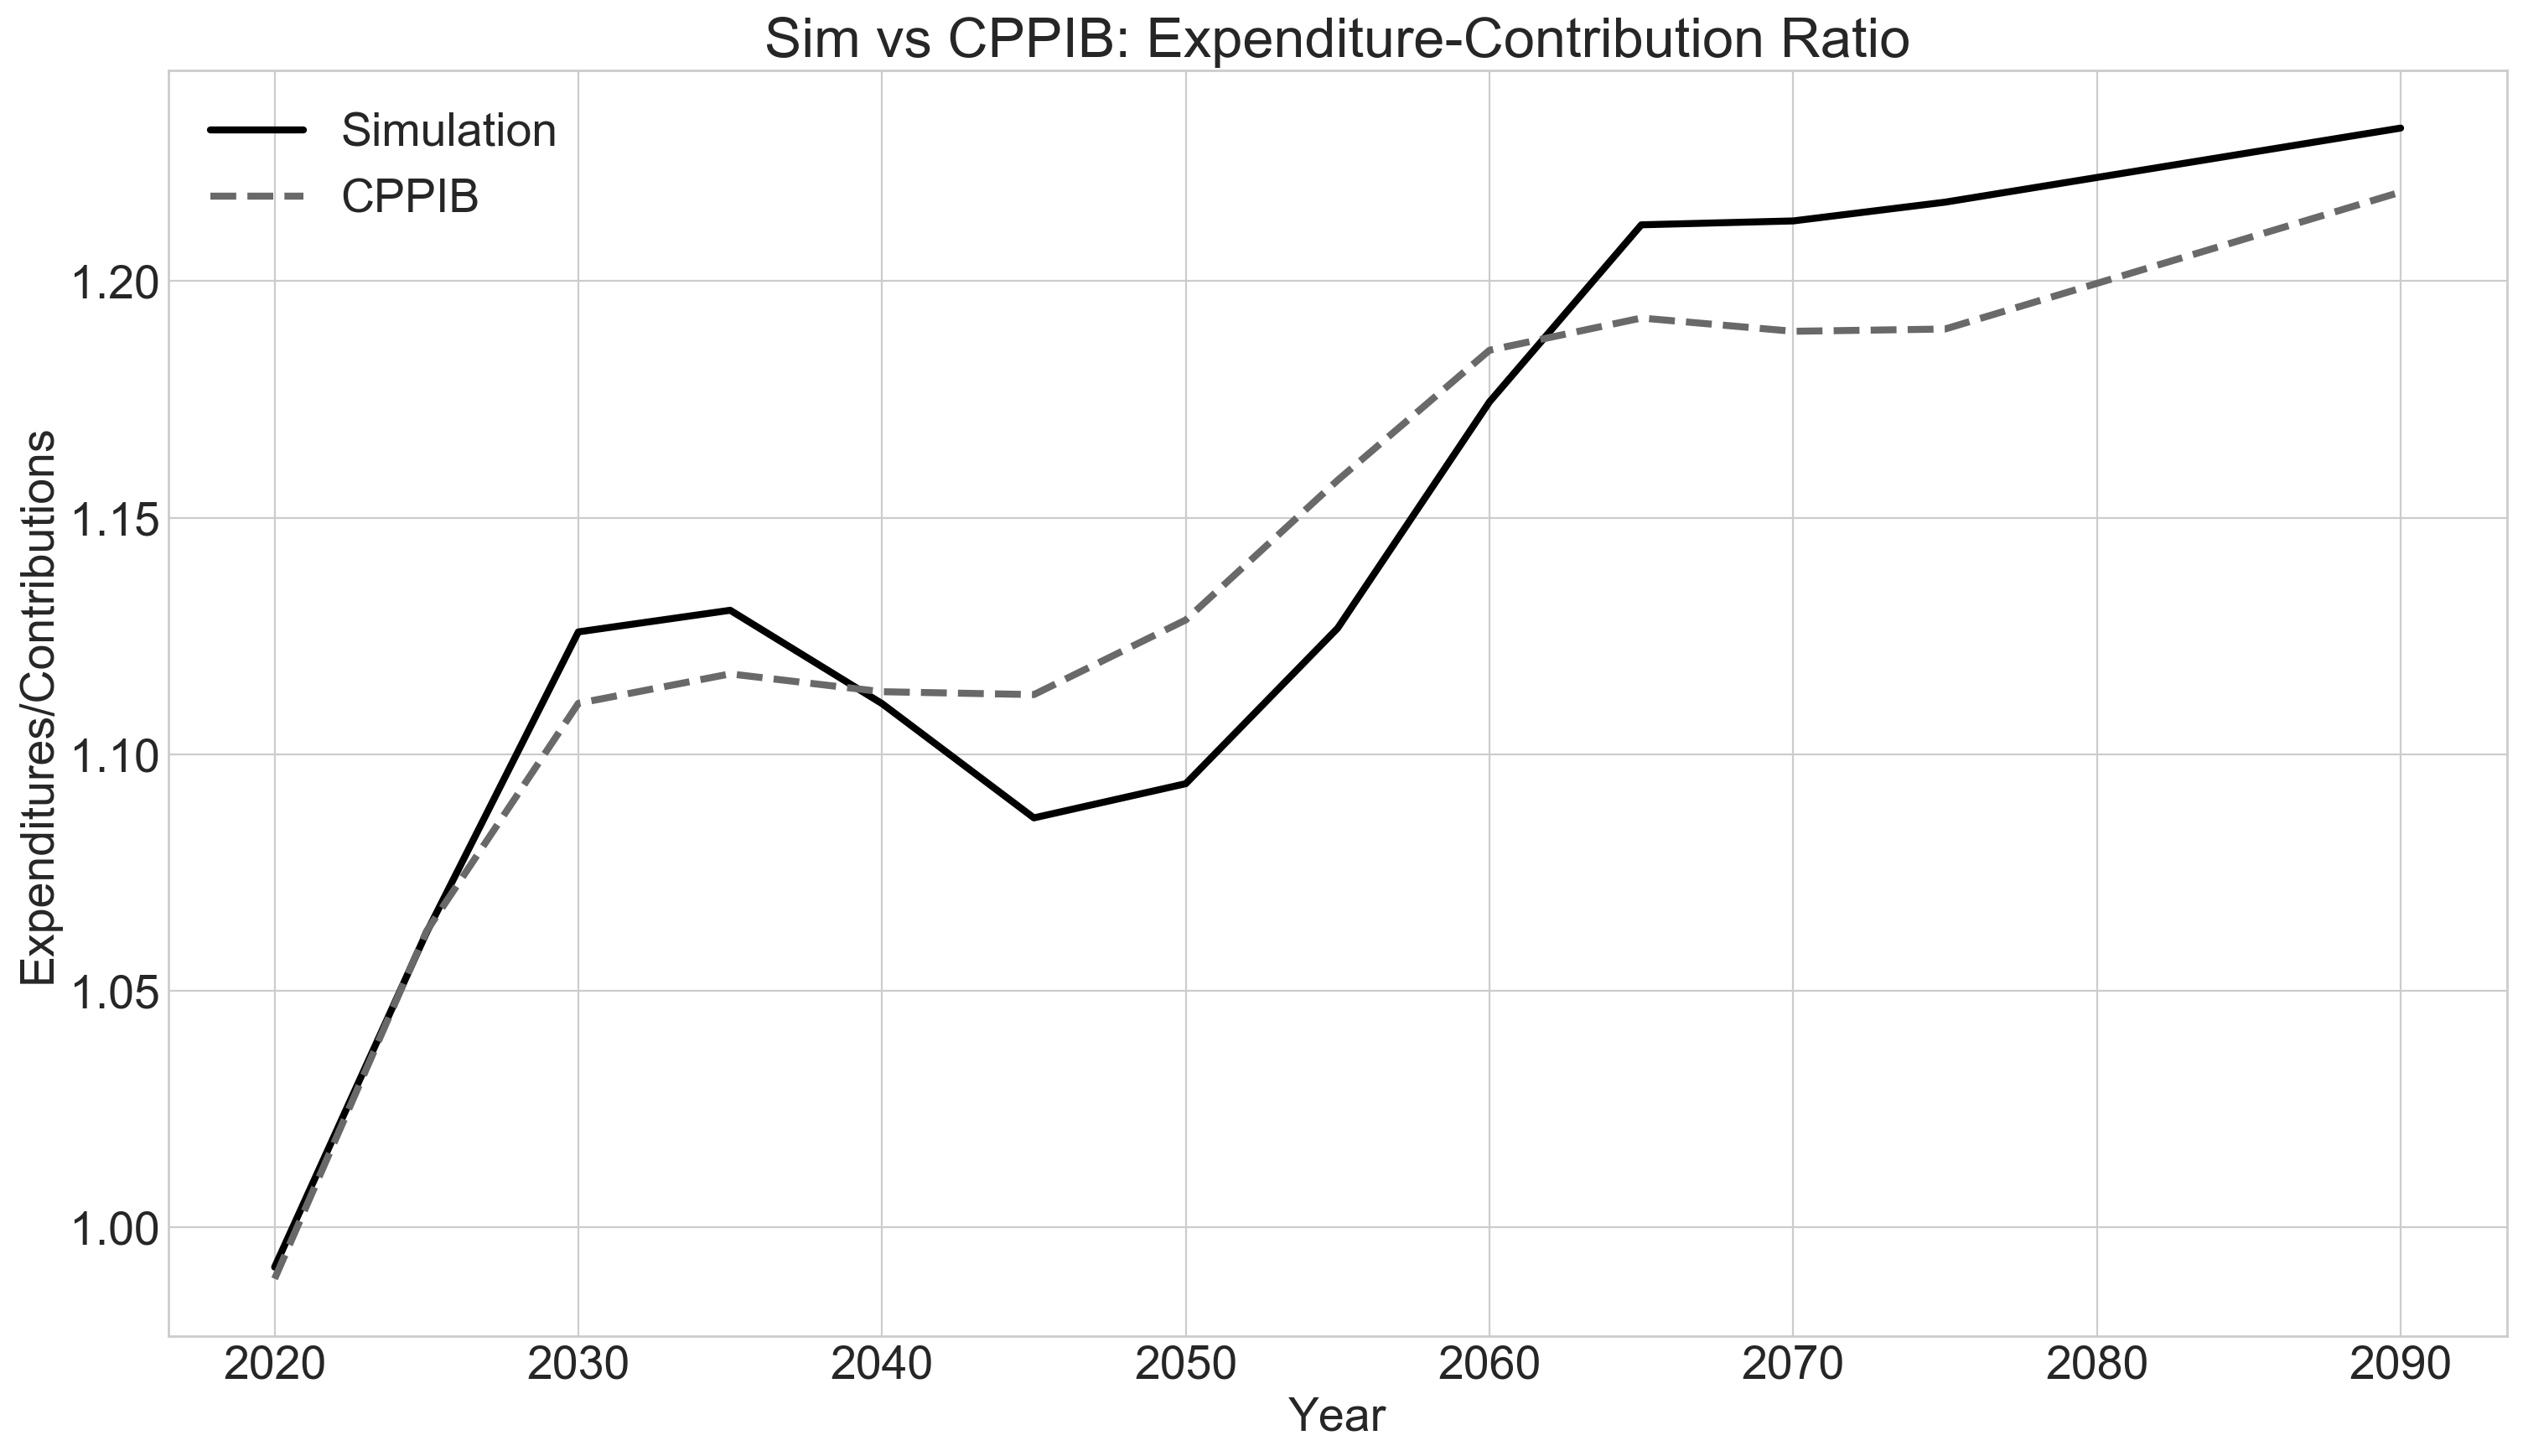

In [113]:
ratio_sim = []
ratio_cppib =[]

for year in cppib_contributions().index.tolist():
    ratio_sim.append(financial_projection_old.Benefits[year]/financial_projection_old.Contributions[year])
    ratio_cppib.append(cppib_benefits()[year]/cppib_contributions()[year])
    
plt.plot(pd.Series(data = ratio_sim, index =cppib_contributions().index.tolist()), color = 'black', label = 'Simulation')
plt.plot(pd.Series(data = ratio_cppib, index =cppib_contributions().index.tolist()), '--',color = 'dimgrey' ,label = 'CPPIB')
plt.ylabel('Expenditures/Contributions')
plt.xlabel('Year')
plt.title('Sim vs CPPIB: Expenditure-Contribution Ratio')
plt.legend()

In [112]:
print(np.mean(ratio_cppib))
print(np.mean(ratio_sim))

1.1359469857732287
1.1366149046338216


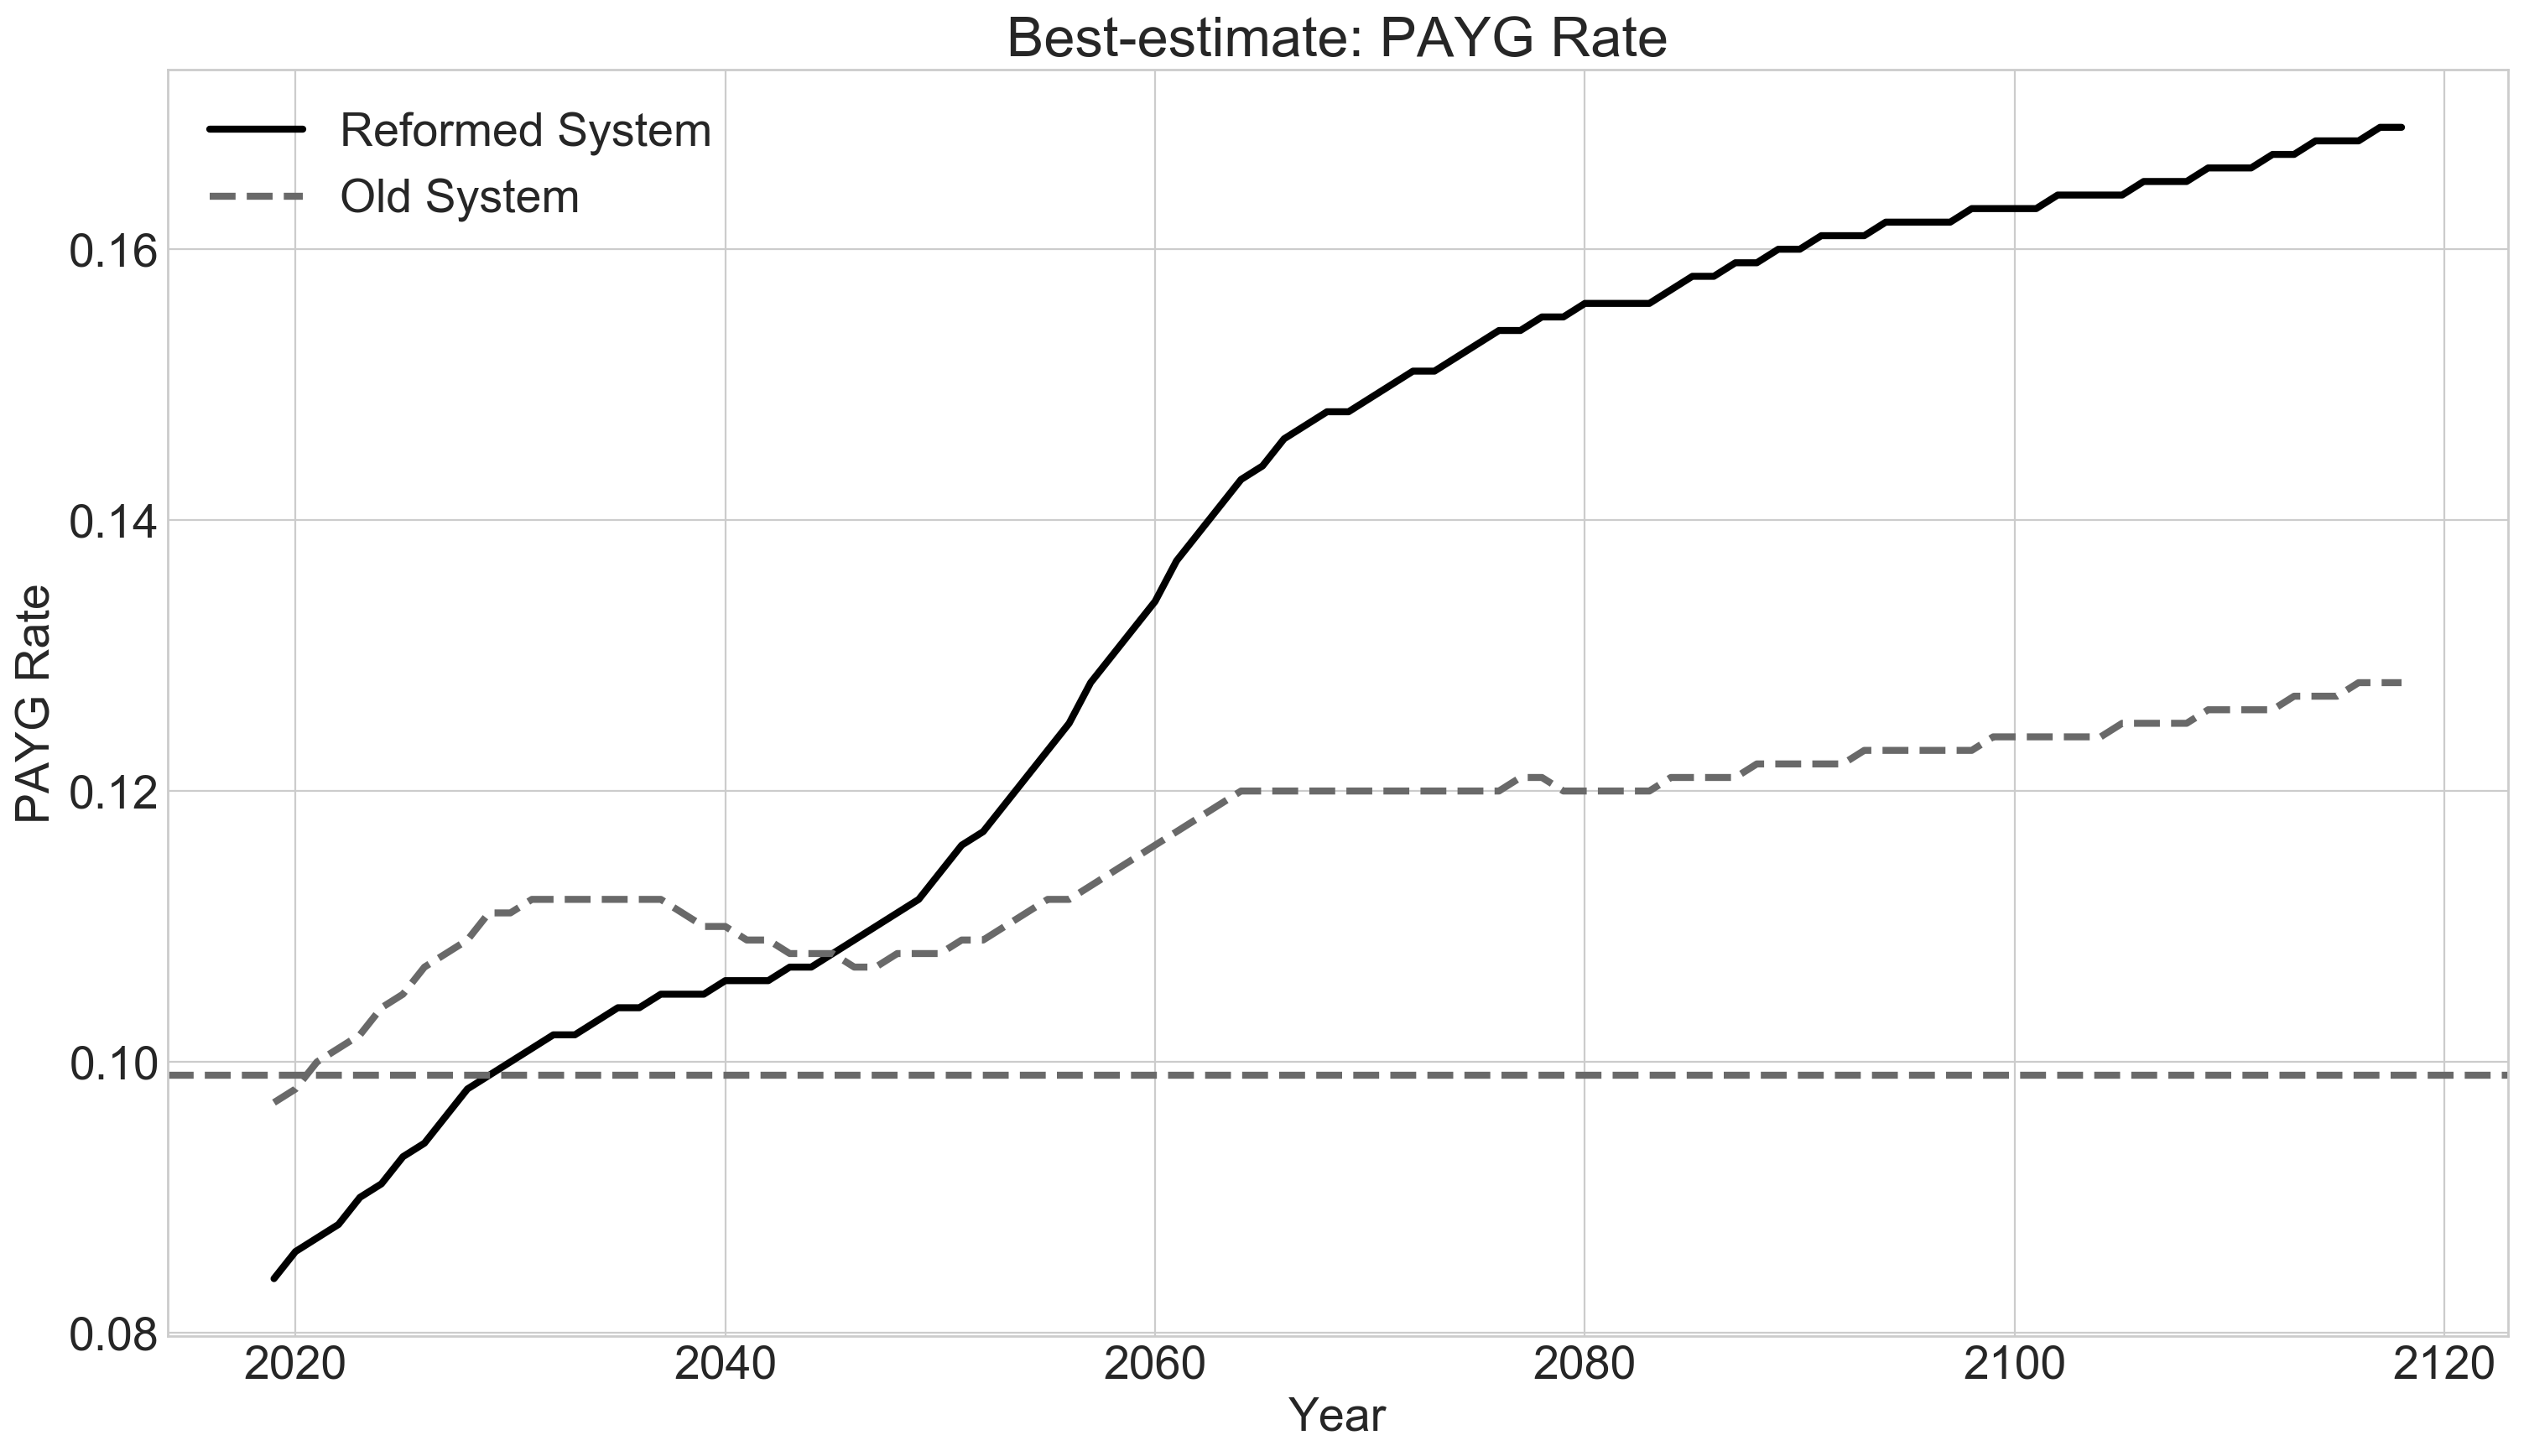

In [146]:
plt.plot(financial_projection_new.PAYG_Rate, 'black', label = 'Reformed System')
plt.plot(financial_projection_old.PAYG_Rate, '--', color = 'dimgray', label = 'Old System')
plt.axhline(y=.099, linestyle = '--', color = 'dimgray')
#plt.axhline(y=.119, linestyle = '-.',  color = 'k')
plt.title('Best-estimate: PAYG Rate')
plt.ylabel('PAYG Rate')
plt.xlabel('Year')
plt.legend()
plt.show()

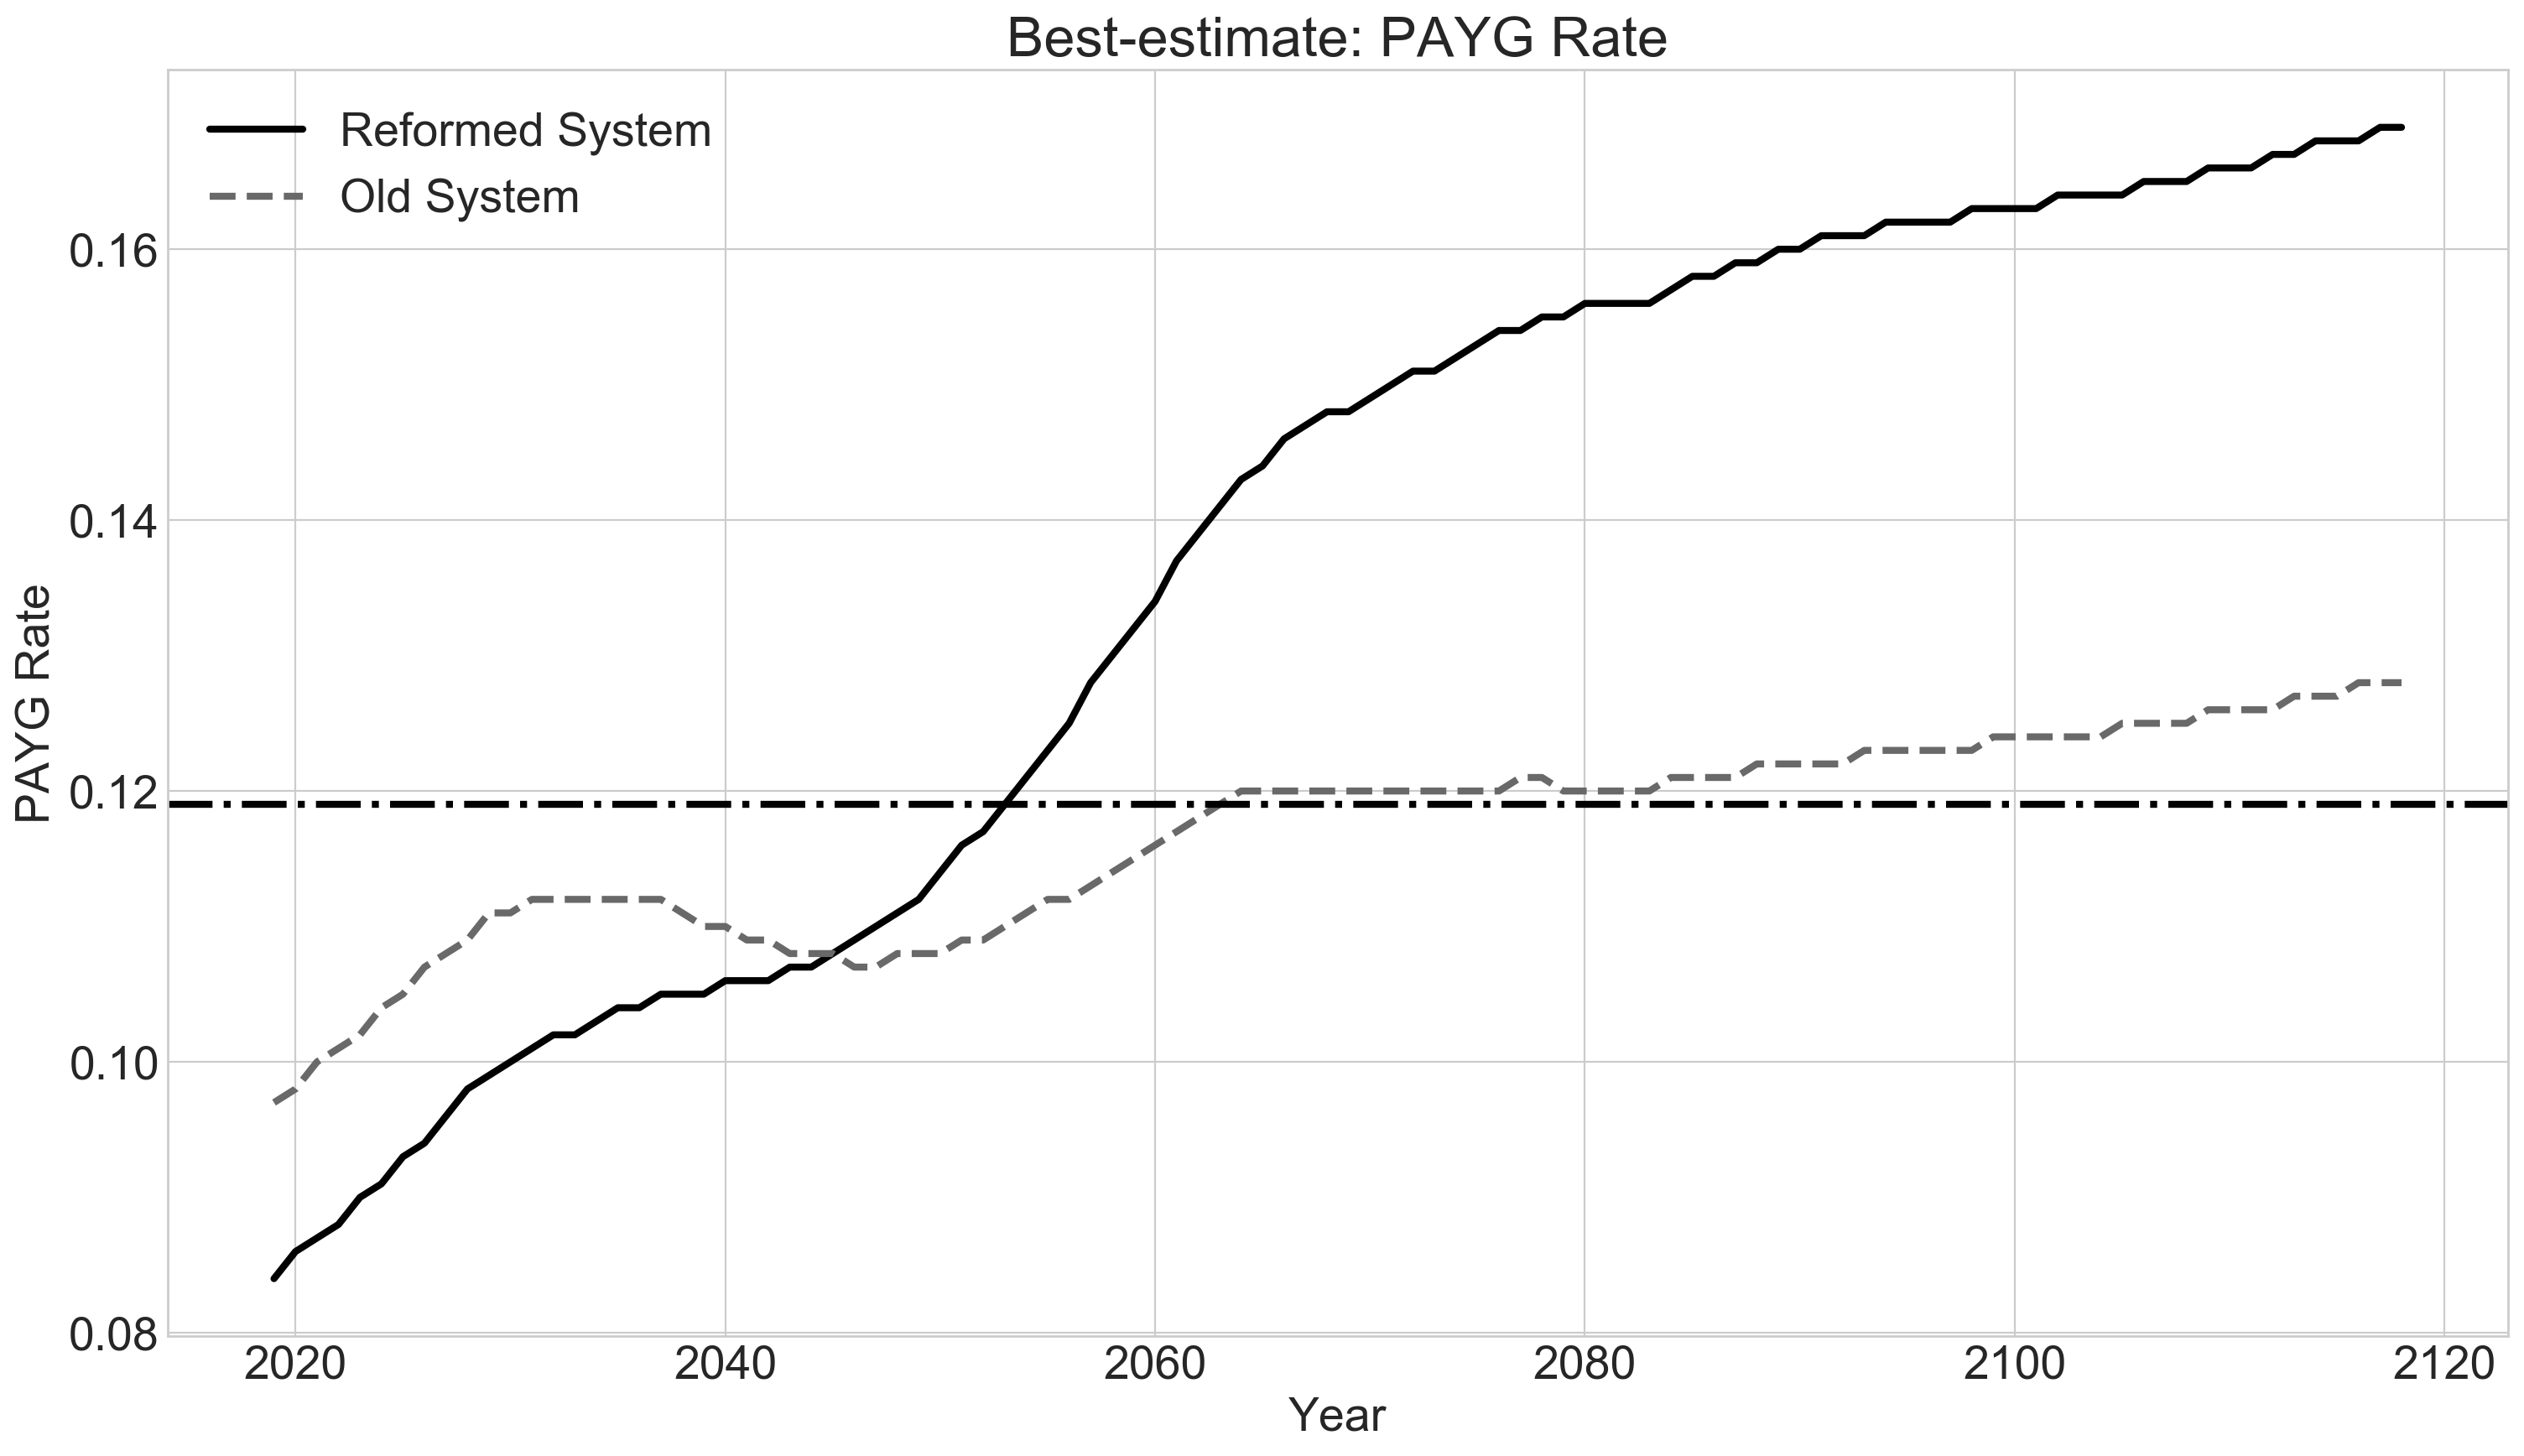

In [147]:
plt.plot(financial_projection_new.PAYG_Rate, 'black', label = 'Reformed System')
plt.plot(financial_projection_old.PAYG_Rate, '--', color = 'dimgray', label = 'Old System')
#plt.axhline(y=.099, linestyle = '--', color = 'dimgray')
plt.axhline(y=.119, linestyle = '-.',  color = 'k')
plt.title('Best-estimate: PAYG Rate')
plt.ylabel('PAYG Rate')
plt.xlabel('Year')
plt.legend()
plt.show()

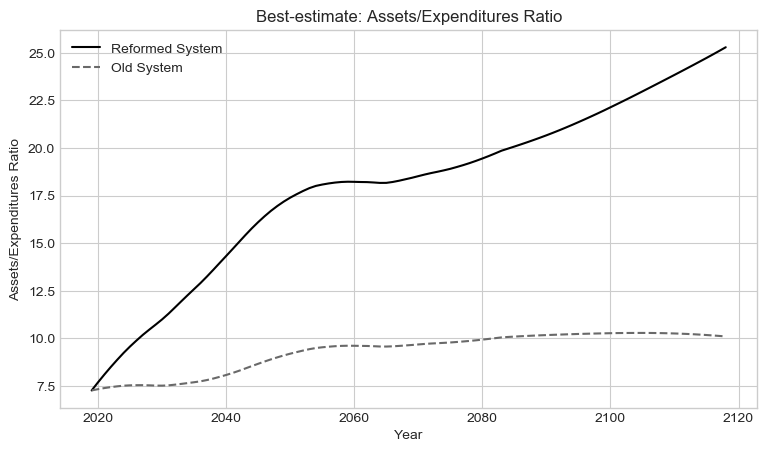

In [114]:
plt.plot(financial_projection_new.AE_Ratio, 'black', label = 'Reformed System')
plt.plot(financial_projection_old.AE_Ratio, '--', color = 'dimgray', label = 'Old System')
plt.title('Best-estimate: Assets/Expenditures Ratio')
plt.ylabel('Assets/Expenditures Ratio')
plt.xlabel('Year')
plt.legend()
plt.show()
plt.show()

### Section 3.5 Balance Sheet

Next let us look how the reforms affect the balance sheet of the CPP. The balance sheet is calculated using a modified version of the open-group approach which includes all current and future participants (Boado-Penas, Valdés-Prieto, & Vidal-Meliá, 2008). This reflects how the system is ongoing in nature and continues well into the future. Therefore, future contributions and benefits of current and new participants are included to determine whether current assets and future contributions will be enough to pay for all future expenditures. 

Traditionally, the open-group approach projects future expenditures over a 150-year period, and then the values are discounted using the projected rate of return of CPP assets to determine the net present value of assets and liabilities. Since this simulation only runs for 100-years, the balance sheet is only calculated for this period. 

The balance sheet was calculated three times. The first for the old system using the rate of return of CPP assets of the old system. The second for the reformed system using the rate of return of the reformed system. Then a second time for the reformed system but using the rate of return for the old system. This way we can directly compare the expansion of the CPP’s balance sheet using the same rate of return. 


In the context of the CPP, assets are equal to the current value of the CPPIB fund ($A_0$), and the discounted value of future contributions ($C_t$). 

Assets
\begin{equation}
A = A_0 + \sum_{t=1}^{n} \frac{C_t}{(1+r)^t}
\end{equation}

Liabilities are equal to the discounted value of future benefits ($B_t$). 

Liabilities
\begin{equation}
L = \sum_{t=1}^{n} \frac{B_t}{(1+r)^t}
\end{equation}

* t = time period
* r = internal rate of return of the system
* n = 100 years

Before I calculate the balance sheet, I first need to define a function that determines the internal rate of return of CPP assets. 

In [115]:
def system_irr(income_projection):    
    income_flow = income_projection.Contributions[:].copy(deep=True)
    income_flow.loc[2019] = income_flow.loc[2019] + income_projection.loc[2019].cppib_value 
    income_flow = income_flow - income_projection.Benefits
    return np.irr(income_flow)

In [116]:
def balance_sheet(irr, income_projection):
    assets = np.npv(irr, income_projection.Contributions) + income_projection.loc[2019].cppib_value 
    liabilities = np.npv(irr,income_projection.Benefits)
    balance = assets - liabilities 
    
    return pd.Series(data = [assets, liabilities, balance, np.round(assets/liabilities,4)],
                     index = ['Assets','Liabilities', 'Balance', 'Assets as a percentage of liabilities'])

In [117]:
#Internal rate of return for the old CPP system
system_irr(financial_projection_old)

0.054530410991224354

In [118]:
#Internal rate of return for the new system
system_irr(financial_projection_new)

0.04761414285860033

In [119]:
#Balance sheet for the old CPP system using the IRR for the old system
balance_sheet(0.05453, financial_projection_old)

Assets                                   2.759166e+06
Liabilities                              2.759173e+06
Balance                                 -6.743911e+00
Assets as a percentage of liabilities    1.000000e+00
dtype: float64

In [120]:
#Balance sheet for the new CPP system using the IRR for the new system
balance_sheet(0.0476, financial_projection_new)

Assets                                   4.649059e+06
Liabilities                              4.649625e+06
Balance                                 -5.667474e+02
Assets as a percentage of liabilities    9.999000e-01
dtype: float64

In [121]:
#Balance sheet for the new CPP system using the IRR for the old system
balance_sheet(0.05453, financial_projection_new)

Assets                                   3.679411e+06
Liabilities                              3.463871e+06
Balance                                  2.155406e+05
Assets as a percentage of liabilities    1.062200e+00
dtype: float64

The reforms add between one- and two- trillion dollars to the CPP balance sheet, depending on the discount rate used to calculate the net present value. It appears that both the old, and reformed system have enough future assets to meet liabilities. When we calculate the balance sheet for the reformed system, using the rate of return of the old system, it shows that the system has substantially more assets then liabilities. This analysis will likely change when using a 150-year time horizon. 

# Section 4: Sensitivity and Scenario Analysis

Up until now, the analysis has been focused on using the best-estimate parameters provided by the CPPIB. Now I want to conduct sensitivity analysis using a high-cost, and low-cost parameters.

Parameters: 
1. Population growth
2. Net migration
3. Real productivity rate
4. Inflation
5. Real CPPIB rate of return
6. Life expectancy

In [122]:
def sensitivity_analysis(birth_multiplier, immigration_multiplier, productivity_rate, inflation_scenario, cppib_return, 
                          female_2050, male_2050, name_scenario):
    
    #Parameters
    birth_multiplier = birth_multiplier
    immigration_multiplier = immigration_multiplier
    risk_free_rate = 0.0161 + inflation_scenario
    cppib_fund_return = inflation_scenario + cppib_return
    
    #Set global variables
    global male_pop
    global female_pop
    
    #Population Variables
    total_pop_series, male_pop, female_pop, death_series = population_model(birth_multiplier, \
                                                                            immigration_multiplier, female_2050,male_2050)
    
    #Historic Benefits
    male_pensions, female_penesions = historical_benefits(inflation_scenario)
    historic_pensions = male_pensions.sum(axis=1) + female_penesions.sum(axis=1)
    
    #CPP Old and New
    cohort_old_male, cohort_old_female = old_cpp(male_pop, female_pop, productivity_rate, inflation_scenario)
    cohort_new_male, cohort_new_female = new_cpp(male_pop, female_pop, productivity_rate, inflation_scenario)
    
    cohort_new_male = transition_generations(cohort_old_male, cohort_new_male)
    cohort_new_female = transition_generations(cohort_old_female, cohort_new_female)
    
    #Financial Projections
    financial_projection_old = financial_projections(cohort_old_male, cohort_old_female, 0.099, cppib_fund_return)
    financial_projection_new = financial_projections(cohort_new_male, cohort_new_female, 0.119, cppib_fund_return)
    
    ga_accounts = [gen_accounts(cohort_old_male.loc[:,2001:2001],risk_free_rate).values[0], 
                   gen_accounts(cohort_new_male.loc[:,2001:2001],risk_free_rate).values[0], 
                   gen_accounts(cohort_old_female.loc[:,2001:2001],risk_free_rate).values[0], 
                   gen_accounts(cohort_new_female.loc[:,2001:2001],risk_free_rate).values[0],
                   internal_ror([2001], cohort_old_male + cohort_old_female).values[0]-inflation_scenario, 
                   internal_ror([2001], cohort_new_male + cohort_new_female).values[0]-inflation_scenario]

    
    fin_stats = [financial_projection_old['Min_cont_rate'].loc[2019],
                 financial_projection_new['Min_cont_rate'].loc[2019],
                          financial_projection_old.PAYG_Rate[2025], 
                          financial_projection_new.PAYG_Rate[2025],
                          financial_projection_old.PAYG_Rate[2100], 
                          financial_projection_new.PAYG_Rate[2100],
                          financial_projection_old[financial_projection_old.Net_cash_flow < 0].index[0],
                          financial_projection_new[financial_projection_new.Net_cash_flow < 0].index[0],
                          financial_projection_old.AE_Ratio[2025], 
                          financial_projection_new.AE_Ratio[2025],
                          financial_projection_old.AE_Ratio[2100],
                          financial_projection_new.AE_Ratio[2100],
                          financial_projection_old['Reforms_triggered'].loc[2019],
                          financial_projection_new['Reforms_triggered'].loc[2019]]
    
    
    columns_ga = ['GA Male Old','GA Male New', 'GA Female Old', 'GA Female New', 'IRR Old', 'IRR New']

    columns_financials = ['Min Cont. Level Old',
                          'Min Cont. Level New',
                          'PAYGO Rate 2025 Old', 
                          'PAYGO Rate 2025 New',
                          'PAYGO Rate 2100 Old', 
                          'PAYGO Rate 2100 New',
                          'First Year Deficit Old', 
                          'First Year Deficit New', 
                          'A/E Old 2025', 
                          'A/E New 2025',
                          'A/E Old 2100', 
                          'A/E New 2100', 
                          'Reforms Triggered Old', 
                          'Reforms Triggered New']

    ga_df = pd.DataFrame(columns = columns_ga)
    ga_df.loc[name_scenario] = ga_accounts
    
    fin_df = pd.DataFrame(columns = columns_financials)
    fin_df.loc[name_scenario] = fin_stats
    
    stats = pd.DataFrame()
    stats['PAYG Rate Old'] = financial_projection_old.PAYG_Rate
    stats['PAYG Rate New'] = financial_projection_new.PAYG_Rate
    stats['A/E Old'] = financial_projection_old.AE_Ratio
    stats['A/E New'] = financial_projection_new.AE_Ratio
    stats['Min Rate Old'] = financial_projection_old.Min_cont_rate
    stats['Min Rate New'] = financial_projection_new.Min_cont_rate
    stats['Real Payments Old'] = cohort_old_male[2001]*inflate_income()
    stats['Real Payments New'] = cohort_new_male[2001]*inflate_income()
    stats['Population'] = total_pop_series
    stats['Dependency Ratio'] = youth_working_elderly(male_pop + female_pop)[1]
    
    return  np.round(ga_df,4), fin_df, stats

### Section 4.1 - Sensitivity Analysis

In [123]:
ga_best, fin_best, stats_best = sensitivity_analysis(1, 1, 0.011, 0.02, 0.039, 87.4, 84.2,'Best Scenario')
male_pop_best = male_pop

In [124]:
ga_inflation_low,  fin_inflation_low, stats_inflation_low = sensitivity_analysis(1, 1, 0.011, 0.015,0.039, 87.4, 84.2,'Low Inflation')
ga_inflation_high, fin_inflation_high, stats_inflation_high = sensitivity_analysis(1, 1, 0.011, 0.025,0.039, 87.4, 84.2,'High Inflation')

In [125]:
ga_prod_high, fin_prod_high, stats_prod_high = sensitivity_analysis(1, 1, 0.018, 0.02,0.039, 87.4, 84.2,'High Productivity')
ga_prod_low,   fin_prod_low, stats_prod_low = sensitivity_analysis(1, 1, 0.005, 0.02,0.039, 87.4, 84.2,'Low Productivity')

In [126]:
#Number provided by the CPPIB
ga_cppib_high,fin_cppib_high, stats_cppib_high = sensitivity_analysis(1, 1, 0.011, 0.02,0.056, 87.4, 84.2,'High CPPIB Returns')
ga_cppib_low,  fin_cppib_low, stats_cppib_low = sensitivity_analysis(1, 1, 0.011, 0.02,0.036, 87.4, 84.2,'Low CPPIB Returns')

In [127]:
ga_pop_high, fin_pop_high, stats_pop_high = sensitivity_analysis(1.21, 1, 0.011, 0.02,0.039, 87.4, 84.2,'High Pop Growth')
ga_pop_low,  fin_pop_low, stats_pop_low = sensitivity_analysis(0.85, 1, 0.011, 0.02,0.039, 87.4, 84.2,'Low Pop Growth')

In [128]:
ga_imm_low,  fin_imm_low, stats_imm_low = sensitivity_analysis(1, 0.8, 0.011, 0.02,0.039, 87.4, 84.2,'Low Immigration')
ga_imm_high, fin_imm_high, stats_imm_high = sensitivity_analysis(1, 1.2, 0.011, 0.02,0.039, 87.4, 84.2,'High Immigration')

In [129]:
ga_life_low,  fin_life_low, stats_life_low = sensitivity_analysis(1, 1, 0.011, 0.02,0.039, 85.8, 82.4,'Low Exepected Life')
ga_life_high,fin_life_high, stats_life_high = sensitivity_analysis(1, 1, 0.011, 0.02,0.039, 88.5, 85.5 ,'High Exepected Life')

In [130]:
fin_best.append([fin_inflation_high, fin_inflation_low, fin_prod_high, fin_prod_low, fin_cppib_high, fin_cppib_low,
                fin_pop_high, fin_pop_low,fin_imm_high, fin_imm_low, fin_life_low, fin_life_high])

Min Cont. Level Old  Min Cont. Level New  \
Best Scenario                      0.097                0.106   
High Inflation                     0.095                0.105   
Low Inflation                      0.099                0.108   
High Productivity                  0.093                0.105   
Low Productivity                   0.099                0.107   
High CPPIB Returns                 0.082                0.087   
Low CPPIB Returns                  0.099                0.110   
High Pop Growth                    0.093                0.103   
Low Pop Growth                     0.099                0.109   
High Immigration                   0.095                0.105   
Low Immigration                    0.098                0.108   
Low Exepected Life                 0.093                0.101   
High Exepected Life                0.099                0.110   

                     PAYGO Rate 2025 Old  PAYGO Rate 2025 New  \
Best Scenario                      0.105                0.093   
High Inflation                     0.103                0.091   
Low Inflation                      0.108                0.095   
High Productivity                  0.101                0.089   
Low Productivity                   0.109                0.096   
High CPPIB Returns                 0.105                0.093   
Low CPPIB Returns                  0.105                0.093   
High Pop Growth                    0.105                0.093   
Low Pop Growth                     0.105                0.093   
High Immigration                   0.104                0.092   
Low Immigration                    0.106                0.094   
Low Exepected Life                 0.105                0.093   
High Exepected Life                0.105                0.093   

                     PAYGO Rate 2100 Old  PAYGO Rate 2100 New  \
Best Scenario                      0.124                0.163   
High Inflation                     0.122                0.161   
Low Inflation                      0.125                0.165   
High Productivity                  0.111                0.147   
Low Productivity                   0.136                0.179   
High CPPIB Returns                 0.124                0.163   
Low CPPIB Returns                  0.124                0.163   
High Pop Growth                    0.117                0.155   
Low Pop Growth                     0.129                0.171   
High Immigration                   0.125                0.165   
Low Immigration                    0.122                0.161   
Low Exepected Life                 0.109                0.143   
High Exepected Life                0.133                0.175   

                    First Year Deficit Old First Year Deficit New  \
Best Scenario                         2021                   2053   
High Inflation                        2022                   2054   
Low Inflation                         2021                   2053   
High Productivity                     2022                   2059   
Low Productivity                      2021                   2047   
High CPPIB Returns                    2021                   2053   
Low CPPIB Returns                     2021                   2053   
High Pop Growth                       2021                   2057   
Low Pop Growth                        2021                   2051   
High Immigration                      2021                   2056   
Low Immigration                       2021                   2051   
Low Exepected Life                    2021                   2056   
High Exepected Life                   2021                   2052   

                     A/E Old 2025  A/E New 2025  A/E Old 2100  A/E New 2100  \
Best Scenario               7.539         9.580        10.276        22.138   
High Inflation              7.768         9.842        13.569        24.512   
Low Inflation               7.313         9.321         6.798        19.638   
High 

In [131]:
ga_best.append([ga_inflation_high, ga_inflation_low, ga_prod_high, ga_prod_low, ga_cppib_high, ga_cppib_low,
                ga_pop_high, ga_pop_low, ga_imm_high, ga_imm_low, ga_life_low, ga_life_high])

GA Male Old  GA Male New  GA Female Old  GA Female New  \
Best Scenario             0.1220       0.1974         0.3098         0.3688   
High Inflation            0.1131       0.1893         0.3028         0.3624   
Low Inflation             0.1308       0.2055         0.3168         0.3752   
High Productivity         0.2366       0.3014         0.3976         0.4489   
Low Productivity          0.0043       0.0908         0.2201         0.2871   
High CPPIB Returns        0.1220       0.1974         0.3098         0.3688   
Low CPPIB Returns         0.1220       0.1974         0.3098         0.3688   
High Pop Growth           0.1220       0.1974         0.3098         0.3688   
Low Pop Growth            0.1220       0.1974         0.3098         0.3688   
High Immigration          0.1397       0.2132         0.3231         0.3808   
Low Immigration           0.1018       0.1793         0.2944         0.3550   
Low Exepected Life        0.0073       0.0926         0.2290         0.2949   
High Exepected Life       0.1848       0.2548         0.3532         0.4085   

                     IRR Old  IRR New  
Best Scenario         0.0230   0.0257  
High Inflation        0.0227   0.0254  
Low Inflation         0.0232   0.0259  
High Productivity     0.0271   0.0299  
Low Productivity      0.0194   0.0221  
High CPPIB Returns    0.0230   0.0257  
Low CPPIB Returns     0.0230   0.0257  
High Pop Growth       0.0230   0.0257  
Low Pop Growth        0.0230   0.0257  
High Immigration      0.0236   0.0263  
Low Immigration       0.0223   0.0250  
Low Exepected Life    0.0198   0.0226  
High Exepected Life   0.0248   0.0274

### Section 4.2 High-cost boundaries

These are values that trigger the semi-automatic balancing mechanism. Bound 1 (b1) trigger the reforms of the old system. Bound 2 (b2) trigger reforms for the new system.  

In [132]:
ga_inflation_low_b1,  fin_inflation_low_b1, stats_inb1 = sensitivity_analysis(1, 1, 0.011, 0.013, 0.032, 87.4, 84.2,'Low Inflation B1')
ga_inflation_low_b2,  fin_inflation_low_b2, stats_inb2 = sensitivity_analysis(1, 1, 0.011, 0.00, 0.019, 87.4, 84.2,'Low Inflation B2')

In [133]:
#Lower bound for the old system is 0.4%
ga_prod_low_b1,   fin_prod_low_b1, stats_prodb1 = sensitivity_analysis(1, 1, 0.004, 0.02,0.039, 87.4, 84.2,'Low Productivity Bound 1')
ga_prod_low_b2,   fin_prod_low_b2, stats_prodb2 = sensitivity_analysis(1, 1, -0.019, 0.02,0.039, 87.4, 84.2,'Low Productivity Bound 2')

In [135]:
#Highest value where the old system needs reform
ga_cppib_low_b1,  fin_cppib_low_b1, stats_cppibb1 = sensitivity_analysis(1, 1, 0.011, 0.02,0.035, 87.4, 84.2,'Low CPPIB Bound 1')
ga_cppib_low_b2,  fin_cppib_low_b2, stats_cppibb2 = sensitivity_analysis(1, 1, 0.011, 0.02,0.029, 87.4, 84.2,'Low CPPIB Bound 2')

In [136]:
#Lower bound 1
ga_pop_low_b1,  fin_pop_low_b1, stats_popb1 = sensitivity_analysis(0.79, 1, 0.011, 0.02,0.039, 87.4, 84.2,'Low Pop Growth Bound 1')
ga_pop_low_b2,  fin_pop_low_b2, stats_popb2 = sensitivity_analysis(0.4, 1, 0.011, 0.02,0.039, 87.4, 84.2,'Low Pop Growth Bound 2')

In [137]:
ga_imm_low_b1,  fin_imm_low_b1, stats_immb1 = sensitivity_analysis(1, 0.6, 0.011, 0.02,0.039, 87.4, 84.2,'Low Immigration Bound 1')
ga_imm_low_b2,  fin_imm_low_b2, stats_immb2 = sensitivity_analysis(1, 0, 0.011, 0.02,0.039, 87.4, 84.2,'Low Immigration Bound 2')

In [138]:
ga_life_low_b1,fin_life_low_b1, stats_lifeb1 = sensitivity_analysis(1, 1, 0.011, 0.02,0.039, 89, 86, 'High Exepected Life Bound 1')
ga_life_low_b2,fin_life_low_b2, stats_lifeb2 = sensitivity_analysis(1, 1, 0.011, 0.02,0.039, 91.7, 89.5,'High Exepected Life Bound 2')

In [139]:
fin_best.append([fin_inflation_low_b1, fin_inflation_low_b2, fin_prod_low_b1, fin_prod_low_b2, fin_cppib_low_b1, fin_cppib_low_b2, fin_pop_low_b1, fin_pop_low_b2,
fin_imm_low_b1, fin_imm_low_b2, fin_life_low_b1, fin_life_low_b2])

Min Cont. Level Old  Min Cont. Level New  \
Best Scenario                              0.097                0.106   
Low Inflation B1                           0.106                0.118   
Low Inflation B2                           0.123                0.144   
Low Productivity Bound 1                   0.100                0.108   
Low Productivity Bound 2                   0.111                0.113   
Low CPPIB Bound 1                          0.100                0.112   
Low CPPIB Bound 2                          0.106                0.121   
Low Pop Growth Bound 1                     0.100                0.111   
Low Pop Growth Bound 2                     0.108                0.119   
Low Immigration Bound 1                    0.100                0.109   
Low Immigration Bound 2                    0.106                0.113   
High Exepected Life Bound 1                0.100                0.111   
High Exepected Life Bound 2                0.107                0.120   

                             PAYGO Rate 2025 Old  PAYGO Rate 2025 New  \
Best Scenario                              0.105                0.093   
Low Inflation B1                           0.109                0.096   
Low Inflation B2                           0.115                0.102   
Low Productivity Bound 1                   0.109                0.096   
Low Productivity Bound 2                   0.124                0.109   
Low CPPIB Bound 1                          0.105                0.093   
Low CPPIB Bound 2                          0.105                0.093   
Low Pop Growth Bound 1                     0.105                0.093   
Low Pop Growth Bound 2                     0.105                0.093   
Low Immigration Bound 1                    0.107                0.095   
Low Immigration Bound 2                    0.111                0.097   
High Exepected Life Bound 1                0.105                0.093   
High Exepected Life Bound 2                0.105                0.093   

                             PAYGO Rate 2100 Old  PAYGO Rate 2100 New  \
Best Scenario                              0.124                0.163   
Low Inflation B1                           0.126                0.166   
Low Inflation B2                           0.129                0.171   
Low Productivity Bound 1                   0.138                0.182   
Low Productivity Bound 2                   0.205                0.270   
Low CPPIB Bound 1                          0.124                0.163   
Low CPPIB Bound 2                          0.124                0.163   
Low Pop Growth Bound 1                     0.132                0.174   
Low Pop Growth Bound 2                     0.157                0.207   
Low Immigration Bound 1                    0.120                0.158   
Low Immigration Bound 2                    0.111                0.146   
High Exepected Life Bound 1                0.136                0.179   
High Exepected Life Bound 2                0.153                0.201   

                            First Year Deficit Old First Year Deficit New  \
Best Scenario                                 2021                   2053   
Low Inflation B1                              2021                   2052   
Low Inflation B2                              2020                   2035   
Low Productivity Bound 1                      2021                   2046   
Low Productivity Bound 2                      2020                   2028   
Low CPPIB Bound 1                             2021                   2053   
Low CPPIB Bound 2                             2021                   2053   
Low Pop Growth Bound 1                        2021                   2051   
Low Pop Growth Bound 2                        2021                   2047   
Low Immigration Bound 1                       2021                   2048   
Low Immigration Bound 2                       2021                   2035   
High Exepected Life Bound 1         

In [140]:
ga_best.append([ga_inflation_low_b1, ga_inflation_low_b2, ga_prod_low_b1, ga_prod_low_b2, ga_cppib_low_b1, ga_cppib_low_b2, ga_pop_low_b1, ga_pop_low_b2,
ga_imm_low_b1, ga_imm_low_b2, ga_life_low_b1, ga_life_low_b2])

GA Male Old  GA Male New  GA Female Old  \
Best Scenario                     0.1220       0.1974         0.3098   
Low Inflation B1                  0.1344       0.2087         0.3196   
Low Inflation B2                  0.1574       0.2298         0.3379   
Low Productivity Bound 1         -0.0173       0.0712         0.2036   
Low Productivity Bound 2         -0.7400      -0.5795        -0.3418   
Low CPPIB Bound 1                 0.1220       0.1974         0.3098   
Low CPPIB Bound 2                 0.1220       0.1974         0.3098   
Low Pop Growth Bound 1            0.1220       0.1974         0.3098   
Low Pop Growth Bound 2            0.1220       0.1974         0.3098   
Low Immigration Bound 1           0.0786       0.1585         0.2765   
Low Immigration Bound 2          -0.0180       0.0721         0.1989   
High Exepected Life Bound 1       0.2053       0.2735         0.3702   
High Exepected Life Bound 2       0.3079       0.3674         0.4391   

                             GA Female New  IRR Old  IRR New  
Best Scenario                       0.3688   0.0230   0.0257  
Low Inflation B1                    0.3778   0.0233   0.0260  
Low Inflation B2                    0.3945   0.0240   0.0266  
Low Productivity Bound 1            0.2722   0.0188   0.0215  
Low Productivity Bound 2           -0.2223   0.0052   0.0076  
Low CPPIB Bound 1                   0.3688   0.0230   0.0257  
Low CPPIB Bound 2                   0.3688   0.0230   0.0257  
Low Pop Growth Bound 1              0.3688   0.0230   0.0257  
Low Pop Growth Bound 2              0.3688   0.0230   0.0257  
Low Immigration Bound 1             0.3388   0.0216   0.0242  
Low Immigration Bound 2             0.2689   0.0187   0.0213  
High Exepected Life Bound 1         0.4241   0.0254   0.0281  
High Exepected Life Bound 2         0.4871   0.0285   0.0310

### Section 4.3 - Scenario Analysis

To end this analysis, I will conduct analysis of four scenarios:
1. High Pop Growth, High Economic Growth
2. High Pop Growth, Low Economic Growth
3. Low Pop Growth, High Economic Growth
4. Low Pop Growth, Low Economics Growth

In [141]:
#High Population Growth, High Economic Growth
ga_HH, fin_HH, stats_HH = sensitivity_analysis(1.2, 1.2, 0.02, 0.025, 0.065, 88.5, 85.5, 'High, High')
male_pop_HH = male_pop

#High Population Growth, Low Economic Growth
ga_HL, fin_HL, stats_HL = sensitivity_analysis(1.2, 1.2, 0.008, 0.015, 0.036, 88.5, 85.5, 'High, Low')
male_pop_HL = male_pop

#Low Population Growth, High Economic Growth
ga_LH, fin_LH, stats_LH = sensitivity_analysis(0.8, 0.8, 0.02, 0.025, 0.065, 86, 83, 'Low, High')
male_pop_LH = male_pop

#Low Population Growth, Low Economic Growth
ga_LL, fin_LL, stats_LL = sensitivity_analysis(0.8, 0.8, 0.008, 0.015, 0.036, 86, 83, 'Low, Low')
male_pop_LL = male_pop

[]

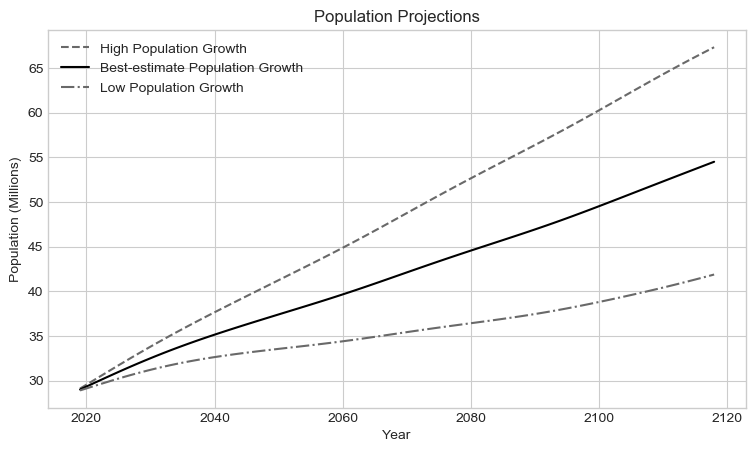

In [142]:
plt.plot(stats_HH.Population/1000000, '--', color = 'dimgray', label = 'High Population Growth')
plt.plot(stats_best.Population/1000000, color = 'black', label = 'Best-estimate Population Growth')
plt.plot(stats_LL.Population/1000000, '-.', color = 'dimgray', label = 'Low Population Growth')
plt.xlabel('Year')
plt.ylabel('Population (Millions)')
plt.title('Population Projections')
plt.legend()
plt.plot()

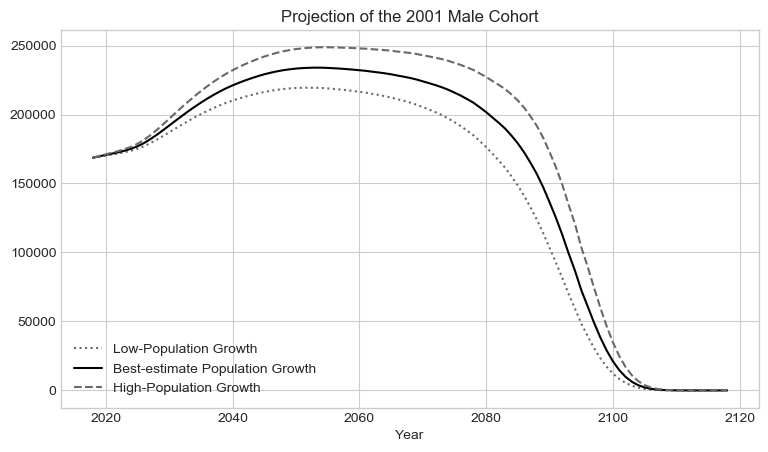

In [143]:
plt.plot(male_pop_LH[2001],':',color='dimgray', label = 'Low-Population Growth')
plt.plot(male_pop_best[2001], color='black',label = 'Best-estimate Population Growth')
plt.plot(male_pop_HH[2001],'--',color='dimgray',  label = 'High-Population Growth')
plt.title('Projection of the 2001 Male Cohort')
plt.xlabel('Year')
plt.legend()
plt.show()

[]

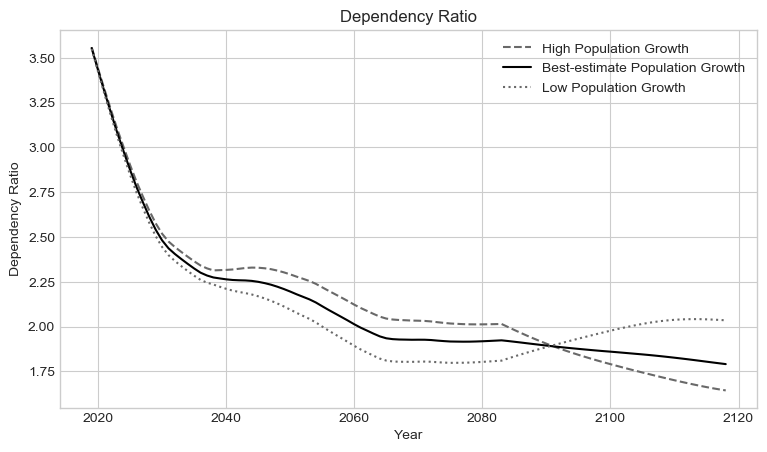

In [144]:
plt.plot(stats_HH['Dependency Ratio'], '--',color = 'dimgray', label = 'High Population Growth')
plt.plot(stats_best['Dependency Ratio'], color = 'black', label = 'Best-estimate Population Growth')
plt.plot(stats_LL['Dependency Ratio'], ':',color = 'dimgray', label = 'Low Population Growth')
plt.title('Dependency Ratio')
plt.xlabel('Year')
plt.ylabel('Dependency Ratio')
plt.legend()
plt.plot()

In [145]:
ga_HH.append([ga_HL,ga_LH,ga_LL])

GA Male Old  GA Male New  GA Female Old  GA Female New  IRR Old  \
High, High       0.3233       0.3804         0.4601         0.5059   0.0305   
High, Low        0.1588       0.2311         0.3332         0.3902   0.0239   
Low, High        0.1798       0.2496         0.3411         0.3972   0.0251   
Low, Low        -0.0248       0.0641         0.1824         0.2527   0.0184   

            IRR New  
High, High   0.0332  
High, Low    0.0265  
Low, High    0.0279  
Low, Low     0.0211

In [146]:
fin_HH.append([fin_HL,fin_LH,fin_LL])

Min Cont. Level Old  Min Cont. Level New  PAYGO Rate 2025 Old  \
High, High                0.070                0.075                0.097   
High, Low                 0.101                0.112                0.108   
Low, High                 0.072                0.076                0.099   
Low, Low                  0.105                0.114                0.110   

            PAYGO Rate 2025 New  PAYGO Rate 2100 Old  PAYGO Rate 2100 New  \
High, High                0.086                0.110                0.145   
High, Low                 0.095                0.135                0.179   
Low, High                 0.087                0.102                0.134   
Low, Low                  0.097                0.124                0.164   

           First Year Deficit Old First Year Deficit New  A/E Old 2025  \
High, High                   2084                   2066         9.078   
High, Low                    2021                   2053         7.179   
Low, High                    2025                   2057         9.040   
Low, Low                     2020                   2044         7.144   

            A/E New 2025  A/E Old 2100  A/E New 2100 Reforms Triggered Old  \
High, High        11.319       111.378       127.323                    No   
High, Low          9.170         2.766        13.386                   Yes   
Low, High         11.266       149.649       178.443                    No   
Low, Low           9.120        -3.682        14.835                   Yes   

           Reforms Triggered New  
High, High                    No  
High, Low                     No  
Low, High                     No  
Low, Low                      No

[]

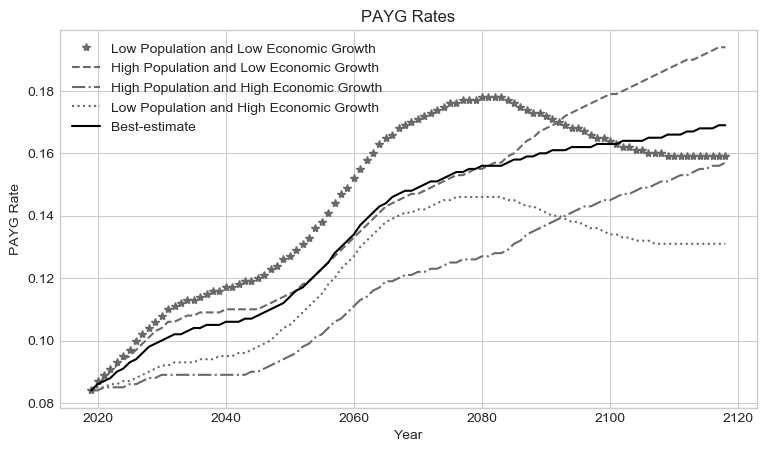

In [147]:
plt.plot(stats_LL['PAYG Rate New'],'*',color = 'dimgrey', label='Low Population and Low Economic Growth')
plt.plot(stats_HL['PAYG Rate New'],'--',color = 'dimgrey', label='High Population and Low Economic Growth')
plt.plot(stats_HH['PAYG Rate New'],'-.',color = 'dimgrey', label='High Population and High Economic Growth')
plt.plot(stats_LH['PAYG Rate New'],':',color = 'dimgrey', label='Low Population and High Economic Growth')
plt.plot(stats_best['PAYG Rate New'], color = 'black', label='Best-estimate')
plt.title('PAYG Rates')
plt.xlabel('Year')
plt.ylabel('PAYG Rate')
plt.legend(loc='upper left')
plt.plot()

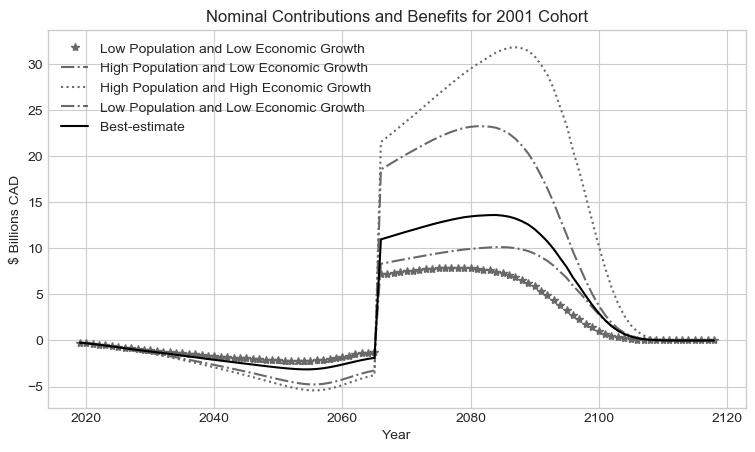

In [148]:
plt.plot(stats_LL['Real Payments New']/1000000000,'*',color = 'dimgrey', label='Low Population and Low Economic Growth')
plt.plot(stats_HL['Real Payments New']/1000000000,'-.',color = 'dimgrey', label='High Population and Low Economic Growth')
plt.plot(stats_HH['Real Payments New']/1000000000,':',color = 'dimgrey', label='High Population and High Economic Growth')
plt.plot(stats_LH['Real Payments New']/1000000000,'-.',color = 'dimgrey', label='Low Population and Low Economic Growth')
plt.plot(stats_best['Real Payments New']/1000000000, color = 'black', label = 'Best-estimate')
#plt.plot(stats_best['Real Payments Old']/1000000000, color = 'dimgrey', label = 'Best-estimate Old')
plt.title('Nominal Contributions and Benefits for 2001 Cohort')
plt.ylabel('$ Billions CAD')
plt.xlabel('Year')
plt.legend()
plt.show()